# Using Aniline as context
# Author : Manas Mahale <<manas.mahale@bcp.edu.in>>

In [1]:
import re
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import pandas as pd

In [2]:
from model.utils import set_seed
from model.model import GPT, GPTConfig
from model.trainer import Trainer, TrainerConfig
from model.utils import sample

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset

In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [4]:
# make deterministic
set_seed(42)

In [5]:
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        chars = []
        for i in text:
            for j in set(i):
                chars.append(j)           
        chars = sorted(list(set(chars))) + ['<pad>']
        data_size, vocab_size = len(text), len(chars)
        print('Data has %d SMILES \n%d unique characters.' % (data_size, vocab_size))        
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for i,ch in enumerate(chars)}
        self.vocab_size = vocab_size
        self.data = data
        self.block_size = block_size
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + 1][0]
        dix = [self.stoi[s] for s in chunk] + [self.stoi['<pad>']] * (self.block_size - len(chunk))
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [6]:
block_size = 128
text = list(pd.read_csv('./data/drugs1.csv',header = None)[0].values)
text = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in text]
text = [x for x in text if len(x) < 128 and len(x) > 3]
train_dataset = CharDataset(text, block_size)

Data has 1409 SMILES 
47 unique characters.


In [7]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=1, n_head=1, n_embd=64)
model = GPT(mconf)

01/06/2022 02:35:37 - INFO - model.model -   number of parameters: 6.432000e+04


In [8]:
tconf = TrainerConfig(max_epochs=175, batch_size=128, learning_rate=3e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

epoch 1 iter 11: train loss 2.93511. lr 1.587740e-04: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s]
epoch 2 iter 11: train loss 2.78742. lr 3.000000e-05: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
epoch 3 iter 11: train loss 2.86748. lr 1.512007e-04: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]
epoch 4 iter 11: train loss 2.89913. lr 2.998723e-04: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]
epoch 5 iter 11: train loss 2.47184. lr 1.388299e-04: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]
epoch 6 iter 11: train loss 2.20456. lr 3.000000e-05: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]
epoch 7 iter 11: train loss 2.26819. lr 1.710901e-04: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]
epoch 8 iter 11: train loss 2.44868. lr 2.977263e-04: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]
epoch 9 iter 11: train loss 1.67309. lr 1.190833e-04: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
epoch 10 iter 11: train loss 1.33633. lr 3.000000e-05: 100%|██████████| 12/12 [00:

epoch 158 iter 11: train loss 0.53874. lr 8.451103e-05: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]
epoch 159 iter 11: train loss 0.40555. lr 3.000000e-05: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s]
epoch 160 iter 11: train loss 0.28244. lr 2.243158e-04: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s]
epoch 161 iter 11: train loss 0.67646. lr 2.777526e-04: 100%|██████████| 12/12 [00:02<00:00,  4.23it/s]
epoch 162 iter 11: train loss 0.51189. lr 6.718618e-05: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s]
epoch 163 iter 11: train loss 1.07862. lr 3.000000e-05: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]
epoch 164 iter 11: train loss 0.72155. lr 2.409454e-04: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]
epoch 165 iter 11: train loss 0.56888. lr 2.661943e-04: 100%|██████████| 12/12 [00:02<00:00,  4.14it/s]
epoch 166 iter 11: train loss 0.54421. lr 5.132545e-05: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s]
epoch 167 iter 11: train loss 0.25815. lr 4.036946e-05: 100%|███

In [41]:
from tqdm.notebook import trange
a = []
n = 0
for i in trange(5000):
    context = "NC1=CC(=C(C=C1))"
    x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, 32, temperature=1.0, sample=True, top_k=10)[0]
    completion = ''.join([train_dataset.itos[int(i)] for i in y])
    smiles = re.sub("<pad>","",completion)
    print(smiles)
    m = Chem.MolFromSmiles(smiles)
    
    if m is not None:
        a.append(m)

  0%|          | 0/5000 [00:00<?, ?it/s]

NC1=CC(=C(C=C1))N[C@H](C)[C@@H](O)[C@H](C(OC(=O)
NC1=CC(=C(C=C1))C1CCOCC[C@@H]3[C@]1CCC4=CCC[C@H]
NC1=CC(=C(C=C1))[C@H]2C[C@H]4=O)[C@@@H]3[C@@H](O
NC1=CC(=C(C=C1))[C@H]1N3cc(ccccc(-4cc(-cc2ccc(c(
NC1=CC(=C(C=C1))C(=O)[C@H](O)[C@H]4O)[C@@H](CC)[
NC1=CC(=C(C=C1))NCCOc3cc1
NC1=CC(=C(C=C1))c2c3cC[C@H](C=O)O
NC1=CC(=C(C=C1))nc2c(C(N3cc2cCl)ccc(O)n2CC)cn2cc
NC1=CC(=C(C=C1))CC1ccccc(O)cnc2)nn2)Cc1N1CCC(=O)
NC1=CC(=C(C=C1))[N+])C)(CC)(=O
NC1=CC(=C(C=C1))(=O)C(=O)O


RDKit ERROR: [03:18:01] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@H](C)[C@@H](O)[C@H](C(OC(=O)'
RDKit ERROR: [03:18:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1CCOCC[C@@H]3[C@]1CCC4=CCC[C@H]'
RDKit ERROR: [03:18:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]2C[C@H]4=O)[C@@@H]3[C@@H](O
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2C[C@H]4=O)[C@@@H]3[C@@H](O' for input: 'NC1=CC(=C(C=C1))[C@H]2C[C@H]4=O)[C@@@H]3[C@@H](O'
RDKit ERROR: [03:18:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]1N3cc(ccccc(-4cc(-cc2ccc(c(
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1N3cc(ccccc(-4cc(-cc2ccc(c(' for input: 'NC1=CC(=C(C=C1))[C@H]1N3cc(ccccc(-4cc(-cc2ccc(c('
RDKit ERROR: [03:18:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)[C@H](O)[C@H]4O)[C@@H](CC)[
RDKit ER

NC1=CC(=C(C=C1))c1ccccc2)n(C)ccc22n1
NC1=CC(=C(C=C1))CCc2=CC/C=C/C/C(=C(=O)O)C(C)O
NC1=CC(=C(C=C1))ccc(-c2cccccc2C2S1
NC1=CC(=C(C=C1))NCCCCCC(C)(=O)N[C@@H](SC(S)(=O)(
NC1=CC(=C(C=C1))CC1=C(CC(=O)CO)CO(=O)O)cc1=O
NC1=CC(=C(C=C1))=C2ccc(NCC(=O)O)O
NC1=CC(=C(C=C1))C(=O)CC(=O)NCO)[C@@H](C)CC[C@H](
NC1=CC(=C(C=C1))[C@]2(=O)O)N(CC(C)c3C2)c1)cc1
NC1=CC(=C(C=C1))CNC(CC2=O)[C@H]1C[C@@@H](O)[C@](
NC1=CC(=C(C=C1))OC(CC(=O)Nc1)CCCN1CC12
NC1=CC(=C(C=C1))CCN2CNCC(=O)N[C@@@H](O)C[C@H]3[C
NC1=CC(=C(C=C1))c1cccccccc2)n1


RDKit ERROR: [03:18:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1ccccc2)n(C)ccc22n1
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1ccccc2)n(C)ccc22n1' for input: 'NC1=CC(=C(C=C1))c1ccccc2)n(C)ccc22n1'
RDKit ERROR: [03:18:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCc2=CC/C=C/C/C(=C(=O)O)C(C)O'
RDKit ERROR: [03:18:01] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccc(-c2cccccc2C2S1'
RDKit ERROR: [03:18:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCCCCCC(C)(=O)N[C@@H](SC(S)(=O)(
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCCCCC(C)(=O)N[C@@H](SC(S)(=O)(' for input: 'NC1=CC(=C(C=C1))NCCCCCC(C)(=O)N[C@@H](SC(S)(=O)('
RDKit ERROR: [03:18:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1=C(CC(=O)CO)CO(=O)O)cc1=O
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES

NC1=CC(=C(C=C1))C(=O)N1
NC1=CC(=C(C=C1))N(C)[C@@H]3[C@@@H]3CC[C@H]2CC4=C
NC1=CC(=C(C=C1))OC(=O)C(=O)NC2)ccc2cc1
NC1=CC(=C(C=C1))C[C@@H]3CC[[C@@]2(C(=O)O)OCOC[C@
NC1=CC(=C(C=C1))NC[C@H](C)N1C3
NC1=CC(=C(C=C1))C(=O)Nc1cccc1)CN1
NC1=CC(=C(C=C1))Cc2ccc2)c2ccc(F)C(F)Cl
NC1=CC(=C(C=C1))c2cccc2c(F)cc2)cccc12
NC1=CC(=C(C=C1))CCccc1)c(O[C@H](O)c1cccccc12cccc
NC1=CC(=C(C=C1))cccc(O)C(c2ccc(C)c3)cc1
NC1=CC(=C(C=C1))CC[C@H]2[C@@H](O)CCOC)[C@@H]2SCC
NC1=CC(=C(C=C1))NC(COC1)CC(=O[C@@H](Sc3C)C(=O)F)


RDKit ERROR: [03:18:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N1'
RDKit ERROR: [03:18:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(C)[C@@H]3[C@@@H]3CC[C@H]2CC4=C
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)[C@@H]3[C@@@H]3CC[C@H]2CC4=C' for input: 'NC1=CC(=C(C=C1))N(C)[C@@H]3[C@@@H]3CC[C@H]2CC4=C'
RDKit ERROR: [03:18:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC(=O)C(=O)NC2)ccc2cc1
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC(=O)C(=O)NC2)ccc2cc1' for input: 'NC1=CC(=C(C=C1))OC(=O)C(=O)NC2)ccc2cc1'
RDKit ERROR: [03:18:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H]3CC[[C@@]2(C(=O)O)OCOC[C@
RDKit ERROR: [03:18:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H]3CC[[C@@]2(C(=O)O)OCOC[C@' for input: 'NC1=CC(=C(C=C1))C[C@@H]3CC[[C@@]2(C(=O)O)OCOC[C@'
RDKit ERROR: [03:18:02] 

NC1=CC(=C(C=C1))ccc1)OC(=O)[C@H]2O
NC1=CC(=C(C=C1))CCCCCC(=O)C[C@@H]3[C@H](C(O)[O-]
NC1=CC(=C(C=C1))nc(=O)cn(=O)c3ccc(S(=O)(=O)O)c12
NC1=CC(=C(C=C1))N1CNCN(C)SCc2cc2c3C3nc1
NC1=CC(=C(C=C1))NC(CC2c3CC3cccccccc22C1
NC1=CC(=C(C=C1))Ccccc1N(C)cc(=O)c1
NC1=CC(=C(C=C1))C(=O)[C@H]2O
NC1=CC(=C(C=C1))NCC(=O)CC(C)C)c12
NC1=CC(=C(C=C1))[C@H]2CCC(=O)c(C)C)c1
NC1=CC(=C(C=C1))C1c1c(NC(=O)O
NC1=CC(=C(C=C1))C(=O)O[C@H]1C[C@H](C(=O)[C@@@H](
NC1=CC(=C(C=C1))c3c(cccccc2)cccc([2-])NCCC[C@H](


RDKit ERROR: [03:18:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1)OC(=O)[C@H]2O
RDKit ERROR: [03:18:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1)OC(=O)[C@H]2O' for input: 'NC1=CC(=C(C=C1))ccc1)OC(=O)[C@H]2O'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCCCCC(=O)C[C@@H]3[C@H](C(O)[O-]'
RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))nc(=O)cn(=O)c3ccc(S(=O)(=O)O)c12'
RDKit ERROR: [03:18:02] SMILES Parse Error: ring closure 3 duplicates bond between atom 18 and atom 19 for input: 'NC1=CC(=C(C=C1))N1CNCN(C)SCc2cc2c3C3nc1'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(CC2c3CC3cccccccc22C1'
RDKit ERROR: [03:18:02] Can't kekulize mol.  Unkekulized atoms: 11 14 17
RDKit ERROR: 
RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)[C@H]2O'
RDKit ERROR: [03:18

NC1=CC(=C(C=C1))N1CCCCO
NC1=CC(=C(C=C1))CCC(=O)(C)=O
NC1=CC(=C(C=C1))cc(Cc1)nc2c1
NC1=CC(=C(C=C1))nc2ccccccc(N)c1
NC1=CC(=C(C=C1))Nc(C1cccc(F)F)CCF1=C(F)ccccc23)c
NC1=CC(=C(C=C1))N=nc2ccc(S(=O)(=O)O)ccc(N)c2cccc
NC1=CC(=C(C=C1))N2[C@](=O)[C@H]4CC[C@](O)[C@@H]4
NC1=CC(=C(C=C1))[C@H](C)N1=O
NC1=CC(=C(C=C1))n(-c2CCC(=O)cncc[C@H]2COC[C@H]2[
NC1=CC(=C(C=C1))NC(C(=O)NC1C(CC)C)C(=OC)C(c2)CC1
NC1=CC(=C(C=C1))N(cc2ccc2cccc2)cccc2)c1cccc1
NC1=CC(=C(C=C1))CC1cccc(O)c2cccc1


RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1CCCCO'
RDKit ERROR: [03:18:02] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc(Cc1)nc2c1'
RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))nc2ccccccc(N)c1'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc(C1cccc(F)F)CCF1=C(F)ccccc23)c
RDKit ERROR: [03:18:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc(C1cccc(F)F)CCF1=C(F)ccccc23)c' for input: 'NC1=CC(=C(C=C1))Nc(C1cccc(F)F)CCF1=C(F)ccccc23)c'
RDKit ERROR: [03:18:02] non-ring atom 8 marked aromatic
RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2[C@](=O)[C@H]4CC[C@](O)[C@@H]4'
RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](C)N1=O'
RDKit ERROR: [03:18:02] SMILE

NC1=CC(=C(C=C1))NCC(=N)ccnc(=O)c3[nH]c(N)c2cn2nc
NC1=CC(=C(C=C1))[C@H]1C(=O)N3CC(=O)C)N(c2cc1)C(C
NC1=CC(=C(C=C1))NC[C@H](C)[C@H](N)C(=O)[C@@@H](C
NC1=CC(=C(C=C1))O)NC1cc(NC(=O)cc(Cl)c1
NC1=CC(=C(C=C1))cc1ccccccc(O)c3)ccc2
NC1=CC(=C(C=C1))NC[C@@@H]1C4=CC(=O)[C@H]2C[C@@H]
NC1=CC(=C(C=C1))ccc1CCN1ccccccc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))CCN(CC)c1cccccc1Cl
NC1=CC(=C(C=C1))CCC(=O)CC[C@@@]2(C)C(=OC(=O)O)[C
NC1=CC(=C(C=C1))N2C1cccccc(Cl)ccc2)C
NC1=CC(=C(C=C1))c1ccc(O)nn3c3c3N3cccC1


RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC(=N)ccnc(=O)c3[nH]c(N)c2cn2nc'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]1C(=O)N3CC(=O)C)N(c2cc1)C(C
RDKit ERROR: [03:18:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1C(=O)N3CC(=O)C)N(c2cc1)C(C' for input: 'NC1=CC(=C(C=C1))[C@H]1C(=O)N3CC(=O)C)N(c2cc1)C(C'
RDKit ERROR: [03:18:02] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@H](C)[C@H](N)C(=O)[C@@@H](C
RDKit ERROR: [03:18:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@H](C)[C@H](N)C(=O)[C@@@H](C' for input: 'NC1=CC(=C(C=C1))NC[C@H](C)[C@H](N)C(=O)[C@@@H](C'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)NC1cc(NC(=O)cc(Cl)c1
RDKit ERROR: [03:18:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)NC1cc(NC(=O)cc(Cl)c1' for input: 'NC1=CC(=C(C=C1))O)NC1cc(NC(=

NC1=CC(=C(C=C1))Ncc1C(c(=O)C(C)C(=O)O)c1O1O
NC1=CC(=C(C=C1))NNCc1cc(=O)ccccc21
NC1=CC(=C(C=C1))N(C)(=CN(=O)C(C)=O)c1ccccccc1)C1
NC1=CC(=C(C=C1))N(C)C(=O)CC(=O)[C@H](C)O)CCC(c3)
NC1=CC(=C(C=C1))(CN(=O)O
NC1=CC(=C(C=C1))CCCC1=CC[C@H]1O[C@@H](O)[C@H](=O
NC1=CC(=C(C=C1))c(N3ccc1
NC1=CC(=C(C=C1))CC1=Cc1ccccn1
NC1=CC(=C(C=C1))N1c(cccccc1)ccc11
NC1=CC(=C(C=C1))c2cc3ccscc()N)cc(C)Nc2)c1N1
NC1=CC(=C(C=C1))ccc2CCC(=O)NCCN(C)CC1=C=C2=C(C(C
NC1=CC(=C(C=C1))C(=O)NC1ccc2cc1


RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc1C(c(=O)C(C)C(=O)O)c1O1O'
RDKit ERROR: [03:18:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NNCc1cc(=O)ccccc21'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)(=CN(=O)C(C)=O)c1ccccccc1)C1
RDKit ERROR: [03:18:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)(=CN(=O)C(C)=O)c1ccccccc1)C1' for input: 'NC1=CC(=C(C=C1))N(C)(=CN(=O)C(C)=O)c1ccccccc1)C1'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)C(=O)CC(=O)[C@H](C)O)CCC(c3)
RDKit ERROR: [03:18:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)C(=O)CC(=O)[C@H](C)O)CCC(c3)' for input: 'NC1=CC(=C(C=C1))N(C)C(=O)CC(=O)[C@H](C)O)CCC(c3)'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))(CN(=O)O'
RDKit ERROR: [03:18:02] SMILES Parse Error: extra op

NC1=CC(=C(C=C1))ccccc(O)c1)O
NC1=CC(=C(C=C1))N1ccccccccc2)cc1
NC1=CC(=C(C=C1))C(C)CC(=O)O2CCN1CCCCCCC2)C3(C)=O
NC1=CC(=C(C=C1))Ccccc1CCC2c2cccccc2
NC1=CC(=C(C=C1))C[C@H]2[C@H](=O)CC(=O)C(=O)C1=C[
NC1=CC(=C(C=C1))NCC1CCO2(c(C)c1
NC1=CC(=C(C=C1))NC(CC)C1=CN2CCC2CN1)C1
NC1=CC(=C(C=C1))C(=O)N[C@@H]2C[C@@H]3C[C@@H](O)C
NC1=CC(=C(C=C1))C[C@H]1CC[C@@@](O)[C@]12[C@H](C(
NC1=CC(=C(C=C1))C1C(C)(=O)O)[C@H](CO)OCC(OCC)C)=
NC1=CC(=C(C=C1))[C@H]1CC[C@H](=O)NS(=O)N(=O)c2cc
NC1=CC(=C(C=C1))N[C@@@H](C2CO)C(=O)O)[C@](N)C3C)


RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc(O)c1)O
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc(O)c1)O' for input: 'NC1=CC(=C(C=C1))ccccc(O)c1)O'
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1ccccccccc2)cc1
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1ccccccccc2)cc1' for input: 'NC1=CC(=C(C=C1))N1ccccccccc2)cc1'
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)CC(=O)O2CCN1CCCCCCC2)C3(C)=O
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)CC(=O)O2CCN1CCCCCCC2)C3(C)=O' for input: 'NC1=CC(=C(C=C1))C(C)CC(=O)O2CCN1CCCCCCC2)C3(C)=O'
RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ccccc1CCC2c2cccccc2'
RDKit ERROR: [03:18:03] SMILES Parse Error: syntax error while parsi

NC1=CC(=C(C=C1))N=O[C@H]1CCccc1
NC1=CC(=C(C=C1))C(=O)N2ccc1)sccc(CS3ncccc2)cc1
NC1=CC(=C(C=C1))=CCC(=O)N(=O)=C(=O)N[C@H]1C[C@H]
NC1=CC(=C(C=C1))Nc2c2c(-cccc3)ccccc(N)c(C(C)c1O)
NC1=CC(=C(C=C1))Occsc1)ccccc(F)c2ccc2)c(Cl)C3CC(
NC1=CC(=C(C=C1))CC1CCCCC(=O)CCN(C)CO)CC[C@H](NC)
NC1=CC(=C(C=C1))CC(C)NCCC)c1ccc(OC)ccc1)C1
NC1=CC(=C(C=C1))N1CCN
NC1=CC(=C(C=C1))CCN[C@H](O[C@@H]2CC[C@@H]3[C@H]1
NC1=CC(=C(C=C1))n(C)c(C)C(C)C)(=O)O[N+](C)[C@@H]
NC1=CC(=C(C=C1))NCC(OC(N)CN(CC(C)=O)N2C)n1


RDKit ERROR: [03:18:03] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N2ccc1)sccc(CS3ncccc2)cc1
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N2ccc1)sccc(CS3ncccc2)cc1' for input: 'NC1=CC(=C(C=C1))C(=O)N2ccc1)sccc(CS3ncccc2)cc1'
RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=CCC(=O)N(=O)=C(=O)N[C@H]1C[C@H]'
RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2c2c(-cccc3)ccccc(N)c(C(C)c1O)'
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Occsc1)ccccc(F)c2ccc2)c(Cl)C3CC(
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Occsc1)ccccc(F)c2ccc2)c(Cl)C3CC(' for input: 'NC1=CC(=C(C=C1))Occsc1)ccccc(F)c2ccc2)c(Cl)C3CC('
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close pa

NC1=CC(=C(C=C1))c1ccccc1ccc(OCl)c1
NC1=CC(=C(C=C1))NC1=C(NCcc1ccccc2)ccc11
NC1=CC(=C(C=C1))OC(=O)N[C@H](CO)[C@H](O)C[C@@H]2
NC1=CC(=C(C=C1))O.[nH]c1cc1ccccccc2
NC1=CC(=C(C=C1))ccccc(O)c1OCCO
NC1=CC(=C(C=C1))C(=O)NC1C[C@H](=O)[C@@H]1O[C@@H]
NC1=CC(=C(C=C1))NCcc2CC(=O)NCN(=O)CC1
NC1=CC(=C(C=C1))C(=O)N(C(OCN)C)(=O)O
NC1=CC(=C(C=C1))OC[C@@H](O)N(=O)[C@@H](C[C@](C)[
NC1=CC(=C(C=C1))C[C@]2[C@@H]3[C@H]3CO(CCC[C@@]2)
NC1=CC(=C(C=C1))SC[C@H]3CCN3cc3CCCCCC3)c3cc(Cl)c


RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1ccccc1ccc(OCl)c1'
RDKit ERROR: [03:18:03] SMILES Parse Error: duplicated ring closure 1 bonds atom 21 to itself for input: 'NC1=CC(=C(C=C1))NC1=C(NCcc1ccccc2)ccc11'
RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OC(=O)N[C@H](CO)[C@H](O)C[C@@H]2'
RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O.[nH]c1cc1ccccccc2'
RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc(O)c1OCCO'
RDKit ERROR: [03:18:03] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [03:18:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCcc2CC(=O)NCN(=O)CC1'
RDKit ERROR: [03:18:03] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC[C@@H](O)N(=O)[C@@H](C[C@](C)[
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC[C@@H](O)N(=O)[C

NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))=C[C@@H](O)[C@H]1C[C@H](O)OC)[C@
NC1=CC(=C(C=C1))[C@H]1C(=O)N[N+](=O)C)[C@@H](C)[
NC1=CC(=C(C=C1))[C@H](O)C2C[C@H]3C[C@@H]2C[C@H]3
NC1=CC(=C(C=C1))N=O
NC1=CC(=C(C=C1))N[C@H](O)[C@@](Nc1c1
NC1=CC(=C(C=C1))C(=O)N1=O)ccc1
NC1=CC(=C(C=C1))C(=O)[C@@H]3c3ccccc2)ccccc1O
NC1=CC(=C(C=C1))N(C)=C(=O)CC2CCC3)cc(I)cc1cccccc
NC1=CC(=C(C=C1))CC(=O)[C@@@H]1O[C@H]2NCCC(=C(CC)
NC1=CC(=C(C=C1))cccc12c1)N1cccccc1
NC1=CC(=C(C=C1))N1c1cccccsc1


RDKit ERROR: [03:18:03] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C[C@@H](O)[C@H]1C[C@H](O)OC)[C@
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C[C@@H](O)[C@H]1C[C@H](O)OC)[C@' for input: 'NC1=CC(=C(C=C1))=C[C@@H](O)[C@H]1C[C@H](O)OC)[C@'
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]1C(=O)N[N+](=O)C)[C@@H](C)[
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1C(=O)N[N+](=O)C)[C@@H](C)[' for input: 'NC1=CC(=C(C=C1))[C@H]1C(=O)N[N+](=O)C)[C@@H](C)['
RDKit ERROR: [03:18:03] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@H](O)[C@@](Nc1c1'
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N1=O)ccc1
RDKit ERROR: [03:18:03] SMILES Parse Error: Fa

NC1=CC(=C(C=C1))OC[C@@H]3[C@@H](C[C@@H](O)[C@H](
NC1=CC(=C(C=C1))[C@@H]2[C@H](C)N(=O)NC(=O)=O)CC=
NC1=CC(=C(C=C1))C(NC(=O)NC(CC)=O)n(CN[C@@@H]3CC[
NC1=CC(=C(C=C1))(C)c3cc(Cl)nc(Cl)c2CC2)c(=O)CCC(
NC1=CC(=C(C=C1))Nc(C)c1N
NC1=CC(=C(C=C1))ccccc(N(C)C)cc1
NC1=CC(=C(C=C1))cccc1ONCC(C2cc(C(F)F)c1
NC1=CC(=C(C=C1))C(=O)NC1=CN[C@H](O)C(C)C[O-])c3c
NC1=CC(=C(C=C1))C(=O)NCC(=O)O)CCC1C1=CCCC1)C1=C/
NC1=CC(=C(C=C1))NC1CCCOcn1
NC1=CC(=C(C=C1))c(C)O[C@@H]2CC2)ccccc(O)C)c2)c1
NC1=CC(=C(C=C1))N2ccccccc1Cl)CCC1=C(Cl)ccc1


RDKit ERROR: [03:18:03] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC[C@@H]3[C@@H](C[C@@H](O)[C@H](
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC[C@@H]3[C@@H](C[C@@H](O)[C@H](' for input: 'NC1=CC(=C(C=C1))OC[C@@H]3[C@@H](C[C@@H](O)[C@H]('
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]2[C@H](C)N(=O)NC(=O)=O)CC=
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]2[C@H](C)N(=O)NC(=O)=O)CC=' for input: 'NC1=CC(=C(C=C1))[C@@H]2[C@H](C)N(=O)NC(=O)=O)CC='
RDKit ERROR: [03:18:03] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(NC(=O)NC(CC)=O)n(CN[C@@@H]3CC[
RDKit ERROR: [03:18:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(NC(=O)NC(CC)=O)n(CN[C@@@H]3CC[' for input: 'NC1=CC(=C(C=C1))C(NC(=O)NC(CC)=O)n(CN[C@@@H]3CC['
RDKit ERROR: [03:18:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC

NC1=CC(=C(C=C1))Cc2ccccc(N)cc2)ccc3CCC[C@@H](O)O
NC1=CC(=C(C=C1))N(=O.[O-])c1ccc1)cc(=O
NC1=CC(=C(C=C1))CC[C@H](C(=O)NC(=O)O)[C@@H](C)[C
NC1=CC(=C(C=C1))ccccc2CC1cccc1
NC1=CC(=C(C=C1))ccc(CS(=O)c1ccc(N)c1
NC1=CC(=C(C=C1))C2ccc1c1cccccccc11
NC1=CC(=C(C=C1))NC(C)C)=CC[C@@]12
NC1=CC(=C(C=C1))c1ccccc(O)c2)ncc12CC1)N1
NC1=CC(=C(C=C1))NCCC[C@H]2[C@@@H](CCO)CCCO)c1ccc
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cccc1)C1ccccccc1


RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2ccccc(N)cc2)ccc3CCC[C@@H](O)O
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2ccccc(N)cc2)ccc3CCC[C@@H](O)O' for input: 'NC1=CC(=C(C=C1))Cc2ccccc(N)cc2)ccc3CCC[C@@H](O)O'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O.[O-])c1ccc1)cc(=O
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O.[O-])c1ccc1)cc(=O' for input: 'NC1=CC(=C(C=C1))N(=O.[O-])c1ccc1)cc(=O'
RDKit ERROR: [03:18:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H](C(=O)NC(=O)O)[C@@H](C)[C
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H](C(=O)NC(=O)O)[C@@H](C)[C' for input: 'NC1=CC(=C(C=C1))CC[C@H](C(=O)NC(=O)O)[C@@H](C)[C'
RDKit ERROR: [03:18:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc2CC1cccc1'
RDKit 

NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))CC=C=C(=O)S(CC)(=O)(=O)O
NC1=CC(=C(C=C1))C[C@H]2[C@H]2NC[C@H](C)[C@H](C(=
NC1=CC(=C(C=C1))c(N[C@H](C(=S)(=O)OCC1
NC1=CC(=C(C=C1))NC(C)=O)O
NC1=CC(=C(C=C1))C[C@H]4[C@@H]3C[C@H]2CCCCC[C@]21
NC1=CC(=C(C=C1))Ncc1CCCCC2
NC1=CC(=C(C=C1))[C@]2(CO)O[C@@H](C)C3=C[C@H]1C(C
NC1=CC(=C(C=C1))Ncccc(OC)c1
NC1=CC(=C(C=C1))NN[C@H]1C[C@@H](O)[C@H]2C[C@@H](
NC1=CC(=C(C=C1))[C@@H](NCCCO)CCC(=O)CC)(=O)[C@@H
NC1=CC(=C(C=C1))C1CCC1=CNCC3CC[C@@H](C)=C(=O)[C@


RDKit ERROR: [03:18:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:04] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [03:18:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H]2[C@H]2NC[C@H](C)[C@H](C(=
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H]2[C@H]2NC[C@H](C)[C@H](C(=' for input: 'NC1=CC(=C(C=C1))C[C@H]2[C@H]2NC[C@H](C)[C@H](C(='
RDKit ERROR: [03:18:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(N[C@H](C(=S)(=O)OCC1'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C)=O)O
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)=O)O' for input: 'NC1=CC(=C(C=C1))NC(C)=O)O'
RDKit ERROR: [03:18:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H]4[C@@H]3C[C@H]2CCCCC[C@]21'
RDKit ERROR: [03:18:04] SMILES 

NC1=CC(=C(C=C1))Nc(c(C)c1Cl
NC1=CC(=C(C=C1))N[C@@H]3CC[C@@]43C(=O)C(=O)O)c1O
NC1=CC(=C(C=C1))CCCCN(=O)NC(=O)OCC(C)C)c1c1
NC1=CC(=C(C=C1))CC(=O)C1CCCN2
NC1=CC(=C(C=C1))O[N@@H]1C(=O)NC(=O)CC[C@@@](O)[C
NC1=CC(=C(C=C1))N[C@@H]2C[C@H](O)c1ccc(N)C)c3ccc
NC1=CC(=C(C=C1))Cc1ccccc2cccc1)N2
NC1=CC(=C(C=C1))N(CC)=O)[C@H]2[C@@H]2[C@]3O[C@H]
NC1=CC(=C(C=C1))cc(NCCC)c1c(=O)N1=O)N2C2ccs1
NC1=CC(=C(C=C1))ccc(N)c1[C@H]2n1
NC1=CC(=C(C=C1))N1=O
NC1=CC(=C(C=C1))cc2cccccc2)ccc3


RDKit ERROR: [03:18:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc(c(C)c1Cl'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H]3CC[C@@]43C(=O)C(=O)O)c1O
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]3CC[C@@]43C(=O)C(=O)O)c1O' for input: 'NC1=CC(=C(C=C1))N[C@@H]3CC[C@@]43C(=O)C(=O)O)c1O'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCN(=O)NC(=O)OCC(C)C)c1c1
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCN(=O)NC(=O)OCC(C)C)c1c1' for input: 'NC1=CC(=C(C=C1))CCCCN(=O)NC(=O)OCC(C)C)c1c1'
RDKit ERROR: [03:18:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(=O)C1CCCN2'
RDKit ERROR: [03:18:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[N@@H]1C(=O)NC(=O)CC[C@@@](O)[C
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMIL

NC1=CC(=C(C=C1))N(c2cc(N)c2)cccc1ccc1
NC1=CC(=C(C=C1))C(CC)c1cc(O)Occc1
NC1=CC(=C(C=C1))CN[C@H]2C1CCC[C@@H](Occ2)c1
NC1=CC(=C(C=C1))cc2ccc2nnc3cc3)C1
NC1=CC(=C(C=C1))N2O1C(=O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))N(c(C)O)O
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))C[C@H]1[C@@H](F
NC1=CC(=C(C=C1))NC1ccccc1
NC1=CC(=C(C=C1))[N+]2CC[C@@H]2O[C@@](O)Cc3)N[C@@
NC1=CC(=C(C=C1))C1cc(O)(C)cc1


RDKit ERROR: [03:18:04] non-ring atom 13 marked aromatic
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2ccc2nnc3cc3)C1
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2ccc2nnc3cc3)C1' for input: 'NC1=CC(=C(C=C1))cc2ccc2nnc3cc3)C1'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N2O1C(=O'
RDKit ERROR: [03:18:04] non-ring atom 8 marked aromatic
RDKit ERROR: [03:18:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@H]1[C@@H](F'
RDKit ERROR: [03:18:04] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[N+]2CC[C@@H]2O[C@@](O)Cc3)N[C@@
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=

NC1=CC(=C(C=C1))c(N)c1cc1C(F)F
NC1=CC(=C(C=C1))C(=O)NC1C1=O
NC1=CC(=C(C=C1))[C@H](C)[C@H](CC)CC(C)C)C[C@H]1C
NC1=CC(=C(C=C1))N(CC)Oc1)NCCC(=O)O
NC1=CC(=C(C=C1))N(CN=O)NC2CC(CCCN)COC2)cc1)N2ccs
NC1=CC(=C(C=C1))C(c1C(Cl)C2)nc1
NC1=CC(=C(C=C1))NC2cccc1)Occ1
NC1=CC(=C(C=C1))cn2n2[C@@H]2O[C@](C)N(C(C)=O)=C(
NC1=CC(=C(C=C1))O[C@H](Cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))CN(CC)NCc1
NC1=CC(=C(C=C1))C1=C1=C(=O)NC(C)NC)c1ccc2


RDKit ERROR: [03:18:04] Can't kekulize mol.  Unkekulized atoms: 9 10 11
RDKit ERROR: 
RDKit ERROR: [03:18:04] SMILES Parse Error: ring closure 1 duplicates bond between atom 10 and atom 11 for input: 'NC1=CC(=C(C=C1))C(=O)NC1C1=O'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H](C)[C@H](CC)CC(C)C)C[C@H]1C
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](C)[C@H](CC)CC(C)C)C[C@H]1C' for input: 'NC1=CC(=C(C=C1))[C@H](C)[C@H](CC)CC(C)C)C[C@H]1C'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CC)Oc1)NCCC(=O)O
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CC)Oc1)NCCC(=O)O' for input: 'NC1=CC(=C(C=C1))N(CC)Oc1)NCCC(=O)O'
RDKit ERROR: [03:18:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CN=O)NC2CC(CCCN)COC2)cc1)N2ccs
RDKit ERROR: [03:18:04] SMILES Parse Error: Failed parsin

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))OCCC(=O)N2C[C@@H](O)N[C@H]2[C@H]
NC1=CC(=C(C=C1))Cc2c(cc(O[O-])ccn3CC2cccc1)CCO1
NC1=CC(=C(C=C1))[C@]2(CC)co1
NC1=CC(=C(C=C1))=CC[C@@H]3[C@@H]1C[C@H](N)c1
NC1=CC(=C(C=C1))[C@]23CC=CCCC[C@]1=O
NC1=CC(=C(C=C1))NCCN2CCC)C1
NC1=CC(=C(C=C1))NC(C)CN(O)c2[c(=O)N+]2C)[C@H](=O
NC1=CC(=C(C=C1))C(NC(=O)[C@@@H]2CC[C@H]4[C@@H]4(
NC1=CC(=C(C=C1))NC1cccc1CCcc(C)NCN(C)=O)c2)Ncc(N
NC1=CC(=C(C=C1))cc1ccccn1O
NC1=CC(=C(C=C1))CCCC1cC(O)c(=O)NC(C3OC3C4)cc3ccc


RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Cc2c(cc(O[O-])ccn3CC2cccc1)CCO1'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]2(CC)co1'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=CC[C@@H]3[C@@H]1C[C@H](N)c1'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]23CC=CCCC[C@]1=O'
RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCN2CCC)C1
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCN2CCC)C1' for input: 'NC1=CC(=C(C=C1))NCCN2CCC)C1'
RDKit ERROR: [03:18:05] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC(C)CN(O)c2[c(=O)N+]2C)[C@H](=O
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)CN(O)c2[c(=O)N+]2C)[C@H](=O' for input: 'NC1=CC(=C(C=C1))NC(C)CN(O)c2[c(=O)N+]2C)[C@H](=O'
RDKit ERR

NC1=CC(=C(C=C1))Nc2c1C(N)CN2C(C)c2cccnc2cc(-cc2)
NC1=CC(=C(C=C1))[C@H]2CC[C@H]3[C@H]1CCCN3CCC3)C1
NC1=CC(=C(C=C1))CC(C)(=O)O)c2[nH]1
NC1=CC(=C(C=C1))S[C@@H]1CC(=O)O
NC1=CC(=C(C=C1))C(=O)N[C@H]2CC(O)[C@H]2[C@]1O
NC1=CC(=C(C=C1))CC(=O)N3cc4CC3C(=O)O)CCOCCC3)ccc
NC1=CC(=C(C=C1))CN[C@]2(=O)CN(=O)NC(C)=O)O
NC1=CC(=C(C=C1))C(C)C1cccc(Cl)cc1ccc1OCC)C1
NC1=CC(=C(C=C1))c(O)c(F)c(c2)nc1
NC1=CC(=C(C=C1))[C@@@](O)[C@H](O)C3)cccc2)cc(C)c
NC1=CC(=C(C=C1))ccc1OC(O)Oc1
NC1=CC(=C(C=C1))(c2CC2)c(NCCl)c1


RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(C)(=O)O)c2[nH]1
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(C)(=O)O)c2[nH]1' for input: 'NC1=CC(=C(C=C1))CC(C)(=O)O)c2[nH]1'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))S[C@@H]1CC(=O)O'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N[C@H]2CC(O)[C@H]2[C@]1O'
RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)N3cc4CC3C(=O)O)CCOCCC3)ccc
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)N3cc4CC3C(=O)O)CCOCCC3)ccc' for input: 'NC1=CC(=C(C=C1))CC(=O)N3cc4CC3C(=O)O)CCOCCC3)ccc'
RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN[C@]2(=O)CN(=O)NC(C)=O)O
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(

NC1=CC(=C(C=C1))C(C)CO
NC1=CC(=C(C=C1))N(C)C=N1CCCCN21C2CCC1
NC1=CC(=C(C=C1))C(=O)C(O)O)c1C
NC1=CC(=C(C=C1))CCCN(=O)=O
NC1=CC(=C(C=C1))ccc1c(C(=O)O)O
NC1=CC(=C(C=C1))NC1C1=C
NC1=CC(=C(C=C1))CC1C2cc(F)ccc(Cl)c1c1
NC1=CC(=C(C=C1))c(C)c1ccccc1N
NC1=CC(=C(C=C1))N[C@H](O)=C[C@@H]2O)O
NC1=CC(=C(C=C1))C(=O)Nc2c1
NC1=CC(=C(C=C1))N2[C@H]1O[C@@H]2[C@H]1C(CN2)c1cc
NC1=CC(=C(C=C1))cc2cc3ncccc21)ccn1)nc1)c(=OC(CS(


RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)C(O)O)c1C
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)C(O)O)c1C' for input: 'NC1=CC(=C(C=C1))C(=O)C(O)O)c1C'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1c(C(=O)O)O'
RDKit ERROR: [03:18:05] SMILES Parse Error: ring closure 1 duplicates bond between atom 8 and atom 9 for input: 'NC1=CC(=C(C=C1))NC1C1=C'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1C2cc(F)ccc(Cl)c1c1'
RDKit ERROR: [03:18:05] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](O)=C[C@@H]2O)O
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](O)=C[C@@H]2O)O' for input: 'NC1=CC(=C(C=C1))N[C@H](O)=C[C@@H]2O)O'
RDKit ERROR: [03:18:05] SMILES Parse Error: unclosed ring fo

NC1=CC(=C(C=C1))CNc1O
NC1=CC(=C(C=C1))NC(=O)c1cccc(NC#N)ccc(=O)N[O-])c
NC1=CC(=C(C=C1))C[C@@H]2O[C@@H]2OC[C@@]3CCc4(O)[
NC1=CC(=C(C=C1))=CC[C@]1(O)CCC2CC)ccc1
NC1=CC(=C(C=C1))Oc1cccccn1
NC1=CC(=C(C=C1))NCC1CCCC2ccccccc1c1)cccccc(C)cc1
NC1=CC(=C(C=C1))[N+](=O)[C@H](O)[C@@H](CCc5nn3cc
NC1=CC(=C(C=C1))CCC(=O)O
NC1=CC(=C(C=C1))NS[C@H](=O)N[C@H](O)n1
NC1=CC(=C(C=C1))CC1CCOccccc1
NC1=CC(=C(C=C1))(C)[C@@H](O)O
NC1=CC(=C(C=C1))c(cc1ccccc2


RDKit ERROR: [03:18:05] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H]2O[C@@H]2OC[C@@]3CCc4(O)[
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H]2O[C@@H]2OC[C@@]3CCc4(O)[' for input: 'NC1=CC(=C(C=C1))C[C@@H]2O[C@@H]2OC[C@@]3CCc4(O)['
RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=CC[C@]1(O)CCC2CC)ccc1
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=CC[C@]1(O)CCC2CC)ccc1' for input: 'NC1=CC(=C(C=C1))=CC[C@]1(O)CCC2CC)ccc1'
RDKit ERROR: [03:18:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [03:18:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC1CCCC2ccccccc1c1)cccccc(C)cc1
RDKit ERROR: [03:18:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC1CCCC2ccccccc1c1)cccccc(C)cc1' for input: 'NC1=CC(=C(C=C1))NCC1CCCC2ccccccc1c1)cccccc(C)cc1'
RDKit ERROR

NC1=CC(=C(C=C1))NC[C@H](O)O
NC1=CC(=C(C=C1))CN1ccccc1)[C@@]1(C)C[C@H]1C[C@H]
NC1=CC(=C(C=C1))O[C@H](N2CC3CC1
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))NCC1CCCC(=O)CO
NC1=CC(=C(C=C1))[C@H](N)CCCC1=O
NC1=CC(=C(C=C1))cc1OCCccccc(Cl)c1)O=
NC1=CC(=C(C=C1))CC[C@]2(=O)C(O)NC1
NC1=CC(=C(C=C1))=C[N-]c3nccc(N)c3cccc2c(O)Cl)cc1
NC1=CC(=C(C=C1))N1=C1cccccnc2S2nc(F)cnc32)n1


RDKit ERROR: [03:18:06] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O[C@H](N2CC3CC1'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC1CCCC(=O)CO'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](N)CCCC1=O'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc1OCCccccc(Cl)c1)O=
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc1OCCccccc(Cl)c1)O=' for input: 'NC1=CC(=C(C=C1))cc1OCCccccc(Cl)c1)O='
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC[C@]2(=O)C(O)NC1'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C[N-]c3nccc(N)c3cccc2c(O)Cl)cc1
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC

NC1=CC(=C(C=C1))c2cc(cc(N)c2c1
NC1=CC(=C(C=C1))=O
NC1=CC(=C(C=C1))C(CS)C[C@@]2(CC)=O)O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))ccc1=O
NC1=CC(=C(C=C1))ncc(C(I)c(O)c(I)c1)cc(OCl)cc2)cc
NC1=CC(=C(C=C1))NCN2cccc(C)c2)c(=O)C(=O)C(=O)O)[
NC1=CC(=C(C=C1))Ccc(OCNC1ccccc1
NC1=CC(=C(C=C1))N1C1CCC[C@@H](Cc3cccccc3)CCCC(=O
NC1=CC(=C(C=C1))OCC(C)c(=O)O
NC1=CC(=C(C=C1))NC1CC3=C[C@H](O)[C@]1C)C12
NC1=CC(=C(C=C1))OC(=O)C(C(C)=O)C=O)N(CC(C)C)(=O)


RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(CS)C[C@@]2(CC)=O)O
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(CS)C[C@@]2(CC)=O)O' for input: 'NC1=CC(=C(C=C1))C(CS)C[C@@]2(CC)=O)O'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1=O'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ncc(C(I)c(O)c(I)c1)cc(OCl)cc2)cc
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ncc(C(I)c(O)c(I)c1)cc(OCl)cc2)cc' for input: 'NC1=CC(=C(C=C1))ncc(C(I)c(O)c(I)c1)cc(OCl)cc2)cc'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCN2cccc(C)c2)c(=O)C(=O)C(=O)O)[
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCN2cccc(C)c2)c(=O)C(=O)C(=O)O)[' for input: 'NC1=CC(=C(C=C1))NCN2cccc(C)c2)c(=O)C(=O)C(=O)O)['
RDKit ERR

NC1=CC(=C(C=C1))N1C(=O)NCCC2c2nc1)cc2
NC1=CC(=C(C=C1))N1CCCCCN(O)C(C)c1cccc1
NC1=CC(=C(C=C1))[C@@H](O)c1ccccc(Br)ccc2)c2cc21
NC1=CC(=C(C=C1))O[C@@H]2[C@@H]3CC(=O)[C@H](O)[C@
NC1=CC(=C(C=C1))N[C@H](O)[C@@]2OCO)/C=C2(ccccc1
NC1=CC(=C(C=C1))CC1ccccccc(C2cccccc2)nc1c2
NC1=CC(=C(C=C1))Ncccc1
NC1=CC(=C(C=C1))Ncc(N2cc(C)n1
NC1=CC(=C(C=C1))C(=O)NC12=CN2CCCCCC1
NC1=CC(=C(C=C1))N(C)=C1=O
NC1=CC(=C(C=C1))Cc1=C(CC)NC(C3)C2CCC1


RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H](O)c1ccccc(Br)ccc2)c2cc21
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](O)c1ccccc(Br)ccc2)c2cc21' for input: 'NC1=CC(=C(C=C1))[C@@H](O)c1ccccc(Br)ccc2)c2cc21'
RDKit ERROR: [03:18:06] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@H]2[C@@H]3CC(=O)[C@H](O)[C@
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H]2[C@@H]3CC(=O)[C@H](O)[C@' for input: 'NC1=CC(=C(C=C1))O[C@@H]2[C@@H]3CC(=O)[C@H](O)[C@'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](O)[C@@]2OCO)/C=C2(ccccc1
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](O)[C@@]2OCO)/C=C2(ccccc1' for input: 'NC1=CC(=C(C=C1))N[C@H](O)[C@@]2OCO)/C=C2(ccccc1'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1

NC1=CC(=C(C=C1))NC[C@@H](C)C(=O)O
NC1=CC(=C(C=C1))[C@H]1[C@H](Ccc1)C(=O)ccc(O)c1cn
NC1=CC(=C(C=C1))NCC(=O)nc(NC)n1
NC1=CC(=C(C=C1))C1ccccc(O)c1
NC1=CC(=C(C=C1))c(cc2ccc(Cl)cc2)c1
NC1=CC(=C(C=C1))NC(=O)N(CN)c1
NC1=CC(=C(C=C1))N1cccccc1
NC1=CC(=C(C=C1))CNC1O
NC1=CC(=C(C=C1))NC=C(Cl)N(=O)N2)c(ccc(C)c1
NC1=CC(=C(C=C1))[C@]2(=O)O
NC1=CC(=C(C=C1))O[C@H]1=CC(Cc1CC(=O)N)[C@@H]3CC@
NC1=CC(=C(C=C1))C(=OC(O)Oc2CN(CC)CO)c2)n1


RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC(=O)nc(NC)n1'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(cc2ccc(Cl)cc2)c1'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)N(CN)c1'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CNC1O'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC=C(Cl)N(=O)N2)c(ccc(C)c1
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC=C(Cl)N(=O)N2)c(ccc(C)c1' for input: 'NC1=CC(=C(C=C1))NC=C(Cl)N(=O)N2)c(ccc(C)c1'
RDKit ERROR: [03:18:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]2(=O)O'
RDKit ERROR: [03:18:06] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@H]1=CC(Cc1CC(=O)N)[C@@H]3CC@
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[

NC1=CC(=C(C=C1))C(c1cccc(NSCl)(=O)c(=O)O)C=C1C(C
NC1=CC(=C(C=C1))Nc2cccc2)N2c(Cl)c(O)cc1
NC1=CC(=C(C=C1))C1cc(N2cccc1
NC1=CC(=C(C=C1))NC[C@H]1[C@@]2(OC)cc2)cc2)OCO1=C
NC1=CC(=C(C=C1))C(CCCC)C)C1C1C(C)C1)NCC[C@]2C@]2
NC1=CC(=C(C=C1))CC(=O)C2)OC1
NC1=CC(=C(C=C1))C(=O)N[C@H]2C(=O)C(=O)[C@@H]21CC
NC1=CC(=C(C=C1))(C)CO
NC1=CC(=C(C=C1))C(C(=O)O
NC1=CC(=C(C=C1))c(C(CN(Cl)cc1
NC1=CC(=C(C=C1))NC(=O)NC(C)C(c4)cnc(C)nc(C)n4)c(
NC1=CC(=C(C=C1))ccc1)N2cc(Cl)cccc2ccc(Cl)C2)c1


RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2cccc2)N2c(Cl)c(O)cc1
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2cccc2)N2c(Cl)c(O)cc1' for input: 'NC1=CC(=C(C=C1))Nc2cccc2)N2c(Cl)c(O)cc1'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C1cc(N2cccc1'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC[C@H]1[C@@]2(OC)cc2)cc2)OCO1=C
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@H]1[C@@]2(OC)cc2)cc2)OCO1=C' for input: 'NC1=CC(=C(C=C1))NC[C@H]1[C@@]2(OC)cc2)cc2)OCO1=C'
RDKit ERROR: [03:18:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(CCCC)C)C1C1C(C)C1)NCC[C@]2C@]2
RDKit ERROR: [03:18:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(CCCC)C)C1C1C(C)C1)NCC[C@]2C@]2' for input: 'NC1=CC(=C(C=C1))C(CCCC)C)C1C1C(C)C1

NC1=CC(=C(C=C1))N(c2CN1c(C(=O)O)C
NC1=CC(=C(C=C1))OC[C@@H]1CC[C@@H]2O[C@H]1CC[C@H]
NC1=CC(=C(C=C1))C(=O)C1=C(=O)O
NC1=CC(=C(C=C1))[C@]2C[C@H]1C[C@H](O)[C@]1C@H]1O
NC1=CC(=C(C=C1))c(O)n(-c3ccc2oc2ccc3)c2)ccccc3)c
NC1=CC(=C(C=C1))N(cc(C)c1cccc1C
NC1=CC(=C(C=C1))C[C@@@]12CC[C@H]2S2CN(=O)=O)c21
NC1=CC(=C(C=C1))cc1
NC1=CC(=C(C=C1))NC1ccccc(C)c(C)c2cc(O)c2)c1
NC1=CC(=C(C=C1))Cc2cccc2)C1=C[C@H]1C[C@H]1N
NC1=CC(=C(C=C1))CC(=O)c1cccc(Cl)cc(F)c1


RDKit ERROR: [03:18:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OC[C@@H]1CC[C@@H]2O[C@H]1CC[C@H]'
RDKit ERROR: [03:18:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)C1=C(=O)O'
RDKit ERROR: [03:18:07] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@]2C[C@H]1C[C@H](O)[C@]1C@H]1O
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2C[C@H]1C[C@H](O)[C@]1C@H]1O' for input: 'NC1=CC(=C(C=C1))[C@]2C[C@H]1C[C@H](O)[C@]1C@H]1O'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(O)n(-c3ccc2oc2ccc3)c2)ccccc3)c
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(O)n(-c3ccc2oc2ccc3)c2)ccccc3)c' for input: 'NC1=CC(=C(C=C1))c(O)n(-c3ccc2oc2ccc3)c2)ccccc3)c'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(cc(C)c1cccc1C'
RDKit ERROR: [03:18:07] SMILES Parse Error: syntax erro

NC1=CC(=C(C=C1))N[C@H](=O)SC2=O)=C=O
NC1=CC(=C(C=C1))nc1
NC1=CC(=C(C=C1))N1CCCC(=O)c3c(N)C2cc(C)c3)c2)C1
NC1=CC(=C(C=C1))N[C@@H]1CCO
NC1=CC(=C(C=C1))N(cccc(O)c1
NC1=CC(=C(C=C1))N(=O)(C)O)ccc2cc1C
NC1=CC(=C(C=C1))cccccc1C1
NC1=CC(=C(C=C1))NC1CCCC3
NC1=CC(=C(C=C1))NC(C(C(O)(=O)O
NC1=CC(=C(C=C1))N[C@H](=O)O
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))Nc(C(=O)O


RDKit ERROR: [03:18:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))nc1'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1CCCC(=O)c3c(N)C2cc(C)c3)c2)C1
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1CCCC(=O)c3c(N)C2cc(C)c3)c2)C1' for input: 'NC1=CC(=C(C=C1))N1CCCC(=O)c3c(N)C2cc(C)c3)c2)C1'
RDKit ERROR: [03:18:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]1CCO'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(cccc(O)c1'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)(C)O)ccc2cc1C
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)(C)O)ccc2cc1C' for input: 'NC1=CC(=C(C=C1))N(=O)(C)O)ccc2cc1C'
RDKit ERROR: [03:18:07] SMILES Parse Error: ring closure 1 duplicates bond between atom 12 and atom 13 for input: 'NC1=CC(=C(

NC1=CC(=C(C=C1))/C=C/C\C/C)C=C(C/C=C\C/C=CC/C=C=
NC1=CC(=C(C=C1))CC(C)N)c1cccccc1S1C1cc(=O)c(=O)n
NC1=CC(=C(C=C1))cc2ccc1
NC1=CC(=C(C=C1))N2CC2=C(F)(F)F)C(F)F)C(F)F)F
NC1=CC(=C(C=C1))NC(=O)Cc1cccccc(O)c1
NC1=CC(=C(C=C1))NC(=O)C(O)C)Nc1
NC1=CC(=C(C=C1))ccccc(O)c1ccn12
NC1=CC(=C(C=C1))N1cccccc2cc(O)c[C@H]2[C@@HH](O)[
NC1=CC(=C(C=C1))COcccc1
NC1=CC(=C(C=C1))Oc1cccc(NCcc2)C1
NC1=CC(=C(C=C1))O[C@@H]1(O)C(=O)N)c1cccc12
NC1=CC(=C(C=C1))N1C(=O)Nccc1


RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(C)N)c1cccccc1S1C1cc(=O)c(=O)n
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(C)N)c1cccccc1S1C1cc(=O)c(=O)n' for input: 'NC1=CC(=C(C=C1))CC(C)N)c1cccccc1S1C1cc(=O)c(=O)n'
RDKit ERROR: [03:18:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2ccc1'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2CC2=C(F)(F)F)C(F)F)C(F)F)F
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2CC2=C(F)(F)F)C(F)F)C(F)F)F' for input: 'NC1=CC(=C(C=C1))N2CC2=C(F)(F)F)C(F)F)C(F)F)F'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)C(O)C)Nc1
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)C(O)C)Nc1' for input: 'NC1=CC(=C(C=C1))NC(=O)C(O)C)Nc1'
RDKit ERROR: [03:18:07] SMILES Pars

NC1=CC(=C(C=C1))C(=O)c2c1ccc(Cl)c2S21ccccccccccc
NC1=CC(=C(C=C1))N(CCN)=O)C(=O)N2CC1
NC1=CC(=C(C=C1))CCccc1)cccc(I
NC1=CC(=C(C=C1))S[C@H](=O)NC(CC)=O)C1
NC1=CC(=C(C=C1))NC(=O)N2c(ccc2ncn3cc1
NC1=CC(=C(C=C1))CCCC1c2cccc(F)c2S2(O)(=O)C1
NC1=CC(=C(C=C1))NC12
NC1=CC(=C(C=C1))[C@@H](N)C(=O)C(=O)NC(C)=O
NC1=CC(=C(C=C1))C(=O)N[C@H](CCCCC[C@]1(=O)N)C(\C
NC1=CC(=C(C=C1))CN(C)O
NC1=CC(=C(C=C1))CC(=O)N=O)c1
NC1=CC(=C(C=C1))C(=O)N[C@@H](O)NC(=O)O)c1cccc2)c


RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CCN)=O)C(=O)N2CC1
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CCN)=O)C(=O)N2CC1' for input: 'NC1=CC(=C(C=C1))N(CCN)=O)C(=O)N2CC1'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCccc1)cccc(I
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCccc1)cccc(I' for input: 'NC1=CC(=C(C=C1))CCccc1)cccc(I'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))S[C@H](=O)NC(CC)=O)C1
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))S[C@H](=O)NC(CC)=O)C1' for input: 'NC1=CC(=C(C=C1))S[C@H](=O)NC(CC)=O)C1'
RDKit ERROR: [03:18:07] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=O)N2c(ccc2ncn3cc1'
RDKit ERROR: [03:18:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=

NC1=CC(=C(C=C1))=N(C)NCO
NC1=CC(=C(C=C1))C(N)C(C)C)c1ccccc2
NC1=CC(=C(C=C1))cc2c(C(=O)O)c(N)c2c(C)cccc1
NC1=CC(=C(C=C1))O=O
NC1=CC(=C(C=C1))N[C@@H](O)O
NC1=CC(=C(C=C1))C(O
NC1=CC(=C(C=C1))CC1(=O)ccc2cc1
NC1=CC(=C(C=C1))NC(O)CCO
NC1=CC(=C(C=C1))N(C1C2C1)cccccc(Cl)C
NC1=CC(=C(C=C1))Ncc(C([N+]2C@H]4[C@H]4CCCOcc4=O)
NC1=CC(=C(C=C1))N[C@H]1C(=O)C(=O)ncn1
NC1=CC(=C(C=C1))CC(=O)N2CC1=CCC1CC2=C2C1


RDKit ERROR: [03:18:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(N)C(C)C)c1ccccc2
RDKit ERROR: [03:18:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(N)C(C)C)c1ccccc2' for input: 'NC1=CC(=C(C=C1))C(N)C(C)C)c1ccccc2'
RDKit ERROR: [03:18:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2c(C(=O)O)c(N)c2c(C)cccc1'
RDKit ERROR: [03:18:07] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [03:18:08] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(O'
RDKit ERROR: [03:18:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1(=O)ccc2cc1'
RDKit ERROR: [03:18:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C1C2C1)cccccc(Cl)C'
RDKit ERROR: [03:18:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Ncc(C([N+]2C@H]4[C@H]4CCCOcc4=O)
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc(C([N+]2C@H]4

NC1=CC(=C(C=C1))c1ccccc(Cl)Cl
NC1=CC(=C(C=C1))C[C@H](O)NCO)CC(C)CC(=O)O
NC1=CC(=C(C=C1))[N+])[C@@H]3(O)S(=O)(=O)O)c1cccc
NC1=CC(=C(C=C1))=C/C=C(=O)C=C=C1(Cl)C1
NC1=CC(=C(C=C1))Cc2ccccc1)nc2S1
NC1=CC(=C(C=C1))N(C(CC)N2)[C@@H](C)[C@@H]2O[C@H]
NC1=CC(=C(C=C1))ccccc1)C(=O)c2ccc1
NC1=CC(=C(C=C1))=c1ccccc1
NC1=CC(=C(C=C1))(cccc(O)C1cccccc1)cc1NS(F)(=O)=O
NC1=CC(=C(C=C1))N(C)CCO
NC1=CC(=C(C=C1))cc1)CC1cccccc1


RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H](O)NCO)CC(C)CC(=O)O
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](O)NCO)CC(C)CC(=O)O' for input: 'NC1=CC(=C(C=C1))C[C@H](O)NCO)CC(C)CC(=O)O'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[N+])[C@@H]3(O)S(=O)(=O)O)c1cccc
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[N+])[C@@H]3(O)S(=O)(=O)O)c1cccc' for input: 'NC1=CC(=C(C=C1))[N+])[C@@H]3(O)S(=O)(=O)O)c1cccc'
RDKit ERROR: [03:18:08] SMILES Parse Error: ring closure 1 duplicates bond between atom 13 and atom 15 for input: 'NC1=CC(=C(C=C1))=C/C=C(=O)C=C=C1(Cl)C1'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2ccccc1)nc2S1
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2ccccc1)nc2S1' for input: 'NC1=CC(=C(C=C1))C

NC1=CC(=C(C=C1))Nc2ccc3ncnn1
NC1=CC(=C(C=C1))NCCCN2c2ccccc(OC(=O)ocnn2)C1
NC1=CC(=C(C=C1))NNCC(CN)CCCCOCCCCC1
NC1=CC(=C(C=C1))cnc1-c(S(=O)cc(=O)c(NC(=O)[N+])[
NC1=CC(=C(C=C1))N(cc1)CC(=O)c1cnc2
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N1c(CC3cc(Cl)cc1
NC1=CC(=C(C=C1))CC(=O)OC[C@H]1CO
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))C(=O)NC1cc1ccccc1)CCCcccc1
NC1=CC(=C(C=C1))CC(c1cccccc1)n1
NC1=CC(=C(C=C1))c(O)CC(=O)N=O


RDKit ERROR: [03:18:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCCN2c2ccccc(OC(=O)ocnn2)C1'
RDKit ERROR: [03:18:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NNCC(CN)CCCCOCCCCC1'
RDKit ERROR: [03:18:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))cnc1-c(S(=O)cc(=O)c(NC(=O)[N+])[
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cnc1-c(S(=O)cc(=O)c(NC(=O)[N+])[' for input: 'NC1=CC(=C(C=C1))cnc1-c(S(=O)cc(=O)c(NC(=O)[N+])['
RDKit ERROR: [03:18:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(cc1)CC(=O)c1cnc2'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N1c(CC3cc(Cl)cc1'
RDKit ERROR: [03:18:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(=O)OC[C@H]1CO'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)NC1cc1ccccc1)CCCcccc1
RDKit ERROR: [03:18:08] SMIL

NC1=CC(=C(C=C1))c2cc(F)c(F)F)FC1
NC1=CC(=C(C=C1))CN2=C=C(O)N2C(=O)O)cccc1
NC1=CC(=C(C=C1))cccc1C(cc(CNC3c2CCNCCCCC1C1
NC1=CC(=C(C=C1))NC[C@@H]2[C@@H]2c[C@H](O)[C@@H](
NC1=CC(=C(C=C1))=C/C(=C=C/C(=C\CC/C/C=C/O/C=C/N=
NC1=CC(=C(C=C1))c(C)C1=CC2C1CCCC(C(=O)O)c(O)[C@]
NC1=CC(=C(C=C1))CCCCC[C@]212
NC1=CC(=C(C=C1))cccc(C)c2=O)C(O)C1ccccccc2)ncc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))[C@H]2C@H](O)cc1ccc1C1cccccc1
NC1=CC(=C(C=C1))CCCN1C2
NC1=CC(=C(C=C1))[C@]2[C@H]1CC[C@@H]2[C@@H]3CCN1C


RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN2=C=C(O)N2C(=O)O)cccc1
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CN2=C=C(O)N2C(=O)O)cccc1' for input: 'NC1=CC(=C(C=C1))CN2=C=C(O)N2C(=O)O)cccc1'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cccc1C(cc(CNC3c2CCNCCCCC1C1'
RDKit ERROR: [03:18:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@H]2[C@@H]2c[C@H](O)[C@@H](
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@H]2[C@@H]2c[C@H](O)[C@@H](' for input: 'NC1=CC(=C(C=C1))NC[C@@H]2[C@@H]2c[C@H](O)[C@@H]('
RDKit ERROR: [03:18:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))=C/C(=C=C/C(=C\CC/C/C=C/O/C=C/N=
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C/C(=C=C/C(=C\CC/C/C=C/O/C=C/N=' for input: 'NC1=CC(=C(C=C1))=C/C(=C=C/C(=C\CC/C/C=C

NC1=CC(=C(C=C1))CCC(C)CC)C(O)c1c(=O)C(C)=O)C(O)N
NC1=CC(=C(C=C1))CCN2CCC(CCc2ccc2N1
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))CN2c1CCCCC2)ccccc2)c1
NC1=CC(=C(C=C1))NC2C(C(c5cccccc4OCCCCC(=O)NC(CC)
NC1=CC(=C(C=C1))NC1=N2CC3C)[C@H]2C=O
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))S(=O)(=O)N[C@H](N)=O)[C@]2O)c1
NC1=CC(=C(C=C1))cccc(O)c1
NC1=CC(=C(C=C1))N[C@@]2(C=O)CC4(=O)C(C)C[C@H](=O
NC1=CC(=C(C=C1))Nc1ccccc1
NC1=CC(=C(C=C1))N[C@@H](O)[C@](NCCCC(=O)NC(C3)cc


RDKit ERROR: [03:18:08] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCN2CCC(CCc2ccc2N1'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN2c1CCCCC2)ccccc2)c1
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CN2c1CCCCC2)ccccc2)c1' for input: 'NC1=CC(=C(C=C1))CN2c1CCCCC2)ccccc2)c1'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC2C(C(c5cccccc4OCCCCC(=O)NC(CC)'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC1=N2CC3C)[C@H]2C=O
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1=N2CC3C)[C@H]2C=O' for input: 'NC1=CC(=C(C=C1))NC1=N2CC3C)[C@H]2C=O'
RDKit ERROR: [03:18:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))S(=

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NC[C@@@H](NCCC(=O)O)CNC[C@](C@]1
NC1=CC(=C(C=C1))c1cccccn1)N2ccnc2ccc3n(F)cc4)CCC
NC1=CC(=C(C=C1))CC1CCCCCCC[C@@H]1C[C@@]1C[C@@]2N
NC1=CC(=C(C=C1))CCCOCC(C)c1
NC1=CC(=C(C=C1))N(c2cccc(S(=O)(O)(=O)N2CCC(C)C)c
NC1=CC(=C(C=C1))[C@]2C=C(=O)C(CN2CCC(C(=O)cs2cc3
NC1=CC(=C(C=C1))nnc(C2c1
NC1=CC(=C(C=C1))N[C@@](C)[C@H](=O)O)O[C@H](O)[C@
NC1=CC(=C(C=C1))O[C@@H](C)[C@H](NCC(=O)C(=O)O)c1
NC1=CC(=C(C=C1))N(N)C(C)CCOCOCC
NC1=CC(=C(C=C1))(c2c2ccccccc2c(Cl)ccc(F)NC(C(=O)


RDKit ERROR: [03:18:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@@H](NCCC(=O)O)CNC[C@](C@]1
RDKit ERROR: [03:18:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@@H](NCCC(=O)O)CNC[C@](C@]1' for input: 'NC1=CC(=C(C=C1))NC[C@@@H](NCCC(=O)O)CNC[C@](C@]1'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cccccn1)N2ccnc2ccc3n(F)cc4)CCC
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1cccccn1)N2ccnc2ccc3n(F)cc4)CCC' for input: 'NC1=CC(=C(C=C1))c1cccccn1)N2ccnc2ccc3n(F)cc4)CCC'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1CCCCCCC[C@@H]1C[C@@]1C[C@@]2N'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCOCC(C)c1'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(c2cccc(S(=O)(O)(=O)N2CCC(C)C)c'
RDKit ERROR: [03:18:09] SMILES Parse Erro

NC1=CC(=C(C=C1))OC=OC(N[C@H]3CCC4=CCCCC3)C1C
NC1=CC(=C(C=C1))N1[C@@H](C(=O)O)[C@@@H]2O)cc1c1
NC1=CC(=C(C=C1))NC[C@H]1(O)[C@@H]2O[C@@](O)[C@H]
NC1=CC(=C(C=C1))=C2ccc2)ccccc12
NC1=CC(=C(C=C1))c(C)NC(=O)NC(O)cc1cc(F)C(F)F)F
NC1=CC(=C(C=C1))CC2C(=O)c3cccccccc3)cccc2)c2)c2c
NC1=CC(=C(C=C1))CN[C@H]3[C@]4(C[C@H]3[C@]3C[C@]4
NC1=CC(=C(C=C1))Nc(NS(=O)c2c(C3cc2)(CC)C2)O[C@H]
NC1=CC(=C(C=C1))Ncc1C(=O)N2C2
NC1=CC(=C(C=C1))ccc([N+](C)(CC)(=O)O)C(C)N)C(=O)
NC1=CC(=C(C=C1))NC[C@H](O)[C@H](O)[C@@]3CN1
NC1=CC(=C(C=C1))OC1cccc1)ccc(O[N+](C)(=O)O)[C@H]


RDKit ERROR: [03:18:09] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1[C@@H](C(=O)O)[C@@@H]2O)cc1c1
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1[C@@H](C(=O)O)[C@@@H]2O)cc1c1' for input: 'NC1=CC(=C(C=C1))N1[C@@H](C(=O)O)[C@@@H]2O)cc1c1'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC[C@H]1(O)[C@@H]2O[C@@](O)[C@H]'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C2ccc2)ccccc12
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C2ccc2)ccccc12' for input: 'NC1=CC(=C(C=C1))=C2ccc2)ccccc12'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(C)NC(=O)NC(O)cc1cc(F)C(F)F)F
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(C)NC(=O)NC(O)cc1cc(F)C(F)F)F' for input: 'NC1=CC(=C(C=C1))c(C)NC(=O)NC(O)cc1cc(F)C(F)F)F'
RDKit ERROR: [03:1

NC1=CC(=C(C=C1))c1cccc1)ccccc12
NC1=CC(=C(C=C1))=CN[C@@H]1CCCC3(C3)(F)c4=C(=O)c(
NC1=CC(=C(C=C1))O)N(CC(=O)N(C(=O)NC[C@@H](N=N)(C
NC1=CC(=C(C=C1))[C@H](N)C(O)c1
NC1=CC(=C(C=C1))C(C)c(=O
NC1=CC(=C(C=C1))CCC(=C2c(=O)ccc1)sc1Cl
NC1=CC(=C(C=C1))O)CN1CO
NC1=CC(=C(C=C1))cc(C(C2ccc(C)C)c1O)c(C)N)c1
NC1=CC(=C(C=C1))NCCC(=O)NC[C@@H](C)N2C(CCO)C)Cc2
NC1=CC(=C(C=C1))NCC(CC(C)=N2cc(Cl)cc2)ncc2)cc2)C
NC1=CC(=C(C=C1))Ncc(C)c1
NC1=CC(=C(C=C1))cccc1cnnc1)[C@H]1c(O)ccccc(-c2cc


RDKit ERROR: [03:18:09] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))=CN[C@@H]1CCCC3(C3)(F)c4=C(=O)c(
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=CN[C@@H]1CCCC3(C3)(F)c4=C(=O)c(' for input: 'NC1=CC(=C(C=C1))=CN[C@@H]1CCCC3(C3)(F)c4=C(=O)c('
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)N(CC(=O)N(C(=O)NC[C@@H](N=N)(C
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)N(CC(=O)N(C(=O)NC[C@@H](N=N)(C' for input: 'NC1=CC(=C(C=C1))O)N(CC(=O)N(C(=O)NC[C@@H](N=N)(C'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](N)C(O)c1'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(C)c(=O'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC(=C2c(=O)ccc1)sc1Cl'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses whil

NC1=CC(=C(C=C1))N1CC(=O)N[C@@H](CC)[C@H]2Occccc1
NC1=CC(=C(C=C1))C2c2cccc1
NC1=CC(=C(C=C1))CCN(C(=O)O)NC(C)NC(=O)N2=O)O
NC1=CC(=C(C=C1))Nc1c1ccc1cc1
NC1=CC(=C(C=C1))[C@H]2[C@@H]1N3cc1
NC1=CC(=C(C=C1))ccccc2cccc12=Cl
NC1=CC(=C(C=C1))O=C2C=C(Cc3CC1)CCC(O)C)CC(c3n3)1
NC1=CC(=C(C=C1))CCCCC(C)c1cccccc(NCl)CCCCCN(C)CN
NC1=CC(=C(C=C1))(=O
NC1=CC(=C(C=C1))CC(=O)C2)CCCC1
NC1=CC(=C(C=C1))N(C)N2cc(=O)N(Cl)O
NC1=CC(=C(C=C1))ccc(N3ccc3ccCl)C)cc1


RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C2c2cccc1'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCN(C(=O)O)NC(C)NC(=O)N2=O)O
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCN(C(=O)O)NC(C)NC(=O)N2=O)O' for input: 'NC1=CC(=C(C=C1))CCN(C(=O)O)NC(C)NC(=O)N2=O)O'
RDKit ERROR: [03:18:09] SMILES Parse Error: ring closure 1 duplicates bond between atom 8 and atom 9 for input: 'NC1=CC(=C(C=C1))Nc1c1ccc1cc1'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]2[C@@H]1N3cc1'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc2cccc12=Cl'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O=C2C=C(Cc3CC1)CCC(O)C)CC(c3n3)1
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O=C2C=C(Cc3CC1)CCC(O)C)CC(c3n3)1' for

NC1=CC(=C(C=C1))C(c2ccc3cccc3S1ccc(=O)cccc332)cc
NC1=CC(=C(C=C1))Ncc1CC2CC1
NC1=CC(=C(C=C1))=C/C(=C\C=O)C1C(=O)ccc3N(C)C(=O)
NC1=CC(=C(C=C1))[C@](O)C[C@@H]2[C@@@H](O)[C@H]1O
NC1=CC(=C(C=C1))N1CCCCCCCC[C@@]1(C)CC2)C(=O)N1
NC1=CC(=C(C=C1))C1ccccc(C)c1
NC1=CC(=C(C=C1))NSC(=O)(=O)O)c1
NC1=CC(=C(C=C1))N(=C1=O)N1CN(C)N(C)c1
NC1=CC(=C(C=C1))OC(C)(=O)O-2cc2ccccc2)ccc1)CC[C@
NC1=CC(=C(C=C1))c1ccccccc(F)Cl)cc1CC1cccc12
NC1=CC(=C(C=C1))CCc1ccccccc(OCl)cc(-c4)cccc(-c3n
NC1=CC(=C(C=C1))Ncc(COCCCCOCOc1


RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc1CC2CC1'
RDKit ERROR: [03:18:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C/C(=C\C=O)C1C(=O)ccc3N(C)C(=O)'
RDKit ERROR: [03:18:09] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@](O)C[C@@H]2[C@@@H](O)[C@H]1O
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@](O)C[C@@H]2[C@@@H](O)[C@H]1O' for input: 'NC1=CC(=C(C=C1))[C@](O)C[C@@H]2[C@@@H](O)[C@H]1O'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1CCCCCCCC[C@@]1(C)CC2)C(=O)N1
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1CCCCCCCC[C@@]1(C)CC2)C(=O)N1' for input: 'NC1=CC(=C(C=C1))N1CCCCCCCC[C@@]1(C)CC2)C(=O)N1'
RDKit ERROR: [03:18:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NSC(=O)(=O)O)c1
RDKit ERROR: [03:18:09] SMILES Parse Error: Failed parsing SMI

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))CCOCO
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NN2ccc1)CO(=O)NS(=O)=O)c1
NC1=CC(=C(C=C1))N(=O)C(=O)O
NC1=CC(=C(C=C1))cc1=C2
NC1=CC(=C(C=C1))N1CN1C(=O)NC(C)=O
NC1=CC(=C(C=C1))NC1Ccc1C(O)cc1CCCC(C)(=O)N2CC(=O
NC1=CC(=C(C=C1))O)c1ccccc1)ccnnc(-cc2Cl)n2ccc(N2
NC1=CC(=C(C=C1))N(=O)O)C(=O)N2CCCCCC[C@@]2(C)CCO
NC1=CC(=C(C=C1))cc1cccc11N
NC1=CC(=C(C=C1))N[C@@H]Cc2N(=O)c2cccccc(O)c1c2


RDKit ERROR: [03:18:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NN2ccc1)CO(=O)NS(=O)=O)c1
RDKit ERROR: [03:18:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NN2ccc1)CO(=O)NS(=O)=O)c1' for input: 'NC1=CC(=C(C=C1))NN2ccc1)CO(=O)NS(=O)=O)c1'
RDKit ERROR: [03:18:10] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1=C2'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC1Ccc1C(O)cc1CCCC(C)(=O)N2CC(=O'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)c1ccccc1)ccnnc(-cc2Cl)n2ccc(N2
RDKit ERROR: [03:18:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)c1ccccc1)ccnnc(-cc2Cl)n2ccc(N2' for input: 'NC1=CC(=C(C=C1))O)c1ccccc1)ccnnc(-cc2Cl)n2ccc(N2'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(

NC1=CC(=C(C=C1))NNC(c2c([C@H]3C(CC)=CC[C@@]34CC)
NC1=CC(=C(C=C1))Ncc(C1ccc(O)cc1
NC1=CC(=C(C=C1))cc(O)cc(O)cc(O)c1cc1ccc1
NC1=CC(=C(C=C1))C[C@@]2(CCC)(=O)CCC(CC)C)C(=OC(=
NC1=CC(=C(C=C1))CC(C)Oc1O
NC1=CC(=C(C=C1))c1ccc(OC(=O)N2C1)C1ccc(ccncc1)O1
NC1=CC(=C(C=C1))Nc(=O)N[C@@@H](O)C(=O)NCC(C)C1CC
NC1=CC(=C(C=C1))cccc2)cn(N(C(C)cc2)cc2)cc(OCCCOc
NC1=CC(=C(C=C1))[C@H](C[C@H]3[C@@H]1C[C@@H]1C[C@
NC1=CC(=C(C=C1))C(c2cccc(F)c(F)c2c2)ccc1
NC1=CC(=C(C=C1))C[N+]12C@@]2(O)[C@H]3CC(=O)O)C[C
NC1=CC(=C(C=C1))CC1=C(C(=O)O)[C@H](NC@H](=O)C(=O


RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc(O)cc(O)cc(O)c1cc1ccc1'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@]2(CCC)(=O)CCC(CC)C)C(=OC(=
RDKit ERROR: [03:18:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@]2(CCC)(=O)CCC(CC)C)C(=OC(=' for input: 'NC1=CC(=C(C=C1))C[C@@]2(CCC)(=O)CCC(CC)C)C(=OC(='
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(C)Oc1O'
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1ccc(OC(=O)N2C1)C1ccc(ccncc1)O1'
RDKit ERROR: [03:18:10] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Nc(=O)N[C@@@H](O)C(=O)NCC(C)C1CC
RDKit ERROR: [03:18:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc(=O)N[C@@@H](O)C(=O)NCC(C)C1CC' for input: 'NC1=CC(=C(C=C1))Nc(=O)N[C@@@H](O)C(=O)NCC(C)C1CC'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra close pare

NC1=CC(=C(C=C1))[C@H](Oc1ccc1
NC1=CC(=C(C=C1))N2CCCCCCCC1CCCCC(=O)C1CCO
NC1=CC(=C(C=C1))CCC1=O
NC1=CC(=C(C=C1))[C@]3CC[C@]3(C[C@H]3C[C@@]1C
NC1=CC(=C(C=C1))NCCC[C@@]2(C(=O)O)N1
NC1=CC(=C(C=C1))/C=CC=C\C[C@@]2(C)[C@H](O)[C@H]3
NC1=CC(=C(C=C1))Occcc12occc1
NC1=CC(=C(C=C1))cc2ccccc21COC
NC1=CC(=C(C=C1))(c2cc(N(C(=O)OCCO)[C@H](O)Oc1ccc
NC1=CC(=C(C=C1))nc2c(Cl
NC1=CC(=C(C=C1))N2CC[C@@@H]4OC[C@H](O)[C@@H]3[C@
NC1=CC(=C(C=C1))CCC(=O)N3C(ccc3c(Scc2cc(=O)O)(C)


RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC1=O'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]3CC[C@]3(C[C@H]3C[C@@]1C'
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCC[C@@]2(C(=O)O)N1'
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))/C=CC=C\C[C@@]2(C)[C@H](O)[C@H]3'
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Occcc12occc1'
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2ccccc21COC'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))(c2cc(N(C(=O)OCCO)[C@H](O)Oc1ccc'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))nc2c(Cl'
RDKit ERROR: [03:18:10] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N2CC[C@@@H]4OC[C@H](O)[C@@H]3[C

NC1=CC(=C(C=C1))=C(C)=O)N[C@H](C)C)C(C)c1cc2
NC1=CC(=C(C=C1))=Cc1cccccc1)cc1CC1ccccc1
NC1=CC(=C(C=C1))NC1c(C(CN=O)c1cccc(Cl)cc2)n1
NC1=CC(=C(C=C1))c(O)NC(C)C)c1cc1)CN1ccn1
NC1=CC(=C(C=C1))[C@H]1ccccccc2S(=O)(=O)N2c1
NC1=CC(=C(C=C1))N[C@@H]4[C@H](O)C4=CC[C@H]4[C@@@
NC1=CC(=C(C=C1))O2CCC(=O)O
NC1=CC(=C(C=C1))/C=CNC(C3CCccc4[N+]c(=O)[C@@H](O
NC1=CC(=C(C=C1))C[C@]3(c4c(O)CC)(c3cccccc2)ccc2
NC1=CC(=C(C=C1))O[C@]2S[C@H](=O)[C@@H]1CCC[C@H](
NC1=CC(=C(C=C1))c1cc(F)cc1)OCl
NC1=CC(=C(C=C1))ccc1C(c(C(=O)O)=O)[C@H](C(O)N(C)


RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC1c(C(CN=O)c1cccc(Cl)cc2)n1'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(O)NC(C)C)c1cc1)CN1ccn1
RDKit ERROR: [03:18:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(O)NC(C)C)c1cc1)CN1ccn1' for input: 'NC1=CC(=C(C=C1))c(O)NC(C)C)c1cc1)CN1ccn1'
RDKit ERROR: [03:18:10] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [03:18:10] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@@H]4[C@H](O)C4=CC[C@H]4[C@@@
RDKit ERROR: [03:18:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]4[C@H](O)C4=CC[C@H]4[C@@@' for input: 'NC1=CC(=C(C=C1))N[C@@H]4[C@H](O)C4=CC[C@H]4[C@@@'
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O2CCC(=O)O'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))/C=CNC(

NC1=CC(=C(C=C1))N[C@@H](CO)C[C@H]2[C@@H](O)NC(C(
NC1=CC(=C(C=C1))N1=O)N(C)NC(=O)NCCC3(=O)CCCcs1
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))C(C)Cc1ccccc1O
NC1=CC(=C(C=C1))[C@H]3C4=CC[C@]3(O)[C@@H]3C[C@@]
NC1=CC(=C(C=C1))cc1ccc1CC(=O)N2)=C(=O)N1CC
NC1=CC(=C(C=C1))OC(CCC)C1C2
NC1=CC(=C(C=C1))[C@H]2C[C@@H]3C[C@@H]2C[C@H]3C[C
NC1=CC(=C(C=C1))N[C@@H](C)C2c1c(-c(O)cc2cc1
NC1=CC(=C(C=C1))Oc2CC(=O)coc3cccc4Sccccnn3)1
NC1=CC(=C(C=C1))C[C@H](CO)CN2CC3)c(=O)N2(CC(C)=O
NC1=CC(=C(C=C1))c1ccccc1


RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2'
RDKit ERROR: [03:18:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]3C4=CC[C@]3(O)[C@@H]3C[C@@]'
RDKit ERROR: [03:18:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc1ccc1CC(=O)N2)=C(=O)N1CC
RDKit ERROR: [03:18:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc1ccc1CC(=O)N2)=C(=O)N1CC' for input: 'NC1=CC(=C(C=C1))cc1ccc1CC(=O)N2)=C(=O)N1CC'
RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OC(CCC)C1C2'
RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]2C[C@@H]3C[C@@H]2C[C@H]3C[C
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2C[C@@H]3C[C@@H]2C[C@H]3C[C' for input: 'NC1=CC(=C(C=C1))[C@H]2C[C@@H]3C[C@@H]2C[C@H]3C[C'
RDKit ERROR: [03:18:11] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C

NC1=CC(=C(C=C1))NCC[C@@H]2[C@H](CO)[C@H](N)[N+]2
NC1=CC(=C(C=C1))Cc2cccnH]nncn2)n1
NC1=CC(=C(C=C1))N1cnnc2c(C)c2c(I)cc1)cc(Cl
NC1=CC(=C(C=C1))N1[C@H]2CCC[C@H]4CC[C@H]4=C[C@@]
NC1=CC(=C(C=C1))Nc2cc(Cl)ccc3S(CCl)ccccc4OC[nH]c
NC1=CC(=C(C=C1))cc2n1)n1
NC1=CC(=C(C=C1))=C=C(O)NCN=C(C(=O)NC(=O)N1CCC(=O
NC1=CC(=C(C=C1))c1cccc(N)c2cc1cccc1)ccc1
NC1=CC(=C(C=C1))Ncc1
NC1=CC(=C(C=C1))/Cccc(N2CCC2cccccc1)cccc2CCl)cc1
NC1=CC(=C(C=C1))OC(=O)n1cn(-cnc2c1
NC1=CC(=C(C=C1))cc2ccc2)N(=O)O


RDKit ERROR: [03:18:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1cnnc2c(C)c2c(I)cc1)cc(Cl
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1cnnc2c(C)c2c(I)cc1)cc(Cl' for input: 'NC1=CC(=C(C=C1))N1cnnc2c(C)c2c(I)cc1)cc(Cl'
RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1[C@H]2CCC[C@H]4CC[C@H]4=C[C@@]'
RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2cc(Cl)ccc3S(CCl)ccccc4OC[nH]c'
RDKit ERROR: [03:18:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2n1)n1
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2n1)n1' for input: 'NC1=CC(=C(C=C1))cc2n1)n1'
RDKit ERROR: [03:18:11] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))=C=C(O)NCN=C(C(=O)NC(=O)N1CCC(=O'
RDKit ERROR: [03:18:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))

NC1=CC(=C(C=C1))N2=C[C@@](O)CC(=O)O
NC1=CC(=C(C=C1))cccc2N1CCCC2)ccc1CCC1
NC1=CC(=C(C=C1))N(=O)NCC1CN3C1CCC1
NC1=CC(=C(C=C1))N(C)NCC(CC)C()c1ccc1ccccc(Cl)CCl
NC1=CC(=C(C=C1))[C@H]2[C@@]2SCC[C@H]2C[C5
NC1=CC(=C(C=C1))N(N2CC2ncc(-cn3ncccc3)N1CCCCNcc4
NC1=CC(=C(C=C1))NCC[C@H](=O)C(=O)CC[C@H]1C[C@H](
NC1=CC(=C(C=C1))NCcc2cccc(F)c1
NC1=CC(=C(C=C1))CNC(CCO)=O)NC(=O)C(=O)C=O)O
NC1=CC(=C(C=C1))NC(CCO)C1)ccccc1N(=O)CC(C1ccc2CC
NC1=CC(=C(C=C1))[C@@@H]2C[C@@H](CN)CC2)C2
NC1=CC(=C(C=C1))cccc1CCcc(O)ccc1C1


RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(=O)NCC1CN3C1CCC1'
RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(C)NCC(CC)C()c1ccc1ccccc(Cl)CCl
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)NCC(CC)C()c1ccc1ccccc(Cl)CCl' for input: 'NC1=CC(=C(C=C1))N(C)NCC(CC)C()c1ccc1ccccc(Cl)CCl'
RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]2[C@@]2SCC[C@H]2C[C5
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2[C@@]2SCC[C@H]2C[C5' for input: 'NC1=CC(=C(C=C1))[C@H]2[C@@]2SCC[C@H]2C[C5'
RDKit ERROR: [03:18:11] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(N2CC2ncc(-cn3ncccc3)N1CCCCNcc4'
RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCC[C@H](=O)C(=O)CC[C@H]1C[C@H](
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES

NC1=CC(=C(C=C1))C[C@@]112CCCC[C@@H]3[C@H]4[C@H](
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))NCC(=O)N[C@]2(F)[C@H]1[C@H](N)CC
NC1=CC(=C(C=C1))N[C@H](N)[C@H](O)[C@H]1CCCCC[C@@
NC1=CC(=C(C=C1))C[C@H]1C[C@@@H](O)[C@H](O)[C@H]3
NC1=CC(=C(C=C1))/C\CCC=C[C@@H]1N2C=C[C@H]2O[C@H]
NC1=CC(=C(C=C1))C(=O)C1c(N)C(=O)O)c1cc1
NC1=CC(=C(C=C1))Nc2cccc21CN1cccc2cccc22)cc1S12
NC1=CC(=C(C=C1))ccc([nH]c2c(N)nc(O)c2)cccc2[C@H]
NC1=CC(=C(C=C1))C(=O)CC(=O)N[C@H](C)N(C)O3)N3cc(
NC1=CC(=C(C=C1))Cc1cccc(C(F)c(F)F)F
NC1=CC(=C(C=C1))nn1)N(=O)c2c1CC1


RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC(=O)N[C@]2(F)[C@H]1[C@H](N)CC'
RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H](N)[C@H](O)[C@H]1CCCCC[C@@
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](N)[C@H](O)[C@H]1CCCCC[C@@' for input: 'NC1=CC(=C(C=C1))N[C@H](N)[C@H](O)[C@H]1CCCCC[C@@'
RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H]1C[C@@@H](O)[C@H](O)[C@H]3
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H]1C[C@@@H](O)[C@H](O)[C@H]3' for input: 'NC1=CC(=C(C=C1))C[C@H]1C[C@@@H](O)[C@H](O)[C@H]3'
RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))/C\CCC=C[C@@H]1N2C=C[C@H]2O[C@H]'
RDKit ERROR: [03:18:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)C1c(N)C(=O)O)c1cc1
RDKit ERROR: [03:18:11] SMILES Parse 

NC1=CC(=C(C=C1))N2C1cccc(Cl)ccc(Cl)c1
NC1=CC(=C(C=C1))C(=O)O[C@H]2CC[C@H]1CC[C@]2C@@](
NC1=CC(=C(C=C1))N[=C@H]2[C@H](O)cs1)c1
NC1=CC(=C(C=C1))NC[C@]2(=O)C(=O)C=O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))Oc2ccccc(cc1)C1
NC1=CC(=C(C=C1))nc([C@@H](O)[C@@H](N)O2CN2)[C@@@
NC1=CC(=C(C=C1))C(=O)C/C\C=CN(C1=O)O
NC1=CC(=C(C=C1))cc1ccc1
NC1=CC(=C(C=C1))cccc2ccc(C)C(F)F)c2)c1
NC1=CC(=C(C=C1))c1c(F)O
NC1=CC(=C(C=C1))NCCC(C)N(CCO)CO(O)=O)c1


RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[=C@H]2[C@H](O)cs1)c1
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[=C@H]2[C@H](O)cs1)c1' for input: 'NC1=CC(=C(C=C1))N[=C@H]2[C@H](O)cs1)c1'
RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC[C@]2(=O)C(=O)C=O'
RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Oc2ccccc(cc1)C1'
RDKit ERROR: [03:18:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))nc([C@@H](O)[C@@H](N)O2CN2)[C@@@
RDKit ERROR: [03:18:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))nc([C@@H](O)[C@@H](N)O2CN2)[C@@@' for input: 'NC1=CC(=C(C=C1))nc([C@@H](O)[C@@H](N)O2CN2)[C@@@'
RDKit ERROR: [03:18:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)C/C\C=CN(C1=O)O'
RDKit ERROR: [03:18:11] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:11] SMILES Parse Error: extra close 

NC1=CC(=C(C=C1))C[C@H](O)N1[C@@H]3CCN1[C@H]2CCCC
NC1=CC(=C(C=C1))CCCC(=N1CC(=O)NCC(CO)C(C)(C)=O)O
NC1=CC(=C(C=C1))(nc2CCCC(C)CCC(CO)C)=O-c
NC1=CC(=C(C=C1))N(=O)N1cccnn([C@H]2cccs2)c1[C@H]
NC1=CC(=C(C=C1))N(=O)C(=O)[C@H](CO)C(=O)O)cc1CCC
NC1=CC(=C(C=C1))N[C@H](O)c1cccc1)C1
NC1=CC(=C(C=C1))CCNS(=O)=O
NC1=CC(=C(C=C1))Nc1cccc2C1
NC1=CC(=C(C=C1))C(=O)c(O)c(O)c2)c(CO
NC1=CC(=C(C=C1))C(=O)N[O-])cc1
NC1=CC(=C(C=C1))[C@H]2[C@@H]2C[C@H]4CCC@@H]3[C@]
NC1=CC(=C(C=C1))CC(=O)N1ccnc(-Ccn2n1OC1c(N)=OCNC


RDKit ERROR: [03:18:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))(nc2CCCC(C)CCC(CO)C)=O-c'
RDKit ERROR: [03:18:12] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)C(=O)[C@H](CO)C(=O)O)cc1CCC
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)C(=O)[C@H](CO)C(=O)O)cc1CCC' for input: 'NC1=CC(=C(C=C1))N(=O)C(=O)[C@H](CO)C(=O)O)cc1CCC'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](O)c1cccc1)C1
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](O)c1cccc1)C1' for input: 'NC1=CC(=C(C=C1))N[C@H](O)c1cccc1)C1'
RDKit ERROR: [03:18:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc1cccc2C1'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)c(O)c(O)c2)c(CO
R

NC1=CC(=C(C=C1))N1CC1=N3CCC2C3)cc(O)c2)c1cccc(Cl
NC1=CC(=C(C=C1))OCC(=O)O
NC1=CC(=C(C=C1))Nc1ccc(N)C(C)cccc1
NC1=CC(=C(C=C1))NS[C@H]2[C@@@H]1(O)N(=O)N(C)C)C)
NC1=CC(=C(C=C1))C(C)c2c1c(cccccc2)c2)cccc1
NC1=CC(=C(C=C1))=C(c2ccc(O)cc(=O)N[C@@H]2O)[C@H]
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Cc1cccc1)C(=O)c1cc1cccc1C1
NC1=CC(=C(C=C1))NN(CCC(NC(C)N)CCCC1
NC1=CC(=C(C=C1))N(C(=O)C=O)NCNC(C(=O)C)c1
NC1=CC(=C(C=C1))C=C(C)O)C(=O)O)[C@@H](O)OCC[C@H]


RDKit ERROR: [03:18:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NS[C@H]2[C@@@H]1(O)N(=O)N(C)C)C)
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NS[C@H]2[C@@@H]1(O)N(=O)N(C)C)C)' for input: 'NC1=CC(=C(C=C1))NS[C@H]2[C@@@H]1(O)N(=O)N(C)C)C)'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)c2c1c(cccccc2)c2)cccc1
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)c2c1c(cccccc2)c2)cccc1' for input: 'NC1=CC(=C(C=C1))C(C)c2c1c(cccccc2)c2)cccc1'
RDKit ERROR: [03:18:12] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc1cccc1)C(=O)c1cc1cccc1C1
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc1cccc1)C(=O)c1cc1cccc1C1' for input: 'NC1=CC(=C(C=C1))Cc1cccc1)C(=O)c1cc1cccc1C1'
RDKit ERROR: [03:18:12] SMIL

NC1=CC(=C(C=C1))Ncc2oc(=O)O)cc(NCCCO)c1
NC1=CC(=C(C=C1))COccc(-c3ncc2nc(=O)ccn3NC(C3)CC3
NC1=CC(=C(C=C1))C(C)Nc1ccc1
NC1=CC(=C(C=C1))CCc2cccccc2)c1
NC1=CC(=C(C=C1))NC(C)=C(C)NCCCC1
NC1=CC(=C(C=C1))NC[C@@@H](CC(=O)N)C1)C(C2cc1
NC1=CC(=C(C=C1))C(=O)N1cccc1
NC1=CC(=C(C=C1))(=O
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))(=O)(C)NCCOC(=O)c(C3(=O)[O-])[C@
NC1=CC(=C(C=C1))C=C[C@H]c1CC@H]2CCOC1Cc1cccc1


RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCc2cccccc2)c1
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCc2cccccc2)c1' for input: 'NC1=CC(=C(C=C1))CCc2cccccc2)c1'
RDKit ERROR: [03:18:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(C)=C(C)NCCCC1'
RDKit ERROR: [03:18:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@@H](CC(=O)N)C1)C(C2cc1
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@@H](CC(=O)N)C1)C(C2cc1' for input: 'NC1=CC(=C(C=C1))NC[C@@@H](CC(=O)N)C1)C(C2cc1'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))(=O'
RDKit ERROR: [03:18:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))(=O)(C)NCCOC(=O)c(C3(=O)[O-])[C@
RDKit ERROR: [03:18:12] SMILES Parse E

NC1=CC(=C(C=C1))CN[C@H](N)C(C)=O[C@H]1C(=O)C2[C@
NC1=CC(=C(C=C1))c1ccc2nccn1cnn1C2cc1
NC1=CC(=C(C=C1))NCC(Cl)C(=O)N1[C@H]2O)C[C@@H]2S[
NC1=CC(=C(C=C1))CC[C@H]2[C@H]4[C@H]3[C@@@H]4[C@H
NC1=CC(=C(C=C1))OCOCN1CCCCC1CCO
NC1=CC(=C(C=C1))CN(C(=O)/C=C1=CC\CCC/C=C=C/C=C\C
NC1=CC(=C(C=C1))CCCCC(=O)CCCCN2C1
NC1=CC(=C(C=C1))[C@]2(O)O[C@@@H]3CO[C@H]4=CCC[C@
NC1=CC(=C(C=C1))CCC2)C1
NC1=CC(=C(C=C1))C[C@H]3[C@@H](COC(=O)[C@]1[C@H]1
NC1=CC(=C(C=C1))C(/C=C/C\C/C=C\CCCN1=CCC(O
NC1=CC(=C(C=C1))C[C@@H]3CC[C@H]1O


RDKit ERROR: [03:18:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]2[C@H]4[C@H]3[C@@@H]4[C@H
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]2[C@H]4[C@H]3[C@@@H]4[C@H' for input: 'NC1=CC(=C(C=C1))CC[C@H]2[C@H]4[C@H]3[C@@@H]4[C@H'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CN(C(=O)/C=C1=CC\CCC/C=C=C/C=C\C'
RDKit ERROR: [03:18:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCCC(=O)CCCCN2C1'
RDKit ERROR: [03:18:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@]2(O)O[C@@@H]3CO[C@H]4=CCC[C@
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2(O)O[C@@@H]3CO[C@H]4=CCC[C@' for input: 'NC1=CC(=C(C=C1))[C@]2(O)O[C@@@H]3CO[C@H]4=CCC[C@'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC2)C1
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing 

NC1=CC(=C(C=C1))CC[C@H](O)[C@H](O)[C@@H]2O[C@@@H
NC1=CC(=C(C=C1))N(C)N(C)(F)F)F)c1
NC1=CC(=C(C=C1))C=CC(Cc2c(=O)NCC1=O
NC1=CC(=C(C=C1))O[C@@H]1[C@H]2[C@@H]3CCN1C[C@@H]
NC1=CC(=C(C=C1))=C1C[C@H]2CCCN(CC)C(=O)O)N1
NC1=CC(=C(C=C1))c1cccccc(N(C(CO)(C)C(=O)N2CC2)CC
NC1=CC(=C(C=C1))N1=C=N[C@@](C)[C@H](O)N3cc3)cccc
NC1=CC(=C(C=C1))/C\C=C(C)(O)CCC)CC(OC)C
NC1=CC(=C(C=C1))C(=C2C=O
NC1=CC(=C(C=C1))N[C@H](=O)c1C(=O)O
NC1=CC(=C(C=C1))CN2CCC(=O)CCC1
NC1=CC(=C(C=C1))[C@H]2[C@@H](O)C(CC)[C@H]1OC(=O)


RDKit ERROR: [03:18:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[C@@H]1[C@H]2[C@@H]3CCN1C[C@@H]'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C1C[C@H]2CCCN(CC)C(=O)O)N1
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C1C[C@H]2CCCN(CC)C(=O)O)N1' for input: 'NC1=CC(=C(C=C1))=C1C[C@H]2CCCN(CC)C(=O)O)N1'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c1cccccc(N(C(CO)(C)C(=O)N2CC2)CC'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1=C=N[C@@](C)[C@H](O)N3cc3)cccc
RDKit ERROR: [03:18:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1=C=N[C@@](C)[C@H](O)N3cc3)cccc' for input: 'NC1=CC(=C(C=C1))N1=C=N[C@@](C)[C@H](O)N3cc3)cccc'
RDKit ERROR: [03:18:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))/C\C=C(C)(O)CCC)CC(OC)C
RDKit ERROR: [03:18:1

NC1=CC(=C(C=C1))OC1C=CC(=O)Ncc2cc1
NC1=CC(=C(C=C1))N=O
NC1=CC(=C(C=C1))/c1cccccC(=O)NCNC1
NC1=CC(=C(C=C1))/C[C@H]3CCCC[C@@H]1C[C@H](CC)C[C
NC1=CC(=C(C=C1))CC(=O)N1(C)C(c1cccccc21)C[C@@H](
NC1=CC(=C(C=C1))O=CN[C@H](C(=O)O)c2c1
NC1=CC(=C(C=C1))N1=CC(N(=O)C1=O)CCC(=O)O)O
NC1=CC(=C(C=C1))cccccc2)CCC1ccccc(O)cc(I)c2n2)cc
NC1=CC(=C(C=C1))CCC[C@@H]1C[C@]2(O)cccc2)cccc2
NC1=CC(=C(C=C1))OCC[C@@H]2C[C@H]2C[C@H]2SC)(=O)N
NC1=CC(=C(C=C1))NC(Cc3c4c3cc(O)c([O-])ccc4)C(C)(
NC1=CC(=C(C=C1))Nc(CC(=O)O)c1


RDKit ERROR: [03:18:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))/C[C@H]3CCCC[C@@H]1C[C@H](CC)C[C
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/C[C@H]3CCCC[C@@H]1C[C@H](CC)C[C' for input: 'NC1=CC(=C(C=C1))/C[C@H]3CCCC[C@@H]1C[C@H](CC)C[C'
RDKit ERROR: [03:18:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(=O)N1(C)C(c1cccccc21)C[C@@H](
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)N1(C)C(c1cccccc21)C[C@@H](' for input: 'NC1=CC(=C(C=C1))CC(=O)N1(C)C(c1cccccc21)C[C@@H]('
RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O=CN[C@H](C(=O)O)c2c1'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1=CC(N(=O)C1=O)CCC(=O)O)O
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1=CC(N(=O)C1=O)CCC(=O)O)O' for input: 'NC1=CC(=C(C=C1))N1=CC(N(=O)C1=O)CCC(=O)O)O

NC1=CC(=C(C=C1))N(C)CC1
NC1=CC(=C(C=C1))NC1cccc(O)C2)C(C)C)C(cc2c2ccccc1
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))C1cccc1=NC(C(=O)C(C3cccccc4Ncc3C
NC1=CC(=C(C=C1))nnc(=O)c2nc2c(Cl)ccc2N(CCN3C3)cc
NC1=CC(=C(C=C1))C(F)O)(F
NC1=CC(=C(C=C1))cccc2CN1
NC1=CC(=C(C=C1))N[C@@H]3[C@@H]2CC[C@H]=C[C@H](C(
NC1=CC(=C(C=C1))cc(N)c(C)=O)c1C1cccccc1
NC1=CC(=C(C=C1))NCC(NC(C)=O)C(N(C)C)cc1
NC1=CC(=C(C=C1))CC[C@H](O)CO2)n1=CC1cccc(N)c1)cc
NC1=CC(=C(C=C1))cc(NC(=O)N[C@H](CO)O)cc1c(OC(C(=


RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C1cccc1=NC(C(=O)C(C3cccccc4Ncc3C'
RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))nnc(=O)c2nc2c(Cl)ccc2N(CCN3C3)cc'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(F)O)(F
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(F)O)(F' for input: 'NC1=CC(=C(C=C1))C(F)O)(F'
RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc2CN1'
RDKit ERROR: [03:18:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@@H]3[C@@H]2CC[C@H]=C[C@H](C(
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]3[C@@H]2CC[C@H]=C[C@H](C(' for input: 'NC1=CC(=C(C=C1))N[C@@H]3[C@@H]2CC[C@H]=C[C@H](C('
RDKit ERROR: [03:18:13] SM

NC1=CC(=C(C=C1))NCC(=O)c1ccccc1
NC1=CC(=C(C=C1))=C[C@](=O)O)C(O)[C@@@]12C(C)C(=O
NC1=CC(=C(C=C1))N(CC(C)OCCN1c1CCCC(S)(=O)N)=O
NC1=CC(=C(C=C1))/C\C[C@@@H]2C[C@H](CCC(F)F)cccc1
NC1=CC(=C(C=C1))N(CC(=O)O
NC1=CC(=C(C=C1))N[C@H]2CC[C@@H](N2cc2cc3CCl)c3cc
NC1=CC(=C(C=C1))OCC[C@H](O)c1cnc12ncc1cc1
NC1=CC(=C(C=C1))Nc2ccc1CN(C2c1
NC1=CC(=C(C=C1))O[C@H]1[C@H](NS(C)(=O)n1)cs1
NC1=CC(=C(C=C1))NC1[C@H]2C[C@@H](O)C[C@H](O)CO)[
NC1=CC(=C(C=C1))NC(C)=O
NC1=CC(=C(C=C1))O2SCCCCC(=O)O


RDKit ERROR: [03:18:13] SMILES Parse Error: ring closure 1 duplicates bond between atom 14 and atom 15 for input: 'NC1=CC(=C(C=C1))N(CC(C)OCCN1c1CCCC(S)(=O)N)=O'
RDKit ERROR: [03:18:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))/C\C[C@@@H]2C[C@H](CCC(F)F)cccc1
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/C\C[C@@@H]2C[C@H](CCC(F)F)cccc1' for input: 'NC1=CC(=C(C=C1))/C\C[C@@@H]2C[C@H](CCC(F)F)cccc1'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(CC(=O)O'
RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H]2CC[C@@H](N2cc2cc3CCl)c3cc'
RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OCC[C@H](O)c1cnc12ncc1cc1'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc2ccc1CN(C2c1'
RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[

NC1=CC(=C(C=C1))=CCC=C(O)O)N2C(C)C(=O)CC[C@](O)O
NC1=CC(=C(C=C1))CCC(=O)O
NC1=CC(=C(C=C1))O(CC)N2[C@@@]1(O)C(O)=O)O
NC1=CC(=C(C=C1))c(=O)C(C)O)c1ccc(Cl)CC1)Cccnc(O)
NC1=CC(=C(C=C1))C1cCN3=C(c3cccccc2)s1
NC1=CC(=C(C=C1))Cc2ccc(N(Cl)c1cc2c(=O)cc3)c(C[C@
NC1=CC(=C(C=C1))Cc1ccccc(Cl)c2[ccccc2)CN1
NC1=CC(=C(C=C1))N2cccccc2)c(O)Occ2)c11
NC1=CC(=C(C=C1))COC(=O)CC1CCCNC1)cc2
NC1=CC(=C(C=C1))CC(=O)C1CCCC1CCC[C@@@H]4O)C[C@H]
NC1=CC(=C(C=C1))c2ccccc(Cl)c1)c1
NC1=CC(=C(C=C1))c1ccc1OCCl


RDKit ERROR: [03:18:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O(CC)N2[C@@@]1(O)C(O)=O)O
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O(CC)N2[C@@@]1(O)C(O)=O)O' for input: 'NC1=CC(=C(C=C1))O(CC)N2[C@@@]1(O)C(O)=O)O'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(=O)C(C)O)c1ccc(Cl)CC1)Cccnc(O)
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(=O)C(C)O)c1ccc(Cl)CC1)Cccnc(O)' for input: 'NC1=CC(=C(C=C1))c(=O)C(C)O)c1ccc(Cl)CC1)Cccnc(O)'
RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1cCN3=C(c3cccccc2)s1'
RDKit ERROR: [03:18:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Cc2ccc(N(Cl)c1cc2c(=O)cc3)c(C[C@
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2ccc(N(Cl)c1cc2c(=O)cc3)c(C[C@' for input: 'NC1=CC(=C(C=C1))Cc2ccc(N(Cl)c1cc2c(=O)cc3)c(C[C@'
R

NC1=CC(=C(C=C1))C1(=O)NCCO
NC1=CC(=C(C=C1))cc(O)c1ccccnc3c(Cl)cc21
NC1=CC(=C(C=C1))Oc1ccccccc12nc(C1)n2
NC1=CC(=C(C=C1))C2)NCC(=O)O)O1C(C)C1C1)Nccccc2c2
NC1=CC(=C(C=C1))Ncc2cn2c(Cl)N(CCl)cnc(Cl)c2=O)c2
NC1=CC(=C(C=C1))CC(C(=O)O
NC1=CC(=C(C=C1))C(c2cccc3C([N+]c3[C@H]2CC@H]3C[C
NC1=CC(=C(C=C1))cccccc2)nc3nc1
NC1=CC(=C(C=C1))N[C@H](O)N(C)OC(C=O)CC3)C2)CC3)C
NC1=CC(=C(C=C1))ccc([C@H]1CCC[C@@H]3[C@H](CC4=CC
NC1=CC(=C(C=C1))CN1NCCCCN2
NC1=CC(=C(C=C1))CC(C1)C1(=O


RDKit ERROR: [03:18:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Oc1ccccccc12nc(C1)n2'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C2)NCC(=O)O)O1C(C)C1C1)Nccccc2c2
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C2)NCC(=O)O)O1C(C)C1C1)Nccccc2c2' for input: 'NC1=CC(=C(C=C1))C2)NCC(=O)O)O1C(C)C1C1)Nccccc2c2'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc2cn2c(Cl)N(CCl)cnc(Cl)c2=O)c2
RDKit ERROR: [03:18:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc2cn2c(Cl)N(CCl)cnc(Cl)c2=O)c2' for input: 'NC1=CC(=C(C=C1))Ncc2cn2c(Cl)N(CCl)cnc(Cl)c2=O)c2'
RDKit ERROR: [03:18:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(C(=O)O'
RDKit ERROR: [03:18:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(c2cccc3C([N+]c3[C@H]2CC@H]3C[C
RDKit ERROR: [03:18:13] SMILES Parse Error:

NC1=CC(=C(C=C1))ccc1OCl)c1
NC1=CC(=C(C=C1))=C1CCC2cc(C3ccc2)c2
NC1=CC(=C(C=C1))(C)C=O
NC1=CC(=C(C=C1))c2CC[C@@H](Nc3CC2C2)c2c1
NC1=CC(=C(C=C1))cc1ccccccc1N[nH]c1)C1ccccc1
NC1=CC(=C(C=C1))CC(=O)([O-])c1cc2ncc1
NC1=CC(=C(C=C1))N[C@@]1CC(=O)O)ccc(-c3n3cc2c(Scc
NC1=CC(=C(C=C1))N[C@@H](CNC(=O)c1ccc1[C@@]3CC4
NC1=CC(=C(C=C1))ccc1C(N)ccc1)cc1O
NC1=CC(=C(C=C1))Nc(C)c2ccccccc2S(=O)(=O)[C@]41cc
NC1=CC(=C(C=C1))ncn(N)n2Ccc1


RDKit ERROR: [03:18:14] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [03:18:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2CC[C@@H](Nc3CC2C2)c2c1'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc1ccccccc1N[nH]c1)C1ccccc1
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc1ccccccc1N[nH]c1)C1ccccc1' for input: 'NC1=CC(=C(C=C1))cc1ccccccc1N[nH]c1)C1ccccc1'
RDKit ERROR: [03:18:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(=O)([O-])c1cc2ncc1'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@]1CC(=O)O)ccc(-c3n3cc2c(Scc
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@]1CC(=O)O)ccc(-c3n3cc2c(Scc' for input: 'NC1=CC(=C(C=C1))N[C@@]1CC(=O)O)ccc(-c3n3cc2c(Scc'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(

NC1=CC(=C(C=C1))O[C@H]2CC[C@H]2[C@@H]5CCCC4=CCCC
NC1=CC(=C(C=C1))CCC=C(\C(C)Cc1c2ccccccc1)N1
NC1=CC(=C(C=C1))Nccc1cc1)C(C)C
NC1=CC(=C(C=C1))/C/C(=C=C(C)(F)F)F
NC1=CC(=C(C=C1))ccc1Cl
NC1=CC(=C(C=C1))N(N)=O)C(C)N)c1
NC1=CC(=C(C=C1))c1cc2
NC1=CC(=C(C=C1))(C)c2ccccc(Cl)c(F)Cl)cc1)cccc1C(
NC1=CC(=C(C=C1))O2c(CCC1ccccc(O)OC1c1ccccc1)ccc(
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))=C(C(=O)NS(=O)(=O)O)c1cccc1


RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nccc1cc1)C(C)C
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nccc1cc1)C(C)C' for input: 'NC1=CC(=C(C=C1))Nccc1cc1)C(C)C'
RDKit ERROR: [03:18:14] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [03:18:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1Cl'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(N)=O)C(C)N)c1
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(N)=O)C(C)N)c1' for input: 'NC1=CC(=C(C=C1))N(N)=O)C(C)N)c1'
RDKit ERROR: [03:18:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1cc2'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(C)c2ccccc(Cl)c(F)Cl)cc1)cccc1C(
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(

NC1=CC(=C(C=C1))C(=O)Nc1ccccc1)C(O)cccc1)cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cc1[CH]12ccc1
NC1=CC(=C(C=C1))CC(=O)[C@H]3[C@@H](C[C@H](CCC[C@
NC1=CC(=C(C=C1))C[C@@H]1N1COCCC2cc1)cccc2C
NC1=CC(=C(C=C1))C(/CC\C(=O)C=C(C)[C@H]3CCC[C@]1C
NC1=CC(=C(C=C1))Nc2CC(O)NC(=O)O)[C@H](CO)O2)c3)C
NC1=CC(=C(C=C1))c2c1ccccccc1)[nH]1
NC1=CC(=C(C=C1))CC1ccccccc1)ccc(-c2cccc(=O)NS(=O
NC1=CC(=C(C=C1))[C@H](Cc2ccc2c1)cc12ccc1
NC1=CC(=C(C=C1))C[C@@H]1CC[C@H]1C[C@H]3CC@H](O)[


RDKit ERROR: [03:18:14] SMILES Parse Error: ring closure 1 duplicates bond between atom 8 and atom 9 for input: 'NC1=CC(=C(C=C1))cc1[CH]12ccc1'
RDKit ERROR: [03:18:14] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(=O)[C@H]3[C@@H](C[C@H](CCC[C@
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)[C@H]3[C@@H](C[C@H](CCC[C@' for input: 'NC1=CC(=C(C=C1))CC(=O)[C@H]3[C@@H](C[C@H](CCC[C@'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@H]1N1COCCC2cc1)cccc2C
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H]1N1COCCC2cc1)cccc2C' for input: 'NC1=CC(=C(C=C1))C[C@@H]1N1COCCC2cc1)cccc2C'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(/CC\C(=O)C=C(C)[C@H]3CCC[C@]1C'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2CC(O)NC(=O)O)[C@H](CO)O2)c3)C
RD

NC1=CC(=C(C=C1))nc(O)N)cn1
NC1=CC(=C(C=C1))Nccc2ccc2)c3
NC1=CC(=C(C=C1))cc2ccc2cccccc(N)C)n1
NC1=CC(=C(C=C1))[C@H]1C[C@H](NC(=O)O)O)c1cc1C(=O
NC1=CC(=C(C=C1))CCCN(C(=O)O
NC1=CC(=C(C=C1))C[C@]2(C(C)N)C[C@H]2C[C@H](Cc(=O
NC1=CC(=C(C=C1))ccccc1)c1cccccc1
NC1=CC(=C(C=C1))C(=O)N2C[C@H]1CC[C@H](O)C=C[C@H]
NC1=CC(=C(C=C1))NCC2CNN1=C(C)CN2c1
NC1=CC(=C(C=C1))OCC(=O)NC[C@@]1C(CO)C(C)[C@@H]1C
NC1=CC(=C(C=C1))O[C@H](CO)N2CC)C(C)(=O)O)NSc2=O)
NC1=CC(=C(C=C1))CCNCCCc1)cccccc1


RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2ccc2cccccc(N)C)n1
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2ccc2cccccc(N)C)n1' for input: 'NC1=CC(=C(C=C1))cc2ccc2cccccc(N)C)n1'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]1C[C@H](NC(=O)O)O)c1cc1C(=O
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1C[C@H](NC(=O)O)O)c1cc1C(=O' for input: 'NC1=CC(=C(C=C1))[C@H]1C[C@H](NC(=O)O)O)c1cc1C(=O'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCCN(C(=O)O'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@]2(C(C)N)C[C@H]2C[C@H](Cc(=O'
RDKit ERROR: [03:18:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc1)c1cccccc1
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SM

NC1=CC(=C(C=C1))Occ1
NC1=CC(=C(C=C1))N(C)OC(C)(=O)O
NC1=CC(=C(C=C1))NCOC1cccccc(O)1
NC1=CC(=C(C=C1))N[C@H]2C@H]1=O
NC1=CC(=C(C=C1))Nc(CCCCC)CCCCC1
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))N(=O)N[C@H]2CC[C@@@H]3ccc1
NC1=CC(=C(C=C1))N(=O)nn1Cc(=O)N(C)c(=O)nc1)C(=O)
NC1=CC(=C(C=C1))O[C@H]3[C@]2C@@H]2CC[C@](CCCC3)[
NC1=CC(=C(C=C1))N[C@H](=O)N2C1CC1CCC(=O)N2ccccc(
NC1=CC(=C(C=C1))C[C@@H]2[C@H]2[C@@H](C)C)N(C)c1c
NC1=CC(=C(C=C1))N(=O)O)cc1O


RDKit ERROR: [03:18:14] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H]2C@H]1=O
RDKit ERROR: [03:18:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]2C@H]1=O' for input: 'NC1=CC(=C(C=C1))N[C@H]2C@H]1=O'
RDKit ERROR: [03:18:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(CCCCC)CCCCC1'
RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(=O)N[C@H]2CC[C@@@H]3ccc1
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)N[C@H]2CC[C@@@H]3ccc1' for input: 'NC1=CC(=C(C=C1))N(=O)N[C@H]2CC[C@@@H]3ccc1'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)nn1Cc(=O)N(C)c(=O)nc1)C(=O)
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)nn1Cc(=O)N(C)c(=O)nc1)C(=O)' for input: 'NC1=CC(=C(C=C1))

NC1=CC(=C(C=C1))NCCN(=O)N2CC(F)ccc2)nccn1C1
NC1=CC(=C(C=C1))C1c[C@@H]2O)C(F)cc1)c1
NC1=CC(=C(C=C1))=C(C)O[C@]12
NC1=CC(=C(C=C1))Ccccc1Cl
NC1=CC(=C(C=C1))C1C[C@H](O)[C@H](O)[C@H]1CC[C@H]
NC1=CC(=C(C=C1))N[C@@H]1Cccn2ccn(c(-c2cccnc2)cn2
NC1=CC(=C(C=C1))c1cccn1
NC1=CC(=C(C=C1))O[C@H](O)CO)c1O(CC)CC[C@]1Cccccc
NC1=CC(=C(C=C1))C2CCC1=C[C@H]2[C@H]2[C@H]2CC[C@@
NC1=CC(=C(C=C1))C(CC(=O)O)NC2CC1=C(O)=O
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))NCCc2ccccc1


RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ccccc1Cl'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@@H]1Cccn2ccn(c(-c2cccnc2)cn2'
RDKit ERROR: [03:18:15] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [03:18:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@H](O)CO)c1O(CC)CC[C@]1Cccccc
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H](O)CO)c1O(CC)CC[C@]1Cccccc' for input: 'NC1=CC(=C(C=C1))O[C@H](O)CO)c1O(CC)CC[C@]1Cccccc'
RDKit ERROR: [03:18:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C2CCC1=C[C@H]2[C@H]2[C@H]2CC[C@@
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C2CCC1=C[C@H]2[C@H]2[C@H]2CC[C@@' for input: 'NC1=CC(=C(C=C1))C2CCC1=C[C@H]2[C@H]2[C@H]2CC[C@@'
RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=

NC1=CC(=C(C=C1))Occcc2Sccc2cccccc23)nc12ccs1
NC1=CC(=C(C=C1))cccc1Nc(CN(CCC)C1
NC1=CC(=C(C=C1))c1c2=CNC(C)N)OC1
NC1=CC(=C(C=C1))CC2Cc(C)N(Cl)c3N1
NC1=CC(=C(C=C1))Cccc2nc(N1CCC(=O)O
NC1=CC(=C(C=C1))NC(CNC)CCC[C@@H]1C[C@H]C[C@H]4[C
NC1=CC(=C(C=C1))NC(CNc2ccc2C2)ccc1ccccccc2)c2)cc
NC1=CC(=C(C=C1))N(C(=O)O)c1
NC1=CC(=C(C=C1))NC[C@H]2O)C(=O)C(C)O
NC1=CC(=C(C=C1))Occc2c(Cl)c(Cl)c2c(OCl)O
NC1=CC(=C(C=C1))C[O-].[C@H]
NC1=CC(=C(C=C1))C[C@H]2c(C)C(=O)C[C@@@H]1O


RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC2Cc(C)N(Cl)c3N1'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Cccc2nc(N1CCC(=O)O'
RDKit ERROR: [03:18:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC(CNC)CCC[C@@H]1C[C@H]C[C@H]4[C
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(CNC)CCC[C@@H]1C[C@H]C[C@H]4[C' for input: 'NC1=CC(=C(C=C1))NC(CNC)CCC[C@@H]1C[C@H]C[C@H]4[C'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(CNc2ccc2C2)ccc1ccccccc2)c2)cc
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(CNc2ccc2C2)ccc1ccccccc2)c2)cc' for input: 'NC1=CC(=C(C=C1))NC(CNc2ccc2C2)ccc1ccccccc2)c2)cc'
RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C(=O)O)c1'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra close parentheses wh

NC1=CC(=C(C=C1))OCNCC(=O)C(=O)O1
NC1=CC(=C(C=C1))N(C)C(O)c1[C@H](O)[C@H](O)CC(=O)
NC1=CC(=C(C=C1))cccc1CC2c1
NC1=CC(=C(C=C1))CCCN1CC(F)C(F)(F)F
NC1=CC(=C(C=C1))ccc1)Cc(=O)O
NC1=CC(=C(C=C1))O[nH]c2ccc1)cc(Cl)O.[C@H](N[C@H]
NC1=CC(=C(C=C1))O[C@H](O)[C@](OC)N(C)C[C@@]2(O)C
NC1=CC(=C(C=C1))[C@H]2CC[C@@H]2[C@H](O)[C@@@H]/[
NC1=CC(=C(C=C1))O[N+](C)C)c1ccccc(C#N)nc4)nccnc1
NC1=CC(=C(C=C1))C(=O)NC3Ccc2c1
NC1=CC(=C(C=C1))N1=C[C@H](N)CC(=O)[C@@]21C[C@@@]


RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1CC2c1'
RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCN1CC(F)C(F)(F)F'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1)Cc(=O)O
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1)Cc(=O)O' for input: 'NC1=CC(=C(C=C1))ccc1)Cc(=O)O'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[nH]c2ccc1)cc(Cl)O.[C@H](N[C@H]
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[nH]c2ccc1)cc(Cl)O.[C@H](N[C@H]' for input: 'NC1=CC(=C(C=C1))O[nH]c2ccc1)cc(Cl)O.[C@H](N[C@H]'
RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[C@H](O)[C@](OC)N(C)C[C@@]2(O)C'
RDKit ERROR: [03:18:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]2CC[C@@H]2[C@H](O)[C@

NC1=CC(=C(C=C1))C[C@H](C)[C@@]3CC[C@H](C)O)c1
NC1=CC(=C(C=C1))NC[C@@]2(O)COC1C1
NC1=CC(=C(C=C1))CCC1CCO
NC1=CC(=C(C=C1))C1CCCCCCCCCOCCCC1CCC2
NC1=CC(=C(C=C1))C(=O)N2CCC1
NC1=CC(=C(C=C1))CC(C)()C[C@H]1[C@H](CC[C@@H](O)C
NC1=CC(=C(C=C1))/C/C\C=C(=C/C(=O)N=O)c2)cc(O)c1=
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))c3c(c4CCC(=O)C=O)[C@]23C@H]3[C@@
NC1=CC(=C(C=C1))NC(N(c1ccccc2S(=O)(=O)N)=O
NC1=CC(=C(C=C1))N(C)C1CCC1)CC(=O)c1c(Cl)cc1


RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC1CCO'
RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1CCCCCCCCCOCCCC1CCC2'
RDKit ERROR: [03:18:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N2CCC1'
RDKit ERROR: [03:18:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(C)()C[C@H]1[C@H](CC[C@@H](O)C
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(C)()C[C@H]1[C@H](CC[C@@H](O)C' for input: 'NC1=CC(=C(C=C1))CC(C)()C[C@H]1[C@H](CC[C@@H](O)C'
RDKit ERROR: [03:18:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))/C/C\C=C(=C/C(=O)N=O)c2)cc(O)c1=
RDKit ERROR: [03:18:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/C/C\C=C(=C/C(=O)N=O)c2)cc(O)c1=' for input: 'NC1=CC(=C(C=C1))/C/C\C=C(=C/C(=O)N=O)c2)cc(O)c1='
RDKit ERROR: [03:18:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1

NC1=CC(=C(C=C1))N(=O)Nc(C(Cl)CC(F)F)F)F
NC1=CC(=C(C=C1))C(C)CN=O
NC1=CC(=C(C=C1))CC(=O)Nc1C(=O)O)C1ccc(CCCccc(-c2
NC1=CC(=C(C=C1))ccc2)c(F)c(F)F
NC1=CC(=C(C=C1))c2c2c(c1)C(C)c1)CN2C1
NC1=CC(=C(C=C1))[C@H](N(CO)CCC2)=CC(=O)[C@@H]3C[
NC1=CC(=C(C=C1))N2[C@H](C)C[C@@](C)[C@H]3O)[C@@@
NC1=CC(=C(C=C1))[C@]2(N)CCC2C1cccc1
NC1=CC(=C(C=C1))ccnc1)cc1Occ(O)n(C)(Cl)cn1S
NC1=CC(=C(C=C1))CCCCC[C@H](CC(C)NC[C@H](CO)CC(=O
NC1=CC(=C(C=C1))Ccs2c(Cl)c2


RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)Nc1C(=O)O)C1ccc(CCCccc(-c2
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)Nc1C(=O)O)C1ccc(CCCccc(-c2' for input: 'NC1=CC(=C(C=C1))CC(=O)Nc1C(=O)O)C1ccc(CCCccc(-c2'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc2)c(F)c(F)F
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc2)c(F)c(F)F' for input: 'NC1=CC(=C(C=C1))ccc2)c(F)c(F)F'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c2c2c(c1)C(C)c1)CN2C1
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2c2c(c1)C(C)c1)CN2C1' for input: 'NC1=CC(=C(C=C1))c2c2c(c1)C(C)c1)CN2C1'
RDKit ERROR: [03:18:16] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H](N(CO)CCC2)=CC(=O)[C@@H]3C[
RDKit ERROR: [03:18:16] SMILES Pa

NC1=CC(=C(C=C1))CC(NCc2c2CCC3)ccc(C#N)c2ccc1
NC1=CC(=C(C=C1))Nc1c(CC1ccccc(Cl)(Cl)cc2)c1
NC1=CC(=C(C=C1))c(CCNS(=O)(=O)O)(=O)N=C2ccc2)c(C
NC1=CC(=C(C=C1))c1ccccc(O)c(Cl)cc1
NC1=CC(=C(C=C1))cccc1OCN1n(C)NCN3CCCC3)N(NC)(C2C
NC1=CC(=C(C=C1))N[C@H](=O)NCCO)C(=O)O)cc1O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))CCN(CC)Cc1cccc(N2nc1C
NC1=CC(=C(C=C1))NS(=O)=O
NC1=CC(=C(C=C1))OC(O[C@@H](O)CC(=O)C(=O)O)c1cc(C
NC1=CC(=C(C=C1))cccc2cc12


RDKit ERROR: [03:18:16] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 14 16 17
RDKit ERROR: 
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1OCN1n(C)NCN3CCCC3)N(NC)(C2C
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1OCN1n(C)NCN3CCCC3)N(NC)(C2C' for input: 'NC1=CC(=C(C=C1))cccc1OCN1n(C)NCN3CCCC3)N(NC)(C2C'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](=O)NCCO)C(=O)O)cc1O
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](=O)NCCO)C(=O)O)cc1O' for input: 'NC1=CC(=C(C=C1))N[C@H](=O)NCCO)C(=O)O)cc1O'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCN(CC)Cc1cccc(N2nc1C'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))OC(O[C@@H](O)CC(=O)C(=O)O)c1cc(C'
RDKit ERROR: [03:18:16] SMILES Parse Error: unc

NC1=CC(=C(C=C1))C(=O)C(=O)[C@H]3[C@@](N3C[C@H]1C
NC1=CC(=C(C=C1))cc(O)c(Cl)cc2cccccc(SC)c12)(=O)c
NC1=CC(=C(C=C1))C[C@H]2[C@H](C)NC(C)O)c1OCCC(=O)
NC1=CC(=C(C=C1))N2C(=O)C1)C(F)[C@@@H](O)CC[C@H]1
NC1=CC(=C(C=C1))CCCNC1(=O)O
NC1=CC(=C(C=C1))C(=O)c1ccccc(Cl)c1
NC1=CC(=C(C=C1))C[C@H]1O=C(C(=O)C(\O)CCO)CCC
NC1=CC(=C(C=C1))Occ1)cc(NCCN2CC[C@@H](C)/c1c1cc1
NC1=CC(=C(C=C1))N[C@H](N)NC(N(CC(C)C)C)c1c1
NC1=CC(=C(C=C1))c(I)cc1cccccc(S(=O)(=O)O)n1
NC1=CC(=C(C=C1))[C@@]32[C@H]3CCC4)c(ccccccc4)[C@


RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2C(=O)C1)C(F)[C@@@H](O)CC[C@H]1
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C(=O)C1)C(F)[C@@@H](O)CC[C@H]1' for input: 'NC1=CC(=C(C=C1))N2C(=O)C1)C(F)[C@@@H](O)CC[C@H]1'
RDKit ERROR: [03:18:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCNC1(=O)O'
RDKit ERROR: [03:18:16] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16
RDKit ERROR: 
RDKit ERROR: [03:18:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H]1O=C(C(=O)C(\O)CCO)CCC'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Occ1)cc(NCCN2CC[C@@H](C)/c1c1cc1
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Occ1)cc(NCCN2CC[C@@H](C)/c1c1cc1' for input: 'NC1=CC(=C(C=C1))Occ1)cc(NCCN2CC[C@@H](C)/c1c1cc1'
RDKit ERROR: [03:18:16] SMILES Parse Error: ring closure 1 duplic

NC1=CC(=C(C=C1))N1C(=O)CCCC1(C)NCC(C)C[C@H]3CC[C
NC1=CC(=C(C=C1))c(OC)cc1cccc(OCl)C)ccc21
NC1=CC(=C(C=C1))N1ccccc1
NC1=CC(=C(C=C1))C[C@H](O)[C@@](O)C)CC[C@H]2CC[C@
NC1=CC(=C(C=C1))ccc1)n1
NC1=CC(=C(C=C1))Ncccccc1cccc1
NC1=CC(=C(C=C1))N[C@H]3CC[C@]3(C)[C@H]4[C@]4(C)c
NC1=CC(=C(C=C1))OC(=C(CNC(C)C)C)c1OCC(=O)N)c1O
NC1=CC(=C(C=C1))(=O)c3cccc4[C@H](C)N)ccc2cc3)c(C
NC1=CC(=C(C=C1))N(=O)NCC1cccccc2
NC1=CC(=C(C=C1))C[C@]23c4C(cc(C)ccccccc1S2


RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1)n1
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1)n1' for input: 'NC1=CC(=C(C=C1))ccc1)n1'
RDKit ERROR: [03:18:16] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
RDKit ERROR: 
RDKit ERROR: [03:18:16] SMILES Parse Error: ring closure 4 duplicates bond between atom 13 and atom 14 for input: 'NC1=CC(=C(C=C1))N[C@H]3CC[C@]3(C)[C@H]4[C@]4(C)c'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC(=C(CNC(C)C)C)c1OCC(=O)N)c1O
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC(=C(CNC(C)C)C)c1OCC(=O)N)c1O' for input: 'NC1=CC(=C(C=C1))OC(=C(CNC(C)C)C)c1OCC(=O)N)c1O'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(=O)c3cccc4[C@H](C)N)ccc2cc3)c(C
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC

NC1=CC(=C(C=C1))OCCN3c(cccc4C(c3c(O)C3)c(F)(F)cc
NC1=CC(=C(C=C1))CC[C@H]2[C@H]3CC@H](O)[C@H]4=[C@
NC1=CC(=C(C=C1))OC[N+]1(C)C)ccccc12
NC1=CC(=C(C=C1))O(O)CCC2
NC1=CC(=C(C=C1))cc1ccccc(Cl)cc1
NC1=CC(=C(C=C1))C[C@@H]1CC[C@H]1C[C@@H](Cc4ccccc
NC1=CC(=C(C=C1))ccc(O)c(N)c(=O)[n]1ccc1
NC1=CC(=C(C=C1))NC[C@@@H]3C[C@@@H]1O)[C@H](OC4=O
NC1=CC(=C(C=C1))=C(C2=C)NC(=O)O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))Ncc3ccc(O)c(O)cs2)c2CC1CCC1
NC1=CC(=C(C=C1))CC(=O)[C@]13c(cc(N)C(C)C)Cc1c1cc


RDKit ERROR: [03:18:16] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@@H]1CC[C@H]1C[C@@H](Cc4ccccc'
RDKit ERROR: [03:18:16] Can't kekulize mol.  Unkekulized atoms: 16 17 18
RDKit ERROR: 
RDKit ERROR: [03:18:16] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@@H]3C[C@@@H]1O)[C@H](OC4=O
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@@H]3C[C@@@H]1O)[C@H](OC4=O' for input: 'NC1=CC(=C(C=C1))NC[C@@@H]3C[C@@@H]1O)[C@H](OC4=O'
RDKit ERROR: [03:18:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C(C2=C)NC(=O)O'
RDKit ERROR: [03:18:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc3ccc(O)c(O)cs2)c2CC1CCC1
RDKit ERROR: [03:18:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc3ccc(O)c(O)cs2)c2CC1CCC1' for input: 'NC1=CC(=C(C=C1))Ncc3ccc(O)c(O)cs2)c2CC1CCC1'
RDKit ERROR: [03:18:17] SMILE

NC1=CC(=C(C=C1))N=CC(C(C)(=O)O)[C@H]1C1C[C@@@H](
NC1=CC(=C(C=C1))CC(=O)CCC(=O)O)c1C(=O)C[C@]3(C(C
NC1=CC(=C(C=C1))NC(=O)Cc2c(=O)NC1C(=O)NCCC(=O)O)
NC1=CC(=C(C=C1))CC(=O)N[O-])C(=O)Nc1O)c1
NC1=CC(=C(C=C1))NC(C=C2=O)N2=C(C)=O)CCCC2)C1
NC1=CC(=C(C=C1))CCCC(=O)N[C@]1C(=O)O)cc1)C(cc1
NC1=CC(=C(C=C1))nc2cc2)n(N)n(c2)nn(=O)nnc3cc2)C)
NC1=CC(=C(C=C1))N[C@H]1[C@H](C)CCOc1cccccc1)S(C)
NC1=CC(=C(C=C1))Nc1ncc1
NC1=CC(=C(C=C1))cccc1C(C(=O)O)ccc1)Nccc1
NC1=CC(=C(C=C1))c(O)NCC(N2cc3CCCccc31)CC[C@H]2C(
NC1=CC(=C(C=C1))C(=O)N[C@@H]1CC[C@]2(=O)CCC1)CN[


RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)N[O-])C(=O)Nc1O)c1
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)N[O-])C(=O)Nc1O)c1' for input: 'NC1=CC(=C(C=C1))CC(=O)N[O-])C(=O)Nc1O)c1'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C=C2=O)N2=C(C)=O)CCCC2)C1
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C=C2=O)N2=C(C)=O)CCCC2)C1' for input: 'NC1=CC(=C(C=C1))NC(C=C2=O)N2=C(C)=O)CCCC2)C1'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCC(=O)N[C@]1C(=O)O)cc1)C(cc1
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCC(=O)N[C@]1C(=O)O)cc1)C(cc1' for input: 'NC1=CC(=C(C=C1))CCCC(=O)N[C@]1C(=O)O)cc1)C(cc1'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))nc2cc2)n(N

NC1=CC(=C(C=C1))CC1(=O)cccc(Cl)c1
NC1=CC(=C(C=C1))=CC2C(=O-c2)cccc3)cc3)[C@@H]3C[C
NC1=CC(=C(C=C1))C[C@H](O)O)[C@H](O)[C@H](O)CC[C@
NC1=CC(=C(C=C1))Nc1cccccc(O)c2)c1cccc(OC)ccc(O)(
NC1=CC(=C(C=C1))cccc1S2
NC1=CC(=C(C=C1))C(OC)NC)(CN(C)OC)C1
NC1=CC(=C(C=C1))c1ccccc2C(C)nc2)c(CCCCN(C)c1
NC1=CC(=C(C=C1))OCC(=O)cc1cccccc1)O
NC1=CC(=C(C=C1))cc(C#N)cc1cc1
NC1=CC(=C(C=C1))CC2=C(O)N)c1ccccccc(NC1
NC1=CC(=C(C=C1))Cc(=O)N(CN=O)N1C1cccccccc(Br)c1
NC1=CC(=C(C=C1))C/C=C/C=C/C/C=C(=C\CCCC=C=C2(=O)


RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc1cccccc(O)c2)c1cccc(OC)ccc(O)(
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc1cccccc(O)c2)c1cccc(OC)ccc(O)(' for input: 'NC1=CC(=C(C=C1))Nc1cccccc(O)c2)c1cccc(OC)ccc(O)('
RDKit ERROR: [03:18:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1S2'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(OC)NC)(CN(C)OC)C1
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(OC)NC)(CN(C)OC)C1' for input: 'NC1=CC(=C(C=C1))C(OC)NC)(CN(C)OC)C1'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1ccccc2C(C)nc2)c(CCCCN(C)c1
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1ccccc2C(C)nc2)c(CCCCN(C)c1' for input: 'NC1=CC(=C(C=C1))c1ccccc2C(C)nc2)c(CCCCN(C)c1'
RDKit ERROR: [03:18:17]

NC1=CC(=C(C=C1))O=C[C@]23(C(=O)O)c2cc(CC)c(O)c(C
NC1=CC(=C(C=C1))NCC(=O)O
NC1=CC(=C(C=C1))N=C1c(NC(=O)NCC(C2)C
NC1=CC(=C(C=C1))ccc(-cc2nc2occ2)cc2
NC1=CC(=C(C=C1))Nc2cccc(CC)ccc1
NC1=CC(=C(C=C1))N1=C(=O)NCCC1)ccccc11
NC1=CC(=C(C=C1))NCCC1CCCCCN(=CCCC(C)=O)O
NC1=CC(=C(C=C1))c(C(C)N[C@@H]1CC[C@H](N)[C@H]3[[
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))cccc1)cccc1
NC1=CC(=C(C=C1))cc(O)c1cc(Nccc(Cl)cc1)ccc(O)C)cc
NC1=CC(=C(C=C1))NC[C@@H]3[C@@H](O)Cc4[C@@H]nc4[C


RDKit ERROR: [03:18:17] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [03:18:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2cccc(CC)ccc1'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1=C(=O)NCCC1)ccccc11
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1=C(=O)NCCC1)ccccc11' for input: 'NC1=CC(=C(C=C1))N1=C(=O)NCCC1)ccccc11'
RDKit ERROR: [03:18:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCC1CCCCCN(=CCCC(C)=O)O'
RDKit ERROR: [03:18:17] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))c(C(C)N[C@@H]1CC[C@H](N)[C@H]3[[
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(C(C)N[C@@H]1CC[C@H](N)[C@H]3[[' for input: 'NC1=CC(=C(C=C1))c(C(C)N[C@@H]1CC[C@H](N)[C@H]3[['
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc

NC1=CC(=C(C=C1))O[C@@H](CCC[C@H]3O[C@H]1[C@@H](O
NC1=CC(=C(C=C1))C[nH]1cn1
NC1=CC(=C(C=C1))=CC(=O)NC(C(C)=O)=C(O)O
NC1=CC(=C(C=C1))NC(CO)C(=O)O
NC1=CC(=C(C=C1))[N+](C)(=O)[O-])(COccc3)NCC[C@@@
NC1=CC(=C(C=C1))C(=O)N1=C[C@@@]3(O)C[C@H]4[C@H]4
NC1=CC(=C(C=C1))CCCCc2C1Cccccnc(F)c(F)N)(F)F)C3c
NC1=CC(=C(C=C1))Occ1cC1ccc1cncc12)C
NC1=CC(=C(C=C1))c1cc(O)ccc(O)cc1)cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cn1
NC1=CC(=C(C=C1))N1=CC/C(=C/C=C=C=C(=O)C2)O


RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[N+](C)(=O)[O-])(COccc3)NCC[C@@@
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[N+](C)(=O)[O-])(COccc3)NCC[C@@@' for input: 'NC1=CC(=C(C=C1))[N+](C)(=O)[O-])(COccc3)NCC[C@@@'
RDKit ERROR: [03:18:17] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)N1=C[C@@@]3(O)C[C@H]4[C@H]4
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N1=C[C@@@]3(O)C[C@H]4[C@H]4' for input: 'NC1=CC(=C(C=C1))C(=O)N1=C[C@@@]3(O)C[C@H]4[C@H]4'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCc2C1Cccccnc(F)c(F)N)(F)F)C3c
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCc2C1Cccccnc(F)c(F)N)(F)F)C3c' for input: 'NC1=CC(=C(C=C1))CCCCc2C1Cccccnc(F)c(F)N)(F)F)C3c'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while pars

NC1=CC(=C(C=C1))ccc2c(c1)N1
NC1=CC(=C(C=C1))CCC1=C1ccccc(Cl)ccc1
NC1=CC(=C(C=C1))CCC(=O)c1cc1
NC1=CC(=C(C=C1))OCC(C)CC[C@H]3CO[C@H]1ccc(O)[C@]
NC1=CC(=C(C=C1))C1O
NC1=CC(=C(C=C1))Nccc2c(F)cccc2)cn1
NC1=CC(=C(C=C1))=C=NC(N2cccc(Cl)CCl)c1
NC1=CC(=C(C=C1))Ccc1)C(NCC(O)C(=O)N(C)cc2)cc3C(C
NC1=CC(=C(C=C1))=C(N)=O
NC1=CC(=C(C=C1))C(OC)C1)N(ccccc1
NC1=CC(=C(C=C1))COCCCOc1cccccc2)ccc1
NC1=CC(=C(C=C1))CCc1c(=O)NC(=O)[C@@](C)CCCC(C)1c


RDKit ERROR: [03:18:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1O'
RDKit ERROR: [03:18:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nccc2c(F)cccc2)cn1
RDKit ERROR: [03:18:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nccc2c(F)cccc2)cn1' for input: 'NC1=CC(=C(C=C1))Nccc2c(F)cccc2)cn1'
RDKit ERROR: [03:18:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C=NC(N2cccc(Cl)CCl)c1'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ccc1)C(NCC(O)C(=O)N(C)cc2)cc3C(C
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ccc1)C(NCC(O)C(=O)N(C)cc2)cc3C(C' for input: 'NC1=CC(=C(C=C1))Ccc1)C(NCC(O)C(=O)N(C)cc2)cc3C(C'
RDKit ERROR: [03:18:18] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(OC)C1)N(ccccc1
RDKit ERROR: [03:

NC1=CC(=C(C=C1))CCCC[C@@H]3CC[C@H]1C(=O)N(C)C)C1
NC1=CC(=C(C=C1))ccccc(Cl)Cl)c1O)c([C@@@H]1CCC[C@
NC1=CC(=C(C=C1))NCC(=O)N(C)C)C1cccc2)cc1
NC1=CC(=C(C=C1))C(=O)NC(=O)[C@H](C)C[C@H](O)O)[C
NC1=CC(=C(C=C1))ccc([nH]1
NC1=CC(=C(C=C1))C[C@@@H]2[C@@@H](CC)CC12
NC1=CC(=C(C=C1))C(F)C(S)(=O)ccc(F)s2)NC(CN)CC[C@
NC1=CC(=C(C=C1))CCC(=O)N=O)Nc1C1
NC1=CC(=C(C=C1))ccc1cnc(=O)n1
NC1=CC(=C(C=C1))CCC(c3ccc2ccc1c(Cl)Cl)c2)=C(C=O)
NC1=CC(=C(C=C1))OCN3c(Cccc(O)c1
NC1=CC(=C(C=C1))C[C@@H](NC)CC(=O)C1)=O


RDKit ERROR: [03:18:18] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccc([nH]1'
RDKit ERROR: [03:18:18] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@@H]2[C@@@H](CC)CC12
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@@H]2[C@@@H](CC)CC12' for input: 'NC1=CC(=C(C=C1))C[C@@@H]2[C@@@H](CC)CC12'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(F)C(S)(=O)ccc(F)s2)NC(CN)CC[C@
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(F)C(S)(=O)ccc(F)s2)NC(CN)CC[C@' for input: 'NC1=CC(=C(C=C1))C(F)C(S)(=O)ccc(F)s2)NC(CN)CC[C@'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)N=O)Nc1C1
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)N=O)Nc1C1' for input: 'NC1=CC(=C(C=C1))CCC(=O)N=O)Nc1C1'
RDKit ERROR: [03:18:18] non-ring atom 7 mark

NC1=CC(=C(C=C1))c1ccccc1
NC1=CC(=C(C=C1))Nc2ccc2cc1
NC1=CC(=C(C=C1))C2CCN1=C=C(C2)O
NC1=CC(=C(C=C1))OC(C(=O)O)NC(CC(C)(=O)N1CC[C@H]1
NC1=CC(=C(C=C1))N1
NC1=CC(=C(C=C1))[C@]2[C@@@H]2C(=O)[C@H]1CO
NC1=CC(=C(C=C1))[C@](C)CC(=O)O
NC1=CC(=C(C=C1))Nc(=O)c1
NC1=CC(=C(C=C1))ccc1=O
NC1=CC(=C(C=C1))ccc2c(cs3cc(NC2ccccc(C)cc1
NC1=CC(=C(C=C1))C(/cc1cccc12


RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1'
RDKit ERROR: [03:18:18] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@]2[C@@@H]2C(=O)[C@H]1CO
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2[C@@@H]2C(=O)[C@H]1CO' for input: 'NC1=CC(=C(C=C1))[C@]2[C@@@H]2C(=O)[C@H]1CO'
RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(=O)c1'
RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1=O'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccc2c(cs3cc(NC2ccccc(C)cc1'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(/cc1cccc12'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)N1CCC2cc(N)cc(C)n2=O)C)=C(
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(

NC1=CC(=C(C=C1))CC(=O)N1CCC2cc(N)cc(C)n2=O)C)=C(
NC1=CC(=C(C=C1))CC2ccc3[N+]3(CC)(C3)[)[C@H]21=C@
NC1=CC(=C(C=C1))c(=O)N[C@@H](O)N3CCCC2)Cc1ccc1cc
NC1=CC(=C(C=C1))CC(=O)N2CCCC1CCCCC2c(C)CCCCC)C12
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))N1C1OCCCc2cccc2)c(=O)n(=O)cn(F)n
NC1=CC(=C(C=C1))Nc3cc3cc(C)c3c3C(c4[C@@H]3[C@H]3
NC1=CC(=C(C=C1))C(C)S[N+](C(=O)O)[O-])c1ccccc1
NC1=CC(=C(C=C1))N([C@]2(N)CC3)ccc3ccc1
NC1=CC(=C(C=C1))[C@@H](C[C@H](O)C[C@@H]1CCCC[C@H
NC1=CC(=C(C=C1))O[C@@H](N)=O)[C@H](COC[C@@@]2(C[
NC1=CC(=C(C=C1))C(=O


RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1C1OCCCc2cccc2)c(=O)n(=O)cn(F)n
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1C1OCCCc2cccc2)c(=O)n(=O)cn(F)n' for input: 'NC1=CC(=C(C=C1))N1C1OCCCc2cccc2)c(=O)n(=O)cn(F)n'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc3cc3cc(C)c3c3C(c4[C@@H]3[C@H]3'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)S[N+](C(=O)O)[O-])c1ccccc1
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)S[N+](C(=O)O)[O-])c1ccccc1' for input: 'NC1=CC(=C(C=C1))C(C)S[N+](C(=O)O)[O-])c1ccccc1'
RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N([C@]2(N)CC3)ccc3ccc1'
RDKit ERROR: [03:18:18] SMILES Parse Error: syntax er

NC1=CC(=C(C=C1))c(N)c(C(C)C)(C)(=O)c(O)cc1
NC1=CC(=C(C=C1))O(C)N[C@H](O)CN(=O)C(C)C3)CC1=C=
NC1=CC(=C(C=C1))=C[C@](C)(C(=O)O)O)CCOc1cccc1
NC1=CC(=C(C=C1))N2c(c(OC(=O)NCCC(=OC(=O)O)CCCO)C
NC1=CC(=C(C=C1))cc(NCC)c2cc3ccn(CS(=O)=O)ncn1
NC1=CC(=C(C=C1))C(=O)C(=O)NCCCC(=O)N3CC(=O)[C@H]
NC1=CC(=C(C=C1))OC(=O)C1
NC1=CC(=C(C=C1))c(C1ccc(O)cc1
NC1=CC(=C(C=C1))CC(=O)c2cccc(-c2c(O)ccnnc2)cccc2
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc(NCC)c2cc3ccn(CS(=O)=O)ncn1'
RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)C(=O)NCCCC(=O)N3CC(=O)[C@H]'
RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OC(=O)C1'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(C1ccc(O)cc1'
RDKit ERROR: [03:18:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)C1(ccccc(Cl)cc(Cl)cc2)cc2)c1
RDKit ERROR: [03:18:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)C1(ccccc(Cl)cc(Cl)cc2)cc2)c1' for input: 'NC1=CC(=C(C=C1))N(C)C1(ccccc(Cl)cc(Cl)cc2)cc2)c1'
RDKit ERROR: [03:18:18] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))nc1[C@H]1cccc(N)c(c(Cl)c1'
RDKit ERROR: [03:18:19] SMILES P

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(C)C1(ccccc(Cl)cc(Cl)cc2)cc2)c1
NC1=CC(=C(C=C1))nc1[C@H]1cccc(N)c(c(Cl)c1
NC1=CC(=C(C=C1))[C@@H]2O[C@H]1C[C@@H](O)[C@@H]2O
NC1=CC(=C(C=C1))Ccc1cc1CCN(C(=O)O)CC12C1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))=N[C@@]23[O-])c3ccccccc1
NC1=CC(=C(C=C1))CC(=O)O)S(=O)c1
NC1=CC(=C(C=C1))N=C1)Oc1ccccnc1
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))NCN(C(C)CC(C)C1
NC1=CC(=C(C=C1))C1/C=C=C\C(=O)O)C(=C(C)C)C


RDKit ERROR: [03:18:19] SMILES Parse Error: ring closure 1 duplicates bond between atom 19 and atom 20 for input: 'NC1=CC(=C(C=C1))Ccc1cc1CCN(C(=O)O)CC12C1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=N[C@@]23[O-])c3ccccccc1
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=N[C@@]23[O-])c3ccccccc1' for input: 'NC1=CC(=C(C=C1))=N[C@@]23[O-])c3ccccccc1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)O)S(=O)c1
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)O)S(=O)c1' for input: 'NC1=CC(=C(C=C1))CC(=O)O)S(=O)c1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N=C1)Oc1ccccnc1
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N=C1)Oc1ccccnc1' for input: 'NC1=CC(=C(C=C1))N=C1)Oc1ccccnc1'
RDKit ERROR: [03:18:19] Explicit val

NC1=CC(=C(C=C1))cc1ccccccn12C
NC1=CC(=C(C=C1))N1CC=CC3c(=O)ncnn1c1)C1ccccn1
NC1=CC(=C(C=C1))N[C@@H]3CCCC1CCN(C2)c(=O)cc1)N2
NC1=CC(=C(C=C1))N=C(C=O)NC[C@H](C(=O)N)[C@@]2(C)
NC1=CC(=C(C=C1))N[C@@]2(O)[C@H]1C2
NC1=CC(=C(C=C1))ccc1NS(=O)(=O)O)(=O)NC()O)n1
NC1=CC(=C(C=C1))c(N[C@H](N)CC(=O)cc1ccc1)cccc1
NC1=CC(=C(C=C1))CC[O-])=O)nc3nn1
NC1=CC(=C(C=C1))O[C@H]1[C@@H]1[C@@H](O)[C@](C[C@
NC1=CC(=C(C=C1))CN(C)=NC1=C[C@H](N)=O)N2CC21CC)[
NC1=CC(=C(C=C1))=C(C)N(C)C)c1ccccccc12
NC1=CC(=C(C=C1))Ncc1CCCCCC[C@@H]2[C@H](C[C@H](C@


RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@]2(O)[C@H]1C2'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1NS(=O)(=O)O)(=O)NC()O)n1
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1NS(=O)(=O)O)(=O)NC()O)n1' for input: 'NC1=CC(=C(C=C1))ccc1NS(=O)(=O)O)(=O)NC()O)n1'
RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(N[C@H](N)CC(=O)cc1ccc1)cccc1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC[O-])=O)nc3nn1
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[O-])=O)nc3nn1' for input: 'NC1=CC(=C(C=C1))CC[O-])=O)nc3nn1'
RDKit ERROR: [03:18:19] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@H]1[C@@H]1[C@@H](O)[C@](C[C@
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H]1[C@

NC1=CC(=C(C=C1))c2cccc2ccc3)c(OCC(=O)C[C@@H](O)[
NC1=CC(=C(C=C1))N(C(=O)C(=O)[C@@H](O)S[C@@H]3C[C
NC1=CC(=C(C=C1))NC2C=C(C(C)O)=O
NC1=CC(=C(C=C1))CC(=O)O)C(=O)O
NC1=CC(=C(C=C1))cccc(O)c1
NC1=CC(=C(C=C1))NCC2
NC1=CC(=C(C=C1))N[C@H](C)O
NC1=CC(=C(C=C1))NC(=O)NC(=O)O
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))N1=C(=O)O)N(Cl)cc2cccc1)Cccc1
NC1=CC(=C(C=C1))O[C@H]3CCN(=O)=CC(=O)N=N1)[C@H]2
NC1=CC(=C(C=C1))N(N[C@H](O)COCC(=O)O)C[C@H](C)N)


RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc(O)c1'
RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC2'
RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1=C(=O)O)N(Cl)cc2cccc1)Cccc1
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1=C(=O)O)N(Cl)cc2cccc1)Cccc1' for input: 'NC1=CC(=C(C=C1))N1=C(=O)O)N(Cl)cc2cccc1)Cccc1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@H]3CCN(=O)=CC(=O)N=N1)[C@H]2
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H]3CCN(=O)=CC(=O)N=N1)[C@H]2' for input: 'NC1=CC(=C(C=C1))O[C@H]3CCN(=O)=CC(=O)N=N1)[C@H]2'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(N[C@

NC1=CC(=C(C=C1))Ncc(c(Cl)c(c1)c1
NC1=CC(=C(C=C1))N(=O)c1cccc2
NC1=CC(=C(C=C1))c(I
NC1=CC(=C(C=C1))OCN2=CC1=ccoc1
NC1=CC(=C(C=C1))C1CNc1cccc1OC
NC1=CC(=C(C=C1))N=N(C(=O)O)c1ccccc(C)cc21
NC1=CC(=C(C=C1))[O-].[Br-].[N-]
NC1=CC(=C(C=C1))cc(N(C)c2ccc2)N1
NC1=CC(=C(C=C1))NC1C2CCC(N(N)CCCCCNC(c2)C(N2cccc
NC1=CC(=C(C=C1))Ncc2C1c(=O)NC(=O)nc1
NC1=CC(=C(C=C1))(N
NC1=CC(=C(C=C1))C[C@@H](O)N3CCCccc3O)ccn(N)n22c(


RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1CNc1cccc1OC'
RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N=N(C(=O)O)c1ccccc(C)cc21'
RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc(N(C)c2ccc2)N1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC1C2CCC(N(N)CCCCCNC(c2)C(N2cccc'
RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc2C1c(=O)NC(=O)nc1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))(N'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@H](O)N3CCCccc3O)ccn(N)n22c(
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](O)N3CCCccc3O)ccn(N)n22c(' for input: 'NC1=CC(=C(C=C1))C[C@@H](O)N3CCCccc3O)ccn(N)n22c('
RDKit ERROR: [03:18:19] SMILES Pars

NC1=CC(=C(C=C1))CCC(=O)NC1C(=O)O
NC1=CC(=C(C=C1))N(Cc2c(N)cc1
NC1=CC(=C(C=C1))cc1ccccc(NC)c1
NC1=CC(=C(C=C1))nc2C(=O)[N+](=O)[O-])[C@H](C(=O)
NC1=CC(=C(C=C1))cn2)C1C(=O)CC(=O)Nc1[N+](C)CCCC)
NC1=CC(=C(C=C1))cc1cccc1CNCC1
NC1=CC(=C(C=C1))CC[N+](=O)[C@H](O)O)C(=O)O[C@H](
NC1=CC(=C(C=C1))CCC[C@@H](O)C[N+4C@H]3C)[C@H]1C)
NC1=CC(=C(C=C1))C(=O)c2cc3)C1C(O)N1O=O
NC1=CC(=C(C=C1))cn1c(=O
NC1=CC(=C(C=C1))NCCC=C(=O)[C@H]3[C@]4[C@@H](O)[C
NC1=CC(=C(C=C1))CCC(=O)N2CC3=C1C=CCC3)=O)[C@H]3[


RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cn2)C1C(=O)CC(=O)Nc1[N+](C)CCCC)
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cn2)C1C(=O)CC(=O)Nc1[N+](C)CCCC)' for input: 'NC1=CC(=C(C=C1))cn2)C1C(=O)CC(=O)Nc1[N+](C)CCCC)'
RDKit ERROR: [03:18:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1cccc1CNCC1'
RDKit ERROR: [03:18:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC[N+](=O)[C@H](O)O)C(=O)O[C@H](
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[N+](=O)[C@H](O)O)C(=O)O[C@H](' for input: 'NC1=CC(=C(C=C1))CC[N+](=O)[C@H](O)O)C(=O)O[C@H]('
RDKit ERROR: [03:18:19] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCC[C@@H](O)C[N+4C@H]3C)[C@H]1C)
RDKit ERROR: [03:18:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC[C@@H](O)C[N+4C@H]3C)[C@H]1C)' for input: 'NC1=CC(=C(C=C1))CCC[C@@H](O

NC1=CC(=C(C=C1))Nccc(=O)O)c1
NC1=CC(=C(C=C1))OCN(C(=O)O)O
NC1=CC(=C(C=C1))n1
NC1=CC(=C(C=C1))Nc2ccccc1
NC1=CC(=C(C=C1))C(=O)O)c(N)=C(=O)CO
NC1=CC(=C(C=C1))CC2C(C)C)C1ccccc(Cl)OCl
NC1=CC(=C(C=C1))N[C@H]2[C@@H]3NC[C@H]2C@H](C)c(C
NC1=CC(=C(C=C1))cc([N+](C)[O-])c1CCOcc1
NC1=CC(=C(C=C1))CNCC(O)Occc1
NC1=CC(=C(C=C1))[C@H]3C4=Cc3CCC1
NC1=CC(=C(C=C1))NC1c(N2cccc(Cl)ccc(I)cc1)c1c(=Oc


RDKit ERROR: [03:18:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2ccccc1'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)c(N)=C(=O)CO
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)c(N)=C(=O)CO' for input: 'NC1=CC(=C(C=C1))C(=O)O)c(N)=C(=O)CO'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC2C(C)C)C1ccccc(Cl)OCl
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC2C(C)C)C1ccccc(Cl)OCl' for input: 'NC1=CC(=C(C=C1))CC2C(C)C)C1ccccc(Cl)OCl'
RDKit ERROR: [03:18:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H]2[C@@H]3NC[C@H]2C@H](C)c(C
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]2[C@@H]3NC[C@H]2C@H](C)c(C' for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@@H]3NC[C@H]2C@H](C)c(C'
RDKit ERROR: [03:18:20] Can't kekulize mol.  Un

NC1=CC(=C(C=C1))NC1C(C)c2C(=O)ccc1
NC1=CC(=C(C=C1))c(ccc1
NC1=CC(=C(C=C1))OC(=O)Nc1ccccccc2S(=O)(=O)=O)=O)
NC1=CC(=C(C=C1))CCNc2ncccnn1)c(C)CN1
NC1=CC(=C(C=C1))C(=O)C(N(=O)=O)N2C=O)C[C@@]12C(F
NC1=CC(=C(C=C1))C(NC)CC(c1c1O
NC1=CC(=C(C=C1))Cc2cccc1)ccc2ccc2
NC1=CC(=C(C=C1))C(=O.[C@H]1=C(N[C@H]3CN(CC)C(=O)
NC1=CC(=C(C=C1))Ncc(Cl)cc(O)COC1
NC1=CC(=C(C=C1))[cccc1CN2
NC1=CC(=C(C=C1))CC1ccccc1ccc(O)C)c1cccc2)c1
NC1=CC(=C(C=C1))[C@H]2[C@H]1CC[C@@H]3CC[C@H]4[C@
NC1=CC(=C(C=C1))CCCC[C@H](O)[C@@H]2CC2N[C@H](C)O


RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)C(N(=O)=O)N2C=O)C[C@@]12C(F
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)C(N(=O)=O)N2C=O)C[C@@]12C(F' for input: 'NC1=CC(=C(C=C1))C(=O)C(N(=O)=O)N2C=O)C[C@@]12C(F'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(NC)CC(c1c1O'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2cccc1)ccc2ccc2
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2cccc1)ccc2ccc2' for input: 'NC1=CC(=C(C=C1))Cc2cccc1)ccc2ccc2'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O.[C@H]1=C(N[C@H]3CN(CC)C(=O)'
RDKit ERROR: [03:18:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc(Cl)cc(O)COC1'
RDKit ERROR: [03:18:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=

NC1=CC(=C(C=C1))OC(CC)Cc1cccc1Cl
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))N[C@@H]2[C@H]3[C@](S[C@@@H](=O)O
NC1=CC(=C(C=C1))ccc1NCC(CCC2C1)C2
NC1=CC(=C(C=C1))cc2cn(NC)N1C2
NC1=CC(=C(C=C1))(C)CCN1=N1[C@H](CC)OC[C@@@H]3[C@
NC1=CC(=C(C=C1))CCN(=O)cc3ccnc3)ncc(=O)n2
NC1=CC(=C(C=C1))cccccc2)cc22ccc[C@H]2[C@@@](O)[C
NC1=CC(=C(C=C1))NC(C(=O)CC(C)O)(C)CO)OC2)C[C@H]c
NC1=CC(=C(C=C1))C(NC2CC1)O1=O
NC1=CC(=C(C=C1))=NCNc3ccc3CCN3c(C)c3)C2


RDKit ERROR: [03:18:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@@H]2[C@H]3[C@](S[C@@@H](=O)O
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]2[C@H]3[C@](S[C@@@H](=O)O' for input: 'NC1=CC(=C(C=C1))N[C@@H]2[C@H]3[C@](S[C@@@H](=O)O'
RDKit ERROR: [03:18:20] Can't kekulize mol.  Unkekulized atoms: 9
RDKit ERROR: 
RDKit ERROR: [03:18:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2cn(NC)N1C2'
RDKit ERROR: [03:18:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))(C)CCN1=N1[C@H](CC)OC[C@@@H]3[C@
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(C)CCN1=N1[C@H](CC)OC[C@@@H]3[C@' for input: 'NC1=CC(=C(C=C1))(C)CCN1=N1[C@H](CC)OC[C@@@H]3[C@'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCN(=O)cc3ccnc3)ncc(=O)n2
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCN(=O)cc3c

NC1=CC(=C(C=C1))N(C)Nc1
NC1=CC(=C(C=C1))OC(=O)[C@H]2O[C@@H]3[C@H]1C(CN[C
NC1=CC(=C(C=C1))NC(=O)NC(=O)c(O)=O
NC1=CC(=C(C=C1))c(C)c1c1CC(Cl
NC1=CC(=C(C=C1))N(C)c1
NC1=CC(=C(C=C1))NCCCO(=O)NC(C(=O)NC1
NC1=CC(=C(C=C1))C[C@H](C(=O)CO)C=C=C(C(=O)[C@H]3
NC1=CC(=C(C=C1))N(C)N=O)[C@H]2C@H](N3CO[C@@H]2OC
NC1=CC(=C(C=C1))c(ccc1
NC1=CC(=C(C=C1))[C@@H](O)C[C@H](O)CO[C@@H]2[O-]1
NC1=CC(=C(C=C1))(c2c3ccccc2)cn2C(OC)c(O)c1C(=O)O
NC1=CC(=C(C=C1))C(\OC[C@H](O)NC(=O)[C@@H]3[C@H](


RDKit ERROR: [03:18:20] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(C)c1c1CC(Cl'
RDKit ERROR: [03:18:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)c1'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCCCO(=O)NC(C(=O)NC1'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@H](C(=O)CO)C=C=C(C(=O)[C@H]3'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)N=O)[C@H]2C@H](N3CO[C@@H]2OC
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)N=O)[C@H]2C@H](N3CO[C@@H]2OC' for input: 'NC1=CC(=C(C=C1))N(C)N=O)[C@H]2C@H](N3CO[C@@H]2OC'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(ccc1'
RDKit ERROR: [03:18:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H](O)C[C@H](O)CO[C@@H]2[O-]1'
RDKit ERROR: [03

NC1=CC(=C(C=C1))N[C@]23[C@H]1O[C@H](O)C3)[C@H]2[
NC1=CC(=C(C=C1))CN1ccccc([C@H](Ccc2cc2cccc(-c2cc
NC1=CC(=C(C=C1))C(=O)C(C(=O)O)O
NC1=CC(=C(C=C1))N1cccc1)ccc(Cl)c(Cl)c1
NC1=CC(=C(C=C1))C(=O)O2cccc2)ccc(Cl)c(Cl)cc1)cn1
NC1=CC(=C(C=C1))CC[C@@](N2=O)N[C@@H]2[C@](O)[C@@
NC1=CC(=C(C=C1))C(=O)O)C(O)cc(=O)C(=O)CN1C[C@]2(
NC1=CC(=C(C=C1))N2CCCCCC1
NC1=CC(=C(C=C1))NCCN1C(C)NC)N(CC)CCCCC1
NC1=CC(=C(C=C1))C[C@@H](CO)C[C@H](CNS[C@@]1(=O
NC1=CC(=C(C=C1))C[C@]2(c(=O)C(N[C@H](=O)CC(=O)N1
NC1=CC(=C(C=C1))C2[C@H](C)[C@@H](N)O)=C[C@@H]3CC


RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1cccc1)ccc(Cl)c(Cl)c1
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1cccc1)ccc(Cl)c(Cl)c1' for input: 'NC1=CC(=C(C=C1))N1cccc1)ccc(Cl)c(Cl)c1'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O2cccc2)ccc(Cl)c(Cl)cc1)cn1
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O2cccc2)ccc(Cl)c(Cl)cc1)cn1' for input: 'NC1=CC(=C(C=C1))C(=O)O2cccc2)ccc(Cl)c(Cl)cc1)cn1'
RDKit ERROR: [03:18:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@](N2=O)N[C@@H]2[C@](O)[C@@
RDKit ERROR: [03:18:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@](N2=O)N[C@@H]2[C@](O)[C@@' for input: 'NC1=CC(=C(C=C1))CC[C@@](N2=O)N[C@@H]2[C@](O)[C@@'
RDKit ERROR: [03:18:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)C(

NC1=CC(=C(C=C1))C2c(c3cc(cc3)C3)cccccc(C(C)=O)c1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Ncc(CS(=O)(=O)Nc3ccc(Cl)C1c1
NC1=CC(=C(C=C1))N(C)Occc1
NC1=CC(=C(C=C1))cc(S(=N)(=O)=O)O
NC1=CC(=C(C=C1))cc(O)cc1)N2cccc1OCC2
NC1=CC(=C(C=C1))[C@H]2CC2C[C@@H]4CC[C@@H]3CCc5c(
NC1=CC(=C(C=C1))N[C@](O
NC1=CC(=C(C=C1))NCC[C@]12ccccccc22)C[C@H]1O
NC1=CC(=C(C=C1))N[C@@H]1[N+](C)cccc12
NC1=CC(=C(C=C1))NC1ccC(O)cccc1C1ccc1CN2
NC1=CC(=C(C=C1))=CS1ccccc1


RDKit ERROR: [03:18:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)Occc1'
RDKit ERROR: [03:18:21] Explicit valence for atom # 9 S, 7, is greater than permitted
RDKit ERROR: [03:18:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(O)cc1)N2cccc1OCC2
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(O)cc1)N2cccc1OCC2' for input: 'NC1=CC(=C(C=C1))cc(O)cc1)N2cccc1OCC2'
RDKit ERROR: [03:18:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]2CC2C[C@@H]4CC[C@@H]3CCc5c(
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2CC2C[C@@H]4CC[C@@H]3CCc5c(' for input: 'NC1=CC(=C(C=C1))[C@H]2CC2C[C@@H]4CC[C@@H]3CCc5c('
RDKit ERROR: [03:18:21] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@](O'
RDKit ERROR: [03:18:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC[C@]12ccccccc22)C[C@H]1O
RDKit ERROR

NC1=CC(=C(C=C1))N(=O)N[C@H](CO)c2c(O)ccccc1)c1cc
NC1=CC(=C(C=C1))CC(C)C[C@H]1C(=C)NCCc1ccccc2[C@@
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Ocsc2cn(O)c(C(O)c2=O)cccc1)C1
NC1=CC(=C(C=C1))C(=O)[C@H]1O.C(C=O-])[O-].[N+])(
NC1=CC(=C(C=C1))ccccc(N(C)c1C)C(C)C(N)CC(=O)[C@@
NC1=CC(=C(C=C1))NC2CC3)nc2C1CC1ccccc(Cl)C(O)CCl)
NC1=CC(=C(C=C1))N1C(=O)O
NC1=CC(=C(C=C1))(cc2ccc2)C2cccc21C1
NC1=CC(=C(C=C1))C(C)CC(C)c
NC1=CC(=C(C=C1))C(=O)NCC(CCO)cc1)C1
NC1=CC(=C(C=C1))N(c1cccc(Cl)c1cc1


RDKit ERROR: [03:18:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ocsc2cn(O)c(C(O)c2=O)cccc1)C1
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ocsc2cn(O)c(C(O)c2=O)cccc1)C1' for input: 'NC1=CC(=C(C=C1))Ocsc2cn(O)c(C(O)c2=O)cccc1)C1'
RDKit ERROR: [03:18:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)[C@H]1O.C(C=O-])[O-].[N+])(
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)[C@H]1O.C(C=O-])[O-].[N+])(' for input: 'NC1=CC(=C(C=C1))C(=O)[C@H]1O.C(C=O-])[O-].[N+])('
RDKit ERROR: [03:18:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))ccccc(N(C)c1C)C(C)C(N)CC(=O)[C@@
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc(N(C)c1C)C(C)C(N)CC(=O)[C@@' for input: 'NC1=CC(=C(C=C1))ccccc(N(C)c1C)C(C)C(N)CC(=O)[C@@'
RDKit ERROR: [03:18:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1)

NC1=CC(=C(C=C1))Nc2c(=O)ccc2)ccc1)c(CCl)ccc1)Ccc
NC1=CC(=C(C=C1))NcccC1CCCCCC2CCCC(=O)C(=O)c3cc3)
NC1=CC(=C(C=C1))N(C(=O)O
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))O)CC(C(F)c1=O
NC1=CC(=C(C=C1))C1=c2cccccc1O
NC1=CC(=C(C=C1))C=C[C@@H]3C(=O)[C@H]1C[C@@H]3CC[
NC1=CC(=C(C=C1))N=C(C(/C\C=C/C\NC(C)=O)C(=O)O)C1
NC1=CC(=C(C=C1))CC(C)(=O)O
NC1=CC(=C(C=C1))NCO)n1c(c2cc2)C1


RDKit ERROR: [03:18:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)CC(C(F)c1=O
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)CC(C(F)c1=O' for input: 'NC1=CC(=C(C=C1))O)CC(C(F)c1=O'
RDKit ERROR: [03:18:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1=c2cccccc1O'
RDKit ERROR: [03:18:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C=C[C@@H]3C(=O)[C@H]1C[C@@H]3CC[
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C=C[C@@H]3C(=O)[C@H]1C[C@@H]3CC[' for input: 'NC1=CC(=C(C=C1))C=C[C@@H]3C(=O)[C@H]1C[C@@H]3CC['
RDKit ERROR: [03:18:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N=C(C(/C\C=C/C\NC(C)=O)C(=O)O)C1'
RDKit ERROR: [03:18:21] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [03:18:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCO)n1c(c2cc2)C1
RDKit ERROR: [03:18:21]

NC1=CC(=C(C=C1))C(=O)N[C@H]3C(=O)N2CC(C(C)C)OCCC
NC1=CC(=C(C=C1))C1=C[Ne]
NC1=CC(=C(C=C1))NC(=O)Nc2=CCC1=O
NC1=CC(=C(C=C1))cccc2cc2)cccc1OC12
NC1=CC(=C(C=C1))(C)(C)O
NC1=CC(=C(C=C1))CC[C@@@H](O)C(=O)N1c(C)ccc1)CC(=
NC1=CC(=C(C=C1))NCC1C(=O)O
NC1=CC(=C(C=C1))Ncc(OCCCl)c1)CC2
NC1=CC(=C(C=C1))O[C@H](CSC(N)(=O)=O)N[C@](C)Cc1c
NC1=CC(=C(C=C1))[N]2[C@@H]3cccc(O)c12
NC1=CC(=C(C=C1))NC(=O)=Cc1ccccc1


RDKit ERROR: [03:18:21] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [03:18:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@@H](O)C(=O)N1c(C)ccc1)CC(=
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@@H](O)C(=O)N1c(C)ccc1)CC(=' for input: 'NC1=CC(=C(C=C1))CC[C@@@H](O)C(=O)N1c(C)ccc1)CC(='
RDKit ERROR: [03:18:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC1C(=O)O'
RDKit ERROR: [03:18:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc(OCCCl)c1)CC2
RDKit ERROR: [03:18:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc(OCCCl)c1)CC2' for input: 'NC1=CC(=C(C=C1))Ncc(OCCCl)c1)CC2'
RDKit ERROR: [03:18:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[C@H](CSC(N)(=O)=O)N[C@](C)Cc1c'
RDKit ERROR: [03:18:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[N]2[C@@H]3cccc(O)c12'
RDKit ERROR: [03:18:21] 

NC1=CC(=C(C=C1))N(=O)CO
NC1=CC(=C(C=C1))Nc2c(ccc12
NC1=CC(=C(C=C1))N1=CC[C@H]2[C@@@H]3CC[C@H]2c(O4[
NC1=CC(=C(C=C1))N[C@@H](Cc3cc(O)occ(-c3cccc(C)c3
NC1=CC(=C(C=C1))[C@H]2CCC[C@]2(=O)C(CC)O
NC1=CC(=C(C=C1))[C@@H](CO)=C(O)CC)C(=O)NC(CC2c(=
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))CC(Nc2CN(ccc3ncc2)C1CC1
NC1=CC(=C(C=C1))CC(=O)N1=C2CC=O)NCC1
NC1=CC(=C(C=C1))N(C(C)c1cccc(-cc2cccc2)cc2)ccc(C
NC1=CC(=C(C=C1))Nc3c3C(=O)O)C(=O)[C@@@H]1CCC2O
NC1=CC(=C(C=C1))cc2cccc2Ccccn2)c2)c1c(=O)C(=O)C(


RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H](CO)=C(O)CC)C(=O)NC(CC2c(=
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](CO)=C(O)CC)C(=O)NC(CC2c(=' for input: 'NC1=CC(=C(C=C1))[C@@H](CO)=C(O)CC)C(=O)NC(CC2c(='
RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(Nc2CN(ccc3ncc2)C1CC1'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)N1=C2CC=O)NCC1
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)N1=C2CC=O)NCC1' for input: 'NC1=CC(=C(C=C1))CC(=O)N1=C2CC=O)NCC1'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(C(C)c1cccc(-cc2cccc2)cc2)ccc(C'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses whil

NC1=CC(=C(C=C1))(C)=C(C(CC)(C)=O)CCN1
NC1=CC(=C(C=C1))CNC(=O)CN(=O)O)cc2)C(=O)O
NC1=CC(=C(C=C1))C(C)O2=O)NCCC(=O)=O)CN1CC1OC2
NC1=CC(=C(C=C1))N1cn(=O)c(CS(=O)=O)/C(=C=O)C/C\C
NC1=CC(=C(C=C1))O.O=O=CCN2C(cccn12nc(Cl)=O)c(c2c
NC1=CC(=C(C=C1))C(C(=O)N[C@H]1C(C(=O)CN2[C@H]4)C
NC1=CC(=C(C=C1))N(=CC(=O)C(C(C)C)c1
NC1=CC(=C(C=C1))Occ1ccccc(O)cc1
NC1=CC(=C(C=C1))CCCCN1=C(=O)C2cccc(=O)[nH]1C@H]1
NC1=CC(=C(C=C1))N1ccc(OCN(C)C(=O)O
NC1=CC(=C(C=C1))CCCC(C)O)NSCCCCC(=O)NC(=O)c1cccc
NC1=CC(=C(C=C1))C(=Cc3cc3cc3CCccccc3)n3


RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(C(=O)N[C@H]1C(C(=O)CN2[C@H]4)C'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(=CC(=O)C(C(C)C)c1'
RDKit ERROR: [03:18:22] non-ring atom 8 marked aromatic
RDKit ERROR: [03:18:22] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCCCN1=C(=O)C2cccc(=O)[nH]1C@H]1
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCN1=C(=O)C2cccc(=O)[nH]1C@H]1' for input: 'NC1=CC(=C(C=C1))CCCCN1=C(=O)C2cccc(=O)[nH]1C@H]1'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N1ccc(OCN(C)C(=O)O'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCC(C)O)NSCCCCC(=O)NC(=O)c1cccc
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCC(C)O)NSCCCCC(=O)NC(=O)c1cccc' for input: 'NC1=CC(=C(C=C1))CCCC(C)

NC1=CC(=C(C=C1))[C@H]2[C@H](C[C@H](N)[C@@@H]3[C@
NC1=CC(=C(C=C1))N=C1C(=O)N2CCOcccc2)cc(OC)c1
NC1=CC(=C(C=C1))CCCOC[C@]223CC(ccccc(F)c(F)c1ccc
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))CCC(=O)c1ccccc1
NC1=CC(=C(C=C1))Occ(NC2ccccc21
NC1=CC(=C(C=C1))c1cccccc1)CC1
NC1=CC(=C(C=C1))NCC[C@@@H]3C[C@H]2C[C@H]1CC[C@H]
NC1=CC(=C(C=C1))C(c1c(C1ccccccc(N)c(C)NC)c3ccc4C
NC1=CC(=C(C=C1))[C@]2(O)CCC[C@H](O)/C/C(=C/C=C=C
NC1=CC(=C(C=C1))NC(CC2)C(=O)NCCC(C)c1
NC1=CC(=C(C=C1))(c2c3ccccc(O)CC)c3C[C@@H](C(C)C)


RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Occ(NC2ccccc21'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cccccc1)CC1
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1cccccc1)CC1' for input: 'NC1=CC(=C(C=C1))c1cccccc1)CC1'
RDKit ERROR: [03:18:22] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCC[C@@@H]3C[C@H]2C[C@H]1CC[C@H]
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC[C@@@H]3C[C@H]2C[C@H]1CC[C@H]' for input: 'NC1=CC(=C(C=C1))NCC[C@@@H]3C[C@H]2C[C@H]1CC[C@H]'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(c1c(C1ccccccc(N)c(C)NC)c3ccc4C'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]2(O)CCC[C@H](O)/C/C(=C/C=C=C'
RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(

NC1=CC(=C(C=C1))COC1CN(C)c1cccccc1
NC1=CC(=C(C=C1))C(=O)c1c(ccccc1
NC1=CC(=C(C=C1))Ccccc(O)c2ccc2)c222CC1
NC1=CC(=C(C=C1))=C[C@@]3(O)[C@H](CO)c1=O
NC1=CC(=C(C=C1))C1[C@]3(CC[C@@H]2[C@@H](C)CC1C2C
NC1=CC(=C(C=C1))[C@H](C[C@H](OC[C@@H](O)[C@@H]4[
NC1=CC(=C(C=C1))C(=O)NC(CC)C)[C@H]1[C@@@H]3C(=O)
NC1=CC(=C(C=C1))Nccc12cccccc(NS(=O)nnc1)c1C
NC1=CC(=C(C=C1))C[C@H]1C(=O)C(CO)cc3cc1
NC1=CC(=C(C=C1))C2=C(CCCC)c4cc5CCC3)CC1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))c(=O)O)c(N2ccc1


RDKit ERROR: [03:18:22] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H](C[C@H](OC[C@@H](O)[C@@H]4[
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](C[C@H](OC[C@@H](O)[C@@H]4[' for input: 'NC1=CC(=C(C=C1))[C@H](C[C@H](OC[C@@H](O)[C@@H]4['
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)NC(CC)C)[C@H]1[C@@@H]3C(=O)
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)NC(CC)C)[C@H]1[C@@@H]3C(=O)' for input: 'NC1=CC(=C(C=C1))C(=O)NC(CC)C)[C@H]1[C@@@H]3C(=O)'
RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nccc12cccccc(NS(=O)nnc1)c1C'
RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H]1C(=O)C(CO)cc3cc1'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C2=C(CCCC)c4cc5CCC3)CC1
RDKit ERROR: [03:18:22] SMILES Parse Err

NC1=CC(=C(C=C1))C(=O)O[C@@@H](O)[C@H]3C[C@H](O)C
NC1=CC(=C(C=C1))CCc2ccn1)N1=N[C@@H]2[C@H](O)C[C@
NC1=CC(=C(C=C1))CCC1cc(F)ccc1N1OC
NC1=CC(=C(C=C1))C(=NCC(O)O)c1
NC1=CC(=C(C=C1))NC(C)c1ccccccc1)cc12
NC1=CC(=C(C=C1))cc2nnc3c2C(=O)nc3C[C@H]1ccccc21
NC1=CC(=C(C=C1))C[C@@H]1C(=O)N2C(=C)O
NC1=CC(=C(C=C1))Occcc1
NC1=CC(=C(C=C1))c(O)c(O)c1cc(Cl)cc2cc1
NC1=CC(=C(C=C1))[C@H](O)C=CC[C@H](O)[C@H](O)O)[C
NC1=CC(=C(C=C1))NC[C@H]2C(=O)[O-])Na+]
NC1=CC(=C(C=C1))Nccc1N1C(=O)N2


RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2nnc3c2C(=O)nc3C[C@H]1ccccc21'
RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@@H]1C(=O)N2C(=C)O'
RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Occcc1'
RDKit ERROR: [03:18:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(O)c(O)c1cc(Cl)cc2cc1'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H](O)C=CC[C@H](O)[C@H](O)O)[C
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](O)C=CC[C@H](O)[C@H](O)O)[C' for input: 'NC1=CC(=C(C=C1))[C@H](O)C=CC[C@H](O)[C@H](O)O)[C'
RDKit ERROR: [03:18:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC[C@H]2C(=O)[O-])Na+]
RDKit ERROR: [03:18:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@H]2C(=O)[O-])Na+]' for input: 'NC1=CC(=C(C=C1))

NC1=CC(=C(C=C1))CCC2cc1
NC1=CC(=C(C=C1))NC1CCCCCC1
NC1=CC(=C(C=C1))=SC(=O)(C)(=O)C[C@H](=O)[C@H]1CC
NC1=CC(=C(C=C1))Nc1CCCC1=N2
NC1=CC(=C(C=C1))SCC1c(cc2cccc1OCC(C(=O)C)O)O1ccc
NC1=CC(=C(C=C1))[C@H]2CN2[C@@H]4CCC5=CCC4(=O)C[C
NC1=CC(=C(C=C1))CC[C@@H]3CCC=C/C[C@H](=O4[C@@H](
NC1=CC(=C(C=C1))N2=CC/C2C=C(=O)O
NC1=CC(=C(C=C1))Occ(C(CCN(C)(=O)O
NC1=CC(=C(C=C1))c2cc2ccccc2S(=O)N2cc1
NC1=CC(=C(C=C1))C(CCC1)C1CC1=C(N)=O
NC1=CC(=C(C=C1))N12C[C@H]1CC[C@@H]4[C@@H]2[C@H]4


RDKit ERROR: [03:18:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]2CN2[C@@H]4CCC5=CCC4(=O)C[C
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2CN2[C@@H]4CCC5=CCC4(=O)C[C' for input: 'NC1=CC(=C(C=C1))[C@H]2CN2[C@@H]4CCC5=CCC4(=O)C[C'
RDKit ERROR: [03:18:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@H]3CCC=C/C[C@H](=O4[C@@H](
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@H]3CCC=C/C[C@H](=O4[C@@H](' for input: 'NC1=CC(=C(C=C1))CC[C@@H]3CCC=C/C[C@H](=O4[C@@H]('
RDKit ERROR: [03:18:23] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:23] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Occ(C(CCN(C)(=O)O'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2cc2ccccc2S(=O)N2cc1'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(CCC

NC1=CC(=C(C=C1))N1CCC2)=C/C=C(=C/C\C/C=C\CCCCC/C
NC1=CC(=C(C=C1))c1cccc(-cc(I)c1)ccc1
NC1=CC(=C(C=C1))[C@@H]2CC[C@@H](=O)O)NC(C)C(=O)O
NC1=CC(=C(C=C1))OC(cc1)CC1ccccc1O
NC1=CC(=C(C=C1))O[C@@H](N)C(=O)O)[C@H](Ccc1cc1cc
NC1=CC(=C(C=C1))N(C(=O)[C@H](O)c2
NC1=CC(=C(C=C1))N(C)COc1cC
NC1=CC(=C(C=C1))Nc2cc2cccccc12
NC1=CC(=C(C=C1))C(C)CCCc1cccc1
NC1=CC(=C(C=C1))NCC(=O)NCC1CN1CCCC
NC1=CC(=C(C=C1))CCC[C@@H]3CCCC3)C(=O)[C@@H]c2)c1
NC1=CC(=C(C=C1))cccc1NC(=O)c2cccnc21


RDKit ERROR: [03:18:23] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(C(=O)[C@H](O)c2'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)COc1cC'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2cc2cccccc12'
RDKit ERROR: [03:18:23] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [03:18:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC[C@@H]3CCCC3)C(=O)[C@@H]c2)c1
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC[C@@H]3CCCC3)C(=O)[C@@H]c2)c1' for input: 'NC1=CC(=C(C=C1))CCC[C@@H]3CCCC3)C(=O)[C@@H]c2)c1'
RDKit ERROR: [03:18:23] Can't kekulize mol.  Unkekulized atoms: 10 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [03:18:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H](O)[C@H](O)N2)c(ccc(N)c1cc
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed 

NC1=CC(=C(C=C1))C[C@H](O)[C@H](O)N2)c(ccc(N)c1cc
NC1=CC(=C(C=C1))CCC(C)O2C1ccc(O)c(OC)(CC)C(C)C)C
NC1=CC(=C(C=C1))(C)NC1CN(C(N)=O)C[C@H]1=C=C[C@@]
NC1=CC(=C(C=C1))O[N+](C)(=O)[C@@H]1C[C@H]4[C@H](
NC1=CC(=C(C=C1))cc1ccccccccc1OC
NC1=CC(=C(C=C1))NC(C)C)c1ccc1
NC1=CC(=C(C=C1))c(C)CC(=O)O
NC1=CC(=C(C=C1))C[C@@]12[C@H]4[C@@H]3C)[C@@H](OC
NC1=CC(=C(C=C1))=C(C(=O)NC(=O)N[C@H](=O)O)c1
NC1=CC(=C(C=C1))OC(C)=CC(=O)O
NC1=CC(=C(C=C1))C(O)ccc1
NC1=CC(=C(C=C1))C(=O)O


RDKit ERROR: [03:18:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C)C)c1ccc1
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)C)c1ccc1' for input: 'NC1=CC(=C(C=C1))NC(C)C)c1ccc1'
RDKit ERROR: [03:18:23] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@]12[C@H]4[C@@H]3C)[C@@H](OC
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@]12[C@H]4[C@@H]3C)[C@@H](OC' for input: 'NC1=CC(=C(C=C1))C[C@@]12[C@H]4[C@@H]3C)[C@@H](OC'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C(C(=O)NC(=O)N[C@H](=O)O)c1'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(O)ccc1'
RDKit ERROR: [03:18:23] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@]1(CC(c2ccccccc3)cc(OCl)ccc1'
RDKit ERROR: [03:18:23] SMILES Parse E

NC1=CC(=C(C=C1))N[C@]1(CC(c2ccccccc3)cc(OCl)ccc1
NC1=CC(=C(C=C1))OC(C(CC)C)CC)CN1
NC1=CC(=C(C=C1))N1CCCC(F)N1
NC1=CC(=C(C=C1))NC(=O)C(=O)NCC(=O)NC1C
NC1=CC(=C(C=C1))N(C)O[C@H]3CCC[C@H]1[C@H](C)[C@@
NC1=CC(=C(C=C1))CC1ccc1cc(C(N)ccc2[nH]1
NC1=CC(=C(C=C1))CC1=C(NCC2C2CCCCC3)C1
NC1=CC(=C(C=C1))CCOC1N2
NC1=CC(=C(C=C1))[C@H]2[C@H](N3[C@@H]3CC[C@H](=O)
NC1=CC(=C(C=C1))Nccccc(Cl)cc1
NC1=CC(=C(C=C1))NCC(Cl)c1ccc(F)F)c(F)(F)F
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:18:23] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC1ccc1cc(C(N)ccc2[nH]1'
RDKit ERROR: [03:18:23] SMILES Parse Error: ring closure 2 duplicates bond between atom 12 and atom 13 for input: 'NC1=CC(=C(C=C1))CC1=C(NCC2C2CCCCC3)C1'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCOC1N2'
RDKit ERROR: [03:18:23] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H]2[C@H](N3[C@@H]3CC[C@H](=O)'
RDKit ERROR: [03:18:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nccccc(Cl)cc1'
RDKit ERROR: [03:18:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(Cl)c1ccc(F)F)c(F)(F)F
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC(Cl)c1ccc(F)F)c(F)(F)F' for input: 'NC1=CC(=C(C=C1))NCC(Cl)c1ccc(F)F)c(F)(F)F'
RDKit ERROR: [03:18:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCCC(=O)C(=O)C(N(c2)ccc

NC1=CC(=C(C=C1))CCCC(=O)C(=O)C(N(c2)cccc12ccccc(
NC1=CC(=C(C=C1))c(CNc1CCNCCC)c1C1c1ccncc2)c1C1)c
NC1=CC(=C(C=C1))NCNc2ccccc1Cl
NC1=CC(=C(C=C1))CC(=O)CNCC(Cl)Cl
NC1=CC(=C(C=C1))Oc2cc(C3c3cccc3)cccc(S(=OC#N)(F)
NC1=CC(=C(C=C1))ccccc1cccnc1)C
NC1=CC(=C(C=C1))n1CCC1
NC1=CC(=C(C=C1))[C@@H]1C[C@H](O)CC3)CC4=C[C@]4[C
NC1=CC(=C(C=C1))NC(=O)N1CCCCN(CCC)C1
NC1=CC(=C(C=C1))[C@]2(C)CCC[C@@H]1CCC4(O)[C@@H]3
NC1=CC(=C(C=C1))NC(=NC(Cc3c(=O)NCC(=O)NC1
NC1=CC(=C(C=C1))c(O)Cc1)C1=OC1)CCCC1c(=O)O


RDKit ERROR: [03:18:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc1cccnc1)C
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc1cccnc1)C' for input: 'NC1=CC(=C(C=C1))ccccc1cccnc1)C'
RDKit ERROR: [03:18:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]1C[C@H](O)CC3)CC4=C[C@]4[C
RDKit ERROR: [03:18:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]1C[C@H](O)CC3)CC4=C[C@]4[C' for input: 'NC1=CC(=C(C=C1))[C@@H]1C[C@H](O)CC3)CC4=C[C@]4[C'
RDKit ERROR: [03:18:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]2(C)CCC[C@@H]1CCC4(O)[C@@H]3'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=NC(Cc3c(=O)NCC(=O)NC1'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(O)Cc1)C1=OC1)CCCC1c(=O)O
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILE

NC1=CC(=C(C=C1))Nc2[C@@@H](O)[C@H](C(=O)O)C(CC(=
NC1=CC(=C(C=C1))(C1CC)Nc1c1cccc1
NC1=CC(=C(C=C1))N(C)CN(=O)C12
NC1=CC(=C(C=C1))N[C@t]3
NC1=CC(=C(C=C1))C1=CC(=O)C[C@]2(C)CCC)C[C@@@]1CC
NC1=CC(=C(C=C1))nc1coc2cccc2)cnc(=O)c(NCCC)cc1cc
NC1=CC(=C(C=C1))NCN2CCC(C)CCC1=O)CC(=O)O
NC1=CC(=C(C=C1))cc(O)c1ccc1O(=O)NCCCOCC(C)c1)C
NC1=CC(=C(C=C1))NC(C)CN2)C[C@@H]3CCCCC(=O)O)NC(=
NC1=CC(=C(C=C1))=C(C(=O)O)CC[C@H](NC3[C@@H]2CCC4
NC1=CC(=C(C=C1))cc1ccccc1)ccc1
NC1=CC(=C(C=C1))CC[C@H]2C@@H](O)[C@H](O)[C@@H]1S


RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))nc1coc2cccc2)cnc(=O)c(NCCC)cc1cc
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))nc1coc2cccc2)cnc(=O)c(NCCC)cc1cc' for input: 'NC1=CC(=C(C=C1))nc1coc2cccc2)cnc(=O)c(NCCC)cc1cc'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCN2CCC(C)CCC1=O)CC(=O)O
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCN2CCC(C)CCC1=O)CC(=O)O' for input: 'NC1=CC(=C(C=C1))NCN2CCC(C)CCC1=O)CC(=O)O'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(O)c1ccc1O(=O)NCCCOCC(C)c1)C
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(O)c1ccc1O(=O)NCCCOCC(C)c1)C' for input: 'NC1=CC(=C(C=C1))cc(O)c1ccc1O(=O)NCCCOCC(C)c1)C'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1

NC1=CC(=C(C=C1))cc2ccccc(F)c3Clccc(F)ccc2)cc1ccc
NC1=CC(=C(C=C1))cc2nc1CCcc(F)ncs12
NC1=CC(=C(C=C1))N[C@@H]2C[C@@@H](C)O)[C@@H](C[C@
NC1=CC(=C(C=C1))[C@@H](O)[C@H](CO)C(F)F)c(F)F
NC1=CC(=C(C=C1))[N+](C)[C@H](N)COCCCCC[C@@]23(C4
NC1=CC(=C(C=C1))(C(=O)O)C(=O)O)OCCN(C)C12
NC1=CC(=C(C=C1))(C)O)c3ccc(C)c(O)cc2)c(NCCCC(C)C
NC1=CC(=C(C=C1))CO[C@H]1Ccccccc2c2)ccc2)cc1
NC1=CC(=C(C=C1))CN[C@H]1CC[C@@H]1C(CCc2)cc32)c1
NC1=CC(=C(C=C1))NCN(CC(=O)O)N3ccc2cc2)cccc1
NC1=CC(=C(C=C1))Nc1
NC1=CC(=C(C=C1))=C[C@H]2NCCC(=O)N2c3cc(=O)cncc21


RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(C(=O)O)C(=O)O)OCCN(C)C12
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(C(=O)O)C(=O)O)OCCN(C)C12' for input: 'NC1=CC(=C(C=C1))(C(=O)O)C(=O)O)OCCN(C)C12'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(C)O)c3ccc(C)c(O)cc2)c(NCCCC(C)C
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(C)O)c3ccc(C)c(O)cc2)c(NCCCC(C)C' for input: 'NC1=CC(=C(C=C1))(C)O)c3ccc(C)c(O)cc2)c(NCCCC(C)C'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CO[C@H]1Ccccccc2c2)ccc2)cc1
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CO[C@H]1Ccccccc2c2)ccc2)cc1' for input: 'NC1=CC(=C(C=C1))CO[C@H]1Ccccccc2c2)ccc2)cc1'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN[C

NC1=CC(=C(C=C1))NC[C@H]1CCC(C(C)=O)N3C[C@H](CC[C
NC1=CC(=C(C=C1))ccccc(O)c2)ccc2)ccc1
NC1=CC(=C(C=C1))N[N+](C)CC(CO)(=O)O)C(O)Oc1ccccc
NC1=CC(=C(C=C1))ccc([N+](CC)[C@@H](C)[N+]1(C)/C@
NC1=CC(=C(C=C1))c(NCC3Cc1
NC1=CC(=C(C=C1))c3cccc(C)cc(F)c2[C@@H](O)CC)c1c1
NC1=CC(=C(C=C1))[C@@]3CC[C@H]3CCC[C@@H](C[C@H](O
NC1=CC(=C(C=C1))[C@]2[C@H]3[C@@H]3C[C@H](O)C)[C@
NC1=CC(=C(C=C1))NCC(C)C(F)(NCl)c1
NC1=CC(=C(C=C1))NS[C@@H](=O)C(CC(=O)O)O
NC1=CC(=C(C=C1))N[C@H]2[C@@H]2[C@H](OC)C4=C[C@@]
NC1=CC(=C(C=C1))C[C@H](C)C)n1


RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c3cccc(C)cc(F)c2[C@@H](O)CC)c1c1
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c3cccc(C)cc(F)c2[C@@H](O)CC)c1c1' for input: 'NC1=CC(=C(C=C1))c3cccc(C)cc(F)c2[C@@H](O)CC)c1c1'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@@]3CC[C@H]3CCC[C@@H](C[C@H](O'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]2[C@H]3[C@@H]3C[C@H](O)C)[C@
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2[C@H]3[C@@H]3C[C@H](O)C)[C@' for input: 'NC1=CC(=C(C=C1))[C@]2[C@H]3[C@@H]3C[C@H](O)C)[C@'
RDKit ERROR: [03:18:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC(C)C(F)(NCl)c1'
RDKit ERROR: [03:18:24] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [03:18:24] SMILES Parse Error: ring closure 2

NC1=CC(=C(C=C1))c1C(=O)cccc(O)(O)c1
NC1=CC(=C(C=C1))N1CN[C@@H]2C(F)C(F)F)CC(F)CC(F)F
NC1=CC(=C(C=C1))CCC(=O)N(CC)OCN(CCC)c1
NC1=CC(=C(C=C1))C[C@H]1[C@H]4[C@@]3C)[C@H]1CCCC[
NC1=CC(=C(C=C1))c1ccccc1OCcc(O)[N+](CCC)[C@@H]1O
NC1=CC(=C(C=C1))cccc1ccccc(C(F)c2)c1
NC1=CC(=C(C=C1))C(=O)S[=O)(=O)O
NC1=CC(=C(C=C1))cccc1)C(N(=O)[N+](=O)[C@H](C[C@]
NC1=CC(=C(C=C1))S[C@+]2(=O)NCCc2(C)N)CCC2CCC12
NC1=CC(=C(C=C1))N[C@H]2[C@@]21CCC(=O)[C@@H]2OC(O
NC1=CC(=C(C=C1))ccc1c(N=O)cccc1
NC1=CC(=C(C=C1))c(NC)N(c1


RDKit ERROR: [03:18:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1ccccc(C(F)c2)c1'
RDKit ERROR: [03:18:24] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)S[=O)(=O)O
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)S[=O)(=O)O' for input: 'NC1=CC(=C(C=C1))C(=O)S[=O)(=O)O'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)C(N(=O)[N+](=O)[C@H](C[C@]
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)C(N(=O)[N+](=O)[C@H](C[C@]' for input: 'NC1=CC(=C(C=C1))cccc1)C(N(=O)[N+](=O)[C@H](C[C@]'
RDKit ERROR: [03:18:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))S[C@+]2(=O)NCCc2(C)N)CCC2CCC12
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))S[C@+]2(=O)NCCc2(C)N)CCC2CCC12' for input: 'NC1=CC(=C(C=C1))S[C@+]2(=O)NCCc2(C)N)CCC2CCC12'
RDKit ERROR: [03:18:24] SMI

NC1=CC(=C(C=C1))=Cc2ccnccc2)c1
NC1=CC(=C(C=C1))NCNC(=O)c1ccccc1CC1
NC1=CC(=C(C=C1))N1ccc(CS(C)(=O)NC(=O)C(CNCC(C3C3
NC1=CC(=C(C=C1))NCC[C@@H]1CCcccc2ccc(S2c1C1)C
NC1=CC(=C(C=C1))C(=O)[C@@H]2[C@@H]1CC[C@H]4OC[C@
NC1=CC(=C(C=C1))N(=O)N[C@H](C(=O)O)CCC[C@H](O)[C
NC1=CC(=C(C=C1))CCC(=O)c3ccccc32)cncc1)nc2C1=O
NC1=CC(=C(C=C1))N(CCCCC)c2c1
NC1=CC(=C(C=C1))C[C@@]2S[C@H](=O)O
NC1=CC(=C(C=C1))C(=O)=O)C1ccccc1C
NC1=CC(=C(C=C1))NC(=O)O)c1ccccccc1
NC1=CC(=C(C=C1))c(Cl)CC1c(=O)CCC(O)O)OC1ccc1


RDKit ERROR: [03:18:24] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(=O)N[C@H](C(=O)O)CCC[C@H](O)[C
RDKit ERROR: [03:18:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)N[C@H](C(=O)O)CCC[C@H](O)[C' for input: 'NC1=CC(=C(C=C1))N(=O)N[C@H](C(=O)O)CCC[C@H](O)[C'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)c3ccccc32)cncc1)nc2C1=O
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)c3ccccc32)cncc1)nc2C1=O' for input: 'NC1=CC(=C(C=C1))CCC(=O)c3ccccc32)cncc1)nc2C1=O'
RDKit ERROR: [03:18:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(CCCCC)c2c1'
RDKit ERROR: [03:18:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@@]2S[C@H](=O)O'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)=O)C1ccccc1C
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=C

NC1=CC(=C(C=C1))N(C)cc(Cl)c(O)c1
NC1=CC(=C(C=C1))NC(CC(CS)(c12)C1
NC1=CC(=C(C=C1))C1=C2cc(C(=O)O)cc3O1O)cc(OC)cc1
NC1=CC(=C(C=C1))S[C@@@H](C)[C@H]3cccccc[C@H]1[C@
NC1=CC(=C(C=C1))N1CC(C)(C)C)Occ1
NC1=CC(=C(C=C1))N1/C(=C(=O)C2C)C[C@H](C[C@@@@]5(
NC1=CC(=C(C=C1))CCOCc1c(O)ccc1cc1C1OCCCC[C@@@H]2
NC1=CC(=C(C=C1))[C@](C=O)[C@H](O)c1)COCN[C@@H]1C
NC1=CC(=C(C=C1))C1cccccccc1
NC1=CC(=C(C=C1))([C@H]2[C@H](CCN)(C)[C@H](O)cc1
NC1=CC(=C(C=C1))c2c3cccccc3)C1C
NC1=CC(=C(C=C1))C1cccc(N(Cl)cc2cc2)C1c1


RDKit ERROR: [03:18:25] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1/C(=C(=O)C2C)C[C@H](C[C@@@@]5(
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1/C(=C(=O)C2C)C[C@H](C[C@@@@]5(' for input: 'NC1=CC(=C(C=C1))N1/C(=C(=O)C2C)C[C@H](C[C@@@@]5('
RDKit ERROR: [03:18:25] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCOCc1c(O)ccc1cc1C1OCCCC[C@@@H]2
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCOCc1c(O)ccc1cc1C1OCCCC[C@@@H]2' for input: 'NC1=CC(=C(C=C1))CCOCc1c(O)ccc1cc1C1OCCCC[C@@@H]2'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@](C=O)[C@H](O)c1)COCN[C@@H]1C
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@](C=O)[C@H](O)c1)COCN[C@@H]1C' for input: 'NC1=CC(=C(C=C1))[C@](C=O)[C@H](O)c1)COCN[C@@H]1C'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(

NC1=CC(=C(C=C1))N[C@@H](NCC(=O)OC(N)CC)C)C(=O)CC
NC1=CC(=C(C=C1))CNcc2cc1O
NC1=CC(=C(C=C1))[N+]1ccccccc(O)c1
NC1=CC(=C(C=C1))C1ccccc2c(Cl)=CCCC(=C3C)C1
NC1=CC(=C(C=C1))O[C@@H]([C@H](O)CO)C[C@H](O)N4C(
NC1=CC(=C(C=C1))cc3cccc4[C@H]3[C@@@H]cc4C)c3cccc
NC1=CC(=C(C=C1))ccc1CCCcc2c1
NC1=CC(=C(C=C1))CCC2)n1ccccc2)cc1
NC1=CC(=C(C=C1))C(=O)NCC(C)c1
NC1=CC(=C(C=C1))Nc2ccc(NCC(CC)c2)c1c1=C
NC1=CC(=C(C=C1))CCC(=O)C[C@@H](O)c2)C[C@H]3[C@H]
NC1=CC(=C(C=C1))OC(=O)c1cccccc1


RDKit ERROR: [03:18:25] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))cc3cccc4[C@H]3[C@@@H]cc4C)c3cccc
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc3cccc4[C@H]3[C@@@H]cc4C)c3cccc' for input: 'NC1=CC(=C(C=C1))cc3cccc4[C@H]3[C@@@H]cc4C)c3cccc'
RDKit ERROR: [03:18:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1CCCcc2c1'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC2)n1ccccc2)cc1
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC2)n1ccccc2)cc1' for input: 'NC1=CC(=C(C=C1))CCC2)n1ccccc2)cc1'
RDKit ERROR: [03:18:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)NCC(C)c1'
RDKit ERROR: [03:18:25] SMILES Parse Error: ring closure 1 duplicates bond between atom 18 and atom 19 for input: 'NC1=CC(=C(C=C1))Nc2ccc(NCC(CC)c2)c1c1=C'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while par

NC1=CC(=C(C=C1))NS(=O)=O)O
NC1=CC(=C(C=C1))c(cccc1
NC1=CC(=C(C=C1))NC2cc3CC2)C3)scn1
NC1=CC(=C(C=C1))NCOCCCCC(=O)OCCOCOCOC(=O)N[C@H](
NC1=CC(=C(C=C1))cc2cccc1
NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)OC[C@H]2O)C(=O
NC1=CC(=C(C=C1))CNc1c(OC1cccc1
NC1=CC(=C(C=C1))N2Ccc(O)c2c(F)c(F)nc2ccccc2)cnnn
NC1=CC(=C(C=C1))c(N=N[N-])=O)c(c2ccc2)N
NC1=CC(=C(C=C1))=C[C@@H](O)[C@H](CO)C(=O)OC)Oc1c
NC1=CC(=C(C=C1))OCC(O)C(=O)cc1
NC1=CC(=C(C=C1))C1=CC=N[C@H]2[C@@H](N)C[C@@]2(C@


RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)OC[C@H]2O)C(=O
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)OC[C@H]2O)C(=O' for input: 'NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)OC[C@H]2O)C(=O'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CNc1c(OC1cccc1'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2Ccc(O)c2c(F)c(F)nc2ccccc2)cnnn
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2Ccc(O)c2c(F)c(F)nc2ccccc2)cnnn' for input: 'NC1=CC(=C(C=C1))N2Ccc(O)c2c(F)c(F)nc2ccccc2)cnnn'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(N=N[N-])=O)c(c2ccc2)N
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(N=N[N-])=O)c(c2ccc2)N' for input: 'NC1=CC(=C(C=C1))c(N=N[N-

NC1=CC(=C(C=C1))C1=C(\C)C(=O)NC1
NC1=CC(=C(C=C1))NC(C)C(C)C)c1C1ccccccc2)C1
NC1=CC(=C(C=C1))[C@@H](C[C@H]([C@@H]3C[C@@H]3[C@
NC1=CC(=C(C=C1))C(=O)CO
NC1=CC(=C(C=C1))[C@@H]1O
NC1=CC(=C(C=C1))NCC(=O)[C@H]1C[C@H]2O)CC(=O)O
NC1=CC(=C(C=C1))CC(=O)O)c12
NC1=CC(=C(C=C1))[C@]1C[C@H-])NCCNCC(=O)c2ncc1
NC1=CC(=C(C=C1))Nc2cccccccc22)n1)cc1
NC1=CC(=C(C=C1))CN1[C@H](=O)[C@H]1
NC1=CC(=C(C=C1))C1cccccn1
NC1=CC(=C(C=C1))C=NC1=O


RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(=O)[C@H]1C[C@H]2O)CC(=O)O
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC(=O)[C@H]1C[C@H]2O)CC(=O)O' for input: 'NC1=CC(=C(C=C1))NCC(=O)[C@H]1C[C@H]2O)CC(=O)O'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)O)c12
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)O)c12' for input: 'NC1=CC(=C(C=C1))CC(=O)O)c12'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]1C[C@H-])NCCNCC(=O)c2ncc1
RDKit ERROR: [03:18:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]1C[C@H-])NCCNCC(=O)c2ncc1' for input: 'NC1=CC(=C(C=C1))[C@]1C[C@H-])NCCNCC(=O)c2ncc1'
RDKit ERROR: [03:18:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2cccccccc22)n1)cc1
RDKit ERROR: [03:18:25] SMIL

NC1=CC(=C(C=C1))C2ccccc1
NC1=CC(=C(C=C1))N(C)CC[C@@]1(C)(=N)O)C1ccc1
NC1=CC(=C(C=C1))C2=CC1)C(CC(=O)N3C[C@@H](O)O)O
NC1=CC(=C(C=C1))CC[C@H](O)COC(=O)[C@H](O)C(C)[C@
NC1=CC(=C(C=C1))C(=O)Nc1
NC1=CC(=C(C=C1))N1c(C1ccc1C1
NC1=CC(=C(C=C1))C[C@]2(=O)O)CC1=CN(C)C)c3cccccc3
NC1=CC(=C(C=C1))ccc2nc(N)n2cccc1
NC1=CC(=C(C=C1))C(=O)=O
NC1=CC(=C(C=C1))ccc(Cl)c1
NC1=CC(=C(C=C1))NC(C)C)(C)c1cc(F)F
NC1=CC(=C(C=C1))CO[C@@@H](N2C4=SCC(=O)=C(=O)O)[C


RDKit ERROR: [03:18:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N1c(C1ccc1C1'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@]2(=O)O)CC1=CN(C)C)c3cccccc3
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@]2(=O)O)CC1=CN(C)C)c3cccccc3' for input: 'NC1=CC(=C(C=C1))C[C@]2(=O)O)CC1=CN(C)C)c3cccccc3'
RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc2nc(N)n2cccc1'
RDKit ERROR: [03:18:26] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(Cl)c1'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C)C)(C)c1cc(F)F
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)C)(C)c1cc(F)F' for input: 'NC1=CC(=C(C=C1))NC(C)C)(C)c1cc(F)F'
RDKit ERROR: [03:18:26] 

NC1=CC(=C(C=C1))[C@H](O)CO)C(=O)N(CC1C)O
NC1=CC(=C(C=C1))C[C@@]23(C)C21)(=O
NC1=CC(=C(C=C1))ccc([N+](C)(C)(C(C)(C)N)c1
NC1=CC(=C(C=C1))CC(O)CC(=O)O
NC1=CC(=C(C=C1))cc(O)c(N)c1CC1
NC1=CC(=C(C=C1))C1=C(C(=O)O)N1
NC1=CC(=C(C=C1))[C@](C)N2)C(=O)C=O)O
NC1=CC(=C(C=C1))N(=O
NC1=CC(=C(C=C1))cc(CCN(NC(C)C(=O)O)CCN(=O)CC(C)c
NC1=CC(=C(C=C1))NC1CSc1CC(=O)C(=O)O)c1
NC1=CC(=C(C=C1))N[C@H](=O)[C@H](CO)O)c1ccc(-cccc
NC1=CC(=C(C=C1))N=C(=O)C(C)OC[C@H]1C[C@@H](O)c1c


RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@](C)N2)C(=O)C=O)O
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@](C)N2)C(=O)C=O)O' for input: 'NC1=CC(=C(C=C1))[C@](C)N2)C(=O)C=O)O'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(=O'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc(CCN(NC(C)C(=O)O)CCN(=O)CC(C)c'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC1CSc1CC(=O)C(=O)O)c1
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1CSc1CC(=O)C(=O)O)c1' for input: 'NC1=CC(=C(C=C1))NC1CSc1CC(=O)C(=O)O)c1'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](=O)[C@H](CO)O)c1ccc(-cccc
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1)

NC1=CC(=C(C=C1))Nccn1-c2c2nccn([nH]c3C@H](N)C[C@
NC1=CC(=C(C=C1))nc2[C@@H]1N3C[C@](O)[C@@H](=O)[C
NC1=CC(=C(C=C1))c(OCNC(N)CN(CO)c2c1
NC1=CC(=C(C=C1))Nccc2n(C([C@@H](O)[C@@H]2C[C@H](
NC1=CC(=C(C=C1))NCC(Cc2)c(cccc(Cl)c21
NC1=CC(=C(C=C1))O[C@H]2C(CO)c1cccccc2C(CO)CCC1c1
NC1=CC(=C(C=C1))NC(=O)NC[C@H]2[C@@H][C@H]2C[C@@@
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))OC(=O)O
NC1=CC(=C(C=C1))C[C@H]2[C@@H]3[C@@H]3CCC[C@H]3CC
NC1=CC(=C(C=C1))[C@@H]1C[C@H]4
NC1=CC(=C(C=C1))C(C(=O)O)Cc1


RDKit ERROR: [03:18:26] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC(=O)NC[C@H]2[C@@H][C@H]2C[C@@@
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)NC[C@H]2[C@@H][C@H]2C[C@@@' for input: 'NC1=CC(=C(C=C1))NC(=O)NC[C@H]2[C@@H][C@H]2C[C@@@'
RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H]2[C@@H]3[C@@H]3CCC[C@H]3CC'
RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H]1C[C@H]4'
RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(C(=O)O)Cc1'
RDKit ERROR: [03:18:26] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[nH]ccc1NS[C@@H](C)(=O)S[C@@]12[
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[nH]ccc1NS[C@@H](C)(=O)S[C@@]12[' for input: 'NC1=CC(=C(C=C1))[nH]ccc1NS[C@@H](C)(=O)S[C@@]12['
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while pars

NC1=CC(=C(C=C1))[nH]ccc1NS[C@@H](C)(=O)S[C@@]12[
NC1=CC(=C(C=C1))O.[C@@H]2N2[C@H](=O)O)N2CC(C)=O
NC1=CC(=C(C=C1))NCCC(C(O)(=O)Nc(c(=O)c2ccc2)c1)c
NC1=CC(=C(C=C1))Nc(C(=O)c1cccc12
NC1=CC(=C(C=C1))ccc([nH]c(N)c2ccc(OCl)c1
NC1=CC(=C(C=C1))c1ccccc1)ccc(O)c1NCl
NC1=CC(=C(C=C1))Cc2ccc(N(C)c(C)cc1)C(=O)OCC(=O)O
NC1=CC(=C(C=C1))cc2cccccc1O
NC1=CC(=C(C=C1))[C@@H](NS)(=O)C(=O)=O)N3CCC)C1cc
NC1=CC(=C(C=C1))N(C(=O)C)O)c1)c1
NC1=CC(=C(C=C1))C1=CC2[NH](Ccc4ccc3)cccc321
NC1=CC(=C(C=C1))CCN2CC(CN)cc2ccc2)n1cc1


RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Cc2ccc(N(C)c(C)cc1)C(=O)OCC(=O)O'
RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2cccccc1O'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H](NS)(=O)C(=O)=O)N3CCC)C1cc
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](NS)(=O)C(=O)=O)N3CCC)C1cc' for input: 'NC1=CC(=C(C=C1))[C@@H](NS)(=O)C(=O)=O)N3CCC)C1cc'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C(=O)C)O)c1)c1
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C(=O)C)O)c1)c1' for input: 'NC1=CC(=C(C=C1))N(C(=O)C)O)c1)c1'
RDKit ERROR: [03:18:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1=CC2[NH](Ccc4ccc3)cccc321'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C

NC1=CC(=C(C=C1))CC(Cl)cc2)c(Cl)cccc2)cccc1
NC1=CC(=C(C=C1))C(F)=C(F)(F)F)F)nc1F
NC1=CC(=C(C=C1))CCC(C)=O
NC1=CC(=C(C=C1))ncc2n(C)cc2c(Cl)c3)C2
NC1=CC(=C(C=C1))O[C@H]2[C@H]2OC(C)N)CO
NC1=CC(=C(C=C1))Nc2cccc3)cc(O[C@@H]1CC[C@@](O)[C
NC1=CC(=C(C=C1))NO
NC1=CC(=C(C=C1))C1=C(=O)NCC(C(C#C)(c2cs2)C2cc1
NC1=CC(=C(C=C1))NC(=O
NC1=CC(=C(C=C1))O[C@@H](O)[C@H](C)[C@H]3CC[C@H](
NC1=CC(=C(C=C1))NC(=O)(/C(=O)N=C(C(=O)O)Nc1
NC1=CC(=C(C=C1))C1


RDKit ERROR: [03:18:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C1=C(=O)NCC(C(C#C)(c2cs2)C2cc1'
RDKit ERROR: [03:18:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=O'
RDKit ERROR: [03:18:26] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@H](O)[C@H](C)[C@H]3CC[C@H](
RDKit ERROR: [03:18:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H](O)[C@H](C)[C@H]3CC[C@H](' for input: 'NC1=CC(=C(C=C1))O[C@@H](O)[C@H](C)[C@H]3CC[C@H]('
RDKit ERROR: [03:18:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=O)(/C(=O)N=C(C(=O)O)Nc1'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(C(=O)O)NC1'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)O)CC[C@@H]2c2ccc2C2)C(cccc
RDKit ERROR: [03:18:27] 

NC1=CC(=C(C=C1))NC(C(=O)O)NC1
NC1=CC(=C(C=C1))CC(=O)O)CC[C@@H]2c2ccc2C2)C(cccc
NC1=CC(=C(C=C1))CCCCCCCC23C2=CCCC2)c1
NC1=CC(=C(C=C1))C(O)c(CC)(C)c1)cccc1Occ1N1)=C
NC1=CC(=C(C=C1))NCC(C)c1CCN2[N+](CCC)(O)(=O)O)=O
NC1=CC(=C(C=C1))CCC2
NC1=CC(=C(C=C1))Nc(C(=O)O
NC1=CC(=C(C=C1))N[C@@H](O[C@]2C[C@@H]1C[C@H](CC4
NC1=CC(=C(C=C1))N(=O)C(c1cccc(OCl)c1cccc1
NC1=CC(=C(C=C1))N[N+3
NC1=CC(=C(C=C1))[C@@H]2C[C@H]1CCCN(=O)NS(=O)c3cc
NC1=CC(=C(C=C1))C(\C()CC(O)C)cc1


RDKit ERROR: [03:18:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@@H](O[C@]2C[C@@H]1C[C@H](CC4'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(=O)C(c1cccc(OCl)c1cccc1'
RDKit ERROR: [03:18:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[N+3
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[N+3' for input: 'NC1=CC(=C(C=C1))N[N+3'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H]2C[C@H]1CCCN(=O)NS(=O)c3cc'
RDKit ERROR: [03:18:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(\C()CC(O)C)cc1
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(\C()CC(O)C)cc1' for input: 'NC1=CC(=C(C=C1))C(\C()CC(O)C)cc1'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(C)(OC)(=O)N(C)O)OC1CC[C@@]12
RDKit ERROR: [03:18:27] SMI

NC1=CC(=C(C=C1))CC(C)(OC)(=O)N(C)O)OC1CC[C@@]12
NC1=CC(=C(C=C1))[C@@H]2[C@H](O)[C@@H](O)N[C@@H](
NC1=CC(=C(C=C1))=C(C2ccc(=O)cc2ccccc1)CC1c(Cl)CC
NC1=CC(=C(C=C1))=C[C@H]2[C@H]1C(=O)=O
NC1=CC(=C(C=C1))Occcc1C(=S(=O)=O)O
NC1=CC(=C(C=C1))ccccc(O)c1
NC1=CC(=C(C=C1))C(CCN1CC)CCC2C1)Cc2
NC1=CC(=C(C=C1))CN(C([C@](O)[O-])c(c2ccccc2)cc(C
NC1=CC(=C(C=C1))Ncccc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))CC[C@@H](N)[C@@H]1C[C@H]2C[C@H]1
NC1=CC(=C(C=C1))Ncc1C(CO


RDKit ERROR: [03:18:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CN(C([C@](O)[O-])c(c2ccccc2)cc(C'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncccc1'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC[C@@H](N)[C@@H]1C[C@H]2C[C@H]1'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Ncc1C(CO'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(OC2ccc(O)c(C)cc2)C1cc(-cc2ccc1'
RDKit ERROR: [03:18:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H]2[C@@@H](O)N(=O)C[C@](O)/C
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]2[C@@@H](O)N(=O)C[C@](O)/C' for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@@@H](O)N(=O)C[C@](O)/C'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H]1[C@@H](O)C)OCC(=

NC1=CC(=C(C=C1))C(OC2ccc(O)c(C)cc2)C1cc(-cc2ccc1
NC1=CC(=C(C=C1))N[C@H]2[C@@@H](O)N(=O)C[C@](O)/C
NC1=CC(=C(C=C1))N[C@@H]1[C@@H](O)C)OCC(=O)O)O[C@
NC1=CC(=C(C=C1))c(O
NC1=CC(=C(C=C1))NC(CC(=O)O)[C@@@H]2O)/C=C(=C(CC)
NC1=CC(=C(C=C1))cccc(C(F)O)=S(=O)(c4NCC)CCCCCC1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(=O)O)c(O)cc1
NC1=CC(=C(C=C1))Nc1ccc1
NC1=CC(=C(C=C1))N=CC1=C3CCC2)cc3ccc3ccc(Cl)ccc23
NC1=CC(=C(C=C1))NC(C1cc1CC(=O)O
NC1=CC(=C(C=C1))CCC[C@@H](O)CCC(=O)[C@](C@](O)[C


RDKit ERROR: [03:18:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)c(O)cc1
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)c(O)cc1' for input: 'NC1=CC(=C(C=C1))C(=O)O)c(O)cc1'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N=CC1=C3CCC2)cc3ccc3ccc(Cl)ccc23
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N=CC1=C3CCC2)cc3ccc3ccc(Cl)ccc23' for input: 'NC1=CC(=C(C=C1))N=CC1=C3CCC2)cc3ccc3ccc(Cl)ccc23'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(C1cc1CC(=O)O'
RDKit ERROR: [03:18:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCC[C@@H](O)CCC(=O)[C@](C@](O)[C
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC[C@@H](O)CCC(=O)[C@](C@](O)[C' for input: 'NC1=CC(=C(C=C1))CCC[C@@H](O)CCC(=O)[C@](C@](O)[C'
RDKit ERROR: [03:18:

NC1=CC(=C(C=C1))C[C@@H](N3cccc2)cc(Cl)cc1)c1
NC1=CC(=C(C=C1))Ncc2cc2c(OC)ccc2)cccc(I)cc2)N[nH
NC1=CC(=C(C=C1))c1cccc(Cl)cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))(c3CCCC(=O)C)cccc1ccn1
NC1=CC(=C(C=C1))N(C)c1cc(N)c1
NC1=CC(=C(C=C1))N[C@H](O)OCCc1)C(O)=C1cccc2)cc1
NC1=CC(=C(C=C1))Cc1c2cc2Scccc1c1)(N)cc1)cc1
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))N(C2)O1
NC1=CC(=C(C=C1))N(C(=O)O
NC1=CC(=C(C=C1))=C(C(=O)O)NCC1=O


RDKit ERROR: [03:18:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc1c2cc2Scccc1c1)(N)cc1)cc1
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc1c2cc2Scccc1c1)(N)cc1)cc1' for input: 'NC1=CC(=C(C=C1))Cc1c2cc2Scccc1c1)(N)cc1)cc1'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C2)O1'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(C(=O)O'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C(C(=O)O)NCC1=O'
RDKit ERROR: [03:18:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1=NSccccc2n(F)n(O)c1'
RDKit ERROR: [03:18:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCN2CN2CCCCC(=O)=C(Cl)=O)c3C)cc1
RDKit ERROR: [03:18:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCN2CN2CCCCC(=O)=C(Cl)=O)c3C)cc1' for input: 'NC1=CC(=C(C=C1))CCN2CN2CCCCC(=

NC1=CC(=C(C=C1))N1=NSccccc2n(F)n(O)c1
NC1=CC(=C(C=C1))CCN2CN2CCCCC(=O)=C(Cl)=O)c3C)cc1
NC1=CC(=C(C=C1))cccc1c(N2c2CCCC2)C1O[C@H](O)C@H]
NC1=CC(=C(C=C1))Oc(OCC(C)(COc1cc1
NC1=CC(=C(C=C1))N(=O)N[C@@H]2CCC(=O)C(C)C)C1=C=O
NC1=CC(=C(C=C1))ccccc(O2)ccccc(S2)(=O)cccc(O)c1)
NC1=CC(=C(C=C1))C[C@H]1[C@@H]2NC1=CC[C@@H]3[C@H]
NC1=CC(=C(C=C1))Cc1ccccc(Cl)cc1
NC1=CC(=C(C=C1))O[C@@H]2[C@H](CS(=O)=O)C2=CC=C4(
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))N[C@H]2[C@@H](C[C@H](O)N2CC(CC)C
NC1=CC(=C(C=C1))c(N)C(=O)N2ccncc2C(c(C)cc1)cccc(


RDKit ERROR: [03:18:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@H]2[C@H](CS(=O)=O)C2=CC=C4(
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H]2[C@H](CS(=O)=O)C2=CC=C4(' for input: 'NC1=CC(=C(C=C1))O[C@@H]2[C@H](CS(=O)=O)C2=CC=C4('
RDKit ERROR: [03:18:28] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:28] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@@H](C[C@H](O)N2CC(CC)C'
RDKit ERROR: [03:18:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))c(N)C(=O)N2ccncc2C(c(C)cc1)cccc(
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(N)C(=O)N2ccncc2C(c(C)cc1)cccc(' for input: 'NC1=CC(=C(C=C1))c(N)C(=O)N2ccncc2C(c(C)cc1)cccc('
RDKit ERROR: [03:18:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC/C/C=C\C(=C/C1=C\CCCCCCCCCCC[C
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILE

NC1=CC(=C(C=C1))CC/C/C=C\C(=C/C1=C\CCCCCCCCCCC[C
NC1=CC(=C(C=C1))C2C1OC(=O)N[C@H]3C3CC[C@]3(C@H](
NC1=CC(=C(C=C1))N(C)C)CC(C)C(C)c1ccc(C)NCC2CCCCC
NC1=CC(=C(C=C1))[C@](C)[C@H]1C(OC[C@@H]2C[C@](CC
NC1=CC(=C(C=C1))NCCCC1
NC1=CC(=C(C=C1))[C@@H]2C(=O)N2cc2C(=O)[C@H]1
NC1=CC(=C(C=C1))C(=O)NC1
NC1=CC(=C(C=C1))cccc1C(=O)c(C)O)N
NC1=CC(=C(C=C1))C(=O)Cc1cccccn1)cc(NC(=O)NCCCC(C
NC1=CC(=C(C=C1))CC(O)=O)CC(O)N(C)=O)[C@]12)[C@@]
NC1=CC(=C(C=C1))(=O)Nc1ccccccc11
NC1=CC(=C(C=C1))CCN(=O)NC1


RDKit ERROR: [03:18:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)Cc1cccccn1)cc(NC(=O)NCCCC(C
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)Cc1cccccn1)cc(NC(=O)NCCCC(C' for input: 'NC1=CC(=C(C=C1))C(=O)Cc1cccccn1)cc(NC(=O)NCCCC(C'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(O)=O)CC(O)N(C)=O)[C@]12)[C@@]
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(O)=O)CC(O)N(C)=O)[C@]12)[C@@]' for input: 'NC1=CC(=C(C=C1))CC(O)=O)CC(O)N(C)=O)[C@]12)[C@@]'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))(=O)Nc1ccccccc11'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCN(=O)NC1'
RDKit ERROR: [03:18:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C=CC1=CCCC[C@H]2[C@H](O)[C@@H]2[
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed pars

NC1=CC(=C(C=C1))C=CC1=CCCC[C@H]2[C@H](O)[C@@H]2[
NC1=CC(=C(C=C1))C1NCN(CC)=O
NC1=CC(=C(C=C1))cc2cccn1)ncn
NC1=CC(=C(C=C1))NC(C)C)cc1C(=O)S2(CN2)C2)N(CCC)c
NC1=CC(=C(C=C1))N(C)Ncc1c(Cl)Cl)CCN1CCCCCN2CCCCc
NC1=CC(=C(C=C1))N[N-])c1ccocnc2)cn2C
NC1=CC(=C(C=C1))CC1CNcccc(I)c2)c1c2
NC1=CC(=C(C=C1))NC[C@@H]3[C@@H]3[C@H]2OC4[C@@]4(
NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))Oc2cccccc2)cc1
NC1=CC(=C(C=C1))c(CN[C@@H](N2ccc4C(=O)ccccc4)ccc
NC1=CC(=C(C=C1))CC1=C=C(c2c1NCCCCCCC(O)OCOC2


RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc1'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Oc2cccccc2)cc1
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Oc2cccccc2)cc1' for input: 'NC1=CC(=C(C=C1))Oc2cccccc2)cc1'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(CN[C@@H](N2ccc4C(=O)ccccc4)ccc'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC1=C=C(c2c1NCCCCCCC(O)OCOC2'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Oc(O)c2ccc1'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NNCc2cc(cc3)C3c3ncc1'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O=C1=C(=O'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra open parentheses for input: 'NC1

NC1=CC(=C(C=C1))Oc(O)c2ccc1
NC1=CC(=C(C=C1))NNCc2cc(cc3)C3c3ncc1
NC1=CC(=C(C=C1))O=C1=C(=O
NC1=CC(=C(C=C1))NC(=O)NC(C2C(=O)O
NC1=CC(=C(C=C1))C[C@H](O)[C@H]1C@H](N)CNCC(C)C(C
NC1=CC(=C(C=C1))c(N)c1ccccc(S(=O)(Cl)ccc(OC(=O)O
NC1=CC(=C(C=C1))C1C2CCC[C@]2[C@@H]3[C@@H](CO)C21
NC1=CC(=C(C=C1))C1cc(F)Occc1
NC1=CC(=C(C=C1))CC=C/CC=C/C/C(\C=C)C(=C)O)C(C(=O
NC1=CC(=C(C=C1))N2SCC(=O)c3cccc2C2)[nH]2c1
NC1=CC(=C(C=C1))CCO[C@@H]1C[C@H](N)C1
NC1=CC(=C(C=C1))O[C@@@](O)C3)[C@H]1[C@@H](I)C(=O


RDKit ERROR: [03:18:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC=C/CC=C/C/C(\C=C)C(=C)O)C(C(=O
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC=C/CC=C/C/C(\C=C)C(=C)O)C(C(=O' for input: 'NC1=CC(=C(C=C1))CC=C/CC=C/C/C(\C=C)C(=C)O)C(C(=O'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2SCC(=O)c3cccc2C2)[nH]2c1
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2SCC(=O)c3cccc2C2)[nH]2c1' for input: 'NC1=CC(=C(C=C1))N2SCC(=O)c3cccc2C2)[nH]2c1'
RDKit ERROR: [03:18:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@@](O)C3)[C@H]1[C@@H](I)C(=O
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@@](O)C3)[C@H]1[C@@H](I)C(=O' for input: 'NC1=CC(=C(C=C1))O[C@@@](O)C3)[C@H]1[C@@H](I)C(=O'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[N+](C)(C

NC1=CC(=C(C=C1))N[N+](C)(CC)(C)[C@@H](CO)[C@@H]1
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))N(C(=O)O
NC1=CC(=C(C=C1))[C@@H]2N1C3cc(CC(C(=O)NCNC2=C[C@
NC1=CC(=C(C=C1))CC[C@@@H]2N[C@@H](C)C[C@H]3C[C@H
NC1=CC(=C(C=C1))NC(C)C(c1cn1)C
NC1=CC(=C(C=C1))NC(C2)CC)[C@@H]2CC4=C=CC[C@]12
NC1=CC(=C(C=C1))n1
NC1=CC(=C(C=C1))N([C@H]1[C@@H](O)c1C(=O)O)[C@@@H
NC1=CC(=C(C=C1))C(=O)NOC(c2)cccc1CC
NC1=CC(=C(C=C1))NCCcc12
NC1=CC(=C(C=C1))Nccc1)CC[C@H](C(C)C)cc1


RDKit ERROR: [03:18:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N([C@H]1[C@@H](O)c1C(=O)O)[C@@@H
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N([C@H]1[C@@H](O)c1C(=O)O)[C@@@H' for input: 'NC1=CC(=C(C=C1))N([C@H]1[C@@H](O)c1C(=O)O)[C@@@H'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)NOC(c2)cccc1CC'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCcc12'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nccc1)CC[C@H](C(C)C)cc1
RDKit ERROR: [03:18:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nccc1)CC[C@H](C(C)C)cc1' for input: 'NC1=CC(=C(C=C1))Nccc1)CC[C@H](C(C)C)cc1'
RDKit ERROR: [03:18:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(Nc2cccccn1C2CCCC3)C1'
RDKit ERROR: [03:18:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(C

NC1=CC(=C(C=C1))N(Nc2cccccn1C2CCCC3)C1
NC1=CC(=C(C=C1))NCC(CCCO)C(=O)C1cc(=O)O)O
NC1=CC(=C(C=C1))NCCCCC(C)(=O)NC(=O)C(=O)N)c1CC1
NC1=CC(=C(C=C1))Nc2cccc(Cl)c2)C(=O)O)C(=O)NS(=O)
NC1=CC(=C(C=C1))N[C@H](=CO)[C@@H]1CCC[C@](C)[C@@
NC1=CC(=C(C=C1))N(C)c1Occcc1)ccc(Cl)c2)c1cc1
NC1=CC(=C(C=C1))C(=O)[C@]2CC[C@]12C@H](CC2)C[C@]
NC1=CC(=C(C=C1))NCccccc1)nnc1)c2
NC1=CC(=C(C=C1))c2cc1OCl
NC1=CC(=C(C=C1))N2c(-cc1ccccc1
NC1=CC(=C(C=C1))S[C@@@H]1O[C@H]3[C@H]1CC=C2CC(=N
NC1=CC(=C(C=C1))N[C@H]3cc2ccccc(O)c3C(cccc2)c1


RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2cc1OCl'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N2c(-cc1ccccc1'
RDKit ERROR: [03:18:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))S[C@@@H]1O[C@H]3[C@H]1CC=C2CC(=N
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))S[C@@@H]1O[C@H]3[C@H]1CC=C2CC(=N' for input: 'NC1=CC(=C(C=C1))S[C@@@H]1O[C@H]3[C@H]1CC=C2CC(=N'
RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H]3cc2ccccc(O)c3C(cccc2)c1'
RDKit ERROR: [03:18:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@]12C@H]3C[C@]3[C@H]1C(O)cccc
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@]12C@H]3C[C@]3[C@H]1C(O)cccc' for input: 'NC1=CC(=C(C=C1))C[C@]12C@H]3C[C@]3[C@H]1C(O)cccc'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra close parentheses while p

NC1=CC(=C(C=C1))C[C@]12C@H]3C[C@]3[C@H]1C(O)cccc
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))cc1ccccc2ccccc2)ccc(Cl)cc12
NC1=CC(=C(C=C1))[C@H](C)C(F)=O)cc1
NC1=CC(=C(C=C1))CCCCCC(=O)N[C@@H]1O
NC1=CC(=C(C=C1))NCCC(=O)NCc2ccccc1)C1cccccc1)N2c
NC1=CC(=C(C=C1))[C@H]2C[C@H](O)O.Cl
NC1=CC(=C(C=C1))/C=C(=O)NC2)ccccc1
NC1=CC(=C(C=C1))C(=O)N[C@H]2Ccc1
NC1=CC(=C(C=C1))cc(SS(=O)(=O)O
NC1=CC(=C(C=C1))[C@H](CCOc1ccccccc1S2
NC1=CC(=C(C=C1))/Cc(=C(Cl)NC(=O)c3ccc(O)cc3cc(S(


RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N[C@H]2Ccc1'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc(SS(=O)(=O)O'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H](CCOc1ccccccc1S2'
RDKit ERROR: [03:18:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))/Cc(=C(Cl)NC(=O)c3ccc(O)cc3cc(S(
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/Cc(=C(Cl)NC(=O)c3ccc(O)cc3cc(S(' for input: 'NC1=CC(=C(C=C1))/Cc(=C(Cl)NC(=O)c3ccc(O)cc3cc(S('
RDKit ERROR: [03:18:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]1C[C@@@]3CC3(CC)[C@@H]3)[
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]1C[C@@@]3CC3(CC)[C@@H]3)[' for input: 'NC1=CC(=C(C=C1))CC[C@H]1C[C@@@]3CC3(CC)[C@@H]3)['
RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input

NC1=CC(=C(C=C1))CC[C@H]1C[C@@@]3CC3(CC)[C@@H]3)[
NC1=CC(=C(C=C1))NC(c2c2c(C)ccc2)ccccc1
NC1=CC(=C(C=C1))[C@H]3[C@@@@H]2C(C)nc2cc2)ncc(CC
NC1=CC(=C(C=C1))NCC12CC(=O)n(F)n2CCC(Cl)c2)CC)cc
NC1=CC(=C(C=C1))Cc1ccccc1cc1
NC1=CC(=C(C=C1))N2=CCCC1cnc(=O)CC2cc2c(Cl)c1=C(N
NC1=CC(=C(C=C1))[C@H]2CC[C@H]2C[C@H](O)C(OCC(=O)
NC1=CC(=C(C=C1))cccc(N)c1)C
NC1=CC(=C(C=C1))NCCCc2c(F)CC2)ccccc2C(Cl)c1
NC1=CC(=C(C=C1))[C@@H](O)[nH]2c1
NC1=CC(=C(C=C1))CCN1CCC(=O)C(=O)O)O
NC1=CC(=C(C=C1))C2)N[Ca+]


RDKit ERROR: [03:18:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCCc2c(F)CC2)ccccc2C(Cl)c1
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCCc2c(F)CC2)ccccc2C(Cl)c1' for input: 'NC1=CC(=C(C=C1))NCCCc2c(F)CC2)ccccc2C(Cl)c1'
RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H](O)[nH]2c1'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCN1CCC(=O)C(=O)O)O
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCN1CCC(=O)C(=O)O)O' for input: 'NC1=CC(=C(C=C1))CCN1CCC(=O)C(=O)O)O'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C2)N[Ca+]
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C2)N[Ca+]' for input: 'NC1=CC(=C(C=C1))C2)N[Ca+]'
RDKit ERROR: [03:18:29] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15
RD

NC1=CC(=C(C=C1))Ccc1cccccc1
NC1=CC(=C(C=C1))C(=O)NC(C)CO
NC1=CC(=C(C=C1))cccc(S(=O)(=O)(F)c2ccccc1
NC1=CC(=C(C=C1))N1CCCN1CCC[C@H](CC2)O
NC1=CC(=C(C=C1))NCC(CO)c1ccc1
NC1=CC(=C(C=C1))Cc2
NC1=CC(=C(C=C1))NC(C)c1cc(C)ccc1)C(=O)O
NC1=CC(=C(C=C1))C[C@H](O)CC1C(C)[C@H]1O)C[C@@H](
NC1=CC(=C(C=C1))ccc(O)c1
NC1=CC(=C(C=C1))NCNCCC(CCC)C(=O)CCCCCC1
NC1=CC(=C(C=C1))O(C)C(=O)O
NC1=CC(=C(C=C1))Ncc1OCC(=O)CCccc1cc1


RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(O)c1'
RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCNCCC(CCC)C(=O)CCCCCC1'
RDKit ERROR: [03:18:29] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc1OCC(=O)CCccc1cc1'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)ccc(S(=O)(=O)O)cccc21
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)ccc(S(=O)(=O)O)cccc21' for input: 'NC1=CC(=C(C=C1))cccc1)ccc(S(=O)(=O)O)cccc21'
RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc(O)c1CCCC1CN1'
RDKit ERROR: [03:18:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC3C4=CC[C@@]3[C@@H](CC)[C@](O)[
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C

NC1=CC(=C(C=C1))cccc1)ccc(S(=O)(=O)O)cccc21
NC1=CC(=C(C=C1))Ncc(O)c1CCCC1CN1
NC1=CC(=C(C=C1))NC3C4=CC[C@@]3[C@@H](CC)[C@](O)[
NC1=CC(=C(C=C1))NC(=O)O)[C@H]2[C@@@H]1C[C@](C)C[
NC1=CC(=C(C=C1))C(=O)Nc1ccncc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))ccc(Cl)c1CN1C1
NC1=CC(=C(C=C1))N[C@H]2ccc1
NC1=CC(=C(C=C1))N[C@](C)CO
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cc(I)cc(C(N=O)O)c2cc2[C@@H]1O)O
NC1=CC(=C(C=C1))N2C1CCC3(CO)c1ccc(CCl)(O)c1)cc1


RDKit ERROR: [03:18:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(I)cc(C(N=O)O)c2cc2[C@@H]1O)O
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(I)cc(C(N=O)O)c2cc2[C@@H]1O)O' for input: 'NC1=CC(=C(C=C1))cc(I)cc(C(N=O)O)c2cc2[C@@H]1O)O'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2C1CCC3(CO)c1ccc(CCl)(O)c1)cc1
RDKit ERROR: [03:18:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C1CCC3(CO)c1ccc(CCl)(O)c1)cc1' for input: 'NC1=CC(=C(C=C1))N2C1CCC3(CO)c1ccc(CCl)(O)c1)cc1'
RDKit ERROR: [03:18:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](N)[C@H](=O)[C@@H]2[C@@H]3C'
RDKit ERROR: [03:18:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c1ccccn(c(=O)cc1'
RDKit ERROR: [03:18:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15
RDKit ERROR: 
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parenthe

NC1=CC(=C(C=C1))[C@H](N)[C@H](=O)[C@@H]2[C@@H]3C
NC1=CC(=C(C=C1))c1ccccn(c(=O)cc1
NC1=CC(=C(C=C1))NC(=O)C(C)C1ccc1
NC1=CC(=C(C=C1))(C)Cc1ccccc2)n1
NC1=CC(=C(C=C1))C[C@@](O)CC(=O)O
NC1=CC(=C(C=C1))C(=O)[C@H]1CCO=C(C(N)C)Nc2)CCN1
NC1=CC(=C(C=C1))cc2cc(O)c(C)C(C)C)c1c1
NC1=CC(=C(C=C1))C2
NC1=CC(=C(C=C1))Nc1CC(N=O)N2C(=O)CCCCNC(C(O)=O)C
NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))cc1cccc1
NC1=CC(=C(C=C1))cccc1ccc(N)c1)CCCCC1cccc1


RDKit ERROR: [03:18:30] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1ccc(N)c1)CCCCC1cccc1
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1ccc(N)c1)CCCCC1cccc1' for input: 'NC1=CC(=C(C=C1))cccc1ccc(N)c1)CCCCC1cccc1'
RDKit ERROR: [03:18:30] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc2c1C(cccc1C(F)cccc1'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1cccc(O)c(O)cc1[O-]cccc1'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(CC)C1(=O)O'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)C[C@H]2O4=CC(O)[C@H]2O[C@H]'
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))COC(=O)c1ccc1)=C
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed p

NC1=CC(=C(C=C1))cc2c1C(cccc1C(F)cccc1
NC1=CC(=C(C=C1))c1cccc(O)c(O)cc1[O-]cccc1
NC1=CC(=C(C=C1))C(CC)C1(=O)O
NC1=CC(=C(C=C1))C(=O)C[C@H]2O4=CC(O)[C@H]2O[C@H]
NC1=CC(=C(C=C1))COC(=O)c1ccc1)=C
NC1=CC(=C(C=C1))N(ccc(=O)NC(cc2ccc2)CCC[nH]2cc1
NC1=CC(=C(C=C1))NSCC(=O)c3c3CC2ccccc3)C1
NC1=CC(=C(C=C1))CNCCCN1
NC1=CC(=C(C=C1))NCCC(=O)O)c1N1cccc(Cl)c2)c3)ccc3
NC1=CC(=C(C=C1))CCC[C@@H](O)[C@H]1CCC[C@@H]1C[C@
NC1=CC(=C(C=C1))NC(=O)Oc1cccc(O)c1ccc(Cl)Ncc1
NC1=CC(=C(C=C1))Nc2[C@@H]3CCCCCC3C2CCC3)CCC1


RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)Oc1cccc(O)c1ccc(Cl)Ncc1'
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2[C@@H]3CCCCCC3C2CCC3)CCC1
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2[C@@H]3CCCCCC3C2CCC3)CCC1' for input: 'NC1=CC(=C(C=C1))Nc2[C@@H]3CCCCCC3C2CCC3)CCC1'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C(NC(=O)O)CC2(=O)c3C(=O)CC(=O)O'
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)c1cccc1)C1
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)c1cccc1)C1' for input: 'NC1=CC(=C(C=C1))C(=O)c1cccc1)C1'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]3[C@@H]3[C@H](CCO)C[C@@H]2O'
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parentheses while parsing: N

NC1=CC(=C(C=C1))=C(NC(=O)O)CC2(=O)c3C(=O)CC(=O)O
NC1=CC(=C(C=C1))C(=O)c1cccc1)C1
NC1=CC(=C(C=C1))[C@H]3[C@@H]3[C@H](CCO)C[C@@H]2O
NC1=CC(=C(C=C1))NCCOc1cc1)CC1
NC1=CC(=C(C=C1))[C@H](C)[C@@H](C)C(C)(=O)CC3)[C@
NC1=CC(=C(C=C1))Oc2cc2)cccccn2)CC21=C[C@H]2C)[C@
NC1=CC(=C(C=C1))C(C(=O)O)O
NC1=CC(=C(C=C1))cccc(Cl)Cl
NC1=CC(=C(C=C1))N[C@H](N)=C1C[C@]2[C@@H]2C[C@H]1
NC1=CC(=C(C=C1))N1=C[C@H]2[C@@H]3[C@@H](N(CO)C[C
NC1=CC(=C(C=C1))Occ(Cl)c(O)c1=O
NC1=CC(=C(C=C1))N1C(=O)CN2C[C@@@]1CC(=O)C(=O)O)N


RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Occ(Cl)c(O)c1=O'
RDKit ERROR: [03:18:30] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1C(=O)CN2C[C@@@]1CC(=O)C(=O)O)N
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1C(=O)CN2C[C@@@]1CC(=O)C(=O)O)N' for input: 'NC1=CC(=C(C=C1))N1C(=O)CN2C[C@@@]1CC(=O)C(=O)O)N'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NScc1ccccc211'
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)CCCCCOCCCO)c1cc1
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)CCCCCOCCCO)c1cc1' for input: 'NC1=CC(=C(C=C1))C(C)CCCCCOCCCO)c1cc1'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(C2=O)N2C1'
RDKit ERROR: [03:18:30] SMILE

NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))NScc1ccccc211
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))C(C)CCCCCOCCCO)c1cc1
NC1=CC(=C(C=C1))CC(C2=O)N2C1
NC1=CC(=C(C=C1))c1cc(C(C)C)C(C)C)()C[C@](=O)O)[C
NC1=CC(=C(C=C1))N1(CCOCN(C)=C(=O)O)O[C@H]1C1C[C@
NC1=CC(=C(C=C1))O(CCc3cc2n(n2nnc2)1n(-c3c2ccn1C
NC1=CC(=C(C=C1))CC[CH]1C=C[C@@H](C)Ccc2)CC(=N=O)
NC1=CC(=C(C=C1))C2=C(O)NC1C[C@@@H]2C(=O)O)O[C@H]
NC1=CC(=C(C=C1))CC2CN1CCCCNC(CC)(C(=O)NCCC(C)=O)
NC1=CC(=C(C=C1))CC(=O)O


RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC2CN1CCCCNC(CC)(C(=O)NCCC(C)=O)'
RDKit ERROR: [03:18:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]2C4/C=CC[C@]2(=O)O'
RDKit ERROR: [03:18:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1ccccccn3cc(Cl)c2cc(Cl)c2)cc2)C
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1ccccccn3cc(Cl)c2cc(Cl)c2)cc2)C' for input: 'NC1=CC(=C(C=C1))c1ccccccn3cc(Cl)c2cc(Cl)c2)cc2)C'
RDKit ERROR: [03:18:30] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Ncccc3cc3C(c44)CCCCCC[C@H]3C@@](
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncccc3cc3C(c44)CCCCCC[C@H]3C@@](' for input: 'NC1=CC(=C(C=C1))Ncccc3cc3C(c44)CCCCCC[C@H]3C@@]('
RDKit ERROR: [03:18:30] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc2c(c(=O)N2C3ccccc(OCl)c(F)c3cc'
RDKit ERROR: [03:18:30] Can

NC1=CC(=C(C=C1))N[C@@H]2C4/C=CC[C@]2(=O)O
NC1=CC(=C(C=C1))c1ccccccn3cc(Cl)c2cc(Cl)c2)cc2)C
NC1=CC(=C(C=C1))Ncccc3cc3C(c44)CCCCCC[C@H]3C@@](
NC1=CC(=C(C=C1))Nc2c(c(=O)N2C3ccccc(OCl)c(F)c3cc
NC1=CC(=C(C=C1))NCOc1ccccc(C#N)c1
NC1=CC(=C(C=C1))N[C@@@H](O)[C@H](O)[C@H]2O[C@H]3
NC1=CC(=C(C=C1))ccc2csc(O)c(O)O
NC1=CC(=C(C=C1))(C)NS(=O)/c2ccc2)n2cn1
NC1=CC(=C(C=C1))O[C@]2(=O)Nc3CCCC1
NC1=CC(=C(C=C1))c1c(=O)O)CC(=O)c(O)ccc(O)c2)c(F)
NC1=CC(=C(C=C1))C[C@H](C[C@@@H](C)C(=O)N)c(O)C(C
NC1=CC(=C(C=C1))N2cc2)ccc2)[C@]1c(O


RDKit ERROR: [03:18:30] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H](C[C@@@H](C)C(=O)N)c(O)C(C
RDKit ERROR: [03:18:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](C[C@@@H](C)C(=O)N)c(O)C(C' for input: 'NC1=CC(=C(C=C1))C[C@H](C[C@@@H](C)C(=O)N)c(O)C(C'
RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2cc2)ccc2)[C@]1c(O
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2cc2)ccc2)[C@]1c(O' for input: 'NC1=CC(=C(C=C1))N2cc2)ccc2)[C@]1c(O'
RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)Oc1ccc(O)c1)c1
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)Oc1ccc(O)c1)c1' for input: 'NC1=CC(=C(C=C1))C(=O)Oc1ccc(O)c1)c1'
RDKit ERROR: [03:18:31] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCCOCCCC1(=O)N2CC1CCCCCC1OCC'
RDKit ERROR: [03:18:31] SMILES Parse Er

NC1=CC(=C(C=C1))C(=O)Oc1ccc(O)c1)c1
NC1=CC(=C(C=C1))CCCCOCCCC1(=O)N2CC1CCCCCC1OCC
NC1=CC(=C(C=C1))NS[C@H]2[C@@H]4=C(=O)C4NC(=C(C(=
NC1=CC(=C(C=C1))NCCC(N)(c1C(=O)O
NC1=CC(=C(C=C1))[C@H](C)Cc(=O)O)N1C
NC1=CC(=C(C=C1))Ncc(CCN[C@@](C)[C@]1(=O)O
NC1=CC(=C(C=C1))NCN(C(C)C)CC(OC)COCc1O
NC1=CC(=C(C=C1))N(=O)NC(=O)N[C@H](Cc3cccc3)C1cc(
NC1=CC(=C(C=C1))[C@@H](C)CO
NC1=CC(=C(C=C1))c2=C(CO)O
NC1=CC(=C(C=C1))C[C@H]2C=C[C@@]3(O)[C@H]4=CC[C@]
NC1=CC(=C(C=C1))OCC(C)CC[C@H]1O


RDKit ERROR: [03:18:31] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H]2C=C[C@@]3(O)[C@H]4=CC[C@]'
RDKit ERROR: [03:18:31] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OCC(C)CC[C@H]1O'
RDKit ERROR: [03:18:31] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@]2(n3[C@@H]3CCCCCC3)Cccc4=C(
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@]2(n3[C@@H]3CCCCCC3)Cccc4=C(' for input: 'NC1=CC(=C(C=C1))[C@@]2(n3[C@@H]3CCCCCC3)Cccc4=C('
RDKit ERROR: [03:18:31] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))n1[C@@@H](CO)CO[C@@H]2C[C@H](N)[
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))n1[C@@@H](CO)CO[C@@H]2C[C@H](N)[' for input: 'NC1=CC(=C(C=C1))n1[C@@@H](CO)CO[C@@H]2C[C@H](N)['
RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc1cc1cccc(Cl)(CO)c1)S2
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed par

NC1=CC(=C(C=C1))[C@@]2(n3[C@@H]3CCCCCC3)Cccc4=C(
NC1=CC(=C(C=C1))n1[C@@@H](CO)CO[C@@H]2C[C@H](N)[
NC1=CC(=C(C=C1))Nc1cc1cccc(Cl)(CO)c1)S2
NC1=CC(=C(C=C1))N(=O)C(=O)N(C)CCO)c1O
NC1=CC(=C(C=C1))ccccc2cccc(Cl)ccc2)ccc1
NC1=CC(=C(C=C1))CCCc1ccc(N(=O)O)N(CC)=O)c1
NC1=CC(=C(C=C1))CNCCC2)c1cccccccn1)c12
NC1=CC(=C(C=C1))cc1ccc1cccc2C1
NC1=CC(=C(C=C1))CC(C)O)(=O)NC(CC(O)Cc1cc
NC1=CC(=C(C=C1))C[C@H](F)c2cc2CN(C)N1CC(N)C2)O
NC1=CC(=C(C=C1))CC=C2cc1
NC1=CC(=C(C=C1))CC1=CCC[C@]12C(=O)C(=O)[C@H](CCC


RDKit ERROR: [03:18:31] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC=C2cc1'
RDKit ERROR: [03:18:31] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC1=CCC[C@]12C(=O)C(=O)[C@H](CCC'
RDKit ERROR: [03:18:31] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)C1ccnc2c1N[C@H]2cc1'
RDKit ERROR: [03:18:31] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CNCN[C@H]1CC(=C(C)[O)O-])nc1
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CNCN[C@H]1CC(=C(C)[O)O-])nc1' for input: 'NC1=CC(=C(C=C1))CNCN[C@H]1CC(=C(C)[O)O-])nc1'
RDKit ERROR: [03:18:31] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)c1cccc1CCCN1cccccc1)NCC1
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)c1cccc1CCCN1cccccc1)NCC1' for input: 'NC1=CC(=C(C=C1))CCC(=O)c1cccc1C

NC1=CC(=C(C=C1))N(C)C1ccnc2c1N[C@H]2cc1
NC1=CC(=C(C=C1))CNCN[C@H]1CC(=C(C)[O)O-])nc1
NC1=CC(=C(C=C1))OC(=O)CCCO
NC1=CC(=C(C=C1))N[C@H](=O)O
NC1=CC(=C(C=C1))CCC(=O)c1cccc1CCCN1cccccc1)NCC1
NC1=CC(=C(C=C1))CN1=C(CNCC)NC(=O)C(C(=O)O)C)N[C@
NC1=CC(=C(C=C1))c(C(=O)c(C)O.O=C(=O)C(=O)N2CCO
NC1=CC(=C(C=C1))C[C@](C)(C(=O)C(=O)O)[C@H](CCCC[
NC1=CC(=C(C=C1))N2[C@@@H]1CCCC(=O)NC(C)C(S[C@H](
NC1=CC(=C(C=C1))c3c(C(=O)NC(C(cc3[N+]2(C)C)CO)c(
NC1=CC(=C(C=C1))cc1cccc1
NC1=CC(=C(C=C1))[N+]2Ccccc3CCCC(=O)O)O


RDKit ERROR: [03:18:31] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[N+]2Ccccc3CCCC(=O)O)O
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[N+]2Ccccc3CCCC(=O)O)O' for input: 'NC1=CC(=C(C=C1))[N+]2Ccccc3CCCC(=O)O)O'
RDKit ERROR: [03:18:31] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H](N2CC(=O)N[C@H](N)[C@](F)C@
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](N2CC(=O)N[C@H](N)[C@](F)C@' for input: 'NC1=CC(=C(C=C1))[C@H](N2CC(=O)N[C@H](N)[C@](F)C@'
RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1=CCCc1cccnc2cccn2)cc221
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1=CCCc1cccnc2cccn2)cc221' for input: 'NC1=CC(=C(C=C1))CC1=CCCc1cccnc2cccn2)cc221'
RDKit ERROR: [03:18:31] SMILES Pars

NC1=CC(=C(C=C1))OCCC1Occcccc1CC
NC1=CC(=C(C=C1))N(C)C(N1)NCCCC1
NC1=CC(=C(C=C1))[C@H](N2CC(=O)N[C@H](N)[C@](F)C@
NC1=CC(=C(C=C1))CC1=CCCc1cccnc2cccn2)cc221
NC1=CC(=C(C=C1))CC[O-]
NC1=CC(=C(C=C1))N1CN2
NC1=CC(=C(C=C1))[C@H]1C[C@@H]2NC(=O)[C@H](C[C@H]
NC1=CC(=C(C=C1))[C@@@H](N)[C@@H](O)[C@@H]2[C@H](
NC1=CC(=C(C=C1))N(C)(=O)c(N2ccccnc1
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))NCCC(C)c1cccn1C
NC1=CC(=C(C=C1))Nc2ccc(F)n(-c3c1cc3cc(N)c3)CC2)c


RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2ccc(F)n(-c3c1cc3cc(N)c3)CC2)c
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2ccc(F)n(-c3c1cc3cc(N)c3)CC2)c' for input: 'NC1=CC(=C(C=C1))Nc2ccc(F)n(-c3c1cc3cc(N)c3)CC2)c'
RDKit ERROR: [03:18:31] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Nc2cc1CNC1cc(C(=O)O)NC(O)CC(cc4[
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2cc1CNC1cc(C(=O)O)NC(O)CC(cc4[' for input: 'NC1=CC(=C(C=C1))Nc2cc1CNC1cc(C(=O)O)NC(O)CC(cc4['
RDKit ERROR: [03:18:31] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@H]1[C@]2C@H]5[C@]4C@@]3CCC
RDKit ERROR: [03:18:31] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@H]1[C@]2C@H]5[C@]4C@@]3CCC' for input: 'NC1=CC(=C(C=C1))NC[C@@H]1[C@]2C@H]5[C@]4C@@]3CCC'
RDKit ERROR: [03:18:31] SMILES Parse Error: extra close parentheses while parsing: NC1=CC

NC1=CC(=C(C=C1))Nc2cc1CNC1cc(C(=O)O)NC(O)CC(cc4[
NC1=CC(=C(C=C1))NC[C@@H]1[C@]2C@H]5[C@]4C@@]3CCC
NC1=CC(=C(C=C1))C[C-])N[C@H]2[C@@H](O)O)O[C@H](C
NC1=CC(=C(C=C1))ccccc2C(=O)nc3NCC1O)c1
NC1=CC(=C(C=C1))NC1CCC(=O)/C=C=C(C)=C\CC[C@@]5(O
NC1=CC(=C(C=C1))nnc2c([nH]2C
NC1=CC(=C(C=C1))N=O
NC1=CC(=C(C=C1))S(=O)c1cccccc22nc(Cl)c4)C(NC2
NC1=CC(=C(C=C1))c2c(cc(O)c(I)c2ccc2)cc2)ccc(O)cc
NC1=CC(=C(C=C1))CC2CN2
NC1=CC(=C(C=C1))C(=O)NC(C)(C(=O)O)NC1ccc1
NC1=CC(=C(C=C1))CCCC(=O)=C(C(N)=O)C=O)C(=O)N3C(c


RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCC(=O)=C(C(N)=O)C=O)C(=O)N3C(c
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCC(=O)=C(C(N)=O)C=O)C(=O)N3C(c' for input: 'NC1=CC(=C(C=C1))CCCC(=O)=C(C(N)=O)C=O)C(=O)N3C(c'
RDKit ERROR: [03:18:32] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]3(CCCC[C@@@H](C)[C@H](O)c1c
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]3(CCCC[C@@@H](C)[C@H](O)c1c' for input: 'NC1=CC(=C(C=C1))[C@H]3(CCCC[C@@@H](C)[C@H](O)c1c'
RDKit ERROR: [03:18:32] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(O)COCCCCCN3C[C@@@H](O)[C@]2(C)
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(O)COCCCCCN3C[C@@@H](O)[C@]2(C)' for input: 'NC1=CC(=C(C=C1))C(O)COCCCCCN3C[C@@@H](O)[C@]2(C)'
RDKit ERROR: [03:18:32] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O

NC1=CC(=C(C=C1))[C@H]3(CCCC[C@@@H](C)[C@H](O)c1c
NC1=CC(=C(C=C1))C(O)COCCCCCN3C[C@@@H](O)[C@]2(C)
NC1=CC(=C(C=C1))O[C@H]2C[C@H]2CCCC[C@]4(C)[C@]3(
NC1=CC(=C(C=C1))CNCC1)CC1CN2
NC1=CC(=C(C=C1))N1CCCC[C@H]2C[C@@H]3C[C@@H]4CCC(
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))c1=C[C@]2(O)C[C@]2C@@H](C)CC3cc(
NC1=CC(=C(C=C1))NC(=O)C1=C(O
NC1=CC(=C(C=C1))NC1C2
NC1=CC(=C(C=C1))C[C@H]3[C@H](CC(=O)Cc3ccn2)[C@@H
NC1=CC(=C(C=C1))N1ccccccc1O
NC1=CC(=C(C=C1))CC(=O)N2CCC(C1ccccc1


RDKit ERROR: [03:18:32] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(=O)N2CCC(C1ccccc1'
RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN[C@H]2[C@H]3SN(=O)(=O)O)[C@]3(
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CN[C@H]2[C@H]3SN(=O)(=O)O)[C@]3(' for input: 'NC1=CC(=C(C=C1))CN[C@H]2[C@H]3SN(=O)(=O)O)[C@]3('
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1c(CS(C)C)N1CC2'
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=Cc4c4cc4CCCC[C@H]4=[C@H](O)ccc3'
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC(C(F)(F)F)c1'
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC1=CCCCCC(=O)NCN[C@@H](C)C(=O)O'
RDKit ERROR: [03:18:32] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O.[C@@@H]2C(=O)[C@H](N)[C@]23C@@
RDKi

NC1=CC(=C(C=C1))CN[C@H]2[C@H]3SN(=O)(=O)O)[C@]3(
NC1=CC(=C(C=C1))c1c(CS(C)C)N1CC2
NC1=CC(=C(C=C1))=Cc4c4cc4CCCC[C@H]4=[C@H](O)ccc3
NC1=CC(=C(C=C1))NCC(C(F)(F)F)c1
NC1=CC(=C(C=C1))NC1=CCCCCC(=O)NCN[C@@H](C)C(=O)O
NC1=CC(=C(C=C1))O.[C@@@H]2C(=O)[C@H](N)[C@]23C@@
NC1=CC(=C(C=C1))NC(=O)C(=O)O
NC1=CC(=C(C=C1))n12CCCC2
NC1=CC(=C(C=C1))cc1ccc1ccc1S(=O)(C(=O)(C)OC(C)(=
NC1=CC(=C(C=C1))N(=O)N1C(=O)c1
NC1=CC(=C(C=C1))C(C)N2)CC(=O)ccc1
NC1=CC(=C(C=C1))n(C)Cc1c(F)ccc(F)c2)c1


RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))n(C)Cc1c(F)ccc(F)c2)c1
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))n(C)Cc1c(F)ccc(F)c2)c1' for input: 'NC1=CC(=C(C=C1))n(C)Cc1c(F)ccc(F)c2)c1'
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1cccnc(=O)c12'
RDKit ERROR: [03:18:32] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C1CCN2CC()c3cccc1
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1CCN2CC()c3cccc1' for input: 'NC1=CC(=C(C=C1))C1CCN2CC()c3cccc1'
RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc(CN(C)C)CC1)ccc1OCC1ccccc21
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc(CN(C)C)CC1)ccc1OCC1ccccc21' for input: 'NC1=CC(=C(C=C1))Ncc(CN(C)C)CC1)ccc1OCC1ccccc21'
RDKit ERROR: [03:18:32] Can't kekulize mol.  Unkekulized 

NC1=CC(=C(C=C1))c1cccnc(=O)c12
NC1=CC(=C(C=C1))C1CCN2CC()c3cccc1
NC1=CC(=C(C=C1))Ncc(CN(C)C)CC1)ccc1OCC1ccccc21
NC1=CC(=C(C=C1))c1cccc1
NC1=CC(=C(C=C1))N[C@@H](CCC)C(O)CC2[C@@@H]@@CC(O
NC1=CC(=C(C=C1))c1ccc(OC(S(C)(=O)N2)CC2)C1C[C@@@
NC1=CC(=C(C=C1))c1cccccc3)ccc2)c2S2c1
NC1=CC(=C(C=C1))Oc2c(O)c1)ccc(CC(O)c1CC
NC1=CC(=C(C=C1))OCC3)CC1CC3
NC1=CC(=C(C=C1))[C@@H](O)OC(=O)N(c4C3C4C3CC)[C@@
NC1=CC(=C(C=C1))NS
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))c(N)c2cccccc2)cccn12)ccc2c1CN1
NC1=CC(=C(C=C1))[C@]1(O)C(=O)NC(=O)NCCCC3C4C(C)C
NC1=CC(=C(C=C1))NC[C@H]2[C@H]2CO[C@H](C)[C@H](=O
NC1=CC(=C(C=C1))cc1ccnc1)nc1
NC1=CC(=C(C=C1))N(=O
NC1=CC(=C(C=C1))C[C@@H](O)[C@H](N)[C@H]3C(=O)C2c
NC1=CC(=C(C=C1))CCc2cccc1
NC1=CC(=C(C=C1))Nc(Cl)C(Cl)c1CCC
NC1=CC(=C(C=C1))CCC(=O)CC=O)O
NC1=CC(=C(C=C1))c(Cl[N+])(CC)c1
NC1=CC(=C(C=C1))N[C@H]2[C@@H]1C[C@H]2[C@H](O)O
NC1=CC(=C(C=C1))=C(/C\C[N+]2)CC


RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(N)c2cccccc2)cccn12)ccc2c1CN1
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(N)c2cccccc2)cccn12)ccc2c1CN1' for input: 'NC1=CC(=C(C=C1))c(N)c2cccccc2)cccn12)ccc2c1CN1'
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]1(O)C(=O)NC(=O)NCCCC3C4C(C)C'
RDKit ERROR: [03:18:32] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC[C@H]2[C@H]2CO[C@H](C)[C@H](=O'
RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc1ccnc1)nc1
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc1ccnc1)nc1' for input: 'NC1=CC(=C(C=C1))cc1ccnc1)nc1'
RDKit ERROR: [03:18:32] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(=O'
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@@H](

NC1=CC(=C(C=C1))CC[C@]2(C)CCCC4)[C@@@H]3CC[C@](C
NC1=CC(=C(C=C1))c1cccccc1cccnc2SCl)n11
NC1=CC(=C(C=C1))N2[C@H]2Ccc1
NC1=CC(=C(C=C1))c(Cc1)cccccc1
NC1=CC(=C(C=C1))NCN(CCN(=O)[C@@@H]3[C@H]1CCCC[C@
NC1=CC(=C(C=C1))[C@H](C(=O)N(CC3)N3CCCC[C@H]3[C@
NC1=CC(=C(C=C1))NC1c2c(C(ccc2)cc21
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))ccccc1)N=C(=O)NC(CN)CCN(C)cc1
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))C(Nccc1
NC1=CC(=C(C=C1))ccc1S1cccccccc1


RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC[C@]2(C)CCCC4)[C@@@H]3CC[C@](C
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@]2(C)CCCC4)[C@@@H]3CC[C@](C' for input: 'NC1=CC(=C(C=C1))CC[C@]2(C)CCCC4)[C@@@H]3CC[C@](C'
RDKit ERROR: [03:18:32] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cccccc1cccnc2SCl)n11
RDKit ERROR: [03:18:32] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1cccccc1cccnc2SCl)n11' for input: 'NC1=CC(=C(C=C1))c1cccccc1cccnc2SCl)n11'
RDKit ERROR: [03:18:32] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2[C@H]2Ccc1'
RDKit ERROR: [03:18:33] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCN(CCN(=O)[C@@@H]3[C@H]1CCCC[C@
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCN(CCN(=O)[C@@@H]3[C@H]1CCCC[C@' for input: 'NC1=CC(=C(C=C1))NCN(CCN(=O)[C@@@H]3[C@H]1CCCC[C@'
RDKit ER

NC1=CC(=C(C=C1))N[C@@@H](O)N2CCCC22)ccc(O(F)F)F)
NC1=CC(=C(C=C1))Ccc(Cl)c2c(Cl)CCCN3CCCCCC1)C[C@@
NC1=CC(=C(C=C1))N(ccc3cccc[C@@H](O)[C@H]1O)C[C@]
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))CC[C@H]2(cccc1
NC1=CC(=C(C=C1))CCCC2CC1(=O)NCCC(=O)NC2)c(C)C
NC1=CC(=C(C=C1))cc2CC1ccc(O)CCC(=O)N[C@H](NSc2=O
NC1=CC(=C(C=C1))cccn1CCC[C@](NC)n1
NC1=CC(=C(C=C1))[C@@]2N1(=OC2CCC2=C=C=O)(/CC=C/C
NC1=CC(=C(C=C1))ccccc(Br)CN)c1
NC1=CC(=C(C=C1))Oc2ccc(O)cc2CCC2)cccccc2S2(=O)cc
NC1=CC(=C(C=C1))[C@@@H]1[C@H](COc1ccc(F)cn12


RDKit ERROR: [03:18:33] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@@@H](O)N2CCCC22)ccc(O(F)F)F)
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@@H](O)N2CCCC22)ccc(O(F)F)F)' for input: 'NC1=CC(=C(C=C1))N[C@@@H](O)N2CCCC22)ccc(O(F)F)F)'
RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ccc(Cl)c2c(Cl)CCCN3CCCCCC1)C[C@@
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ccc(Cl)c2c(Cl)CCCN3CCCCCC1)C[C@@' for input: 'NC1=CC(=C(C=C1))Ccc(Cl)c2c(Cl)CCCN3CCCCCC1)C[C@@'
RDKit ERROR: [03:18:33] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(ccc3cccc[C@@H](O)[C@H]1O)C[C@]'
RDKit ERROR: [03:18:33] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:18:33] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC[C@H]2(cccc1'
RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parenthes

NC1=CC(=C(C=C1))c2cc2cc2cccc(Cl)C(NCC)c1ccnc21
NC1=CC(=C(C=C1))C(C(=O)O
NC1=CC(=C(C=C1))[C@H]2[C@@]4(O)C)[C@H]2[C@H]1O
NC1=CC(=C(C=C1))CCC(C)=O)O
NC1=CC(=C(C=C1))N2C1CCCCC2C1(=O)[C@H]1CC[C@]3(F)
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C1cccccc1)nccn(c2)n1
NC1=CC(=C(C=C1))[C@H]1C[C@H](O)[C@H]3)[C@H]1[C@@
NC1=CC(=C(C=C1))NCC(=O)C2C2)C1
NC1=CC(=C(C=C1))Ncccc2)nc1
NC1=CC(=C(C=C1))OC(O)O[C@H]2CCC[C@H]2[C@@H](CC)O
NC1=CC(=C(C=C1))[C@@@]21CCC2C4=CCCC13=C[C@H]1CC[


RDKit ERROR: [03:18:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9
RDKit ERROR: 
RDKit ERROR: [03:18:33] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(C(=O)O'
RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]2[C@@]4(O)C)[C@H]2[C@H]1O
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2[C@@]4(O)C)[C@H]2[C@H]1O' for input: 'NC1=CC(=C(C=C1))[C@H]2[C@@]4(O)C)[C@H]2[C@H]1O'
RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(C)=O)O
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(C)=O)O' for input: 'NC1=CC(=C(C=C1))CCC(C)=O)O'
RDKit ERROR: [03:18:33] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2C1CCCCC2C1(=O)[C@H]1CC[C@]3(F)'
RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cccccc1)nccn(c2)n1
RDKit ERROR: [03:18:3

NC1=CC(=C(C=C1))N[C@H]4[C@@H]3C(=O)C(=O)O)[C@@](
NC1=CC(=C(C=C1))CN1
NC1=CC(=C(C=C1))[C@@@H]2C[C@H]1[C@H]3CC[C@@H]1C(
NC1=CC(=C(C=C1))N2C(=O)C(C)cccc1O)ccc(OC2)c3c1
NC1=CC(=C(C=C1))CC[nH]c1c(C(=O)O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(OCNC(CCNc1CCCC)c2cccc1
NC1=CC(=C(C=C1))cc(O)c1cccc1)N
NC1=CC(=C(C=C1))O[O-])c(O)c2cccccc2S1
NC1=CC(=C(C=C1))cc(NC(C)c1
NC1=CC(=C(C=C1))=(c1ccccc1O)cccc12
NC1=CC(=C(C=C1))N(C(=O)cccc2c(O)cc2)NC)c1c(C)ccc


RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H]4[C@@H]3C(=O)C(=O)O)[C@@](
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]4[C@@H]3C(=O)C(=O)O)[C@@](' for input: 'NC1=CC(=C(C=C1))N[C@H]4[C@@H]3C(=O)C(=O)O)[C@@]('
RDKit ERROR: [03:18:33] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CN1'
RDKit ERROR: [03:18:33] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@@H]2C[C@H]1[C@H]3CC[C@@H]1C(
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@@H]2C[C@H]1[C@H]3CC[C@@H]1C(' for input: 'NC1=CC(=C(C=C1))[C@@@H]2C[C@H]1[C@H]3CC[C@@H]1C('
RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2C(=O)C(C)cccc1O)ccc(OC2)c3c1
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C(=O)C(C)cccc1O)ccc(OC2)c3c1' for input: 'NC1=CC(=C(C=C1))N2C(=O)C(C)cccc1O)ccc(OC2

NC1=CC(=C(C=C1))C(CC)CCC1)C
NC1=CC(=C(C=C1))N2=C[C@@H](O)O
NC1=CC(=C(C=C1))ccc2CCCOccc(O)cc1
NC1=CC(=C(C=C1))CC1ccccccnc2n2)c3ccc(N)cc2S12
NC1=CC(=C(C=C1))N1
NC1=CC(=C(C=C1))c1cccc1
NC1=CC(=C(C=C1))CC[C@]2[C@@H]3CCC[C@H]4CCC[C@H](
NC1=CC(=C(C=C1))CC1CNCC1=C[C@@H](O)CC(=O)[C@]1C@
NC1=CC(=C(C=C1))=[C@@H]1C[C@H]2CC[C@H]1C[nH]1C(N
NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))NCc1CCCCCc2)cc21
NC1=CC(=C(C=C1))cc2c2cc(O)C(C)c(C)c2ccc(O)c([O-]


RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(CC)CCC1)C
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(CC)CCC1)C' for input: 'NC1=CC(=C(C=C1))C(CC)CCC1)C'
RDKit ERROR: [03:18:33] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2=C[C@@H](O)O'
RDKit ERROR: [03:18:33] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc2CCCOccc(O)cc1'
RDKit ERROR: [03:18:33] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1ccccccnc2n2)c3ccc(N)cc2S12
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1ccccccnc2n2)c3ccc(N)cc2S12' for input: 'NC1=CC(=C(C=C1))CC1ccccccnc2n2)c3ccc(N)cc2S12'
RDKit ERROR: [03:18:33] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1'
RDKit ERROR: [03:18:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [03:18:33] SMILES Parse Error: syntax error while 

NC1=CC(=C(C=C1))[C@H](C)N(=O)OC1c2CC(=O)Ccc3[C@@
NC1=CC(=C(C=C1))CC(=O)c1cc(O)c2)cc(ccc1)OCC2
NC1=CC(=C(C=C1))n(NC3c4c(=O)O)cc2)ncn2[nH]2
NC1=CC(=C(C=C1))Oc2cc(Oc1)OC
NC1=CC(=C(C=C1))c(Cl)c1
NC1=CC(=C(C=C1))cccc(O)N[C@H]1=C[C@]1(C)O=O
NC1=CC(=C(C=C1))O)N(CC(=O)[O-]
NC1=CC(=C(C=C1))N(C(O)C1cccccc1
NC1=CC(=C(C=C1))C[C@H]3[C@@H]3C[C@H]3C[C@H](O)[C
NC1=CC(=C(C=C1))OC[C@H](N)[N@H](C)[C@H]1CC2CCN1
NC1=CC(=C(C=C1))N[C@@H]1CCC(F)F)F
NC1=CC(=C(C=C1))Nc2CC=C[C@H]1C@H](O)CC(=O)O


RDKit ERROR: [03:18:33] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H](C)N(=O)OC1c2CC(=O)Ccc3[C@@
RDKit ERROR: [03:18:33] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](C)N(=O)OC1c2CC(=O)Ccc3[C@@' for input: 'NC1=CC(=C(C=C1))[C@H](C)N(=O)OC1c2CC(=O)Ccc3[C@@'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)c1cc(O)c2)cc(ccc1)OCC2
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)c1cc(O)c2)cc(ccc1)OCC2' for input: 'NC1=CC(=C(C=C1))CC(=O)c1cc(O)c2)cc(ccc1)OCC2'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))n(NC3c4c(=O)O)cc2)ncn2[nH]2
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))n(NC3c4c(=O)O)cc2)ncn2[nH]2' for input: 'NC1=CC(=C(C=C1))n(NC3c4c(=O)O)cc2)ncn2[nH]2'
RDKit ERROR: [03:18:34] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Oc2cc(Oc1)OC'
RDKit

NC1=CC(=C(C=C1))N[C@H](C(=O)C(=O)N2CC[=O-])[nH].
NC1=CC(=C(C=C1))C1(C)[C@@H]3cccc2[C@H]2O[C@H](N)
NC1=CC(=C(C=C1))CC(C)O[C@H](O)[C@@H]2N[C@H](Ccc3
NC1=CC(=C(C=C1))cc1CN(CC1C(=O)c2cccc(N3)C(N)C)CC
NC1=CC(=C(C=C1))N[C@H]1CN1cccccccccc1)CCCccc1
NC1=CC(=C(C=C1))NCC(C)C(=O)OCCCN2CCC1)[C@H]1N3)c
NC1=CC(=C(C=C1))CC2C[C@H]2[C@@H]1N1CC[C@H]1CO
NC1=CC(=C(C=C1))CCC(=O)O
NC1=CC(=C(C=C1))C[C@H]2[C@H]3C[C@]3(N)O)=CCC[nH]
NC1=CC(=C(C=C1))=C(N)N[C@@]4(CCCC)(=O)=O)O
NC1=CC(=C(C=C1))C(C)c12ccc1
NC1=CC(=C(C=C1))cc(NCCC(=O)C(=O)O)O


RDKit ERROR: [03:18:34] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H](C(=O)C(=O)N2CC[=O-])[nH].
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](C(=O)C(=O)N2CC[=O-])[nH].' for input: 'NC1=CC(=C(C=C1))N[C@H](C(=O)C(=O)N2CC[=O-])[nH].'
RDKit ERROR: [03:18:34] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1(C)[C@@H]3cccc2[C@H]2O[C@H](N)'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(C)O[C@H](O)[C@@H]2N[C@H](Ccc3'
RDKit ERROR: [03:18:34] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1CN(CC1C(=O)c2cccc(N3)C(N)C)CC'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H]1CN1cccccccccc1)CCCccc1
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]1CN1cccccccccc1)CCCccc1' for input: 'NC1=CC(=C(C=C1))N[C@H]1CN1cccccccccc1)CCCccc1'
RDKit ERROR: [03:18:34] SMILE

NC1=CC(=C(C=C1))C1ccc2[C@H](CC(=O)C[N+](C(O)[C@@
NC1=CC(=C(C=C1))[C@]21C(=O)N(CN)C(=O)=O)N[C@H](C
NC1=CC(=C(C=C1))NC[C@@H]1C[C@@H]2C[C@@H](O)[C@H]
NC1=CC(=C(C=C1))N(O)[C@H]2C(=O)N[C@H]4CCC[C@@H](
NC1=CC(=C(C=C1))=C(c2cccc1
NC1=CC(=C(C=C1))cccc2)C(Cl)c1
NC1=CC(=C(C=C1))ccccc2)ncn1)c1c(Cl)O)nc1
NC1=CC(=C(C=C1))=C=C1/N=C=C(C(C(C)NC)C1cccc1
NC1=CC(=C(C=C1))C(CC)(=O)O
NC1=CC(=C(C=C1))=C(N[C@H]1C(=O)NC(c1cccccc1)C1
NC1=CC(=C(C=C1))Nc(c2cccn1)cccc1)c1
NC1=CC(=C(C=C1))[C@H](O)[C@H](C(C)N3)cn2cccc2)cc


RDKit ERROR: [03:18:34] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C1ccc2[C@H](CC(=O)C[N+](C(O)[C@@
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1ccc2[C@H](CC(=O)C[N+](C(O)[C@@' for input: 'NC1=CC(=C(C=C1))C1ccc2[C@H](CC(=O)C[N+](C(O)[C@@'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]21C(=O)N(CN)C(=O)=O)N[C@H](C
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]21C(=O)N(CN)C(=O)=O)N[C@H](C' for input: 'NC1=CC(=C(C=C1))[C@]21C(=O)N(CN)C(=O)=O)N[C@H](C'
RDKit ERROR: [03:18:34] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC[C@@H]1C[C@@H]2C[C@@H](O)[C@H]'
RDKit ERROR: [03:18:34] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(O)[C@H]2C(=O)N[C@H]4CCC[C@@H](
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(O)[C@H]2C(=O)N[C@H]4CCC[C@@H](' for input: 'NC1=CC(=C(C=C1))N(O

NC1=CC(=C(C=C1))ccccc(CN(=O)N2cc(C)c1ccccc(OC(C)
NC1=CC(=C(C=C1))C[C@H]1[C@H](N)cccc1)C1ccccn1
NC1=CC(=C(C=C1))C(=O)NC1=CN[C@@H](O)[C@@H]2CN3(C
NC1=CC(=C(C=C1))C(=O)NC(C(=O)O)[C@H]2CCC(=O)O)C(
NC1=CC(=C(C=C1))NC(=O
NC1=CC(=C(C=C1))Ncc1CN2
NC1=CC(=C(C=C1))cccc1CCCCC2
NC1=CC(=C(C=C1))Ncc(N(C)ccc1C(CO)ccc(C)c1cc1
NC1=CC(=C(C=C1))c1ccc1)(cccc2CCC1
NC1=CC(=C(C=C1))NCccc1O
NC1=CC(=C(C=C1))cccc2cc(O)cc2)cccc2)(Cl)c(O)cc3)
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:18:34] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccccc(CN(=O)N2cc(C)c1ccccc(OC(C)'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H]1[C@H](N)cccc1)C1ccccn1
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H]1[C@H](N)cccc1)C1ccccn1' for input: 'NC1=CC(=C(C=C1))C[C@H]1[C@H](N)cccc1)C1ccccn1'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O)NC1=CN[C@@H](O)[C@@H]2CN3(C'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)NC(C(=O)O)[C@H]2CCC(=O)O)C(
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)NC(C(=O)O)[C@H]2CCC(=O)O)C(' for input: 'NC1=CC(=C(C=C1))C(=O)NC(C(=O)O)[C@H]2CCC(=O)O)C('
RDKit ERROR: [03:18:34] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=O'
RDKit ERROR: [03:18:34] SMI

NC1=CC(=C(C=C1))N[C@H](C)CC[C@@H]2CCCO1C(=O)O)O1
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))CCCN(=O)c1
NC1=CC(=C(C=C1))CO.NCNC=O
NC1=CC(=C(C=C1))NC[C@@](O)C(=O)Nc3CCCC4=CC31)=CC
NC1=CC(=C(C=C1))NCc1cccc1cccccc1cccc12
NC1=CC(=C(C=C1))c1cc1NCCc1O
NC1=CC(=C(C=C1))=C1[C@H]2CCC[C@@H](Cc3ccc1)NC1
NC1=CC(=C(C=C1))CCC[C@@H](C(=O)C[C@H](N)C[C@H](C
NC1=CC(=C(C=C1))NC(CC)ccc1
NC1=CC(=C(C=C1))CCCOc3c(NC3cc(Nccc2)[C@@H]1C[C@H
NC1=CC(=C(C=C1))C(=O)O


RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](C)CC[C@@H]2CCCO1C(=O)O)O1
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](C)CC[C@@H]2CCCO1C(=O)O)O1' for input: 'NC1=CC(=C(C=C1))N[C@H](C)CC[C@@H]2CCCO1C(=O)O)O1'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:34] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCN(=O)c1'
RDKit ERROR: [03:18:34] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC[C@@](O)C(=O)Nc3CCCC4=CC31)=CC
RDKit ERROR: [03:18:34] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@](O)C(=O)Nc3CCCC4=CC31)=CC' for input: 'NC1=CC(=C(C=C1))NC[C@@](O)C(=O)Nc3CCCC4=CC31)=CC'
RDKit ERROR: [03:18:34] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCc1cccc1cccccc1cccc12'
RDKit ERROR: [03:18:34] SMILES Parse Error: unclosed ring for input: 

NC1=CC(=C(C=C1))[C@@H](O
NC1=CC(=C(C=C1))N[C@H](=Cc4c[C@H]3CN(CC3)CC1OCCC
NC1=CC(=C(C=C1))CCC(=O)CCCN1CCC(CO)C)C2
NC1=CC(=C(C=C1))N(C2)cccc(O)c2c1)[C@@@H](O[C@H]1
NC1=CC(=C(C=C1))OCC[C@@H]1CCC4=CCCC5)[C@@]1C
NC1=CC(=C(C=C1))/C2ccccc(N)c1
NC1=CC(=C(C=C1))(c2cc3)ccc2)ccc1
NC1=CC(=C(C=C1))C[C@H]2[C@@H](CO)[C@H]3[C@@H](C=
NC1=CC(=C(C=C1))N(C)O
NC1=CC(=C(C=C1))CCCC2=C=C(CO)N(C)C(C)c(=O)cc1ccc
NC1=CC(=C(C=C1))C2
NC1=CC(=C(C=C1))CCC1(=O)cccc2cc(F)ccc22)ccc(F)c1


RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@@H](O'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@H](=Cc4c[C@H]3CN(CC3)CC1OCCC'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)CCCN1CCC(CO)C)C2
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)CCCN1CCC(CO)C)C2' for input: 'NC1=CC(=C(C=C1))CCC(=O)CCCN1CCC(CO)C)C2'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C2)cccc(O)c2c1)[C@@@H](O[C@H]1
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C2)cccc(O)c2c1)[C@@@H](O[C@H]1' for input: 'NC1=CC(=C(C=C1))N(C2)cccc(O)c2c1)[C@@@H](O[C@H]1'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OCC[C@@H]1CCC4=CCCC5)[C@@]1C
RDKit ERROR: [03:18:35] SMILES Parse Error:

NC1=CC(=C(C=C1))N=C(C2cc2ccc1
NC1=CC(=C(C=C1))(O
NC1=CC(=C(C=C1))Nc1cccc(O
NC1=CC(=C(C=C1))=C(/C1=C\CCCCCCC1C2=C/C=C(=C\CCC
NC1=CC(=C(C=C1))C(=O)NC(=O)O
NC1=CC(=C(C=C1))C(C)OC1ccccccc1
NC1=CC(=C(C=C1))CC1cc(O)CC2c1
NC1=CC(=C(C=C1))S[C@H]1(=O)OC(=O)N(=O)N(CO)c1[O-
NC1=CC(=C(C=C1))C[C@@]112O
NC1=CC(=C(C=C1))N[C@H](O)n2c(C3cccccccc4SC(=O)=O
NC1=CC(=C(C=C1))N(CO)Oc1cccc(Cl)cc3cccc21CCCl
NC1=CC(=C(C=C1))N(CCCN3CCc4[C@H](C)=O)CC(N)C3)=C


RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N=C(C2cc2ccc1'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))(O'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc1cccc(O'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))=C(/C1=C\CCCCCCC1C2=C/C=C(=C\CCC'
RDKit ERROR: [03:18:35] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17
RDKit ERROR: 
RDKit ERROR: [03:18:35] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1cc(O)CC2c1'
RDKit ERROR: [03:18:35] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))S[C@H]1(=O)OC(=O)N(=O)N(CO)c1[O-
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))S[C@H]1(=O)OC(=O)N(=O)N(CO)c1[O-' for input: 'NC1=CC(=C(C=C1))S[C@H]1(=O)OC(=O)N(=O)N(CO)c1[O-'
RDKit ERROR: [03:18:35] SMILES Parse Error: duplicated r

NC1=CC(=C(C=C1))[C@@H](N2CC(=O)N[C@@H]2C(=O)CC1
NC1=CC(=C(C=C1))c(N)CCC(=O)C(=O)=O)C[N+]12
NC1=CC(=C(C=C1))NCC(=O)O
NC1=CC(=C(C=C1))ccc(O)c1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))CCC=C1CCCN1ccccc(Cl)C1
NC1=CC(=C(C=C1))[C@H](CCC)C[C@@@H][C@H](C=O)N[C@
NC1=CC(=C(C=C1))[C@H](O)CC(=O)[C@H](CCC)C)Cc1ccc
NC1=CC(=C(C=C1))=O)N[C@@H]1C[C@@H](O)C[C@@]44CC=
NC1=CC(=C(C=C1))cccc(O)ccc1ccnc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))O[C@@H](F)C(F)(=O)O)N1C2


RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@@H](N2CC(=O)N[C@@H]2C(=O)CC1'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(N)CCC(=O)C(=O)=O)C[N+]12
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(N)CCC(=O)C(=O)=O)C[N+]12' for input: 'NC1=CC(=C(C=C1))c(N)CCC(=O)C(=O)=O)C[N+]12'
RDKit ERROR: [03:18:35] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(O)c1'
RDKit ERROR: [03:18:35] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC=C1CCCN1ccccc(Cl)C1'
RDKit ERROR: [03:18:35] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H](CCC)C[C@@@H][C@H](C=O)N[C@
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](CCC)C[C@@@H][C@H](C=O)N[C@' for input: 'NC1=CC(=C(C=C1))[C@H](CCC)C[C@@@H][C@H](C=O)N[C@'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra close parentheses while

NC1=CC(=C(C=C1))N1C[C@@H]2[C@@]3(O)C)C4=CC[C@@]3
NC1=CC(=C(C=C1))cc1c2ccc1
NC1=CC(=C(C=C1))O[C@@H]1CCC[C@]1C[C@@H]2C[C@@@H]
NC1=CC(=C(C=C1))cc(Ncc2ccccc2)cn2)ccc1)C1
NC1=CC(=C(C=C1))N(ccc(C(C(=O)NC(C)OC)C1ccc(Cl)c1
NC1=CC(=C(C=C1))cc2cccc2)C2)cc1S1(=O)C=O
NC1=CC(=C(C=C1))O[C@H]1C[C@H]1O
NC1=CC(=C(C=C1))CC1=CCC(O)[C@@H]2C(=O)NC3cc(F)c3
NC1=CC(=C(C=C1))ccccc1)cc1O
NC1=CC(=C(C=C1))CCC[C@@H](Ccc3CCl)cc3)c12
NC1=CC(=C(C=C1))(C)CCN(C(C)C)C2CCc(O)C)cc1
NC1=CC(=C(C=C1))N1/C=C/C=C\CCC/CN(=C)c1cc1)C(=NC


RDKit ERROR: [03:18:35] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1C[C@@H]2[C@@]3(O)C)C4=CC[C@@]3
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1C[C@@H]2[C@@]3(O)C)C4=CC[C@@]3' for input: 'NC1=CC(=C(C=C1))N1C[C@@H]2[C@@]3(O)C)C4=CC[C@@]3'
RDKit ERROR: [03:18:35] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1c2ccc1'
RDKit ERROR: [03:18:35] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@H]1CCC[C@]1C[C@@H]2C[C@@@H]
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H]1CCC[C@]1C[C@@H]2C[C@@@H]' for input: 'NC1=CC(=C(C=C1))O[C@@H]1CCC[C@]1C[C@@H]2C[C@@@H]'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(Ncc2ccccc2)cn2)ccc1)C1
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(Ncc2ccccc2)cn2)ccc1)C1' for input: 'NC1=CC(=C(C=C1))cc(Ncc2ccccc2)cn2)ccc1)C1'
RD

NC1=CC(=C(C=C1))cc1
NC1=CC(=C(C=C1))c(C)NCCCCc1ccccc(F)(I)cc1
NC1=CC(=C(C=C1))N[C@H](O)Cc1ccccccc1
NC1=CC(=C(C=C1))C=C[S@H]1C@H](O)C(=O)N[C@H](CCCC
NC1=CC(=C(C=C1))n2
NC1=CC(=C(C=C1))N[C@H]2[C@]2(CCO)cc1O
NC1=CC(=C(C=C1))c(C(=O)O
NC1=CC(=C(C=C1))N(cc(=O)c1ccccc(OCCNC(=O)S(=O)(C
NC1=CC(=C(C=C1))NCC(=O)C(OC)c1cccc1
NC1=CC(=C(C=C1))c1ccncc(C(O)(CO)c1CC(O)=O)CCC[C@
NC1=CC(=C(C=C1))CC1=C(C)N2ccc2CC2cc(=N)C(CC)C[S[
NC1=CC(=C(C=C1))ccc(C)ccc1


RDKit ERROR: [03:18:35] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1'
RDKit ERROR: [03:18:35] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 22 23
RDKit ERROR: 
RDKit ERROR: [03:18:35] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C=C[S@H]1C@H](O)C(=O)N[C@H](CCCC
RDKit ERROR: [03:18:35] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C=C[S@H]1C@H](O)C(=O)N[C@H](CCCC' for input: 'NC1=CC(=C(C=C1))C=C[S@H]1C@H](O)C(=O)N[C@H](CCCC'
RDKit ERROR: [03:18:35] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))n2'
RDKit ERROR: [03:18:35] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@]2(CCO)cc1O'
RDKit ERROR: [03:18:35] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(C(=O)O'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(cc(=O)c1ccccc(OCCNC(=O)S(=O)(C'
RDKit ERROR: [03:18:36] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 1

NC1=CC(=C(C=C1))O)cc2c1CNCC2
NC1=CC(=C(C=C1))OCC[C@@H]2O)N(C(=O)O)[C@H]3ccc1
NC1=CC(=C(C=C1))C[C@]3C@@H]3CC3[C@H][C@@H]4[C@@@
NC1=CC(=C(C=C1))nc(=O
NC1=CC(=C(C=C1))NC1ccccc1ccc(C(O)c1
NC1=CC(=C(C=C1))NCC[C@@H]1[C@@]3CC[C@H]3CCCC1)CC
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))N[C@@]21CC(=O)O
NC1=CC(=C(C=C1))c2cc3c1)N(cc1
NC1=CC(=C(C=C1))C(N[C@H]2[C@@H]1O)O
NC1=CC(=C(C=C1))C[C@@H]1OC[C@H](O)C(=O)N2CC1C)C
NC1=CC(=C(C=C1))CC[C@H]1CC[C@H](O)CCCC[C@@H]2CCC


RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)cc2c1CNCC2
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)cc2c1CNCC2' for input: 'NC1=CC(=C(C=C1))O)cc2c1CNCC2'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OCC[C@@H]2O)N(C(=O)O)[C@H]3ccc1
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OCC[C@@H]2O)N(C(=O)O)[C@H]3ccc1' for input: 'NC1=CC(=C(C=C1))OCC[C@@H]2O)N(C(=O)O)[C@H]3ccc1'
RDKit ERROR: [03:18:36] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@]3C@@H]3CC3[C@H][C@@H]4[C@@@
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@]3C@@H]3CC3[C@H][C@@H]4[C@@@' for input: 'NC1=CC(=C(C=C1))C[C@]3C@@H]3CC3[C@H][C@@H]4[C@@@'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))nc(=O'
RDKit ERROR: [03:18:36] SMILES Parse Er

NC1=CC(=C(C=C1))ccc1ccc(O)=O)c(C)c1CCCCNCC3CC)CC
NC1=CC(=C(C=C1))N[C@@H](C)[C@]12C2)C[C@@H]1C[C@@
NC1=CC(=C(C=C1))C[C@H](O)c1[C@H](CC)[C@H](O)C[C@
NC1=CC(=C(C=C1))CC1=C(CN(C)N)c1
NC1=CC(=C(C=C1))NCN1[C@H]2[C@H]2[C@H](O)[C@H]3C4
NC1=CC(=C(C=C1))=C(O
NC1=CC(=C(C=C1))Nc2ccccc21
NC1=CC(=C(C=C1))cc2c(CO)cccc1
NC1=CC(=C(C=C1))N2C1CC[C@H](=O)O
NC1=CC(=C(C=C1))NCCO2)OCcc1
NC1=CC(=C(C=C1))c(Oc1)ncc(=O)NC1ccccc1
NC1=CC(=C(C=C1))c(C2ccccccc(O)c(C)c1


RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1ccc(O)=O)c(C)c1CCCCNCC3CC)CC
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1ccc(O)=O)c(C)c1CCCCNCC3CC)CC' for input: 'NC1=CC(=C(C=C1))ccc1ccc(O)=O)c(C)c1CCCCNCC3CC)CC'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H](C)[C@]12C2)C[C@@H]1C[C@@
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H](C)[C@]12C2)C[C@@H]1C[C@@' for input: 'NC1=CC(=C(C=C1))N[C@@H](C)[C@]12C2)C[C@@H]1C[C@@'
RDKit ERROR: [03:18:36] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H](O)c1[C@H](CC)[C@H](O)C[C@
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](O)c1[C@H](CC)[C@H](O)C[C@' for input: 'NC1=CC(=C(C=C1))C[C@H](O)c1[C@H](CC)[C@H](O)C[C@'
RDKit ERROR: [03:18:36] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=

NC1=CC(=C(C=C1))=C1C=CC[C@@]2(=O)O)CC1
NC1=CC(=C(C=C1))C(C(C)(=O)O
NC1=CC(=C(C=C1))NCC1[C@@H](NC(=O)O)N2[C@H]2[C@@@
NC1=CC(=C(C=C1))C[C@H](O)C[C@@@H]1C[C@H]3cc1C[C@
NC1=CC(=C(C=C1))cc1cc2N1
NC1=CC(=C(C=C1))CC[C@H](O)[C@H]2[C@H]4[C@H](O)[C
NC1=CC(=C(C=C1))c(Cl)c2cccccc2cccc1
NC1=CC(=C(C=C1))CCCc2cc1)F
NC1=CC(=C(C=C1))N(C)NC(=O)N
NC1=CC(=C(C=C1))cccc(-c1ccccc(Cl)c2)c1
NC1=CC(=C(C=C1))O[O-])nH]cc2cccc(Cl)c3)ccc1
NC1=CC(=C(C=C1))S(C)(=OC(=O)O


RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C1C=CC[C@@]2(=O)O)CC1
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C1C=CC[C@@]2(=O)O)CC1' for input: 'NC1=CC(=C(C=C1))=C1C=CC[C@@]2(=O)O)CC1'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(C(C)(=O)O'
RDKit ERROR: [03:18:36] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCC1[C@@H](NC(=O)O)N2[C@H]2[C@@@
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC1[C@@H](NC(=O)O)N2[C@H]2[C@@@' for input: 'NC1=CC(=C(C=C1))NCC1[C@@H](NC(=O)O)N2[C@H]2[C@@@'
RDKit ERROR: [03:18:36] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H](O)C[C@@@H]1C[C@H]3cc1C[C@
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](O)C[C@@@H]1C[C@H]3cc1C[C@' for input: 'NC1=CC(=C(C=C1))C[C@H](O)C[C@@@H]1C[C@H]3cc1C[C@'
RDKit ERROR

NC1=CC(=C(C=C1))N(C)C)=c1
NC1=CC(=C(C=C1))CC[C@H]1[C@H]2O[C@@H]4[C@H]([C@H
NC1=CC(=C(C=C1))NC(C)NCC1
NC1=CC(=C(C=C1))N(=O)NC1C(=O)ccccc1
NC1=CC(=C(C=C1))[C@H](CC)/[C@H](=CC[C@H](Cc4c4=N
NC1=CC(=C(C=C1))c1cc1)Scccc(N)c1CNCCN1CCCCC[C@@@
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(O)c1ccccc([N+](C)C@H](C(=O)N(C
NC1=CC(=C(C=C1))C(CS)(=O)=O
NC1=CC(=C(C=C1))S(=O)(=O)O
NC1=CC(=C(C=C1))Nc1cccccc1
NC1=CC(=C(C=C1))nc2cccc1


RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)C)=c1
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)C)=c1' for input: 'NC1=CC(=C(C=C1))N(C)C)=c1'
RDKit ERROR: [03:18:36] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]1[C@H]2O[C@@H]4[C@H]([C@H
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]1[C@H]2O[C@@H]4[C@H]([C@H' for input: 'NC1=CC(=C(C=C1))CC[C@H]1[C@H]2O[C@@H]4[C@H]([C@H'
RDKit ERROR: [03:18:36] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(C)NCC1'
RDKit ERROR: [03:18:36] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:36] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H](CC)/[C@H](=CC[C@H](Cc4c4=N'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cc1)Scccc(N)c1CNCCN1CCCCC[C@@@
RDKit ERROR: [

NC1=CC(=C(C=C1))ccc(=O)c(O)c2ccccccc21
NC1=CC(=C(C=C1))C(=O)O)NC1
NC1=CC(=C(C=C1))C(=O)O)NC(=O)C21CN1=N1CCCCCC(=O)
NC1=CC(=C(C=C1))/C=C/C=C\N/C[C@H]3[C@@](CC)(C)(=
NC1=CC(=C(C=C1))NC(cc(C)OC)CC(C)C(C)=O)O
NC1=CC(=C(C=C1))C1cccccc(N)c1C
NC1=CC(=C(C=C1))NNC(CN(C)(=O)O)N1=CC(=O)C1
NC1=CC(=C(C=C1))CC[C@@H]1CN1CC(=O)NCN)C(CCCN3CCC
NC1=CC(=C(C=C1))c1cc(CSC(=O)C3CC21
NC1=CC(=C(C=C1))C[C@H]2CC4=Cc3ccccccccc3)c(S[C@@
NC1=CC(=C(C=C1))ccc2C1ccc1O
NC1=CC(=C(C=C1))CN(Cc1cccccccc2Cl)ccc2)CCC2c2)cc


RDKit ERROR: [03:18:36] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(=O)c(O)c2ccccccc21'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)NC1
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)NC1' for input: 'NC1=CC(=C(C=C1))C(=O)O)NC1'
RDKit ERROR: [03:18:36] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)NC(=O)C21CN1=N1CCCCCC(=O)
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)NC(=O)C21CN1=N1CCCCCC(=O)' for input: 'NC1=CC(=C(C=C1))C(=O)O)NC(=O)C21CN1=N1CCCCCC(=O)'
RDKit ERROR: [03:18:36] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))/C=C/C=C\N/C[C@H]3[C@@](CC)(C)(=
RDKit ERROR: [03:18:36] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/C=C/C=C\N/C[C@H]3[C@@](CC)(C)(=' for input: 'NC1=CC(=C(C=C1))/C=C/C=C\N/C[C@H]3[C@@](CC)(C)(='
RDKit ERROR: [03:18:37] SMILES Par

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))O[C@@]2O4(C(=O)[O-])cccc5)c(=OC(
NC1=CC(=C(C=C1))C(=O)N1=O
NC1=CC(=C(C=C1))ccc(N2C(CC)CC)(c1Cl
NC1=CC(=C(C=C1))cc2ccccs1
NC1=CC(=C(C=C1))N2=CNC(=O)NS(=O)=O)c1cccCN[C@@@@
NC1=CC(=C(C=C1))C[C@H](C)N)nc(S(=O)(=O)OC=O
NC1=CC(=C(C=C1))C[C@]3(C)[C@]21C@H]1[C@H](O)OCOC
NC1=CC(=C(C=C1))cc(O)c1cc(C(C(=O)O)O)c1)CC2C(c1
NC1=CC(=C(C=C1))NC(=O)C1=O
NC1=CC(=C(C=C1))cc(=O)O
NC1=CC(=C(C=C1))N(C2cc(c1cc1)NC(=O)=O)O


RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@@]2O4(C(=O)[O-])cccc5)c(=OC(
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@]2O4(C(=O)[O-])cccc5)c(=OC(' for input: 'NC1=CC(=C(C=C1))O[C@@]2O4(C(=O)[O-])cccc5)c(=OC('
RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N1=O'
RDKit ERROR: [03:18:37] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccc(N2C(CC)CC)(c1Cl'
RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2ccccs1'
RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2=CNC(=O)NS(=O)=O)c1cccCN[C@@@@
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2=CNC(=O)NS(=O)=O)c1cccCN[C@@@@' for input: 'NC1=CC(=C(C=C1))N2=CNC(=O)NS(=O)=O)c1cccCN[C@@@@'
RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses 

NC1=CC(=C(C=C1))C[C@H]1C=C(=O)O)Ncc(C(=O)N2cc2)C
NC1=CC(=C(C=C1))CCC(=O)c1c(O)Nccc2)ccc2)cc1CC1
NC1=CC(=C(C=C1))OC1cccccc1
NC1=CC(=C(C=C1))NC[C@H]1C[C@@H](O)[C@H]1O[C@@H]4
NC1=CC(=C(C=C1))C(=N2CC(=O)O)cc1CN2
NC1=CC(=C(C=C1))N2CCC[C@H]4[C@H]2CCC1C=C4CCC3)CC
NC1=CC(=C(C=C1))N1(nccnc2)n2
NC1=CC(=C(C=C1))N(=O)NC[C@@H]1O[C@H](O)[C@H](C@H
NC1=CC(=C(C=C1))cc1cnc3CCC12cc1
NC1=CC(=C(C=C1))CC=C[C@@]3(O)C[C@@@H]3CCC(=O)[C@
NC1=CC(=C(C=C1))NC(=O)N1CCCC1=C[C@H](CC(=O)O)O)c
NC1=CC(=C(C=C1))C[C@@H]3[C@@H]2C[C@@H]4CC[C@H]3[


RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)c1c(O)Nccc2)ccc2)cc1CC1
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)c1c(O)Nccc2)ccc2)cc1CC1' for input: 'NC1=CC(=C(C=C1))CCC(=O)c1c(O)Nccc2)ccc2)cc1CC1'
RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC[C@H]1C[C@@H](O)[C@H]1O[C@@H]4'
RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=N2CC(=O)O)cc1CN2'
RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2CCC[C@H]4[C@H]2CCC1C=C4CCC3)CC
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2CCC[C@H]4[C@H]2CCC1C=C4CCC3)CC' for input: 'NC1=CC(=C(C=C1))N2CCC[C@H]4[C@H]2CCC1C=C4CCC3)CC'
RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1(nccnc2)n2'
RDKit ERROR: [03:18:37] SMILES Parse Error: syntax error 

NC1=CC(=C(C=C1))C(C1C(=O)C[C@@H]1CC(=O)c(O)C(=O)
NC1=CC(=C(C=C1))C1=C/C(=C)[N+](C)(C)CC)(=O)CCC)C
NC1=CC(=C(C=C1))CC2CC[C@](O)(O)C
NC1=CC(=C(C=C1))C[C@@@H]2CC4=CC=O)cncc32cc2cc1
NC1=CC(=C(C=C1))[C@]2[C@@]3(=O)O.[C@H](=C(C(C(=O
NC1=CC(=C(C=C1))NC(=O)c2[C@H](CCN2C(C)C)C(O)(=O)
NC1=CC(=C(C=C1))N[C@@H](NS)(C)(=O)NCCCCO)C1=C=C3
NC1=CC(=C(C=C1))ccn(N)n(-3ncc(=O)nc2)c2c2)cnnc(N
NC1=CC(=C(C=C1))NC(N)C3ccccn(Cl)nc2)cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))c2ccc(OCN(=O)c1cccccc(F)c1
NC1=CC(=C(C=C1))[C@H]2cc(=O)C(=O)N=C(CO)=O)C(CC2


RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1=C/C(=C)[N+](C)(C)CC)(=O)CCC)C
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1=C/C(=C)[N+](C)(C)CC)(=O)CCC)C' for input: 'NC1=CC(=C(C=C1))C1=C/C(=C)[N+](C)(C)CC)(=O)CCC)C'
RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC2CC[C@](O)(O)C'
RDKit ERROR: [03:18:37] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@@H]2CC4=CC=O)cncc32cc2cc1
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@@H]2CC4=CC=O)cncc32cc2cc1' for input: 'NC1=CC(=C(C=C1))C[C@@@H]2CC4=CC=O)cncc32cc2cc1'
RDKit ERROR: [03:18:37] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]2[C@@]3(=O)O.[C@H](=C(C(C(=O'
RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H](NS)(C)(=O)NCCCCO)C1=C=C3
RDKit ERROR: [03:18:37] SMILES

NC1=CC(=C(C=C1))NC(=O)c1ccccc2Snns2)ncc(C)c1)cc1
NC1=CC(=C(C=C1))[C@H]2C[C@H]1CC[C@H]1CCCCCC[C@H]
NC1=CC(=C(C=C1))ccc2cc2
NC1=CC(=C(C=C1))O[C@@H]1CC[C@](O)[C@H]1C[C@@H]2C
NC1=CC(=C(C=C1))=C(O)C[C@@@H]4N2[C@H]3C@@H]2O[C@
NC1=CC(=C(C=C1))N1cccccc1)C1CCN1C1
NC1=CC(=C(C=C1))COcc2cc2cccc212C1
NC1=CC(=C(C=C1))N(C(C)C)CC1
NC1=CC(=C(C=C1))cccc(CN2ccn1
NC1=CC(=C(C=C1))CCC1)C[C@@@H]2[C@H]1CCCCC3)=CCCC
NC1=CC(=C(C=C1))[C@H]1C(F)n1cc1CC2
NC1=CC(=C(C=C1))cc2cccc1)cc([C@H]1ccccn1c1


RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]2C[C@H]1CC[C@H]1CCCCCC[C@H]'
RDKit ERROR: [03:18:37] Can't kekulize mol.  Unkekulized atoms: 9 10 11
RDKit ERROR: 
RDKit ERROR: [03:18:37] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[C@@H]1CC[C@](O)[C@H]1C[C@@H]2C'
RDKit ERROR: [03:18:37] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))=C(O)C[C@@@H]4N2[C@H]3C@@H]2O[C@
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C(O)C[C@@@H]4N2[C@H]3C@@H]2O[C@' for input: 'NC1=CC(=C(C=C1))=C(O)C[C@@@H]4N2[C@H]3C@@H]2O[C@'
RDKit ERROR: [03:18:37] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1cccccc1)C1CCN1C1
RDKit ERROR: [03:18:37] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1cccccc1)C1CCN1C1' for input: 'NC1=CC(=C(C=C1))N1cccccc1)C1CCN1C1'
RDKit ERROR: [03:18:37] SMILES Parse Error: ring closure 1 duplicates bond between atom 16 and atom 17 fo

NC1=CC(=C(C=C1))CC[C@H]2[C@@H](O)[C@H](C@@H](NC(
NC1=CC(=C(C=C1))[C@@H]1CCO[C@H](C2)COC[C@@H](O)[
NC1=CC(=C(C=C1))cccnc1C
NC1=CC(=C(C=C1))N2O
NC1=CC(=C(C=C1))OCC1=O
NC1=CC(=C(C=C1))c2cc(N)C(C(=O)NCCO
NC1=CC(=C(C=C1))cccccc1CC1)C1
NC1=CC(=C(C=C1))OC(=O)C(F)(F)F)c2)C(F
NC1=CC(=C(C=C1))CC1ccccccc(-C#O)Cc1cnc1
NC1=CC(=C(C=C1))Cc2cc1O[C@@H](C(=O)N(C(=O)O)O)C[
NC1=CC(=C(C=C1))N(c(=O)O)C(=O)O
NC1=CC(=C(C=C1))[C@H]2c3cccc(OC(=O)NCN[C@@@@H]2S


RDKit ERROR: [03:18:38] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@H]1CCO[C@H](C2)COC[C@@H](O)[
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]1CCO[C@H](C2)COC[C@@H](O)[' for input: 'NC1=CC(=C(C=C1))[C@@H]1CCO[C@H](C2)COC[C@@H](O)['
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccnc1C'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2O'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OCC1=O'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c2cc(N)C(C(=O)NCCO'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccccc1CC1)C1
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccccc1CC1)C1' for input: 'NC1=CC(=C(C=C1))cccccc1CC1)C1'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra c

NC1=CC(=C(C=C1))/C=C\NCC1=C2CC=C(=O)N[C@]4(=O)[C
NC1=CC(=C(C=C1))N2c4ncc(OC3ccccccc4[C@H](O)cc(N)
NC1=CC(=C(C=C1))Nc(=O)N(CN)CCC1
NC1=CC(=C(C=C1))cc(O)c1cccc1OCC(F)F)F
NC1=CC(=C(C=C1))C[N@@H]2[N+](CO)[C@@H](CO)C(=O)C
NC1=CC(=C(C=C1))O(C)OC(=O)O)C(=O)O)c([O-])c1
NC1=CC(=C(C=C1))CNC(=O)C(Cc1ccccn2)C1
NC1=CC(=C(C=C1))[C-]
NC1=CC(=C(C=C1))Oc2cccc2S(C)(=O)cc(C)c1cc1
NC1=CC(=C(C=C1))Oc(CC2)ccc(C(N2)cc2)n2)n1)C1
NC1=CC(=C(C=C1))C(F)c3c(F)c4)ccccc2)ccccc221
NC1=CC(=C(C=C1))C(C)NC(C)C)c1cnc1


RDKit ERROR: [03:18:38] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N2c4ncc(OC3ccccccc4[C@H](O)cc(N)'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(=O)N(CN)CCC1'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(O)c1cccc1OCC(F)F)F
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(O)c1cccc1OCC(F)F)F' for input: 'NC1=CC(=C(C=C1))cc(O)c1cccc1OCC(F)F)F'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[N@@H]2[N+](CO)[C@@H](CO)C(=O)C'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O(C)OC(=O)O)C(=O)O)c([O-])c1
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O(C)OC(=O)O)C(=O)O)c([O-])c1' for input: 'NC1=CC(=C(C=C1))O(C)OC(=O)O)C(=O)O)c([O-])c1'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'N

NC1=CC(=C(C=C1))C[C@@@H]3[C@@H]1C[C@@H]4O[C@H]3C
NC1=CC(=C(C=C1))[C@H](Cc1ccc(O)N1ccc(=O)C(C)=O)N
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))ccccc1C(C)C
NC1=CC(=C(C=C1))NC=C(C(=O)N[C@@H](O)N(CC(=O)c2cc
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cc(O)C(=O)O)C(CN)c1
NC1=CC(=C(C=C1))Occc(NC(c2ccc2)n1
NC1=CC(=C(C=C1))ccc2c(c2C(C(F)ccc1)N1
NC1=CC(=C(C=C1))[C@](CC[C@@H]3C(=C)NC(=O)O)=[C@]
NC1=CC(=C(C=C1))N1=C2
NC1=CC(=C(C=C1))CC(C)C)c1cccccc(O)c1)ccc11


RDKit ERROR: [03:18:38] non-ring atom 15 marked aromatic
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc1C(C)C'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC=C(C(=O)N[C@@H](O)N(CC(=O)c2cc'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(O)C(=O)O)C(CN)c1
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(O)C(=O)O)C(CN)c1' for input: 'NC1=CC(=C(C=C1))cc(O)C(=O)O)C(CN)c1'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Occc(NC(c2ccc2)n1'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccc2c(c2C(C(F)ccc1)N1'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@](CC[C@@H]3C(=C)NC(=O)O)=[C@]'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1=C2

NC1=CC(=C(C=C1))cccc1NN(=O)O
NC1=CC(=C(C=C1))C[C@@]3(CO)[C@H]1C(=O)[C@H](O)=O
NC1=CC(=C(C=C1))n(C)c1c1cnc(Cl)cn1
NC1=CC(=C(C=C1))N=O[C@H](C)[C@@H]3O[C@@@H](O)[C@
NC1=CC(=C(C=C1))N(CCCC(=O)O)(C)O)c1cc1
NC1=CC(=C(C=C1))CC(=O)N(c3ccc(O)cc(=O)c3cc3)CC1c
NC1=CC(=C(C=C1))C[C@@H]2O[C@H](O)[C@H](O)C)NCC[C
NC1=CC(=C(C=C1))Cc3cccc4CC(O)ccc(C(C(C)C3c4)c4cc
NC1=CC(=C(C=C1))N(C)C2)C1
NC1=CC(=C(C=C1))c1cc2N1
NC1=CC(=C(C=C1))NC1c(C)ccc2cccc(O)1
NC1=CC(=C(C=C1))CNCO


RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@@]3(CO)[C@H]1C(=O)[C@H](O)=O'
RDKit ERROR: [03:18:38] SMILES Parse Error: ring closure 1 duplicates bond between atom 9 and atom 10 for input: 'NC1=CC(=C(C=C1))n(C)c1c1cnc(Cl)cn1'
RDKit ERROR: [03:18:38] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N=O[C@H](C)[C@@H]3O[C@@@H](O)[C@
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N=O[C@H](C)[C@@H]3O[C@@@H](O)[C@' for input: 'NC1=CC(=C(C=C1))N=O[C@H](C)[C@@H]3O[C@@@H](O)[C@'
RDKit ERROR: [03:18:38] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CCCC(=O)O)(C)O)c1cc1
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CCCC(=O)O)(C)O)c1cc1' for input: 'NC1=CC(=C(C=C1))N(CCCC(=O)O)(C)O)c1cc1'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(=O)N(c3ccc(O)cc(=O)c3cc3)CC1c'
RDKit ERROR: [03:18:38] SMILE

NC1=CC(=C(C=C1))NCCC2)O1
NC1=CC(=C(C=C1))Nc(C)O1ccccc1O
NC1=CC(=C(C=C1))C[C@H](C)COCC[C@H]4=O)CCC(O)c4n3
NC1=CC(=C(C=C1))NC(=O)NCN1C2
NC1=CC(=C(C=C1))N(=O)N(CCNC(CO)CCCCCC)C[C@H](SC[
NC1=CC(=C(C=C1))ccn2c(C2)ccc1
NC1=CC(=C(C=C1))c(c(N)c1cnc(=O)C)n1
NC1=CC(=C(C=C1))[C@H](CC)(=O)O)Nc1
NC1=CC(=C(C=C1))[C@H]2C[C@]1CC@](=O)O)[C@@H]2[C@
NC1=CC(=C(C=C1))NCCC[C@H](O)[C@@H](CO)[C@@]1(C(=
NC1=CC(=C(C=C1))C(=O)NC(=O)O)C1C(CO
NC1=CC(=C(C=C1))C(=O)NC[C@H]2C[C@H](N)C(=O)CO)=C


RDKit ERROR: [03:18:38] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCC2)O1
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCC2)O1' for input: 'NC1=CC(=C(C=C1))NCCC2)O1'
RDKit ERROR: [03:18:38] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [03:18:38] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H](C)COCC[C@H]4=O)CCC(O)c4n3
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](C)COCC[C@H]4=O)CCC(O)c4n3' for input: 'NC1=CC(=C(C=C1))C[C@H](C)COCC[C@H]4=O)CCC(O)c4n3'
RDKit ERROR: [03:18:38] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)NCN1C2'
RDKit ERROR: [03:18:38] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(=O)N(CCNC(CO)CCCCCC)C[C@H](SC[
RDKit ERROR: [03:18:38] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)N(CCNC(CO)CCCCCC)C[C@H](SC[' for input: 'NC1=CC(=C(C=C

NC1=CC(=C(C=C1))C(=O)NC[C@@H]1[C@H](O)C[C@@H]1CC
NC1=CC(=C(C=C1))C/C(=C=C\C(C)O[C@@@]2(C)C1(O)[C@
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))C1=C[C@H]2[C@H](O)O[C@H]1C@H]2C(
NC1=CC(=C(C=C1))NCC1CCc1C[C@H]1C@H]2N2CCO[C@@H](
NC1=CC(=C(C=C1))Oc1cc1)ccnc1
NC1=CC(=C(C=C1))C(=O)N1C[C@]3C4(CC)cccccccn1C
NC1=CC(=C(C=C1))NS(=O)(=O)N(=O)O)n(c2C)c(=O)O
NC1=CC(=C(C=C1))C(O)c1cc(COCO
NC1=CC(=C(C=C1))NCccccc1
NC1=CC(=C(C=C1))CCCC(=O)O
NC1=CC(=C(C=C1))C1CCCC(=O)[C@@H](C)[C@@H](O)C[C@


RDKit ERROR: [03:18:39] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C/C(=C=C\C(C)O[C@@@]2(C)C1(O)[C@
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C/C(=C=C\C(C)O[C@@@]2(C)C1(O)[C@' for input: 'NC1=CC(=C(C=C1))C/C(=C=C\C(C)O[C@@@]2(C)C1(O)[C@'
RDKit ERROR: [03:18:39] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C1=C[C@H]2[C@H](O)O[C@H]1C@H]2C(
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1=C[C@H]2[C@H](O)O[C@H]1C@H]2C(' for input: 'NC1=CC(=C(C=C1))C1=C[C@H]2[C@H](O)O[C@H]1C@H]2C('
RDKit ERROR: [03:18:39] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCC1CCc1C[C@H]1C@H]2N2CCO[C@@H](
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC1CCc1C[C@H]1C@H]2N2CCO[C@@H](' for input: 'NC1=CC(=C(C=C1))NCC1CCc1C[C@H]1C@H]2N2CCO[C@@H]('
RDKit ERROR: [03:18:39] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O

NC1=CC(=C(C=C1))c1ccccccc(OC)(=O)Cl)c3)c(C2[C@]2
NC1=CC(=C(C=C1))cc(OC(O)c1OC1c1
NC1=CC(=C(C=C1))[C@H]3[C@@H](O)NCC3C[C@]3(O)[C@@
NC1=CC(=C(C=C1))C1cccc(O)nc(S(=O)CC)=C(=O)C[C@H]
NC1=CC(=C(C=C1))CN1cccc(OC)C(=O
NC1=CC(=C(C=C1))Nc1CCOcc1)C1C
NC1=CC(=C(C=C1))[C@H](O)/CC/C[C@@H]3C=CC=C(=O)=C
NC1=CC(=C(C=C1))cc2cc(I)ccc2cc2cccc21)C1cccccc1
NC1=CC(=C(C=C1))NC(=O)C1=O
NC1=CC(=C(C=C1))OCCCc1CCNc2)nc1
NC1=CC(=C(C=C1))OC[C@@@H]1C[C@]21CC[C@@@]2(C)=C[
NC1=CC(=C(C=C1))CO[C@@@H](Nc1ccccccc(Cl)cc2)c1


RDKit ERROR: [03:18:39] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc(OC(O)c1OC1c1'
RDKit ERROR: [03:18:39] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]3[C@@H](O)NCC3C[C@]3(O)[C@@
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]3[C@@H](O)NCC3C[C@]3(O)[C@@' for input: 'NC1=CC(=C(C=C1))[C@H]3[C@@H](O)NCC3C[C@]3(O)[C@@'
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1cccc(O)nc(S(=O)CC)=C(=O)C[C@H]'
RDKit ERROR: [03:18:39] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CN1cccc(OC)C(=O'
RDKit ERROR: [03:18:39] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc1CCOcc1)C1C
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc1CCOcc1)C1C' for input: 'NC1=CC(=C(C=C1))Nc1CCOcc1)C1C'
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](O)/CC/C[C@

NC1=CC(=C(C=C1))N1ccc(N(C)C)ncc(=O)CC)C1ccccc1)C
NC1=CC(=C(C=C1))(CC(=O)O
NC1=CC(=C(C=C1))ccccc(N(c2ccccc2c(Cl)C(Cl)c(I)(C
NC1=CC(=C(C=C1))c1cccc(O)ccc1
NC1=CC(=C(C=C1))CN1CCC1)N(C)C)C(=O)O
NC1=CC(=C(C=C1))N[C@@H]14CC[C@@@H]3C[C@@H]5CCc(O
NC1=CC(=C(C=C1))Nc(Cc1c1C
NC1=CC(=C(C=C1))NSC(=O)(F)=OC2C=O)C(O)=C(=O)NC(C
NC1=CC(=C(C=C1))O2c1CC(=O)C1ccccccccc(-c2c2n2)O)
NC1=CC(=C(C=C1))C[C@H]2[C@H]2[C@@H]1O[nH]2O[C@@H
NC1=CC(=C(C=C1))N[C@H](O)[C@@H]2O
NC1=CC(=C(C=C1))[nH]cc2ccccc2)c1


RDKit ERROR: [03:18:39] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))(CC(=O)O'
RDKit ERROR: [03:18:39] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccccc(N(c2ccccc2c(Cl)C(Cl)c(I)(C'
RDKit ERROR: [03:18:39] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN1CCC1)N(C)C)C(=O)O
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CN1CCC1)N(C)C)C(=O)O' for input: 'NC1=CC(=C(C=C1))CN1CCC1)N(C)C)C(=O)O'
RDKit ERROR: [03:18:39] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@@H]14CC[C@@@H]3C[C@@H]5CCc(O
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]14CC[C@@@H]3C[C@@H]5CCc(O' for input: 'NC1=CC(=C(C=C1))N[C@@H]14CC[C@@@H]3C[C@@H]5CCc(O'
RDKit ERROR: [03:18:39] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc(Cc1c1C'
RDKit ERROR: [03:18:39] SMILES Parse Error: extra close parentheses while parsing: NC

NC1=CC(=C(C=C1))C/C/CC=C(=C\CC=C1\CCCCC)(C)[C@@]
NC1=CC(=C(C=C1))C[C@]2(=O)O
NC1=CC(=C(C=C1))ncc1
NC1=CC(=C(C=C1))O[C@@H]2C[C@@H]3C[C@H]2C4=CCC(=O
NC1=CC(=C(C=C1))NC(=O)[C@@H](O)C(O)C[C@H]1C[C@H]
NC1=CC(=C(C=C1))cc1cc1CCl
NC1=CC(=C(C=C1))C(\CC(=O)O)n1cc1
NC1=CC(=C(C=C1))C([C@@]3Cccc2)CC2ccccccc31
NC1=CC(=C(C=C1))Nc2CCCN1(N3)CCCCC[C@H]3[C@]C@@](
NC1=CC(=C(C=C1))Oc(CCN(C)C)(=O)N2ccccn2S12
NC1=CC(=C(C=C1))Oc2=C1C(=O)N(C(=O)C(CN)C3S(=O)=O
NC1=CC(=C(C=C1))Nccc2)C1cccc1


RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@]2(=O)O'
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ncc1'
RDKit ERROR: [03:18:39] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O[C@@H]2C[C@@H]3C[C@H]2C4=CCC(=O'
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)[C@@H](O)C(O)C[C@H]1C[C@H]'
RDKit ERROR: [03:18:39] Can't kekulize mol.  Unkekulized atoms: 8 9 10
RDKit ERROR: 
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C([C@@]3Cccc2)CC2ccccccc31'
RDKit ERROR: [03:18:39] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Nc2CCCN1(N3)CCCCC[C@H]3[C@]C@@](
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2CCCN1(N3)CCCCC[C@H]3[C@]C@@](' for input: 'NC1=CC(=C(C=C1))Nc2CCCN1(N3)CCCCC[C@H]3[C@]C@@]('
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for

NC1=CC(=C(C=C1))ccc(S(N)(=O)c2cc2S(=O)(=O)O)c1cc
NC1=CC(=C(C=C1))cc2ccccc2)nc1
NC1=CC(=C(C=C1))[C@H]2[C@H]3[C@@H](SC)cccnc2cc2c
NC1=CC(=C(C=C1))C(=O)NCCc1c2cccc1
NC1=CC(=C(C=C1))C[C@@]12C[C@@@H](O)CCO
NC1=CC(=C(C=C1))N(C(=O)O)c2S2ccccc2
NC1=CC(=C(C=C1))CCCCC[C@@@@H](O)[nH]1
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))CC[C@H]2[C@H](NCO)=C1CN2[C@H]1C@
NC1=CC(=C(C=C1))NCC(=O)Nc1)C(CCN(=O)N)c2ccccc1)N
NC1=CC(=C(C=C1))C(=O)c2c(=O)cc2)CC(F)(F)c1
NC1=CC(=C(C=C1))[C@@@+]2(O)[C@H]2CCC[C@@H]1[C@H]


RDKit ERROR: [03:18:39] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2ccccc2)nc1
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2ccccc2)nc1' for input: 'NC1=CC(=C(C=C1))cc2ccccc2)nc1'
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]2[C@H]3[C@@H](SC)cccnc2cc2c'
RDKit ERROR: [03:18:39] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)NCCc1c2cccc1'
RDKit ERROR: [03:18:39] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@]12C[C@@@H](O)CCO
RDKit ERROR: [03:18:39] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@]12C[C@@@H](O)CCO' for input: 'NC1=CC(=C(C=C1))C[C@@]12C[C@@@H](O)CCO'
RDKit ERROR: [03:18:39] SMILES Parse Error: ring closure 2 duplicates bond between atom 11 and atom 12 for input: 'NC1=CC(=C(C=C1))N(C(=O)O)c2S2ccccc2'
RDKit ERROR: [03:18:40] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCCCC[C@@@@

NC1=CC(=C(C=C1))S2
NC1=CC(=C(C=C1))OCOC()C)N1C2CC2
NC1=CC(=C(C=C1))C[C@H]2CC[C@@H]3[C@H]1[C@@H]2O
NC1=CC(=C(C=C1))CCC[C@@H]3CC2[C@@H]1NOC1(=O)O
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))c2c2ccc(S(=O)(=O)NC(CC)(=O)C(C(=
NC1=CC(=C(C=C1))C(=O)N2ccccccc1
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))NC(CC)(O)C)O
NC1=CC(=C(C=C1))N1C[C@H]2C[C@@H]1OC(=O)O)N1ccccc
NC1=CC(=C(C=C1))N(=O)NC(C(C)C)c1c(NC)C(C)c1ccc1
NC1=CC(=C(C=C1))[C@](O)C[C@@@H]3N[C@H]3C4CCC@H](


RDKit ERROR: [03:18:40] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OCOC()C)N1C2CC2
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OCOC()C)N1C2CC2' for input: 'NC1=CC(=C(C=C1))OCOC()C)N1C2CC2'
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H]2CC[C@@H]3[C@H]1[C@@H]2O'
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC[C@@H]3CC2[C@@H]1NOC1(=O)O'
RDKit ERROR: [03:18:40] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:40] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))c2c2ccc(S(=O)(=O)NC(CC)(=O)C(C(=
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2c2ccc(S(=O)(=O)NC(CC)(=O)C(C(=' for input: 'NC1=CC(=C(C=C1))c2c2ccc(S(=O)(=O)NC(CC)(=O)C(C(='
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N2ccccccc1'
RDKit ERROR:

NC1=CC(=C(C=C1))C(NCCC(C)C)=O
NC1=CC(=C(C=C1))[C@@H]1O[C@H](C)[C@](O)C)c1ccc1c
NC1=CC(=C(C=C1))NCC(=O)N=O
NC1=CC(=C(C=C1))C/C1=C/C=C=C\C(F)(C)(C)(=O)O
NC1=CC(=C(C=C1))Oc(N2cc1)N(C(=O)C)N[C@H](O)[C@H]
NC1=CC(=C(C=C1))C[C@@H](CO)N2C(C)cc2)n(C)cc(-c3n
NC1=CC(=C(C=C1))=C[C@H]2=CN2CC[C@@]12CCCC[C@]531
NC1=CC(=C(C=C1))C1C(=O
NC1=CC(=C(C=C1))C(cscc2)c([C@H](=O)O
NC1=CC(=C(C=C1))c(CCCC)c1cccc(Cl)c1
NC1=CC(=C(C=C1))SCC
NC1=CC(=C(C=C1))C1(ccc(Cl)CN2CCO)c3c(F)ccccc2)cc


RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]1O[C@H](C)[C@](O)C)c1ccc1c
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]1O[C@H](C)[C@](O)C)c1ccc1c' for input: 'NC1=CC(=C(C=C1))[C@@H]1O[C@H](C)[C@](O)C)c1ccc1c'
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C/C1=C/C=C=C\C(F)(C)(C)(=O)O'
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Oc(N2cc1)N(C(=O)C)N[C@H](O)[C@H]'
RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@H](CO)N2C(C)cc2)n(C)cc(-c3n
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](CO)N2C(C)cc2)n(C)cc(-c3n' for input: 'NC1=CC(=C(C=C1))C[C@@H](CO)N2C(C)cc2)n(C)cc(-c3n'
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C[C@H]2=CN2CC[C@@]12CCCC[C@]531'
RDKit ERROR: [03:18:40

NC1=CC(=C(C=C1))CC1cc2csc(Cl)nc(I)(F)cc2)c(Cl)c1
NC1=CC(=C(C=C1))NC(=O)N[C@@H]2O[C@@H]1C[C@](OC4[
NC1=CC(=C(C=C1))cccc1cc2c(N)c1OC(=O)O)c1
NC1=CC(=C(C=C1))c(CCl)C(CCCl)c1ccccc1
NC1=CC(=C(C=C1))[C@H]1CCNC[C@@H](O)C1O
NC1=CC(=C(C=C1))C[C@@H](O)N(C)=O)C([C@H]1CC[C@@@
NC1=CC(=C(C=C1))C(=O)OC(c2ccc2cccc1
NC1=CC(=C(C=C1))Cc2cccc3ccccc([N+](=O)[O-])c1c1
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))NCOc2cc(c1)c1NCC1
NC1=CC(=C(C=C1))N[C@@]1(C(O)C1c1
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:18:40] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC(=O)N[C@@H]2O[C@@H]1C[C@](OC4[
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)N[C@@H]2O[C@@H]1C[C@](OC4[' for input: 'NC1=CC(=C(C=C1))NC(=O)N[C@@H]2O[C@@H]1C[C@](OC4['
RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1cc2c(N)c1OC(=O)O)c1
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1cc2c(N)c1OC(=O)O)c1' for input: 'NC1=CC(=C(C=C1))cccc1cc2c(N)c1OC(=O)O)c1'
RDKit ERROR: [03:18:40] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@H](O)N(C)=O)C([C@H]1CC[C@@@
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](O)N(C)=O)C([C@H]1CC[C@@@' for input: 'NC1=CC(=C(C=C1))C[C@@H](O)N(C)=O)C([C@H]1CC[C@@@'
RDKit ERROR: [03:18:40] SMILES Parse Error: ex

NC1=CC(=C(C=C1))OCC1CCN(C)(=O)[C@H]([C@@]1CC[C@@
NC1=CC(=C(C=C1))NC[C@]2(=O)C[C@H](O)CO[C@@]12
NC1=CC(=C(C=C1))(=O)O)S[C@]cc1cc1=NCCN(c2ccc(O)c
NC1=CC(=C(C=C1))Nc(CO)c1cccc2CCCC2c(C(O)=O)O
NC1=CC(=C(C=C1))CCCN(C)(=O)O)cc1
NC1=CC(=C(C=C1))Nc2ccccc2)ccc1
NC1=CC(=C(C=C1))cc(NC(=O)N)cc1
NC1=CC(=C(C=C1))NC1[C@@@]1CCN1(=O)O)NC1CCOCC2
NC1=CC(=C(C=C1))N1CCCC(=O)NC2=O)CN(O)C3c(O)co1
NC1=CC(=C(C=C1))N(=O)OC1ccccc(OCS[C@@H](=O)[C@](
NC1=CC(=C(C=C1))N[C@H](=O)[C@H](CC)[C@]1=C@]1[C@
NC1=CC(=C(C=C1))C[O-]


RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC[C@]2(=O)C[C@H](O)CO[C@@]12'
RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(=O)O)S[C@]cc1cc1=NCCN(c2ccc(O)c
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(=O)O)S[C@]cc1cc1=NCCN(c2ccc(O)c' for input: 'NC1=CC(=C(C=C1))(=O)O)S[C@]cc1cc1=NCCN(c2ccc(O)c'
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(CO)c1cccc2CCCC2c(C(O)=O)O'
RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCN(C)(=O)O)cc1
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCN(C)(=O)O)cc1' for input: 'NC1=CC(=C(C=C1))CCCN(C)(=O)O)cc1'
RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2ccccc2)ccc1
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=

NC1=CC(=C(C=C1))NC(=O)N[C@H]3CCN3CCCN1
NC1=CC(=C(C=C1))cc2c2)Occ(CN)c(C(=O)O
NC1=CC(=C(C=C1))N(c2ccc1)N
NC1=CC(=C(C=C1))O)C1C=C2CN3
NC1=CC(=C(C=C1))N2=CC(C)c2cc1)N1
NC1=CC(=C(C=C1))N[C@@H]2[C@H](O)[C@H](N)[C@@H]2O
NC1=CC(=C(C=C1))NO[C@@H](C)Cc1c1ccccccn1-ccc2c1)
NC1=CC(=C(C=C1))NC[C@H](=O)[C@@H]2CCCC3=CC[C@]3(
NC1=CC(=C(C=C1))NC(CN(C)(=O)CCO
NC1=CC(=C(C=C1))/C1=C/cc1C=C(=N)N=C(Cl)=O)N[C@@]
NC1=CC(=C(C=C1))C/C=C\C(=C(C)O)NC(c3ccc(Cl)c3Cl)
NC1=CC(=C(C=C1))OC(=O)(NC)/C=Cc1)cccc(N)c1


RDKit ERROR: [03:18:40] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2c2)Occ(CN)c(C(=O)O
RDKit ERROR: [03:18:40] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2c2)Occ(CN)c(C(=O)O' for input: 'NC1=CC(=C(C=C1))cc2c2)Occ(CN)c(C(=O)O'
RDKit ERROR: [03:18:40] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(c2ccc1)N'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)C1C=C2CN3
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)C1C=C2CN3' for input: 'NC1=CC(=C(C=C1))O)C1C=C2CN3'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2=CC(C)c2cc1)N1
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2=CC(C)c2cc1)N1' for input: 'NC1=CC(=C(C=C1))N2=CC(C)c2cc1)N1'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NO[C@@H](C)Cc1

NC1=CC(=C(C=C1))C[C@H]1C[C@H]2[C@H](N)[C@H]2C[C@
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))OC(C)c1cccc(O)c(F)ncc2
NC1=CC(=C(C=C1))N1cc(C)ccc2-ccc2ccccccc2)c1S12
NC1=CC(=C(C=C1))cccccc2)[C@@@H]2[C@H]3O)CCC(=O)O
NC1=CC(=C(C=C1))C(C)CC(=O)C(C)[C@@H](C)[C@@H](O)
NC1=CC(=C(C=C1))O[C@H](NSc12)C(=O)=O)N2O
NC1=CC(=C(C=C1))N([C@@H](C)N1
NC1=CC(=C(C=C1))CN(=O)O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))OCcc2c(Cl)cc2)CC1c1COC1N2
NC1=CC(=C(C=C1))c(Cl)ccc1S(=O)(=O)C(=O)[C@@@]2(C


RDKit ERROR: [03:18:41] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:18:41] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OC(C)c1cccc(O)c(F)ncc2'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1cc(C)ccc2-ccc2ccccccc2)c1S12
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1cc(C)ccc2-ccc2ccccccc2)c1S12' for input: 'NC1=CC(=C(C=C1))N1cc(C)ccc2-ccc2ccccccc2)c1S12'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccccc2)[C@@@H]2[C@H]3O)CCC(=O)O
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccccc2)[C@@@H]2[C@H]3O)CCC(=O)O' for input: 'NC1=CC(=C(C=C1))cccccc2)[C@@@H]2[C@H]3O)CCC(=O)O'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@H](NSc12)C(=O)=O)N2O
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsin

NC1=CC(=C(C=C1))CC(=O)NCO
NC1=CC(=C(C=C1))ncc2c2[nH]1ccc1
NC1=CC(=C(C=C1))C2=C1=CC[C@H](O)[C@H](CO)cc2cccc
NC1=CC(=C(C=C1))NC1C(C(=O)N2CCCCCCCCC3C[C@H]21
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cc1c1C(=O)O
NC1=CC(=C(C=C1))N1CCC2C2=C[C@H](C(=O)O)=CC[C@H](
NC1=CC(=C(C=C1))[C@]2CCC[C@H]3[C@@@H]4CCC4=CCCC[
NC1=CC(=C(C=C1))NC(C)=O
NC1=CC(=C(C=C1))NCC[C@@H]2N2CCC[C@](=O)NCN(N[C@H
NC1=CC(=C(C=C1))ccc2[C@H](CC)N3C(=O)[C@@@]4(cc4(
NC1=CC(=C(C=C1))N1(CC)C(=O)O


RDKit ERROR: [03:18:41] SMILES Parse Error: ring closure 2 duplicates bond between atom 9 and atom 10 for input: 'NC1=CC(=C(C=C1))ncc2c2[nH]1ccc1'
RDKit ERROR: [03:18:41] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C2=C1=CC[C@H](O)[C@H](CO)cc2cccc'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC1C(C(=O)N2CCCCCCCCC3C[C@H]21'
RDKit ERROR: [03:18:41] SMILES Parse Error: ring closure 1 duplicates bond between atom 8 and atom 9 for input: 'NC1=CC(=C(C=C1))cc1c1C(=O)O'
RDKit ERROR: [03:18:41] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1CCC2C2=C[C@H](C(=O)O)=CC[C@H](
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1CCC2C2=C[C@H](C(=O)O)=CC[C@H](' for input: 'NC1=CC(=C(C=C1))N1CCC2C2=C[C@H](C(=O)O)=CC[C@H]('
RDKit ERROR: [03:18:41] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@]2CCC[C@H]3[C@@@H]4CCC4=CCCC[
RDKit ERROR: [03:18:41] SMILES Parse Error:

NC1=CC(=C(C=C1))/C[C@@@H](N)C)[C@@H]3CCC4=CCCCC4
NC1=CC(=C(C=C1))NCN(Nc2ccc3cccc2)CC1c1n(C(C)N2c(
NC1=CC(=C(C=C1))O[C@@H](O)CO)c(C)OCOc1==C(C(F)cc
NC1=CC(=C(C=C1))[C@@]3(Ccc(F)cc4CC(CCC2)cccccc21
NC1=CC(=C(C=C1))[C@H](O)C)c1cccccc(N)N)c1
NC1=CC(=C(C=C1))N1cccc(O)c(Cl)ccc2ccccc1OCCCN2)c
NC1=CC(=C(C=C1))Nccc1)cccc1
NC1=CC(=C(C=C1))N[N+]2C)[C@H](O)N)C[C@@@](O)C[C@
NC1=CC(=C(C=C1))CC(=O)N[C@@H](C)CC[C@H](C)CC(=O)
NC1=CC(=C(C=C1))N[C@]2(=O)C2C4CC3)cccc2)c1
NC1=CC(=C(C=C1))C1C[C@H]2C@@]5(CO)[C@H](CO2)C3)C
NC1=CC(=C(C=C1))[C@H]3C[C@H]2)C2SC(=O


RDKit ERROR: [03:18:41] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCN(Nc2ccc3cccc2)CC1c1n(C(C)N2c(
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCN(Nc2ccc3cccc2)CC1c1n(C(C)N2c(' for input: 'NC1=CC(=C(C=C1))NCN(Nc2ccc3cccc2)CC1c1n(C(C)N2c('
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@@H](O)CO)c(C)OCOc1==C(C(F)cc
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H](O)CO)c(C)OCOc1==C(C(F)cc' for input: 'NC1=CC(=C(C=C1))O[C@@H](O)CO)c(C)OCOc1==C(C(F)cc'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@@]3(Ccc(F)cc4CC(CCC2)cccccc21'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H](O)C)c1cccccc(N)N)c1
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](O)C)c1cccccc(N)N)c1' for input: 'NC1=CC(=C(C=C

NC1=CC(=C(C=C1))CC[C@@H]2CC(=O)NC(=O)[C@]2CC@H]1
NC1=CC(=C(C=C1))ccccc2NC1CCCCN1
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))C(=O)CC1c(cncc2CS(=O)(=O)/C=CC=O
NC1=CC(=C(C=C1))Cc2cccc1)C(C(=O)O)C
NC1=CC(=C(C=C1))CCC3(=O)SC1
NC1=CC(=C(C=C1))NN(Cc2cccn1
NC1=CC(=C(C=C1))C(C(c2)C1CCC(CN(C)(C)C)C)CC1
NC1=CC(=C(C=C1))N[C@H]2C=C[C@H](C(=O)C(=O)O
NC1=CC(=C(C=C1))NCC(=O
NC1=CC(=C(C=C1))(CC)CCC1C1C
NC1=CC(=C(C=C1))CNc1ccccc1OCl


RDKit ERROR: [03:18:41] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc2NC1CCCCN1'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O)CC1c(cncc2CS(=O)(=O)/C=CC=O'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2cccc1)C(C(=O)O)C
RDKit ERROR: [03:18:41] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2cccc1)C(C(=O)O)C' for input: 'NC1=CC(=C(C=C1))Cc2cccc1)C(C(=O)O)C'
RDKit ERROR: [03:18:41] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC3(=O)SC1'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NN(Cc2cccn1'
RDKit ERROR: [03:18:41] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(C(c2)C1CCC(CN(C)(C)C)C)CC1'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@H]2C=C[C@H](C(=O)C(=O)O'
RDKit ERROR: [03:18:41] SMILES Parse Error: extra

NC1=CC(=C(C=C1))[C@H](O)c1c1=O
NC1=CC(=C(C=C1))Oc(O)cc([O-])=O)O[C@@H](O[C@H](C
NC1=CC(=C(C=C1))NCC1c1cc2CN2ccccn1)c1C1
NC1=CC(=C(C=C1))C(=O)N[C@@H]2(C[C@@](C(C)C)=O)O
NC1=CC(=C(C=C1))C(NCN(C)C(C)cc2cc2)C1CC2
NC1=CC(=C(C=C1))Cc1=S(C)c1cccc2
NC1=CC(=C(C=C1))c3ccc(OCl)n1
NC1=CC(=C(C=C1))Nc1cccccc21
NC1=CC(=C(C=C1))C1cccccc11)cn(=O)sc1
NC1=CC(=C(C=C1))O2=C(c3c(C3CCC2)c2CC2CCC1
NC1=CC(=C(C=C1))CC[C@@H]2[C@@H]([C@H](C(=O)N2nn1
NC1=CC(=C(C=C1))NSc1O[C@H]ccc(Cl)cc2)cc1OC


RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Oc(O)cc([O-])=O)O[C@@H](O[C@H](C
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Oc(O)cc([O-])=O)O[C@@H](O[C@H](C' for input: 'NC1=CC(=C(C=C1))Oc(O)cc([O-])=O)O[C@@H](O[C@H](C'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC1c1cc2CN2ccccn1)c1C1
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC1c1cc2CN2ccccn1)c1C1' for input: 'NC1=CC(=C(C=C1))NCC1c1cc2CN2ccccn1)c1C1'
RDKit ERROR: [03:18:42] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N[C@@H]2(C[C@@](C(C)C)=O)O'
RDKit ERROR: [03:18:42] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(NCN(C)C(C)cc2cc2)C1CC2'
RDKit ERROR: [03:18:42] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Cc1=S(C)c1cccc2'
RDKit ERROR: [03:18:42] SMILES Parse Error: unclosed ring for input: 'N

NC1=CC(=C(C=C1))=C(c2cccsc(-[nH]c3c1
NC1=CC(=C(C=C1))C1=C(=O)NC(C)O)c2cc1c1
NC1=CC(=C(C=C1))/O)c1cc1
NC1=CC(=C(C=C1))c2ccc2Cl
NC1=CC(=C(C=C1))C[C@@H]1O
NC1=CC(=C(C=C1))OC(=O)N1CCCCC(O)(=O)C(=O)O)cc1cc
NC1=CC(=C(C=C1))[C@@@H]1cccccc1
NC1=CC(=C(C=C1))N(c1=C(N)CCO[C@H](O)N1
NC1=CC(=C(C=C1))(N2cccccn2)C1ccccc(C(=O)O)C)C(=O
NC1=CC(=C(C=C1))Occc(O)c1
NC1=CC(=C(C=C1))Occ(C(CO)c1)N[C@H](=O)N2CCN3CC[C
NC1=CC(=C(C=C1))N(=O)NC(c3c(=O)O[C@H](C(=O)[O-])


RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1=C(=O)NC(C)O)c2cc1c1
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1=C(=O)NC(C)O)c2cc1c1' for input: 'NC1=CC(=C(C=C1))C1=C(=O)NC(C)O)c2cc1c1'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))/O)c1cc1
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/O)c1cc1' for input: 'NC1=CC(=C(C=C1))/O)c1cc1'
RDKit ERROR: [03:18:42] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@@H]1O'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC(=O)N1CCCCC(O)(=O)C(=O)O)cc1cc
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC(=O)N1CCCCC(O)(=O)C(=O)O)cc1cc' for input: 'NC1=CC(=C(C=C1))OC(=O)N1CCCCC(O)(=O)C(=O)O)cc1cc'
RDKit ERROR: [03:18:42] SMILES Parse Error: syntax error while parsing: 

NC1=CC(=C(C=C1))N=C(/C/CN\C=C\CCC=CC(=O)[C@H](O)
NC1=CC(=C(C=C1))C/C/C(=C=C(C)NC(=O)/C/[C@H]2[C@@
NC1=CC(=C(C=C1))cccccc2)C(N)c1
NC1=CC(=C(C=C1))CC[C@H]1CC[=C@]13C[C@]4(=O)[C@H]
NC1=CC(=C(C=C1))CC(=O)N(=O)O
NC1=CC(=C(C=C1))CCC1cccc(=O)c1O
NC1=CC(=C(C=C1))NC1
NC1=CC(=C(C=C1))Nc2[N+]1(C)[C@H]3[C@@H]4C(=O)[C@
NC1=CC(=C(C=C1))CCC(=O)N3C)C1
NC1=CC(=C(C=C1))OCCc1)CC[C@@H]1O1C2O)CC2
NC1=CC(=C(C=C1))CC1=C/c1=C=C\CCccc(=O)[C@@](O)[C
NC1=CC(=C(C=C1))N[C@H](C)C[C@H](CC)(=O)NC1=O


RDKit ERROR: [03:18:42] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C/C/C(=C=C(C)NC(=O)/C/[C@H]2[C@@
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C/C/C(=C=C(C)NC(=O)/C/[C@H]2[C@@' for input: 'NC1=CC(=C(C=C1))C/C/C(=C=C(C)NC(=O)/C/[C@H]2[C@@'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccccc2)C(N)c1
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccccc2)C(N)c1' for input: 'NC1=CC(=C(C=C1))cccccc2)C(N)c1'
RDKit ERROR: [03:18:42] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]1CC[=C@]13C[C@]4(=O)[C@H]
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]1CC[=C@]13C[C@]4(=O)[C@H]' for input: 'NC1=CC(=C(C=C1))CC[C@H]1CC[=C@]13C[C@]4(=O)[C@H]'
RDKit ERROR: [03:18:42] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [03:18:42] Can't kekulize mol.  Unkekulized

NC1=CC(=C(C=C1))CCC=C[C@@H]2C4=CCCC4c2)[C@H]1[C@
NC1=CC(=C(C=C1))c1ccccccc(N(C)c1O
NC1=CC(=C(C=C1))C(=O)C(CO)O)c1cnc2nc2
NC1=CC(=C(C=C1))C1cc(N=O)NC(=O)N=C2C(CCN)C(CC)O)
NC1=CC(=C(C=C1))CCCCOc2cc2)ccccc1C(Cl)c1O
NC1=CC(=C(C=C1))CC(C)N(C)CC2C(=O)[C@]1cccccc2)=O
NC1=CC(=C(C=C1))CCC1CCCC(=O)c1ccc2)ncc1)ncn1
NC1=CC(=C(C=C1))c1ccccc1O
NC1=CC(=C(C=C1))NN(CC(C(=O)NCO)C1=CC3=CNC1ccc1
NC1=CC(=C(C=C1))CC[C@H]1C[C@]2=C@](O)C[C@H](C4cc
NC1=CC(=C(C=C1))N2CC(C)C(=C)O
NC1=CC(=C(C=C1))O[C@@]2(O)[C@@](Cc4)[C@H]3C@@H]5


RDKit ERROR: [03:18:42] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c1ccccccc(N(C)c1O'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)C(CO)O)c1cnc2nc2
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)C(CO)O)c1cnc2nc2' for input: 'NC1=CC(=C(C=C1))C(=O)C(CO)O)c1cnc2nc2'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cc(N=O)NC(=O)N=C2C(CCN)C(CC)O)
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1cc(N=O)NC(=O)N=C2C(CCN)C(CC)O)' for input: 'NC1=CC(=C(C=C1))C1cc(N=O)NC(=O)N=C2C(CCN)C(CC)O)'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCOc2cc2)ccccc1C(Cl)c1O
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCOc2cc2)ccccc1C(Cl)c1O' for input: 'NC1=CC(=C(C=C1))CCCCOc2cc2)ccccc1C(Cl)c1O'
RDKit E

NC1=CC(=C(C=C1))[C@@H]1CC[C@H]2C[C@@H]2O[C@H]3[C
NC1=CC(=C(C=C1))cc2ccccccc3ccccc21C1
NC1=CC(=C(C=C1))=CC=CC(=CC)C=O
NC1=CC(=C(C=C1))c2c(O)c1)NCCO
NC1=CC(=C(C=C1))cc1ccccc(C)c2)c1
NC1=CC(=C(C=C1))[C@@@H]1O[C@H](O)N2CCO(=O)N[C@H]
NC1=CC(=C(C=C1))O.[N+]
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))Cccc1
NC1=CC(=C(C=C1))Ncc(NC2ccnc2)nc1
NC1=CC(=C(C=C1))[C@H]1[C@@H](O)O)CC(=O)O
NC1=CC(=C(C=C1))cc2cc(=O)cccc(N)n1)C1


RDKit ERROR: [03:18:42] SMILES Parse Error: ring closure 1 duplicates bond between atom 20 and atom 21 for input: 'NC1=CC(=C(C=C1))cc2ccccccc3ccccc21C1'
RDKit ERROR: [03:18:42] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c2c(O)c1)NCCO
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2c(O)c1)NCCO' for input: 'NC1=CC(=C(C=C1))c2c(O)c1)NCCO'
RDKit ERROR: [03:18:42] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc1ccccc(C)c2)c1
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc1ccccc(C)c2)c1' for input: 'NC1=CC(=C(C=C1))cc1ccccc(C)c2)c1'
RDKit ERROR: [03:18:42] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@@H]1O[C@H](O)N2CCO(=O)N[C@H]
RDKit ERROR: [03:18:42] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@@H]1O[C@H](O)N2CCO(=O)N[C@H]' for in

NC1=CC(=C(C=C1))Nc2cc1CN(Ccc2)C(C)c2ccnn1-cc2ccc
NC1=CC(=C(C=C1))OC[C@@]2([C@H]3[C@@H]3C(O)[C@H](
NC1=CC(=C(C=C1))NC(C(C)(C)N)C(=O)C2)CC(=O)N(C(C)
NC1=CC(=C(C=C1))[C@H](C[C@H](O)c3OC2)cc2)C1ccccc
NC1=CC(=C(C=C1))C[C@H]1C[C@H]1ccccccc1)cccc1O
NC1=CC(=C(C=C1))N[C@@H]2C4[C@@@H]5[C@H]4)C)[C@H]
NC1=CC(=C(C=C1))Occcc1)C(=O)CCNc2)cc1
NC1=CC(=C(C=C1))C(=O)[C@@H]1O
NC1=CC(=C(C=C1))[C@H]1C(=O)NCN2CC1cccccc1)cccc(N
NC1=CC(=C(C=C1))[C@@]1C(CC2)=CCC[C@@H]1[C@](O)=O
NC1=CC(=C(C=C1))NC2[C@H](C(=O)O)NC(=O)O
NC1=CC(=C(C=C1))OC[C@@]1C)[C@H](O)[C@@H]3CC[C@@@


RDKit ERROR: [03:18:43] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC[C@@]2([C@H]3[C@@H]3C(O)[C@H](
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC[C@@]2([C@H]3[C@@H]3C(O)[C@H](' for input: 'NC1=CC(=C(C=C1))OC[C@@]2([C@H]3[C@@H]3C(O)[C@H]('
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C(C)(C)N)C(=O)C2)CC(=O)N(C(C)
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C(C)(C)N)C(=O)C2)CC(=O)N(C(C)' for input: 'NC1=CC(=C(C=C1))NC(C(C)(C)N)C(=O)C2)CC(=O)N(C(C)'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H](C[C@H](O)c3OC2)cc2)C1ccccc
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](C[C@H](O)c3OC2)cc2)C1ccccc' for input: 'NC1=CC(=C(C=C1))[C@H](C[C@H](O)c3OC2)cc2)C1ccccc'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while pars

NC1=CC(=C(C=C1))c1ccccccc1)cccc2NS2cc(=O)c2cccc(
NC1=CC(=C(C=C1))N(CC1(N)CC1ccccc1
NC1=CC(=C(C=C1))c1cc1)cccncc(C)c1
NC1=CC(=C(C=C1))O=C(=Cl
NC1=CC(=C(C=C1))N(=NCc2c(ccc(C(C)NCC(C)C)c1
NC1=CC(=C(C=C1))CC1(=O)NSC1cccc(=O)(F)F)c1
NC1=CC(=C(C=C1))C(C)N
NC1=CC(=C(C=C1))C(=O)NC1
NC1=CC(=C(C=C1))O[CH](=O)CO
NC1=CC(=C(C=C1))O[C@H](C[C@@H]2CC[=O-])CC[C@H]2O
NC1=CC(=C(C=C1))ccc1cccs(=O)c1
NC1=CC(=C(C=C1))Nccc(O)c1


RDKit ERROR: [03:18:43] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(CC1(N)CC1ccccc1'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cc1)cccncc(C)c1
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1cc1)cccncc(C)c1' for input: 'NC1=CC(=C(C=C1))c1cc1)cccncc(C)c1'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O=C(=Cl'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(=NCc2c(ccc(C(C)NCC(C)C)c1'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1(=O)NSC1cccc(=O)(F)F)c1
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1(=O)NSC1cccc(=O)(F)F)c1' for input: 'NC1=CC(=C(C=C1))CC1(=O)NSC1cccc(=O)(F)F)c1'
RDKit ERROR: [03:18:43] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)NC1'
RDK

NC1=CC(=C(C=C1))c2c(Sc(=O)(=O)CC(C)C2)CC1
NC1=CC(=C(C=C1))CCCC(F)c1ccc1
NC1=CC(=C(C=C1))NC=C(C)N1C(c(=O)=O)O)NCO
NC1=CC(=C(C=C1))C(=O)c1cccccn1)(Cl)cc1
NC1=CC(=C(C=C1))CC(=O)CC(C)/C1ccccccc1
NC1=CC(=C(C=C1))CN(=O)c1cccccc1
NC1=CC(=C(C=C1))N(=O)Oc3ccc4nccccc2)c1S[C@@H](C(
NC1=CC(=C(C=C1))CC(C)c1cccnc1
NC1=CC(=C(C=C1))CC(=O)O)C[C@@]2(=O)CCC(C)C)C1)cc
NC1=CC(=C(C=C1))[C@H](O)Cc2[nH]c1
NC1=CC(=C(C=C1))/SC[C@H]1C[C@@H](C)[C@H]1O[C@H]3
NC1=CC(=C(C=C1))cccc1


RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC=C(C)N1C(c(=O)=O)O)NCO
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC=C(C)N1C(c(=O)=O)O)NCO' for input: 'NC1=CC(=C(C=C1))NC=C(C)N1C(c(=O)=O)O)NCO'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)c1cccccn1)(Cl)cc1
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)c1cccccn1)(Cl)cc1' for input: 'NC1=CC(=C(C=C1))C(=O)c1cccccn1)(Cl)cc1'
RDKit ERROR: [03:18:43] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [03:18:43] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)Oc3ccc4nccccc2)c1S[C@@H](C(
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)Oc3ccc4nccccc2)c1S[C@@H](C(

NC1=CC(=C(C=C1))cc(Cl)C1ccccc1
NC1=CC(=C(C=C1))ccccc(Br)c2C)CN1
NC1=CC(=C(C=C1))c1C1ccc(Cl)Cl
NC1=CC(=C(C=C1))C(C)N
NC1=CC(=C(C=C1))O[C@](O)c(C(=O)[O-])ccc1
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cccc2ccc21)cccccc2
NC1=CC(=C(C=C1))ccc2c1
NC1=CC(=C(C=C1))=C[N+]2[C@@H]2C)[C@@H4CC4=CCC[C@
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))ccc(Cl)C(=O)cc2c2)C2CC1


RDKit ERROR: [03:18:43] SMILES Parse Error: ring closure 1 duplicates bond between atom 7 and atom 8 for input: 'NC1=CC(=C(C=C1))c1C1ccc(Cl)Cl'
RDKit ERROR: [03:18:43] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[C@](O)c(C(=O)[O-])ccc1'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc2ccc21)cccccc2
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc2ccc21)cccccc2' for input: 'NC1=CC(=C(C=C1))cccc2ccc21)cccccc2'
RDKit ERROR: [03:18:43] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc2c1'
RDKit ERROR: [03:18:43] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C[N+]2[C@@H]2C)[C@@H4CC4=CCC[C@
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C[N+]2[C@@H]2C)[C@@H4CC4=CCC[C@' for input: 'NC1=CC(=C(C=C1))=C[N+]2[C@@H]2C)[C@@H4CC4=CCC[C@'
RDKit ERROR: [03:18:43] SMILES Parse Error: unclosed ring for input: '

NC1=CC(=C(C=C1))cc2cc(NCl)(N)cc(=O)ccc1
NC1=CC(=C(C=C1))[C@H]2[C@@H](O)CCC3)CC[C@H](CC[C
NC1=CC(=C(C=C1))Occcc1
NC1=CC(=C(C=C1))C2C(cccc2cc(C2ccc2)ccc(S2)N3)c(=
NC1=CC(=C(C=C1))C1=C/N1C=C/C\C=C[C@](CC)=O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Nc2cc1
NC1=CC(=C(C=C1))N(cccc(O)c(C)N
NC1=CC(=C(C=C1))CCC[C@@H]24C@H](C=CCC3CCC1)CC1
NC1=CC(=C(C=C1))OC(=O)ccc1cc(S(=F)(F)(F)(F)F)F)F
NC1=CC(=C(C=C1))ccccc2cccc(O)cc1)ccc1)C(CC)ccc1)
NC1=CC(=C(C=C1))ccc1CN1ccccccc1


RDKit ERROR: [03:18:43] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Occcc1'
RDKit ERROR: [03:18:43] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C2C(cccc2cc(C2ccc2)ccc(S2)N3)c(=
RDKit ERROR: [03:18:43] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C2C(cccc2cc(C2ccc2)ccc(S2)N3)c(=' for input: 'NC1=CC(=C(C=C1))C2C(cccc2cc(C2ccc2)ccc(S2)N3)c(='
RDKit ERROR: [03:18:44] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2cc1'
RDKit ERROR: [03:18:44] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(cccc(O)c(C)N'
RDKit ERROR: [03:18:44] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCC[C@@H]24C@H](C=CCC3CCC1)CC1
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC[C@@H]24C@H](C=CCC3CCC1)CC1' for input: 'NC1=CC(=C(C=C1))CCC[C@@H]24C@H](C=CCC3CCC1)CC1'
RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC(=O)cc

NC1=CC(=C(C=C1))/N=C(C)C2)c1cccc1
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))N1CN[C@@@H](CC)C4=C[C@]3(C)C)CC(
NC1=CC(=C(C=C1))/O)c(=O)N[C@@H](C(=O)C(=O)C[C@]2
NC1=CC(=C(C=C1))NCCN(C(=O)NC(C(C)=O)N(=O)N2[C@@H
NC1=CC(=C(C=C1))C(O)CCO
NC1=CC(=C(C=C1))[C@@H]1[C@@H](O)C(=O)[C@@H](N)(C
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))NCCO
NC1=CC(=C(C=C1))ncc1CN1
NC1=CC(=C(C=C1))C1ccccc(C(=N)O)cc(C33)C(=O)[C@@]


RDKit ERROR: [03:18:44] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1CN[C@@@H](CC)C4=C[C@]3(C)C)CC(
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1CN[C@@@H](CC)C4=C[C@]3(C)C)CC(' for input: 'NC1=CC(=C(C=C1))N1CN[C@@@H](CC)C4=C[C@]3(C)C)CC('
RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))/O)c(=O)N[C@@H](C(=O)C(=O)C[C@]2
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/O)c(=O)N[C@@H](C(=O)C(=O)C[C@]2' for input: 'NC1=CC(=C(C=C1))/O)c(=O)N[C@@H](C(=O)C(=O)C[C@]2'
RDKit ERROR: [03:18:44] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCCN(C(=O)NC(C(C)=O)N(=O)N2[C@@H
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCN(C(=O)NC(C(C)=O)N(=O)N2[C@@H' for input: 'NC1=CC(=C(C=C1))NCCN(C(=O)NC(C(C)=O)N(=O)N2[C@@H'
RDKit ERROR: [03:18:44] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(

NC1=CC(=C(C=C1))NC1[C@@H]2[C@@H]1[C@H]3C(Cccc3)c
NC1=CC(=C(C=C1))=C(C(C)NCCCCC3CC1)CCCCC[C@H](CCN
NC1=CC(=C(C=C1))C1ccccc1)C1ccc(=O)cc1
NC1=CC(=C(C=C1))nc2c(N)c1
NC1=CC(=C(C=C1))cc2cc(ccc21)N1
NC1=CC(=C(C=C1))C[C@H]2)CC(=O)O
NC1=CC(=C(C=C1))O2=C(c3ccccc(-c3cccccc2)ccc2)n2c
NC1=CC(=C(C=C1))NC(=O)C(c2cc(Cl)cc2)C(C1)c1
NC1=CC(=C(C=C1))C[C@]2(O)Cc3C[C@H]3C[C@@]3(C)C4(
NC1=CC(=C(C=C1))NC(cc1)ccc(O)C2cccc3)C22CC1
NC1=CC(=C(C=C1))cccc(S(=O)N2cc2cccc31
NC1=CC(=C(C=C1))NC(F)c(F)(F)(=O)F)(F


RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1ccccc1)C1ccc(=O)cc1
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1ccccc1)C1ccc(=O)cc1' for input: 'NC1=CC(=C(C=C1))C1ccccc1)C1ccc(=O)cc1'
RDKit ERROR: [03:18:44] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))nc2c(N)c1'
RDKit ERROR: [03:18:44] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H]2)CC(=O)O
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H]2)CC(=O)O' for input: 'NC1=CC(=C(C=C1))C[C@H]2)CC(=O)O'
RDKit ERROR: [03:18:44] Explicit valence for atom # 7 O, 4, is greater than permitted
RDKit ERROR: [03:18:44] Can't kekulize mol.  Unkekulized atoms: 11 12 13 15 16
RDKit ERROR: 
RDKit ERROR: [03:18:44] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@]2(O)Cc3C[C@H]3C[C@@]3(C)C4(
RDKit ERR

NC1=CC(=C(C=C1))C(=O)N2[=O-])NCCCc2)c(CCC)CCC3)C
NC1=CC(=C(C=C1))OC(=O)NCCCN2CCC(=O)O)c5cc3[N+]3)
NC1=CC(=C(C=C1))=C(C)C=O
NC1=CC(=C(C=C1))NC1CC=C(N(Cc2c4ccccc([O)C@H]2cc(
NC1=CC(=C(C=C1))CC[C@H]2[C@H]1C@H](O)C(=O)[C@H](
NC1=CC(=C(C=C1))C(C(C))CN[O-])c(O)c2)[C@H]1CC[C@
NC1=CC(=C(C=C1))N(c2ccccccc(Cl)ccnc3)n2)n2cc1
NC1=CC(=C(C=C1))[C@]3(CC(=O)C(=O)O)N3C4CCC2)C21
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NC(CCCC1)C(C)C)c(=O)NC(=O)nc3nc2
NC1=CC(=C(C=C1))nncnc(-)c3cn1
NC1=CC(=C(C=C1))Ncc1


RDKit ERROR: [03:18:44] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [03:18:44] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC1CC=C(N(Cc2c4ccccc([O)C@H]2cc(
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1CC=C(N(Cc2c4ccccc([O)C@H]2cc(' for input: 'NC1=CC(=C(C=C1))NC1CC=C(N(Cc2c4ccccc([O)C@H]2cc('
RDKit ERROR: [03:18:44] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]2[C@H]1C@H](O)C(=O)[C@H](
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]2[C@H]1C@H](O)C(=O)[C@H](' for input: 'NC1=CC(=C(C=C1))CC[C@H]2[C@H]1C@H](O)C(=O)[C@H]('
RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C(C))CN[O-])c(O)c2)[C@H]1CC[C@
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C(C))CN[O-])c(O)c2)[C@H]1CC[C@' for input: 'NC1=CC(=C(C=C1))C(C(C))CN[O-])c(O)c2)[C@H]1CC[C@'
RDK

NC1=CC(=C(C=C1))cc2c2cccccc2)c1
NC1=CC(=C(C=C1))CCCC(=O)N=O
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))[C@@H]2[C@@H](O)O2c(C(N(=O)O)[C@
NC1=CC(=C(C=C1))N(C)C)C(OC)C)c1
NC1=CC(=C(C=C1))CCCCC1(=O)C1c(=O)NC(C)=O)[C@]1(O
NC1=CC(=C(C=C1))=C[C@@](O)[C@H](O)CO)CCC(CO)c1c2
NC1=CC(=C(C=C1))C(=O)N1CC[C@H](=O)O)CN[C@H](C)O)
NC1=CC(=C(C=C1))c1cc(C(=O)NCN(CNc2nc2)cc2[N+]1
NC1=CC(=C(C=C1))Nc2C(=O)C(N)C1=OCC(=O)[C@@H]2(=O
NC1=CC(=C(C=C1))C[C@H]1[C@H]2[C@@H]3CCC(=O)C(O)C
NC1=CC(=C(C=C1))Nc2=C1C[nH]1


RDKit ERROR: [03:18:44] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@H]2[C@@H](O)O2c(C(N(=O)O)[C@
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]2[C@@H](O)O2c(C(N(=O)O)[C@' for input: 'NC1=CC(=C(C=C1))[C@@H]2[C@@H](O)O2c(C(N(=O)O)[C@'
RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)C)C(OC)C)c1
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)C)C(OC)C)c1' for input: 'NC1=CC(=C(C=C1))N(C)C)C(OC)C)c1'
RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCC1(=O)C1c(=O)NC(C)=O)[C@]1(O
RDKit ERROR: [03:18:44] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCC1(=O)C1c(=O)NC(C)=O)[C@]1(O' for input: 'NC1=CC(=C(C=C1))CCCCC1(=O)C1c(=O)NC(C)=O)[C@]1(O'
RDKit ERROR: [03:18:44] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C[C@@](O)[C@H](O)CO)CCC(CO)c1

NC1=CC(=C(C=C1))c(=O)c2c(c2cc(Nl)ccc3)CC2)ccc(F)
NC1=CC(=C(C=C1))cc(C(C)C)c12c2cccc(Cl)c1CO
NC1=CC(=C(C=C1))OC(=O)c1cccccc1
NC1=CC(=C(C=C1))CCC(=O)NC(C(Cl)c1
NC1=CC(=C(C=C1))N(=O)Nc3ccccc3)ncc12=O
NC1=CC(=C(C=C1))N(=O)O)C(=O)O)O
NC1=CC(=C(C=C1))O[C@H](CCCN3Cc(=O)[C@H]2O[C@H]2C
NC1=CC(=C(C=C1))cc([Na+]
NC1=CC(=C(C=C1))cc1cccccc(C)ccc1)cccc2)cc1
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))=C(NC1CC)Ccc1)=C[C@H](CCCO)[C@@@
NC1=CC(=C(C=C1))cc1cccccc2)c(Cl)cc(C)c3cccc21


RDKit ERROR: [03:18:45] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCC(=O)NC(C(Cl)c1'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)Nc3ccccc3)ncc12=O
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)Nc3ccccc3)ncc12=O' for input: 'NC1=CC(=C(C=C1))N(=O)Nc3ccccc3)ncc12=O'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)O)C(=O)O)O
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)O)C(=O)O)O' for input: 'NC1=CC(=C(C=C1))N(=O)O)C(=O)O)O'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O[C@H](CCCN3Cc(=O)[C@H]2O[C@H]2C'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc([Na+]'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc1cccccc(C)

NC1=CC(=C(C=C1))N(=O)N[C@H](Ccscc3)[C@H]1CCC(=O)
NC1=CC(=C(C=C1))c2c(-c(C)O)c2cccc(N(=O)c(C(=O)O)
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Ncc2cc2cnn1)c2
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))Cc2ccc2c(=O)Ncc2)c(C)c1
NC1=CC(=C(C=C1))Nccc12ccc1CCN2CCCNC1
NC1=CC(=C(C=C1))[C@]2CC[C@H]2[C@H]1CCN(CC[C@@H]2
NC1=CC(=C(C=C1))NC(=C)C(C)N=O)NC(C)c1
NC1=CC(=C(C=C1))CC(=O)c1CN1
NC1=CC(=C(C=C1))N(C(C)c1
NC1=CC(=C(C=C1))c2=C1=C(N)N(CCCCCCCCCCO


RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc2cc2cnn1)c2
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc2cc2cnn1)c2' for input: 'NC1=CC(=C(C=C1))Ncc2cc2cnn1)c2'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2ccc2c(=O)Ncc2)c(C)c1
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2ccc2c(=O)Ncc2)c(C)c1' for input: 'NC1=CC(=C(C=C1))Cc2ccc2c(=O)Ncc2)c(C)c1'
RDKit ERROR: [03:18:45] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nccc12ccc1CCN2CCCNC1'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]2CC[C@H]2[C@H]1CCN(CC[C@@H]2'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=C)C(C)N=O)NC(C)c1


NC1=CC(=C(C=C1))C[C@H]1[C@H](N)c1
NC1=CC(=C(C=C1))NC2ccc2ncc(CS(=O)(=O)(CC)C1
NC1=CC(=C(C=C1))NC(=O)c3cc3)cc(OCO)c(O)c(F)c(F)F
NC1=CC(=C(C=C1))c1cccccc(-c1)ccn2C1
NC1=CC(=C(C=C1))cccc1cc(NCl)c1
NC1=CC(=C(C=C1))C2CCC3=C(c3ccc(O)c2)ccc2)cc1
NC1=CC(=C(C=C1))Oc2cccc1ccccccc2)C(O)C)c1
NC1=CC(=C(C=C1))[C@H]1C[C@@H](O)C[C@@H]1C[C@@H](
NC1=CC(=C(C=C1))cccc1)ccccc1)ccc1
NC1=CC(=C(C=C1))OCN(CC(=O)CC[C@H]2[C@@H]4CCCCO31
NC1=CC(=C(C=C1))C(=O)NCN(=O)[C@@H]1CC[C@@H](N[C@
NC1=CC(=C(C=C1))N(=O)O


RDKit ERROR: [03:18:45] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1cccccc(-c1)ccn2C1'
RDKit ERROR: [03:18:45] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C2CCC3=C(c3ccc(O)c2)ccc2)cc1
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C2CCC3=C(c3ccc(O)c2)ccc2)cc1' for input: 'NC1=CC(=C(C=C1))C2CCC3=C(c3ccc(O)c2)ccc2)cc1'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Oc2cccc1ccccccc2)C(O)C)c1
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Oc2cccc1ccccccc2)C(O)C)c1' for input: 'NC1=CC(=C(C=C1))Oc2cccc1ccccccc2)C(O)C)c1'
RDKit ERROR: [03:18:45] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]1C[C@@H](O)C[C@@H]1C[C@@H](
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1C[C@@H](O)C[C@@H]1C[C@@H](' for input:

NC1=CC(=C(C=C1))CN[C@H]2[C@H]3[[C@@H]3[C@@H]1C(O
NC1=CC(=C(C=C1))N=C[C@H]3CCC[C@H]2[C@@@H]3CC(=O)
NC1=CC(=C(C=C1))NC(=O)NC(C2)C(=O)C3cccc2N2)ccccc
NC1=CC(=C(C=C1))C(C)CCOc1ccc(N)c(C)c(O)c2cc2)cc1
NC1=CC(=C(C=C1))Oc2c(ncc2cc1S(=O)(=O)(=O)O)N1
NC1=CC(=C(C=C1))NCC(OCc1cccccc(CN)c1cC1c1)N1
NC1=CC(=C(C=C1))Nc2cccc2)ccccc(C(=O)C(CC2)CC1
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Nc2cccc2)c(cc(=O)(O)O)O.c1[cccc1
NC1=CC(=C(C=C1))Nc1cc(OC(C)=O)O
NC1=CC(=C(C=C1))(=O)N[C@@@H](NCC(=O)O


RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)CCOc1ccc(N)c(C)c(O)c2cc2)cc1
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)CCOc1ccc(N)c(C)c(O)c2cc2)cc1' for input: 'NC1=CC(=C(C=C1))C(C)CCOc1ccc(N)c(C)c(O)c2cc2)cc1'
RDKit ERROR: [03:18:45] Explicit valence for atom # 15 S, 8, is greater than permitted
RDKit ERROR: [03:18:45] SMILES Parse Error: ring closure 1 duplicates bond between atom 23 and atom 24 for input: 'NC1=CC(=C(C=C1))NCC(OCc1cccccc(CN)c1cC1c1)N1'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2cccc2)ccccc(C(=O)C(CC2)CC1
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2cccc2)ccccc(C(=O)C(CC2)CC1' for input: 'NC1=CC(=C(C=C1))Nc2cccc2)ccccc(C(=O)C(CC2)CC1'
RDKit ERROR: [03:18:45] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:45] SMILES Parse Error: extra clo

NC1=CC(=C(C=C1))CC[C@H](O)C2cc(C(=O)N(N)c2ccc2)c
NC1=CC(=C(C=C1))NC1CCCO)C(=O)CCC3)c3)c(Occc(O)cc
NC1=CC(=C(C=C1))CCc1CO.[nH](I-])c2CC(=O)cccc1
NC1=CC(=C(C=C1))CCCC1CCCCCCCN1CCC[C@@@H](O)CCC2(
NC1=CC(=C(C=C1))N(=O)NC1C1C(C)CCOC1ccc1
NC1=CC(=C(C=C1))Ccccc(O)c2[C@@](C)(C3)[C@H]2O[C@
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))c(O)NC(=O)CCC(C)CC1(=O)O
NC1=CC(=C(C=C1))NC(Cl)c1ccccc(OCl)cc2Cl)ccccc1)C
NC1=CC(=C(C=C1))C1c(cccc2C(=O)NCCC1
NC1=CC(=C(C=C1))N(S)(=O)(=O)O
NC1=CC(=C(C=C1))OCC(CN(C)OC(CC)(=O)O)C


RDKit ERROR: [03:18:45] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCCC1CCCCCCCN1CCC[C@@@H](O)CCC2(
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCC1CCCCCCCN1CCC[C@@@H](O)CCC2(' for input: 'NC1=CC(=C(C=C1))CCCC1CCCCCCCN1CCC[C@@@H](O)CCC2('
RDKit ERROR: [03:18:45] SMILES Parse Error: ring closure 1 duplicates bond between atom 10 and atom 11 for input: 'NC1=CC(=C(C=C1))N(=O)NC1C1C(C)CCOC1ccc1'
RDKit ERROR: [03:18:45] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Ccccc(O)c2[C@@](C)(C3)[C@H]2O[C@
RDKit ERROR: [03:18:45] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ccccc(O)c2[C@@](C)(C3)[C@H]2O[C@' for input: 'NC1=CC(=C(C=C1))Ccccc(O)c2[C@@](C)(C3)[C@H]2O[C@'
RDKit ERROR: [03:18:45] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(O)NC(=O)CCC(C)CC1(=O)O'
RDKit ERROR: [03:18:45] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(Cl)c1ccccc(OCl)cc2Cl)ccccc1)C


NC1=CC(=C(C=C1))OC(=O)NCc1cccc1C1
NC1=CC(=C(C=C1))c2c1)=O)CN(=O)[C@H](O)[C@@]1(C)[
NC1=CC(=C(C=C1))ccc1ccc1
NC1=CC(=C(C=C1))C(=O)c2CC[C@@@3(C)[C@]4(C)C@@@H]
NC1=CC(=C(C=C1))NC(=O)N1c2cc1
NC1=CC(=C(C=C1))CCC1(=O)[C@H](O)C)c1c1
NC1=CC(=C(C=C1))CC(C(=O)[N+](O)(Cc3CC[N+](C)c2cc
NC1=CC(=C(C=C1))C[C@H](C(=O)Ncc1O[C@H]2O[C@H](C[
NC1=CC(=C(C=C1))CC[C@H]1CCC(=O)N2)[C@@H]1C[C@@]1
NC1=CC(=C(C=C1))NC(CC)OC)CCCCO2)OC(c1cccc1)C1
NC1=CC(=C(C=C1))NC(=O)c1cc(Cl)c1)cc1
NC1=CC(=C(C=C1))/C(=OC2CCC(=O)NC(C)=O)C(=O)O


RDKit ERROR: [03:18:46] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)c2CC[C@@@3(C)[C@]4(C)C@@@H]
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)c2CC[C@@@3(C)[C@]4(C)C@@@H]' for input: 'NC1=CC(=C(C=C1))C(=O)c2CC[C@@@3(C)[C@]4(C)C@@@H]'
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)N1c2cc1'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC1(=O)[C@H](O)C)c1c1
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC1(=O)[C@H](O)C)c1c1' for input: 'NC1=CC(=C(C=C1))CCC1(=O)[C@H](O)C)c1c1'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(C(=O)[N+](O)(Cc3CC[N+](C)c2cc'
RDKit ERROR: [03:18:46] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H](C(=O)Ncc1O[C@H]2O[C@H](C[
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'N

NC1=CC(=C(C=C1))[N+]2(C(=O)N)C(Sc2cc(=O)=O)c2ccc
NC1=CC(=C(C=C1))NC(C)OC)(=O)OCCC(=O)=O)C(O)O
NC1=CC(=C(C=C1))cccc(C)c1
NC1=CC(=C(C=C1))C(=O)N(C)C1)CO
NC1=CC(=C(C=C1))Ncc2c3c(Cl)ccccc2)cc1
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))c(N(=O)O
NC1=CC(=C(C=C1))N=C(O)C(=O)O)NCN2CCC1)CCC(O)=O
NC1=CC(=C(C=C1))nc(C(=O)[nH]c2cc2)c1
NC1=CC(=C(C=C1))NC(=O)C(C)C2)c1
NC1=CC(=C(C=C1))Cc1ccccc1)ccccc1)cc1
NC1=CC(=C(C=C1))CCC=CC1(=O)[C@](O)C@H](O)O)[C@@@


RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N(C)C1)CO
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N(C)C1)CO' for input: 'NC1=CC(=C(C=C1))C(=O)N(C)C1)CO'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc2c3c(Cl)ccccc2)cc1
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc2c3c(Cl)ccccc2)cc1' for input: 'NC1=CC(=C(C=C1))Ncc2c3c(Cl)ccccc2)cc1'
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(N(=O)O'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N=C(O)C(=O)O)NCN2CCC1)CCC(O)=O
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N=C(O)C(=O)O)NCN2CCC1)CCC(O)=O' for input: 'NC1=CC(=C(

NC1=CC(=C(C=C1))O)cccc1
NC1=CC(=C(C=C1))N(C)c1ccccc(O)c1
NC1=CC(=C(C=C1))CC[C@H]1CCC[C@H]3CCC[C@]3CC@H]1C
NC1=CC(=C(C=C1))=C[C@]2(C(=O)[C@H](O)O)cc1
NC1=CC(=C(C=C1))N(C)c2ccc2c1
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))NC(C)CC(=O)cc3)ccc2C1
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))N2CCCCCcc2)ccc([n+]c3C)CCCC)ccc(
NC1=CC(=C(C=C1))N1=O
NC1=CC(=C(C=C1))N(C)N(=O)O)cc1
NC1=CC(=C(C=C1))C[C@@H]2C[C@H](CO)[C@](CO)cc1cnc


RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C[C@]2(C(=O)[C@H](O)O)cc1'
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)c2ccc2c1'
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C)CC(=O)cc3)ccc2C1
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)CC(=O)cc3)ccc2C1' for input: 'NC1=CC(=C(C=C1))NC(C)CC(=O)cc3)ccc2C1'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2CCCCCcc2)ccc([n+]c3C)CCCC)ccc(
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2CCCCCcc2)ccc([n+]c3C)CCCC)ccc(' for input: 'NC1=CC(=C(C=C1))N2CCCCCcc2)ccc([n+]c3C)CCCC)ccc('
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1=O'
RDKit ERROR: 

NC1=CC(=C(C=C1))C(C)C1cccc2cccc1)C1O
NC1=CC(=C(C=C1))C(=O)c2ccccc2)c21
NC1=CC(=C(C=C1))[C@H](C)=O)N[N+](=O)O)[C@@H](O)O
NC1=CC(=C(C=C1))CC(CCC3)[C@H]3CC[C@@@H]1C(Cc3ccc
NC1=CC(=C(C=C1))CC[O-]
NC1=CC(=C(C=C1))Occ2ccc1
NC1=CC(=C(C=C1))N1=C[C@H](O)C(=O)C(=O)O
NC1=CC(=C(C=C1))N[C@@H]1C[C@H]1C1CC[C@@H]2[C@H]3
NC1=CC(=C(C=C1))[C@]2(CC)Cc3OC2)(=O)O
NC1=CC(=C(C=C1))Cc2ccsc1)N[C@H]1CC[C@H]2[C@@H]1C
NC1=CC(=C(C=C1))Occ(Cl)N2ncc2C(=O)cccc2)c1
NC1=CC(=C(C=C1))C(=O)NC1CCC2C2C1


RDKit ERROR: [03:18:46] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(CCC3)[C@H]3CC[C@@@H]1C(Cc3ccc
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(CCC3)[C@H]3CC[C@@@H]1C(Cc3ccc' for input: 'NC1=CC(=C(C=C1))CC(CCC3)[C@H]3CC[C@@@H]1C(Cc3ccc'
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Occ2ccc1'
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1=C[C@H](O)C(=O)C(=O)O'
RDKit ERROR: [03:18:46] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]1C[C@H]1C1CC[C@@H]2[C@H]3'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]2(CC)Cc3OC2)(=O)O
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2(CC)Cc3OC2)(=O)O' for input: 'NC1=CC(=C(C=C1))[C@]2(CC)Cc3OC2)(=O)O'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=

NC1=CC(=C(C=C1))ccc1)N(=O)NCCC(=O)N1
NC1=CC(=C(C=C1))Cc2ccc2)C(C(C)c2ccc(NC(C)=O)N2)c
NC1=CC(=C(C=C1))[C@H]3cc(F)nc3C1
NC1=CC(=C(C=C1))NC[C@H]1C(=OS[C@@@H](O)C2)n1
NC1=CC(=C(C=C1))C(=O)C(=O)OCCC)c1
NC1=CC(=C(C=C1))C(=O)O)NC1C2
NC1=CC(=C(C=C1))N(C)C1C(=S[C@H]2[C@H](C(=O)/[C@H
NC1=CC(=C(C=C1))NC1N2ccccc1CC1
NC1=CC(=C(C=C1))NC(CCN2)O1ccccc2)c(O)c2
NC1=CC(=C(C=C1))O.CCCNCN=O
NC1=CC(=C(C=C1))N[C@@H]2[C@@@H](O)[C@H](OCC(C)C)


RDKit ERROR: [03:18:46] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@H]1C(=OS[C@@@H](O)C2)n1
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@H]1C(=OS[C@@@H](O)C2)n1' for input: 'NC1=CC(=C(C=C1))NC[C@H]1C(=OS[C@@@H](O)C2)n1'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)C(=O)OCCC)c1
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)C(=O)OCCC)c1' for input: 'NC1=CC(=C(C=C1))C(=O)C(=O)OCCC)c1'
RDKit ERROR: [03:18:46] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)NC1C2
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)NC1C2' for input: 'NC1=CC(=C(C=C1))C(=O)O)NC1C2'
RDKit ERROR: [03:18:46] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(C)C1C(=S[C@H]2[C@H](C(=O)/[C@H
RDKit ERROR: [03:18:46] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(

NC1=CC(=C(C=C1))cc2cc3n2)CC(=O)ncc1
NC1=CC(=C(C=C1))C(=O)N(C)C)=C1C2[C@@H]1[C@H](O)C
NC1=CC(=C(C=C1))N(c2CCCCCCO)c1
NC1=CC(=C(C=C1))C[C@H](O)[C@H](N(=O)NCC(C)[C@@H]
NC1=CC(=C(C=C1))Nc1=N2CCC2CC(=O)NCCN3CCO[C@@](C)
NC1=CC(=C(C=C1))C(C)CCN(CCC)C3)c(O)=O
NC1=CC(=C(C=C1))=C(=O)N[C@H]1CCCCOC[C@H]4C(=O)[C
NC1=CC(=C(C=C1))cC1cc1CCNCC(CC)=N2C1)cc1
NC1=CC(=C(C=C1))Ncc2C1=O
NC1=CC(=C(C=C1))N(N(CC(C)(=O)C(F)N2)[N+](O)[C@H]
NC1=CC(=C(C=C1))N(CC(=O)NC1)CN1
NC1=CC(=C(C=C1))[C@H]1C(=O)N=O


RDKit ERROR: [03:18:47] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@H](O)[C@H](N(=O)NCC(C)[C@@H]'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc1=N2CCC2CC(=O)NCCN3CCO[C@@](C)'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)CCN(CCC)C3)c(O)=O
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)CCN(CCC)C3)c(O)=O' for input: 'NC1=CC(=C(C=C1))C(C)CCN(CCC)C3)c(O)=O'
RDKit ERROR: [03:18:47] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))=C(=O)N[C@H]1CCCCOC[C@H]4C(=O)[C
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C(=O)N[C@H]1CCCCOC[C@H]4C(=O)[C' for input: 'NC1=CC(=C(C=C1))=C(=O)N[C@H]1CCCCOC[C@H]4C(=O)[C'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cC1cc1CCNCC(CC)=N2C1)cc1
RDKit ERROR: [03:18:47] SMILES Parse Error: Faile

NC1=CC(=C(C=C1))cnc(-c2c1cccc(Cl)NC)C
NC1=CC(=C(C=C1))=C(CC)N1CCCCC(CC)Cc1c1
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))Ncc1C(=O
NC1=CC(=C(C=C1))[C@H](O)c1ccc1cccccc12
NC1=CC(=C(C=C1))NC[C@@H]2[C@H](O)=CCC2)[C@](O)[C
NC1=CC(=C(C=C1))C(c1cc(C)(O)c1cccc(C(NC)c1
NC1=CC(=C(C=C1))C12
NC1=CC(=C(C=C1))C1[C@@H]2[C@@]3(CC)C[C@H](O)[C@]
NC1=CC(=C(C=C1))c1=CCCC(=O)O
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:18:47] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Ncc1C(=O'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](O)c1ccc1cccccc12'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC[C@@H]2[C@H](O)=CCC2)[C@](O)[C
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@H]2[C@H](O)=CCC2)[C@](O)[C' for input: 'NC1=CC(=C(C=C1))NC[C@@H]2[C@H](O)=CCC2)[C@](O)[C'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(c1cc(C)(O)c1cccc(C(NC)c1'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C12'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1[C@@H]2[C@@]3(CC)C[C@H](O)[C@]'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1=CCCC(=O)O'
RDKit ERROR: [03:18:47] Explicit valence

NC1=CC(=C(C=C1))[C@]3[C@]1(C)[C@@H]1[C@@H]1CCC2
NC1=CC(=C(C=C1))N[C@]21CN=N2CC(C)Ccccc1
NC1=CC(=C(C=C1))CCN2)C1C(C
NC1=CC(=C(C=C1))NC(=O)C(=O)O
NC1=CC(=C(C=C1))Nccc(O)cc1CC(=O)N=O)[C@H](CO)[C@
NC1=CC(=C(C=C1))NCCCCC(C)CC
NC1=CC(=C(C=C1))c(=O)c1CC(=O)O
NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))CC[C@H](C)C[C@H]2Occ1O
NC1=CC(=C(C=C1))N1CC1=O
NC1=CC(=C(C=C1))CC[C@H]1CCC1C[O-]


RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCN2)C1C(C
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCN2)C1C(C' for input: 'NC1=CC(=C(C=C1))CCN2)C1C(C'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nccc(O)cc1CC(=O)N=O)[C@H](CO)[C@
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nccc(O)cc1CC(=O)N=O)[C@H](CO)[C@' for input: 'NC1=CC(=C(C=C1))Nccc(O)cc1CC(=O)N=O)[C@H](CO)[C@'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(=O)c1CC(=O)O'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc1'
RDKit ERROR: [03:18:47] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC[C@H](C)C[C@H]2Occ1O'
RDKit ERROR: [03:18:47] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))(C2ccccc2CCN2ncc(F)c2)CN1cccc(c(
RDKit ERROR: [03:

NC1=CC(=C(C=C1))(C2ccccc2CCN2ncc(F)c2)CN1cccc(c(
NC1=CC(=C(C=C1))c2ccccc(O)c2S(=O)(=O)NCCC1
NC1=CC(=C(C=C1))nc(=O)C(=O)[C@H]1CC[C@@H](CCCc4=
NC1=CC(=C(C=C1))OCC[C@@@H]3C[C@H]2[C@H]2[C@@H](N
NC1=CC(=C(C=C1))CC1cc(O)cc(=O)c3c(N)c5)[C@@H]4OC
NC1=CC(=C(C=C1))CC1=CCC(=O)NC(Cl)c1
NC1=CC(=C(C=C1))[C@](C)C)N(=O)N[C@@H](O)CCC2)cc1
NC1=CC(=C(C=C1))CC1cc(=O)O)ccc1)Ccc1
NC1=CC(=C(C=C1))NCC[C@@@H](O)[C@H]1C(=CC(C(=O)O)
NC1=CC(=C(C=C1))CNC(CC)CCCCC1CC(C)CC
NC1=CC(=C(C=C1))O(N[C@@H]3[C@]4(CC)[C@@@]4(CC)C[
NC1=CC(=C(C=C1))O(=O)C(C(=O)N1CCCC(C)=O)[N+](=O)


RDKit ERROR: [03:18:47] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OCC[C@@@H]3C[C@H]2[C@H]2[C@@H](N
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OCC[C@@@H]3C[C@H]2[C@H]2[C@@H](N' for input: 'NC1=CC(=C(C=C1))OCC[C@@@H]3C[C@H]2[C@H]2[C@@H](N'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1cc(O)cc(=O)c3c(N)c5)[C@@H]4OC
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1cc(O)cc(=O)c3c(N)c5)[C@@H]4OC' for input: 'NC1=CC(=C(C=C1))CC1cc(O)cc(=O)c3c(N)c5)[C@@H]4OC'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@](C)C)N(=O)N[C@@H](O)CCC2)cc1
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@](C)C)N(=O)N[C@@H](O)CCC2)cc1' for input: 'NC1=CC(=C(C=C1))[C@](C)C)N(=O)N[C@@H](O)CCC2)cc1'
RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while pars

NC1=CC(=C(C=C1))N(C)CN(C)CO2=O
NC1=CC(=C(C=C1))ccccc1OC(=O)NC(C)C)c2ccc(C)C(=O)
NC1=CC(=C(C=C1))[C@H]2Cc3cc3cccccc21cc(Cl)CC(=O)
NC1=CC(=C(C=C1))Nc1ccccoc2)cccc(F)c(F)c2)C3cc3)c
NC1=CC(=C(C=C1))ccc1)c(N2cc(Cl)ccc2)c1
NC1=CC(=C(C=C1))ccccc1)C[nH]c1Cl
NC1=CC(=C(C=C1))cc2cc2)c1
NC1=CC(=C(C=C1))C[C@@H](O)c3ccc32[C@@@H]3CCC[C@@
NC1=CC(=C(C=C1))N[C@H]2C(=O)[C@H](CCC(=O)O
NC1=CC(=C(C=C1))C[C@@H]1(c(O)C(=O)O)NC(=C(C=O)O)
NC1=CC(=C(C=C1))N1cccc(O)c1C)c1
NC1=CC(=C(C=C1))cccc(O)cc1)c(NC(C)c1c1


RDKit ERROR: [03:18:47] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc1ccccoc2)cccc(F)c(F)c2)C3cc3)c
RDKit ERROR: [03:18:47] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc1ccccoc2)cccc(F)c(F)c2)C3cc3)c' for input: 'NC1=CC(=C(C=C1))Nc1ccccoc2)cccc(F)c(F)c2)C3cc3)c'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1)c(N2cc(Cl)ccc2)c1
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1)c(N2cc(Cl)ccc2)c1' for input: 'NC1=CC(=C(C=C1))ccc1)c(N2cc(Cl)ccc2)c1'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc1)C[nH]c1Cl
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc1)C[nH]c1Cl' for input: 'NC1=CC(=C(C=C1))ccccc1)C[nH]c1Cl'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2cc2)c1
RDKit ERROR: [03:18:48] SMILES Parse

NC1=CC(=C(C=C1))C1cccccc2)cc2)c(Cl)CC(Cl)(F)cc2)
NC1=CC(=C(C=C1))[C@](O)(O)[C@@H]3[C@@H](C(O)[C@@
NC1=CC(=C(C=C1))CCCCC(N(=O)C(=O)N[C@@H](CCc1)O
NC1=CC(=C(C=C1))=C(N)C1
NC1=CC(=C(C=C1))N[C@@H]2SC1=O)(=O)C=O
NC1=CC(=C(C=C1))CC(=O)[C@H](O)[C@@H](=O)C[nH]3[c
NC1=CC(=C(C=C1))C1=C(N2CCCN1
NC1=CC(=C(C=C1))NCO
NC1=CC(=C(C=C1))cc2c(Cl)cc2c2ccccccc(O)(N)c1=O
NC1=CC(=C(C=C1))O=O
NC1=CC(=C(C=C1))CN1CCCC(=O)N2C1
NC1=CC(=C(C=C1))Oc2cccc2)ccc2cc(O)[C@H]1O.O.O=O=


RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C(N)C1'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H]2SC1=O)(=O)C=O
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]2SC1=O)(=O)C=O' for input: 'NC1=CC(=C(C=C1))N[C@@H]2SC1=O)(=O)C=O'
RDKit ERROR: [03:18:48] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(=O)[C@H](O)[C@@H](=O)C[nH]3[c
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)[C@H](O)[C@@H](=O)C[nH]3[c' for input: 'NC1=CC(=C(C=C1))CC(=O)[C@H](O)[C@@H](=O)C[nH]3[c'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C1=C(N2CCCN1'
RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2c(Cl)cc2c2ccccccc(O)(N)c1=O'
RDKit ERROR: [03:18:48] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [

NC1=CC(=C(C=C1))N[C@H](C)[C@@H](C(=O)O)C[CH]1)nH
NC1=CC(=C(C=C1))N12NCC1
NC1=CC(=C(C=C1))C(=O)NC(O)C(=O)[C@@@H]1C[C@@@H]3
NC1=CC(=C(C=C1))NC(=O)[C@H]2[C@@]4CCC[C@@H]2CC[C
NC1=CC(=C(C=C1))CC(C)(=O)C(=O)O)NS1=O
NC1=CC(=C(C=C1))CN[N+]2
NC1=CC(=C(C=C1))NCN(=O)C1c(Cccc(F)c1cccc2)c1O
NC1=CC(=C(C=C1))ccc(=O)N(C(C)c1)C1cCC
NC1=CC(=C(C=C1))N(C)c1c(C)ccc1
NC1=CC(=C(C=C1))ccc(O)OC1=[C@@H]2[C@H](C[C@@H]2C
NC1=CC(=C(C=C1))(C)c2)ccc3C2)ccccc(OCl)c1cc1
NC1=CC(=C(C=C1))NC(=O)c2c(O)ccccc21


RDKit ERROR: [03:18:48] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC(=O)[C@H]2[C@@]4CCC[C@@H]2CC[C
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)[C@H]2[C@@]4CCC[C@@H]2CC[C' for input: 'NC1=CC(=C(C=C1))NC(=O)[C@H]2[C@@]4CCC[C@@H]2CC[C'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(C)(=O)C(=O)O)NS1=O
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(C)(=O)C(=O)O)NS1=O' for input: 'NC1=CC(=C(C=C1))CC(C)(=O)C(=O)O)NS1=O'
RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CN[N+]2'
RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCN(=O)C1c(Cccc(F)c1cccc2)c1O'
RDKit ERROR: [03:18:48] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:48] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit ERROR: 
RDKit ERROR: [03:18:48] SMILES Parse Error: extra open parenth

NC1=CC(=C(C=C1))NCOc2=C(=O)O
NC1=CC(=C(C=C1))CC1C[C@@H]2[C@@H](C)[C@H](C)[C@@
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))c1ccc(Cl)NC(=OCl)c1
NC1=CC(=C(C=C1))(N2ccccn2ccc2[C@H](C)cccc1)C
NC1=CC(=C(C=C1))CC(c2cc2[ccc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))[C@]2[C@H](O)[C@H](O)[C@@H]2CO)C
NC1=CC(=C(C=C1))CN2=CCcc3c(=O)c(C(=O)O)c1ccnc2
NC1=CC(=C(C=C1))NC(C(=O)O)N1CCCN(C2cc(N)cc21
NC1=CC(=C(C=C1))Nco1
NC1=CC(=C(C=C1))(C(C)=O


RDKit ERROR: [03:18:48] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))(N2ccccn2ccc2[C@H](C)cccc1)C'
RDKit ERROR: [03:18:48] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(c2cc2[ccc1
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(c2cc2[ccc1' for input: 'NC1=CC(=C(C=C1))CC(c2cc2[ccc1'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]2[C@H](O)[C@H](O)[C@@H]2CO)C
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2[C@H](O)[C@H](O)[C@@H]2CO)C' for input: 'NC1=CC(=C(C=C1))[C@]2[C@H](O)[C@H](O)[C@@H]2CO)C'
RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CN2=CCcc3c(=O)c(C(=O)O)c1ccnc2'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(C(=O)O)N1CCCN(C2cc(N)cc21'


NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))C(=O)[O-])[C@@H]1CCC[C@H](O)c2CO
NC1=CC(=C(C=C1))Nc1[C@@H](C)=C[C@@H](CC)[C@@]4(C
NC1=CC(=C(C=C1))Nc(N)c2
NC1=CC(=C(C=C1))CCC(C)(=O)O
NC1=CC(=C(C=C1))C[C@@](O)c2cc2)n1
NC1=CC(=C(C=C1))c(NC(CCC)(O)n1cn1nc(=O)nc2)N1
NC1=CC(=C(C=C1))N(C)O)c2c(CCC)c2)cc(O)C)c2)ncc1
NC1=CC(=C(C=C1))NC(=OC(=O)O
NC1=CC(=C(C=C1))NC(C)Oc1cc(I)ccc1OC(O)cc1
NC1=CC(=C(C=C1))OCCN(=O)c1cccccc1
NC1=CC(=C(C=C1))ccc1)c2c(C)ccc1


RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(N)c2'
RDKit ERROR: [03:18:48] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@](O)c2cc2)n1
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@](O)c2cc2)n1' for input: 'NC1=CC(=C(C=C1))C[C@@](O)c2cc2)n1'
RDKit ERROR: [03:18:48] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(NC(CCC)(O)n1cn1nc(=O)nc2)N1'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)O)c2c(CCC)c2)cc(O)C)c2)ncc1
RDKit ERROR: [03:18:48] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)O)c2c(CCC)c2)cc(O)C)c2)ncc1' for input: 'NC1=CC(=C(C=C1))N(C)O)c2c(CCC)c2)cc(O)C)c2)ncc1'
RDKit ERROR: [03:18:48] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=OC(=O)O'
RDKit ERROR: [03:18:

NC1=CC(=C(C=C1))O)C(c1ccccc1
NC1=CC(=C(C=C1))=C(C)CO)N1C1
NC1=CC(=C(C=C1))c1nc2cccccc2Cl)c(OCl)c(Cl)c1
NC1=CC(=C(C=C1))C(=O)N(C)CC)ccc(=O)c2)=C(C)C[C@@
NC1=CC(=C(C=C1))c2c(Cl)ccc2ccccc12cc(Cl)c1
NC1=CC(=C(C=C1))COC(=O)O
NC1=CC(=C(C=C1))c1c(=O)O
NC1=CC(=C(C=C1))NCCC(=O)NC(C)C1
NC1=CC(=C(C=C1))O2CN2CCC2
NC1=CC(=C(C=C1))SCCN(=O)O[C@H](O)[C@@H]3CCC[C@@]
NC1=CC(=C(C=C1))C(=O)NC(C)OC(=O)O)cc2)[nH]1
NC1=CC(=C(C=C1))C(C)c(=O)NC(Cl)cc1


RDKit ERROR: [03:18:49] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N(C)CC)ccc(=O)c2)=C(C)C[C@@
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N(C)CC)ccc(=O)c2)=C(C)C[C@@' for input: 'NC1=CC(=C(C=C1))C(=O)N(C)CC)ccc(=O)c2)=C(C)C[C@@'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2c(Cl)ccc2ccccc12cc(Cl)c1'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1c(=O)O'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCC(=O)NC(C)C1'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O2CN2CCC2'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))SCCN(=O)O[C@H](O)[C@@H]3CCC[C@@]'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)NC(C)OC(=O)O)cc2)[nH]1
RDKit ERROR: [03:18:49] SMILES P

NC1=CC(=C(C=C1))O2C(ccccc3O[C@@H](O)C)[C@@]12
NC1=CC(=C(C=C1))CC(=NC2C2[C@@@]12CCCCC1(=O)CCCC(
NC1=CC(=C(C=C1))NC1C(C)C)NC(C)c1cc(C(C)c2cccc1
NC1=CC(=C(C=C1))Cc3ccc2c(c(O)C)ccc3CCN1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NCCN2CCCCN1
NC1=CC(=C(C=C1))n(-cc2nc(C(=O)C(C)O)cnc2)c1
NC1=CC(=C(C=C1))N2c(CCC)=N1C[C@H](C)C(=O)/CC/CC=
NC1=CC(=C(C=C1))N1cc(=O)O
NC1=CC(=C(C=C1))CC1cccccc12
NC1=CC(=C(C=C1))NCc1cc(S(=O)(=O)(CCl)C(C)C(=O)O)
NC1=CC(=C(C=C1))cccc1)ccccc(Cl)c1


RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Cc3ccc2c(c(O)C)ccc3CCN1'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCN2CCCCN1'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))n(-cc2nc(C(=O)C(C)O)cnc2)c1'
RDKit ERROR: [03:18:49] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N2c(CCC)=N1C[C@H](C)C(=O)/CC/CC=
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2c(CCC)=N1C[C@H](C)C(=O)/CC/CC=' for input: 'NC1=CC(=C(C=C1))N2c(CCC)=N1C[C@H](C)C(=O)/CC/CC='
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1cc(=O)O'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1cccccc12'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCc1cc(S(=O)(=O)(CCl)C(C)C(=O)O)'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra close par

NC1=CC(=C(C=C1))NCC[C@@H]2O[C@H]1C[C@H]([C@@](O)
NC1=CC(=C(C=C1))N1C[C@@H]2[C@@@H]3C[C@@H](O)[C@H
NC1=CC(=C(C=C1))ccc1)cc(O[C@@H](NCC(=O)C)c1CO
NC1=CC(=C(C=C1))NC(c3CCCN(=O)O)O
NC1=CC(=C(C=C1))C(C)CCC1=C(cc1O
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))C(O(c2cc(=O)O)[cc(-])cn1)ccc2)c1
NC1=CC(=C(C=C1))Cc1nc2c(N)n1
NC1=CC(=C(C=C1))Occcc1C(=O)c1cc1S(=O)(=O)O)NC(=O
NC1=CC(=C(C=C1))[C@@]2(C)CC[C@H]2C[C@@@H]3C[C@@]
NC1=CC(=C(C=C1))Occcc1
NC1=CC(=C(C=C1))cc(O)NC)cc1


RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(c3CCCN(=O)O)O'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(C)CCC1=C(cc1O'
RDKit ERROR: [03:18:49] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(O(c2cc(=O)O)[cc(-])cn1)ccc2)c1
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(O(c2cc(=O)O)[cc(-])cn1)ccc2)c1' for input: 'NC1=CC(=C(C=C1))C(O(c2cc(=O)O)[cc(-])cn1)ccc2)c1'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Cc1nc2c(N)n1'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Occcc1C(=O)c1cc1S(=O)(=O)O)NC(=O
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Occcc1C(=O)c1cc1S(=O)(=O)O)NC(=O' for input: 'NC1=CC(=C(C=C1))Occcc1C(=O)c1cc1S(=O)(=O)O)NC(=O'
RDKit ERROR: [03:18:49] SMILES Parse Error: syntax error while parsing: N

NC1=CC(=C(C=C1))CCc2[C@@H](O)c(C)[C@H](C)OCCCC2)
NC1=CC(=C(C=C1))cc1ccc(O)C1ccccCl)c12C1
NC1=CC(=C(C=C1))CCCC1cc(F)C2=C(c3cc(Cl)ncc3ccc(-
NC1=CC(=C(C=C1))NC(=O)Nc2cc(Cl)c1c(OCl)(=OCl)c(C
NC1=CC(=C(C=C1))O[C@H](O)O)c1
NC1=CC(=C(C=C1))c2=C(O)c2)ccc1
NC1=CC(=C(C=C1))CC[C@@]1C[C@@]2(C)[C@@]21C[C@H]1
NC1=CC(=C(C=C1))Occc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))N2cc(C(=O)c(N)c1
NC1=CC(=C(C=C1))N2C1
NC1=CC(=C(C=C1))nc(C)=O)O


RDKit ERROR: [03:18:49] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=O)Nc2cc(Cl)c1c(OCl)(=OCl)c(C'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@H](O)O)c1
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H](O)O)c1' for input: 'NC1=CC(=C(C=C1))O[C@H](O)O)c1'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c2=C(O)c2)ccc1
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2=C(O)c2)ccc1' for input: 'NC1=CC(=C(C=C1))c2=C(O)c2)ccc1'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC[C@@]1C[C@@]2(C)[C@@]21C[C@H]1'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Occc1'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N2cc(C(=O)c(N)c1'
RDKit ERROR: [03:18:49] SMILES Par

NC1=CC(=C(C=C1))N(C2CCCCC1
NC1=CC(=C(C=C1))SCc2cc2occ1)ccc(C(=O)C(c2)ccccc2
NC1=CC(=C(C=C1))CC[C@H]1C(=O)C[C@H](O)C)=CC[C@H]
NC1=CC(=C(C=C1))N[C@H]([C@H]2O)C[C@H]2CC[C@@H]3O
NC1=CC(=C(C=C1))[C@H]1C[C@H]C@H](C)C[C@@H](O)N([
NC1=CC(=C(C=C1))N1
NC1=CC(=C(C=C1))CCOCCC(O)c1ccncnc2)O[C@@H](O)C[C
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))NCC(=O)O
NC1=CC(=C(C=C1))cccc1OCC(=O)C(=O)c1
NC1=CC(=C(C=C1))C(=O)[C@@H]2CCC4=CCC2)ccc2)C2cc(
NC1=CC(=C(C=C1))Ncc2cc(Cl)c(F)csc2)n(Cl)n2)ccc2)


RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H]([C@H]2O)C[C@H]2CC[C@@H]3O'
RDKit ERROR: [03:18:49] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]1C[C@H]C@H](C)C[C@@H](O)N([
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1C[C@H]C@H](C)C[C@@H](O)N([' for input: 'NC1=CC(=C(C=C1))[C@H]1C[C@H]C@H](C)C[C@@H](O)N(['
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1'
RDKit ERROR: [03:18:49] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCOCCC(O)c1ccncnc2)O[C@@H](O)C[C
RDKit ERROR: [03:18:49] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCOCCC(O)c1ccncnc2)O[C@@H](O)C[C' for input: 'NC1=CC(=C(C=C1))CCOCCC(O)c1ccncnc2)O[C@@H](O)C[C'
RDKit ERROR: [03:18:49] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:18:49] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:50] SMILES

NC1=CC(=C(C=C1))C(=O)N(C)NC(C)=O)C1C1
NC1=CC(=C(C=C1))ccc1Nc(Cl)cc1)C1ccccc(-c1)cccc1
NC1=CC(=C(C=C1))Nc2c(ccc(C)(NC(C)O)C)c1C1
NC1=CC(=C(C=C1))C(/C=C3C=C\C(CCC)CCCccc3)c1C1C
NC1=CC(=C(C=C1))N1CCC(=O)O
NC1=CC(=C(C=C1))N(=O)CC(=O)C2(=O)c(N)cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(C)C)CCC(=O)C(NCC)CCCcc2)ccc1
NC1=CC(=C(C=C1))CCN(c2)cc1CCCCC1=O
NC1=CC(=C(C=C1))[C@]2(ccccccc2)C1C1
NC1=CC(=C(C=C1))cc1cccc1
NC1=CC(=C(C=C1))c1=C[C@@H](O)[C@H](C)[C@]2CC@H]1


RDKit ERROR: [03:18:50] SMILES Parse Error: ring closure 1 duplicates bond between atom 22 and atom 23 for input: 'NC1=CC(=C(C=C1))C(/C=C3C=C\C(CCC)CCCccc3)c1C1C'
RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1CCC(=O)O'
RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(=O)CC(=O)C2(=O)c(N)cc1'
RDKit ERROR: [03:18:50] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)C)CCC(=O)C(NCC)CCCcc2)ccc1
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)C)CCC(=O)C(NCC)CCCcc2)ccc1' for input: 'NC1=CC(=C(C=C1))C(C)C)CCC(=O)C(NCC)CCCcc2)ccc1'
RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCN(c2)cc1CCCCC1=O'
RDKit ERROR: [03:18:50] SMILES Parse Error: ring closure 1 duplicates bond between atom 15 and atom 16 for input: 'NC1=CC(=C(C=C1))[C@]2(ccccccc2)C1C1'
RDKit ERROR: [03:18:50] Can't kekulize mol.  Unkekulized atoms: 

NC1=CC(=C(C=C1))O[C@]3(C)C@H]2O3[C@@H](CC[C@H](C
NC1=CC(=C(C=C1))Oc(C(C)CN[C@@]3C[C@H]2O)C(COC)C(
NC1=CC(=C(C=C1))(c1cccc1O
NC1=CC(=C(C=C1))=C(Nc1ccccc(I)c(CNC[C@H](C(=O)[C
NC1=CC(=C(C=C1))N2CC1C=C(C3C3)ccccc32CCC(Cl)F)CC
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))NCC(=O)C(C(=O)NCCCCN
NC1=CC(=C(C=C1))N(=O)NC(=O)O)[O-])OCCCCOc1
NC1=CC(=C(C=C1))CC2=CC=C(Cc2ccccc3C(cc(N)c3N3c(C
NC1=CC(=C(C=C1))C(O)OC(=O)N2C(CNC(C)=O)N[O-])c1=
NC1=CC(=C(C=C1))NC1=CN2=C[C@@]3(N)[C@@H]3C(C(=O)


RDKit ERROR: [03:18:50] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))=C(Nc1ccccc(I)c(CNC[C@H](C(=O)[C
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C(Nc1ccccc(I)c(CNC[C@H](C(=O)[C' for input: 'NC1=CC(=C(C=C1))=C(Nc1ccccc(I)c(CNC[C@H](C(=O)[C'
RDKit ERROR: [03:18:50] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2CC1C=C(C3C3)ccccc32CCC(Cl)F)CC
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2CC1C=C(C3C3)ccccc32CCC(Cl)F)CC' for input: 'NC1=CC(=C(C=C1))N2CC1C=C(C3C3)ccccc32CCC(Cl)F)CC'
RDKit ERROR: [03:18:50] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCC(=O)C(C(=O)NCCCCN'
RDKit ERROR: [03:18:50] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)NC(=O)O)[O-])OCCCCOc1
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)NC(=O)O)[O-])OCCCCOc1' for input: 'NC1=CC(=C(C=C1))N(=O)NC

NC1=CC(=C(C=C1))NC[C@](=O)Cc2)NCC1cc1
NC1=CC(=C(C=C1))[C@H]1C[C@@H]3CCC34C(CCcccc3)c3c
NC1=CC(=C(C=C1))N[C@H](=O)[C@H]1O
NC1=CC(=C(C=C1))N[O-])c1c(N)cc(C(C)C)C)c1OCC(=O)
NC1=CC(=C(C=C1))CCC(=O)O
NC1=CC(=C(C=C1))CCc2ccccc(CO)CCCOCCC2ccccc1
NC1=CC(=C(C=C1))NC(=O)c1ccccnc(-c2)cc2)ccc1)c([C
NC1=CC(=C(C=C1))cccc1)cccs1Cl
NC1=CC(=C(C=C1))N(=O)CCC(=O)CC2)C1C1=C=C(C)C[C@]
NC1=CC(=C(C=C1))c1ccccc(/N)c1cc12C=O
NC1=CC(=C(C=C1))N[C@@H]2[C@@H]1[C@H](cccnn3)n1)c
NC1=CC(=C(C=C1))c3c(CCl)c(C2cccccc(N)cc2)cc1


RDKit ERROR: [03:18:50] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[O-])c1c(N)cc(C(C)C)C)c1OCC(=O)
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[O-])c1c(N)cc(C(C)C)C)c1OCC(=O)' for input: 'NC1=CC(=C(C=C1))N[O-])c1c(N)cc(C(C)C)C)c1OCC(=O)'
RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCc2ccccc(CO)CCCOCCC2ccccc1'
RDKit ERROR: [03:18:50] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)c1ccccnc(-c2)cc2)ccc1)c([C
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)c1ccccnc(-c2)cc2)ccc1)c([C' for input: 'NC1=CC(=C(C=C1))NC(=O)c1ccccnc(-c2)cc2)ccc1)c([C'
RDKit ERROR: [03:18:50] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)cccs1Cl
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)cccs1Cl' for input: 'NC1=CC(=C(C=C1))cccc1)cccs1Cl'
RDKit ERR

NC1=CC(=C(C=C1))N(C)c1cccccc1
NC1=CC(=C(C=C1))CCcccc1O
NC1=CC(=C(C=C1))N(=O)NCC(=O)C2CN(C(=O)Cc3CCC3)[C
NC1=CC(=C(C=C1))ccccc(O)CC1c1
NC1=CC(=C(C=C1))CC[C@H](C)[C@](O)[C@H](O)[C@H]3[
NC1=CC(=C(C=C1))Nc(F
NC1=CC(=C(C=C1))NC1cccccc(O)c1
NC1=CC(=C(C=C1))[C@H]2C(=O)CCCN1(C)N2
NC1=CC(=C(C=C1))C(=O)(NC(=O)O)c1
NC1=CC(=C(C=C1))ccc2C1O=O
NC1=CC(=C(C=C1))[C@H]1cccccnc1
NC1=CC(=C(C=C1))cccccc1


RDKit ERROR: [03:18:50] SMILES Parse Error: ring closure 1 duplicates bond between atom 14 and atom 15 for input: 'NC1=CC(=C(C=C1))ccccc(O)CC1c1'
RDKit ERROR: [03:18:50] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H](C)[C@](O)[C@H](O)[C@H]3[
RDKit ERROR: [03:18:50] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H](C)[C@](O)[C@H](O)[C@H]3[' for input: 'NC1=CC(=C(C=C1))CC[C@H](C)[C@](O)[C@H](O)[C@H]3['
RDKit ERROR: [03:18:50] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc(F'
RDKit ERROR: [03:18:50] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16
RDKit ERROR: 
RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]2C(=O)CCCN1(C)N2'
RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)(NC(=O)O)c1'
RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc2C1O=O'
RDKit ERROR: [03:18:50] Can't kekulize mol.  

NC1=CC(=C(C=C1))[C@]21cc1O
NC1=CC(=C(C=C1))C[C@@]2(NC(=O)C(=O)c1C
NC1=CC(=C(C=C1))OCN1cccc(C)c1
NC1=CC(=C(C=C1))Cc2c1cccc12
NC1=CC(=C(C=C1))C1=CCCC2C1
NC1=CC(=C(C=C1))NCC(=O)N
NC1=CC(=C(C=C1))NC(CC)C(CCc2ccc(F)O)C3)c(O)c(C)=
NC1=CC(=C(C=C1))Ncc2ccc1)nc2ccn(F)cc1)N2)C1
NC1=CC(=C(C=C1))ncn2cccnc(CN)cc2n1
NC1=CC(=C(C=C1))NC1
NC1=CC(=C(C=C1))CCNCc2cc(cccc2)C(=O)O)n1
NC1=CC(=C(C=C1))CC(N)ccc(CC)ccc1


RDKit ERROR: [03:18:50] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1=CCCC2C1'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(CC)C(CCc2ccc(F)O)C3)c(O)c(C)=
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(CC)C(CCc2ccc(F)O)C3)c(O)c(C)=' for input: 'NC1=CC(=C(C=C1))NC(CC)C(CCc2ccc(F)O)C3)c(O)c(C)='
RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc2ccc1)nc2ccn(F)cc1)N2)C1
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc2ccc1)nc2ccn(F)cc1)N2)C1' for input: 'NC1=CC(=C(C=C1))Ncc2ccc1)nc2ccn(F)cc1)N2)C1'
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ncn2cccnc(CN)cc2n1'
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC1'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1)

NC1=CC(=C(C=C1))O[C@H]2[C@@H](N)=C(=O)[C@@H](O)N
NC1=CC(=C(C=C1))c1c(O)cc(O)c1
NC1=CC(=C(C=C1))OCN(C)CC2)C1
NC1=CC(=C(C=C1))N[C@@H](O)CC(=O)O
NC1=CC(=C(C=C1))Ccccc2c(C)C)cc1
NC1=CC(=C(C=C1))CCC2CC1
NC1=CC(=C(C=C1))CC(=C2C[C@H]2O)CCC(c3=O)N(=O)[C@
NC1=CC(=C(C=C1))N(C)[C@@H](N)[C@H](O)[C@H](N)[C@
NC1=CC(=C(C=C1))C1c(=O)C[N+](C)c1[C@@H](C(OCC)C)
NC1=CC(=C(C=C1))c1ccc(OC)c(F)CCC3C1)C1
NC1=CC(=C(C=C1))C(=O)[C@]3(C(=O)N)ccccc2)C
NC1=CC(=C(C=C1))NC(COCN1)NC(OCN2)C1CC(=O)CC[C@@]


RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ccccc2c(C)C)cc1
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ccccc2c(C)C)cc1' for input: 'NC1=CC(=C(C=C1))Ccccc2c(C)C)cc1'
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC2CC1'
RDKit ERROR: [03:18:51] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(=C2C[C@H]2O)CCC(c3=O)N(=O)[C@
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=C2C[C@H]2O)CCC(c3=O)N(=O)[C@' for input: 'NC1=CC(=C(C=C1))CC(=C2C[C@H]2O)CCC(c3=O)N(=O)[C@'
RDKit ERROR: [03:18:51] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(C)[C@@H](N)[C@H](O)[C@H](N)[C@
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)[C@@H](N)[C@H](O)[C@H](N)[C@' for input: 'NC1=CC(=C(C=C1))N(C)[C@@H](N)[C@H](O)[C@H](N)[C@'
RDKit ERROR: [03:18:51] SMILES Parse Error: e

NC1=CC(=C(C=C1))NCc2cc2ccccc3NC2)CCC1(c(Cl)CCl)(
NC1=CC(=C(C=C1))C(F)cc1c(F)(NS(=O)(=O)(CC3ccc3Cl
NC1=CC(=C(C=C1))c1cccc(C(O)ccc1
NC1=CC(=C(C=C1))C=C(C(C)O)N
NC1=CC(=C(C=C1))ccc1CC(C)OC1
NC1=CC(=C(C=C1))NC2cc(CCN)CCNCC1
NC1=CC(=C(C=C1))ccc1cccc1
NC1=CC(=C(C=C1))c2cc(ccc2)cc1
NC1=CC(=C(C=C1))nc(C(=O)S=O)=O
NC1=CC(=C(C=C1))cc1OCCCCOCC1CN(=O)NCCO
NC1=CC(=C(C=C1))CCC[C@@H]1COC[C@H]2[C@H](CC[C@H]
NC1=CC(=C(C=C1))ccc1


RDKit ERROR: [03:18:51] Can't kekulize mol.  Unkekulized atoms: 9
RDKit ERROR: 
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC2cc(CCN)CCNCC1'
RDKit ERROR: [03:18:51] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2cc(ccc2)cc1'
RDKit ERROR: [03:18:51] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:51] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [03:18:51] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCC[C@@H]1COC[C@H]2[C@H](CC[C@H]'
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O=C(C(C(N)C)=O)C(O)C(=O)c1'
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2=Nccc(Cl)n(-c2ncncn(CC)c2n1)c1'
RDKit ERROR: [03:18:51] S

NC1=CC(=C(C=C1))O=C(C(C(N)C)=O)C(O)C(=O)c1
NC1=CC(=C(C=C1))c2=Nccc(Cl)n(-c2ncncn(CC)c2n1)c1
NC1=CC(=C(C=C1))N1C(=O)O
NC1=CC(=C(C=C1))NCCCOCCCC(ClC(=O)O)C1CC[C@@H]2CC
NC1=CC(=C(C=C1))Nc2c(cc(N)c2)[C@H]1cc1ccccc1C(=O
NC1=CC(=C(C=C1))CCC1ccnc(=O)c1
NC1=CC(=C(C=C1))nc2cc(-ccn2c(NCN)c2C(=O)NC(=O)CC
NC1=CC(=C(C=C1))NC(=O)N=O)NC(NCCCCCCCC2)cccc1
NC1=CC(=C(C=C1))N1=NCC(=O)O
NC1=CC(=C(C=C1))NC(OCcc1cc([C@H](C)C[C@@H](O)[C@
NC1=CC(=C(C=C1))NCCN(C)C)c1c1=O
NC1=CC(=C(C=C1))C1c(F)F


RDKit ERROR: [03:18:51] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc2c(cc(N)c2)[C@H]1cc1ccccc1C(=O'
RDKit ERROR: [03:18:51] Can't kekulize mol.  Unkekulized atoms: 10 11 12 15
RDKit ERROR: 
RDKit ERROR: [03:18:51] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))nc2cc(-ccn2c(NCN)c2C(=O)NC(=O)CC'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)N=O)NC(NCCCCCCCC2)cccc1
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)N=O)NC(NCCCCCCCC2)cccc1' for input: 'NC1=CC(=C(C=C1))NC(=O)N=O)NC(NCCCCCCCC2)cccc1'
RDKit ERROR: [03:18:51] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1=NCC(=O)O'
RDKit ERROR: [03:18:51] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC(OCcc1cc([C@H](C)C[C@@H](O)[C@
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(OCcc1cc([C@H](C)C[C@@H](O)[C@' for input: 'N

NC1=CC(=C(C=C1))CC[C@H]2CC[C@@H]2(=O)[C@@@H]2Cc1
NC1=CC(=C(C=C1))[C@H](O)NCCc1
NC1=CC(=C(C=C1))N(c(N=O)cc1C(=O)NCCC(C)C2)c(=O)O
NC1=CC(=C(C=C1))N=O
NC1=CC(=C(C=C1))CC[C@H]2[C@@H](C)CC)C(=O)O
NC1=CC(=C(C=C1))N(Cl
NC1=CC(=C(C=C1))CCOcc(O)c1)N2
NC1=CC(=C(C=C1))CC[C@@](OCC[C@H]3[C@@H](CO)[C@@]
NC1=CC(=C(C=C1))CCCCN(N1Cc1ccnc1
NC1=CC(=C(C=C1))O)c1c1CC1cccc1
NC1=CC(=C(C=C1))CC=C[C@@H]1[C@@@]22(O)O[C@@]2(C)
NC1=CC(=C(C=C1))N1


RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC[C@H]2[C@@H](C)CC)C(=O)O
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]2[C@@H](C)CC)C(=O)O' for input: 'NC1=CC(=C(C=C1))CC[C@H]2[C@@H](C)CC)C(=O)O'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(Cl'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCOcc(O)c1)N2
RDKit ERROR: [03:18:51] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCOcc(O)c1)N2' for input: 'NC1=CC(=C(C=C1))CCOcc(O)c1)N2'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC[C@@](OCC[C@H]3[C@@H](CO)[C@@]'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCCCN(N1Cc1ccnc1'
RDKit ERROR: [03:18:51] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)c1c1CC1cc

NC1=CC(=C(C=C1))cc2cccc(Cl)c1
NC1=CC(=C(C=C1))ccccc(CCl)c1
NC1=CC(=C(C=C1))CC(O)=O
NC1=CC(=C(C=C1))NCC1ccc(N)c2[N+](O)C)(=O)O)O)cc2
NC1=CC(=C(C=C1))C[C@@H]2O[C@H]3CC@@H4[cccc(OC@H]
NC1=CC(=C(C=C1))[C@H](=O)NC(C)c1c1
NC1=CC(=C(C=C1))OC[C@H]cc1[C@H](O)Nc1
NC1=CC(=C(C=C1))Nc(O)c2ccccc12
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))OC(C)CC)C(=O)O
NC1=CC(=C(C=C1))N2[C@@H]1C[C@]3C@](CCO)O2)CN(=O)
NC1=CC(=C(C=C1))cc2c(N3ccccc2)ccc2)c1


RDKit ERROR: [03:18:52] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H]2O[C@H]3CC@@H4[cccc(OC@H]
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H]2O[C@H]3CC@@H4[cccc(OC@H]' for input: 'NC1=CC(=C(C=C1))C[C@@H]2O[C@H]3CC@@H4[cccc(OC@H]'
RDKit ERROR: [03:18:52] SMILES Parse Error: ring closure 1 duplicates bond between atom 12 and atom 13 for input: 'NC1=CC(=C(C=C1))[C@H](=O)NC(C)c1c1'
RDKit ERROR: [03:18:52] non-ring atom 10 marked aromatic
RDKit ERROR: [03:18:52] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(O)c2ccccc12'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC(C)CC)C(=O)O
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC(C)CC)C(=O)O' for input: 'NC1=CC(=C(C=C1))OC(C)CC)C(=O)O'
RDKit ERROR: [03:18:52] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N2[C@@H]1C[C@]3C@](CCO)O2)CN(=O)
RDKit ERROR:

NC1=CC(=C(C=C1))c(CCCC1)OCC1
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))OC(O)CN1CCC2=O
NC1=CC(=C(C=C1))Ncc1cccccc2cccccc2)C1
NC1=CC(=C(C=C1))CC(=O)NC(c2C)c(C)c2)cc1
NC1=CC(=C(C=C1))C=C(N)(C)CN[C@@H]3C)[C@H]2CCC[C@
NC1=CC(=C(C=C1))C2=C(/C/C=C2=C(C)c3)c3cccc1
NC1=CC(=C(C=C1))[C@H]2[C@H](Cc1CCCC1
NC1=CC(=C(C=C1))C(C)N2C2)C[C@H]2[C@H]1C=C1(C(=O)
NC1=CC(=C(C=C1))N[C@H](=O)n1C[C@H]1CCCCC[C@]c4c(
NC1=CC(=C(C=C1))COC[C@@H](Ccc3cc(N)cc2)cc2)cc1cc
NC1=CC(=C(C=C1))C(N2ccc(CC)cccc1)nc(C)c2cc1


RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)NC(c2C)c(C)c2)cc1
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)NC(c2C)c(C)c2)cc1' for input: 'NC1=CC(=C(C=C1))CC(=O)NC(c2C)c(C)c2)cc1'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C=C(N)(C)CN[C@@H]3C)[C@H]2CCC[C@
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C=C(N)(C)CN[C@@H]3C)[C@H]2CCC[C@' for input: 'NC1=CC(=C(C=C1))C=C(N)(C)CN[C@@H]3C)[C@H]2CCC[C@'
RDKit ERROR: [03:18:52] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C2=C(/C/C=C2=C(C)c3)c3cccc1'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H]2[C@H](Cc1CCCC1'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)N2C2)C[C@H]2[C@H]1C=C1(C(=O)
RDKit ERROR: [03:18:52] SMILES Parse Erro

NC1=CC(=C(C=C1))NCc1cccc1
NC1=CC(=C(C=C1))[C@@H]2C[C@H](O)[C@H]2CC[C@@H](N
NC1=CC(=C(C=C1))ccc1CCCC2C1
NC1=CC(=C(C=C1))CN1ccccc1NCC2cn1
NC1=CC(=C(C=C1))OC(=O)NC([C@H](N)[C@@H]3C[C@@H]2
NC1=CC(=C(C=C1))N[C@@H](O)O)cc1ccc1O
NC1=CC(=C(C=C1))C[C@H](N3cc2ccccc(N)cc2)cc1
NC1=CC(=C(C=C1))cc2ccc2)ccc(=O)O
NC1=CC(=C(C=C1))CC1cc(N3c(=O)Cl)c2c1
NC1=CC(=C(C=C1))CC(C)O)cc(N)c1ccc1
NC1=CC(=C(C=C1))Cc2ccc2cccccc(O)cc2)C1
NC1=CC(=C(C=C1))N1cccccc(C)cc1O


RDKit ERROR: [03:18:52] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))OC(=O)NC([C@H](N)[C@@H]3C[C@@H]2'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H](O)O)cc1ccc1O
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H](O)O)cc1ccc1O' for input: 'NC1=CC(=C(C=C1))N[C@@H](O)O)cc1ccc1O'
RDKit ERROR: [03:18:52] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H](N3cc2ccccc(N)cc2)cc1'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2ccc2)ccc(=O)O
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2ccc2)ccc(=O)O' for input: 'NC1=CC(=C(C=C1))cc2ccc2)ccc(=O)O'
RDKit ERROR: [03:18:52] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1cc(N3c(=O)Cl)c2c1'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(C)O)cc(N

NC1=CC(=C(C=C1))COCN1C(=O)O
NC1=CC(=C(C=C1))C(=O)C[C@@H]1CCC[C@@@H](O)c(O)[C
NC1=CC(=C(C=C1))C(=O)O)C1cccccc1
NC1=CC(=C(C=C1))O)c1ccc1C(=O)O)ccc(O)c3)ccc2S1
NC1=CC(=C(C=C1))CC/C=C1(=O)O)N1
NC1=CC(=C(C=C1))CCC1=O)C(=O)N(C(C(C)=O)N1=O)NC(=
NC1=CC(=C(C=C1))OCCC(=O)[C@H](O)[C@@H]1CC([C@H]3
NC1=CC(=C(C=C1))cc(O)c1ccccc([C@@](F)(F)F)F)c1
NC1=CC(=C(C=C1))ccc(C)c1)O
NC1=CC(=C(C=C1))NCN(C)cc2c(Cl)c2)cc(OCl)c1
NC1=CC(=C(C=C1))C(=O)C(=O)O)c1ccn1
NC1=CC(=C(C=C1))NC1cc(Cl)cc(-c2nc2c1cccccc22)CC1


RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC/C=C1(=O)O)N1
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC/C=C1(=O)O)N1' for input: 'NC1=CC(=C(C=C1))CC/C=C1(=O)O)N1'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC1=O)C(=O)N(C(C(C)=O)N1=O)NC(=
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC1=O)C(=O)N(C(C(C)=O)N1=O)NC(=' for input: 'NC1=CC(=C(C=C1))CCC1=O)C(=O)N(C(C(C)=O)N1=O)NC(='
RDKit ERROR: [03:18:52] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))OCCC(=O)[C@H](O)[C@@H]1CC([C@H]3'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(O)c1ccccc([C@@](F)(F)F)F)c1
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(O)c1ccccc([C@@](F)(F)F)F)c1' for input: 'NC1=CC(=C(C=C1))cc(O)c1ccccc([C@@](F)(F)F)F

NC1=CC(=C(C=C1))N(C(c2=O)c3cc(Cl)cn2)c1
NC1=CC(=C(C=C1))CCC[C@@H]1CCCC2)[C@@H](O)[C@H](N
NC1=CC(=C(C=C1))N2C(=O)O)[C@@@H]1CC(=O)O
NC1=CC(=C(C=C1))c1cccc(C(F)F)CCl)cc1
NC1=CC(=C(C=C1))c2ccccc3OC2)cc1
NC1=CC(=C(C=C1))C(C)C(=O)C=C(C)N=O)N2C(CC)CN(=O)
NC1=CC(=C(C=C1))Occ1O
NC1=CC(=C(C=C1))n1
NC1=CC(=C(C=C1))NC[O-].NOCCC(=O)OP(=O)(O)(=O)NC(
NC1=CC(=C(C=C1))CCC1Occc(CCl)c3)nc(Cl)c3)CC1c1
NC1=CC(=C(C=C1))CN=n3ccc(OC(=O)O)O)CC1C1
NC1=CC(=C(C=C1))CO


RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c2ccccc3OC2)cc1
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2ccccc3OC2)cc1' for input: 'NC1=CC(=C(C=C1))c2ccccc3OC2)cc1'
RDKit ERROR: [03:18:52] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)C(=O)C=C(C)N=O)N2C(CC)CN(=O)
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)C(=O)C=C(C)N=O)N2C(CC)CN(=O)' for input: 'NC1=CC(=C(C=C1))C(C)C(=O)C=C(C)N=O)N2C(CC)CN(=O)'
RDKit ERROR: [03:18:52] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Occ1O'
RDKit ERROR: [03:18:52] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))n1'
RDKit ERROR: [03:18:52] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[O-].NOCCC(=O)OP(=O)(O)(=O)NC(
RDKit ERROR: [03:18:52] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[O-].NOCCC(=O)OP(=O)(O)(=O)NC(' for inpu

NC1=CC(=C(C=C1))Occ1cccc2CC2)Ncc2cCC2ccccc21
NC1=CC(=C(C=C1))CC(c3c(O)ccc2)cccc(Cl)c1)CCN1O
NC1=CC(=C(C=C1))CCC[C@@H](N3CCCCCc4=O)N1CCO)=C=C
NC1=CC(=C(C=C1))[C@H]2[C@@H]2CC[C@@H]4C[C@H]4C[C
NC1=CC(=C(C=C1))N(=NC(C(C)NCC(C)C)C)c1cn1CCCC
NC1=CC(=C(C=C1))NC(CN2c1c1
NC1=CC(=C(C=C1))N(C)N2CCC(=O)=O)O
NC1=CC(=C(C=C1))=O.Occ2cccc(C(-cc2cccc2)ccc1
NC1=CC(=C(C=C1))N[C@H](O)C(CO)C(=O)O)c(C)(=O)O)N
NC1=CC(=C(C=C1))c(O)c1ccccccc1
NC1=CC(=C(C=C1))COC2)CC(CCCC)C[C@@H]1[C@H]2[C@@H
NC1=CC(=C(C=C1))OCNCCC(C)c1C(C(=O)O)cc3)OCN1


RDKit ERROR: [03:18:53] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:53] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(CN2c1c1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)N2CCC(=O)=O)O
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)N2CCC(=O)=O)O' for input: 'NC1=CC(=C(C=C1))N(C)N2CCC(=O)=O)O'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))=O.Occ2cccc(C(-cc2cccc2)ccc1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](O)C(CO)C(=O)O)c(C)(=O)O)N
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](O)C(CO)C(=O)O)c(C)(=O)O)N' for input: 'NC1=CC(=C(C=C1))N[C@H](O)C(CO)C(=O)O)c(C)(=O)O)N'
RDKit ERROR: [03:18:53] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:53] SMILES Parse Error: extra

NC1=CC(=C(C=C1))N2cc2c(=O)c(C)cc2c2c(C)cccc1c1
NC1=CC(=C(C=C1))[C@H]2[C@H]1C[C@H](CC[C@]3)[C@@@
NC1=CC(=C(C=C1))CC[C@H]1C[CH]1C(=O)Nccc2)C()c2cc
NC1=CC(=C(C=C1))CC(c1ccccc1)cc(O)(NS(=O)=O)c3c1c
NC1=CC(=C(C=C1))C[C@@]2(CC)[C@@H]2C[C@@@]2(C)[C@
NC1=CC(=C(C=C1))NCNCN1
NC1=CC(=C(C=C1))ccc1CC(Cl)cc1
NC1=CC(=C(C=C1))N(=O)NC(C)NCCC1
NC1=CC(=C(C=C1))OC[C@@]24ccc3cccccn1)c1cn1
NC1=CC(=C(C=C1))CN(=O)c3[C@H]1O)NC(C(=O)N1ccc3cc
NC1=CC(=C(C=C1))CCC(C)Oc1cccccc1
NC1=CC(=C(C=C1))NC1CC(CC)CC1)C1)cccccc21


RDKit ERROR: [03:18:53] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@]2(CC)[C@@H]2C[C@@@]2(C)[C@
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@]2(CC)[C@@H]2C[C@@@]2(C)[C@' for input: 'NC1=CC(=C(C=C1))C[C@@]2(CC)[C@@H]2C[C@@@]2(C)[C@'
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCNCN1'
RDKit ERROR: [03:18:53] Can't kekulize mol.  Unkekulized atoms: 9 13 14
RDKit ERROR: 
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(=O)NC(C)NCCC1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC[C@@]24ccc3cccccn1)c1cn1
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC[C@@]24ccc3cccccn1)c1cn1' for input: 'NC1=CC(=C(C=C1))OC[C@@]24ccc3cccccn1)c1cn1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN(=O)c3[C@H]1O)NC(C(=O)N

NC1=CC(=C(C=C1))CC(=O)N2CC1ccc(Cl)c2)cc(C1)C
NC1=CC(=C(C=C1))(C1(=O)O)N(ccc(OCCCC)C(N)c1ccccc
NC1=CC(=C(C=C1))[C@H](O)[C@H]2C(C(=O)O)C(=O)O
NC1=CC(=C(C=C1))Nccc(C(CN)C)c(C)(C)C)(C(=O)O
NC1=CC(=C(C=C1))CNC(CC)C(O)C)cc1
NC1=CC(=C(C=C1))N(O)C(=O)c(c2cccn2[nH]ccc1)C1
NC1=CC(=C(C=C1))SCC(=O)(=O)O
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))NC(=O)c1ccc1
NC1=CC(=C(C=C1))NCCCCCN(C(C(C)C)(CC)(cc1)ccc1)cc
NC1=CC(=C(C=C1))=C(C)N[C@@H]2c1
NC1=CC(=C(C=C1))cccc2c1


RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CNC(CC)C(O)C)cc1
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CNC(CC)C(O)C)cc1' for input: 'NC1=CC(=C(C=C1))CNC(CC)C(O)C)cc1'
RDKit ERROR: [03:18:53] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 18 19 20
RDKit ERROR: 
RDKit ERROR: [03:18:53] Explicit valence for atom # 9 C, 6, is greater than permitted
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:18:53] Explicit valence for atom # 14 C, 5, is greater than permitted
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C(C)N[C@@H]2c1'
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc2c1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCO)c1ccccc(CN(CC)c1
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed

NC1=CC(=C(C=C1))CCCO)c1ccccc(CN(CC)c1
NC1=CC(=C(C=C1))C(=O)[C@H]2C(C)O)C(=O)O
NC1=CC(=C(C=C1))CC(=O)N3ccccc3S(=O)c(=O)(Cl)cc12
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))[C@H](CC=O)C2[C@H]1c1
NC1=CC(=C(C=C1))N2SCc(=O)(Cl)c2ccccc2)c1
NC1=CC(=C(C=C1))c1ccccc11)(ccccc(S(=O)=O)(C(=O)O
NC1=CC(=C(C=C1))C[C@@H]3CC[C@@H]4C[C@@H](O)[C@]1
NC1=CC(=C(C=C1))C2[C@@H]1C[C@H]1CCC[C@@H](C(=O)O
NC1=CC(=C(C=C1))NC(=O)c(N)=O
NC1=CC(=C(C=C1))C(C)=C(=O)O
NC1=CC(=C(C=C1))[C@H](O)C(=O)O


RDKit ERROR: [03:18:53] SMILES Parse Error: ring closure 1 duplicates bond between atom 12 and atom 13 for input: 'NC1=CC(=C(C=C1))[C@H](CC=O)C2[C@H]1c1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2SCc(=O)(Cl)c2ccccc2)c1
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2SCc(=O)(Cl)c2ccccc2)c1' for input: 'NC1=CC(=C(C=C1))N2SCc(=O)(Cl)c2ccccc2)c1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1ccccc11)(ccccc(S(=O)=O)(C(=O)O
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1ccccc11)(ccccc(S(=O)=O)(C(=O)O' for input: 'NC1=CC(=C(C=C1))c1ccccc11)(ccccc(S(=O)=O)(C(=O)O'
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@@H]3CC[C@@H]4C[C@@H](O)[C@]1'
RDKit ERROR: [03:18:53] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C2[C@@H]1C[C@H]1CCC[C@@H](C(=O)O'

NC1=CC(=C(C=C1))OC(=O)N[C@H](CN)[C@@H]1CCCC[C@H]
NC1=CC(=C(C=C1))Occ2cccccc2CCN(CC3C)=O
NC1=CC(=C(C=C1))CC[C@@]12
NC1=CC(=C(C=C1))cccc(N)c(-c2cnc2)n1)n1
NC1=CC(=C(C=C1))CC(=O)c1cccccc1
NC1=CC(=C(C=C1))CC(C(=O)O)CC2C[C@@H]2CCCC[C@@H](
NC1=CC(=C(C=C1))C(C(F)c1c(F)F)=O
NC1=CC(=C(C=C1))cc3nc3c3Cc(CC)c2cc1C(=N(CN)C2)C[
NC1=CC(=C(C=C1))C(N)c2cccc1
NC1=CC(=C(C=C1))CC1C[C@H]1C(=OC(=O)nc2ccc2)cc1cc
NC1=CC(=C(C=C1))c2CC(ccccc3OCl)cc2S2cc3cccccc1
NC1=CC(=C(C=C1))O2=C(cc(Cl)c(O)c1Cl)c1


RDKit ERROR: [03:18:53] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [03:18:53] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(C(=O)O)CC2C[C@@H]2CCCC[C@@H](
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(C(=O)O)CC2C[C@@H]2CCCC[C@@H](' for input: 'NC1=CC(=C(C=C1))CC(C(=O)O)CC2C[C@@H]2CCCC[C@@H]('
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(C(F)c1c(F)F)=O'
RDKit ERROR: [03:18:53] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))cc3nc3c3Cc(CC)c2cc1C(=N(CN)C2)C[
RDKit ERROR: [03:18:53] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc3nc3c3Cc(CC)c2cc1C(=N(CN)C2)C[' for input: 'NC1=CC(=C(C=C1))cc3nc3c3Cc(CC)c2cc1C(=N(CN)C2)C['
RDKit ERROR: [03:18:53] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(N)c2cccc1'
RDKit ERROR: [03:18:54] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1C[C@H]1C(

NC1=CC(=C(C=C1))Occc1OCN1ccccccc2C1
NC1=CC(=C(C=C1))Cccc(C)c1ccc(C)c12CC(=O)cc1
NC1=CC(=C(C=C1))C[C@H](NSC)(=O)[C@@H](O)O)COc1
NC1=CC(=C(C=C1))NCC1=C(C)cccccc2)c1)C(=O)OC)[C@@
NC1=CC(=C(C=C1))N(CCC=O)N(C)C1CCCC(F)CCCl3)cccc2
NC1=CC(=C(C=C1))N(C)O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(c2CC3ncc3)C1c1
NC1=CC(=C(C=C1))c(c2ccc(O)C(C(=O)N2)nc(-c3nccc3c
NC1=CC(=C(C=C1))C2ccc3cc(O)c(O)C(=O)cc1)(F)Cl
NC1=CC(=C(C=C1))N[C@]3(=O)C[C@H](O)NC[C@@H](C(=O
NC1=CC(=C(C=C1))Occ1)(C(=O)CCC(=O)O)CC1CC(C)C)CC


RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CCC=O)N(C)C1CCCC(F)CCCl3)cccc2
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CCC=O)N(C)C1CCCC(F)CCCl3)cccc2' for input: 'NC1=CC(=C(C=C1))N(CCC=O)N(C)C1CCCC(F)CCCl3)cccc2'
RDKit ERROR: [03:18:54] SMILES Parse Error: ring closure 1 duplicates bond between atom 14 and atom 15 for input: 'NC1=CC(=C(C=C1))N(c2CC3ncc3)C1c1'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(c2ccc(O)C(C(=O)N2)nc(-c3nccc3c'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C2ccc3cc(O)c(O)C(=O)cc1)(F)Cl
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C2ccc3cc(O)c(O)C(=O)cc1)(F)Cl' for input: 'NC1=CC(=C(C=C1))C2ccc3cc(O)c(O)C(=O)cc1)(F)Cl'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@]3(=O)C[C@

NC1=CC(=C(C=C1))/C\CC=C/C=C(\C[C@@H](O)[C@](C)C@
NC1=CC(=C(C=C1))ccc1O
NC1=CC(=C(C=C1))ccccc(C)c2c1
NC1=CC(=C(C=C1))N[C@@H]2[C@@H](C)[C@H](C)Cc1
NC1=CC(=C(C=C1))N[C@H]3CCC4=C(Cl)cc[C@]23)C1
NC1=CC(=C(C=C1))NC=NCN1=O)ccccc(Scc1)Cccc1C1cccc
NC1=CC(=C(C=C1))Cc1ccccccc2)C1)cccc(Cl)cc1
NC1=CC(=C(C=C1))c(Cl)cc1)O
NC1=CC(=C(C=C1))N(CCC)cc1cccccc1
NC1=CC(=C(C=C1))C1ccc1)CCCCN(=O)C1CCCO1
NC1=CC(=C(C=C1))cc1
NC1=CC(=C(C=C1))ccc1


RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H]3CCC4=C(Cl)cc[C@]23)C1
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]3CCC4=C(Cl)cc[C@]23)C1' for input: 'NC1=CC(=C(C=C1))N[C@H]3CCC4=C(Cl)cc[C@]23)C1'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC=NCN1=O)ccccc(Scc1)Cccc1C1cccc
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC=NCN1=O)ccccc(Scc1)Cccc1C1cccc' for input: 'NC1=CC(=C(C=C1))NC=NCN1=O)ccccc(Scc1)Cccc1C1cccc'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc1ccccccc2)C1)cccc(Cl)cc1
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc1ccccccc2)C1)cccc(Cl)cc1' for input: 'NC1=CC(=C(C=C1))Cc1ccccccc2)C1)cccc(Cl)cc1'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1

NC1=CC(=C(C=C1))N[C@@]12[C@]2C@H]2C[C@H]1CC(O)OC
NC1=CC(=C(C=C1))Nc(CCCl)CCC1=CCC1)N1
NC1=CC(=C(C=C1))N[C@@]1(N)CC(C)ccc1)n1
NC1=CC(=C(C=C1))Ncnc1)cc1ccc1CC(C#N)c2(C)ccc1
NC1=CC(=C(C=C1))ccccc1)cc1CC1
NC1=CC(=C(C=C1))N(=NS)(=O)O
NC1=CC(=C(C=C1))[C@@H]2[C@H]2CCccccccc2S3c3cc(=O
NC1=CC(=C(C=C1))OCC(=O)c1ccccc12
NC1=CC(=C(C=C1))NC1C[C@H]2[C@@H](O)C[C@@H](CCO[C
NC1=CC(=C(C=C1))CC[C@@H]3[C@H]2C[C@H]3[C@H](CC[C
NC1=CC(=C(C=C1))NC(=O)/C=CC=C\C(=O)[C@]1O
NC1=CC(=C(C=C1))CC(F


RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc1)cc1CC1
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc1)cc1CC1' for input: 'NC1=CC(=C(C=C1))ccccc1)cc1CC1'
RDKit ERROR: [03:18:54] Explicit valence for atom # 7 N, 6, is greater than permitted
RDKit ERROR: [03:18:54] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@@H]2[C@H]2CCccccccc2S3c3cc(=O'
RDKit ERROR: [03:18:54] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OCC(=O)c1ccccc12'
RDKit ERROR: [03:18:54] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC1C[C@H]2[C@@H](O)C[C@@H](CCO[C
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1C[C@H]2[C@@H](O)C[C@@H](CCO[C' for input: 'NC1=CC(=C(C=C1))NC1C[C@H]2[C@@H](O)C[C@@H](CCO[C'
RDKit ERROR: [03:18:54] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@H]3[C@H]2C[C@H]3[C@H](CC[C
RDKit 

NC1=CC(=C(C=C1))NC(C)[C@H](O)[C@](F)c1)O2CC1)=C[
NC1=CC(=C(C=C1))(NCCC2CC3CC1=C(=O)CC2)cc1
NC1=CC(=C(C=C1))cccc2)c1=ccccc1)cc2C1
NC1=CC(=C(C=C1))CC[C@H]2C4=C@H]4CC[C@@]3C4(C)C)C
NC1=CC(=C(C=C1))[C@]2=C(=O)N2CC1
NC1=CC(=C(C=C1))ccc2cc2CCOC2)CCc1
NC1=CC(=C(C=C1))NCCC1OCC[C@H](O)N)=O
NC1=CC(=C(C=C1))Cc(NCNCN1C(=O)O)(OCC)cc1C
NC1=CC(=C(C=C1))C1/N=C(=C=O)N(C)=O)NCC(C)OCC)/C=
NC1=CC(=C(C=C1))[C@H](O)C(=O)O)NCCC([C@@]3(C)[C@
NC1=CC(=C(C=C1))CN1CNC(=O)[C@@H]2O[C@@H](O)N2=O)
NC1=CC(=C(C=C1))CC(CC)CC1CCCN(CCCCC(=O)N3C[C@H](


RDKit ERROR: [03:18:54] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]2=C(=O)N2CC1'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc2cc2CCOC2)CCc1
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc2cc2CCOC2)CCc1' for input: 'NC1=CC(=C(C=C1))ccc2cc2CCOC2)CCc1'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCC1OCC[C@H](O)N)=O
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCC1OCC[C@H](O)N)=O' for input: 'NC1=CC(=C(C=C1))NCCC1OCC[C@H](O)N)=O'
RDKit ERROR: [03:18:54] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1/N=C(=C=O)N(C)=O)NCC(C)OCC)/C=
RDKit ERROR: [03:18:54] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1/N=C(=C=O)N(C)=O)NCC(C)OCC)/C=' for input: 'NC1=CC(=C(C=C1))C1/N=C(=C=O)N(C)=O)NCC(C)OCC)/C='
RDKit ERROR: [03:18:54] SMILES Parse Error: 

NC1=CC(=C(C=C1))N1CCCCCO(=O)CC1
NC1=CC(=C(C=C1))N[C@@H]3CCCC4=C[C@H]3CCC[C@@H]4[
NC1=CC(=C(C=C1))NC(=O)O)O
NC1=CC(=C(C=C1))CCCCCC2)CC(COCCC)NC3)c2c1
NC1=CC(=C(C=C1))/[C@@H]1[C@H](C)[C@@H](=O)[C@H]2
NC1=CC(=C(C=C1))N[C@@H]2[C@@H]3[C@H](O)[C@@+]2O4
NC1=CC(=C(C=C1))Cc(C(=O)O)c1cccccc(Cl)cc(O)cc(S(
NC1=CC(=C(C=C1))S[C@H](O)N)cc1
NC1=CC(=C(C=C1))N[C@](=O)O)[C@@@H]2CC[C@H]3CCC[C
NC1=CC(=C(C=C1))CCCc2=C(C)C2)c2C1.C(=NC(=O)N[P@@
NC1=CC(=C(C=C1))C1cccccc(C)C(C)C)c1
NC1=CC(=C(C=C1))c2[C@@H](N)[C@H]2SCc3CC)C1


RDKit ERROR: [03:18:54] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))/[C@@H]1[C@H](C)[C@@H](=O)[C@H]2'
RDKit ERROR: [03:18:54] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]2[C@@H]3[C@H](O)[C@@+]2O4'
RDKit ERROR: [03:18:55] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Cc(C(=O)O)c1cccccc(Cl)cc(O)cc(S(
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc(C(=O)O)c1cccccc(Cl)cc(O)cc(S(' for input: 'NC1=CC(=C(C=C1))Cc(C(=O)O)c1cccccc(Cl)cc(O)cc(S('
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))S[C@H](O)N)cc1
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))S[C@H](O)N)cc1' for input: 'NC1=CC(=C(C=C1))S[C@H](O)N)cc1'
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@](=O)O)[C@@@H]2CC[C@H]3CCC[C
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=

NC1=CC(=C(C=C1))[C@H]1C[C@@](C)[C]3([C@@@@H]3C3=
NC1=CC(=C(C=C1))N(C)[C@H]1OC(=O)ccc(C)N)CC1
NC1=CC(=C(C=C1))CCCC(=O)C(=O)O
NC1=CC(=C(C=C1))[C@](O)CC(=O)[C@H]1C1O)CCCCC(O)C
NC1=CC(=C(C=C1))C1ccccc1c(Cl)nc(N(=O)[O-].OI.c1[
NC1=CC(=C(C=C1))NCCO
NC1=CC(=C(C=C1))CCCNC1C[C@@H]2CC[C@H](N)CCC(=O)C
NC1=CC(=C(C=C1))cc2cccc2)c2C1
NC1=CC(=C(C=C1))Oc1cccc1
NC1=CC(=C(C=C1))[C@@H]2[C@H]2O)N2C(CCC)C2)ccccc(
NC1=CC(=C(C=C1))C[C@@H]1C[C@H](CC[C@H]3[C@@H]3CC
NC1=CC(=C(C=C1))N[C@@H](O)[O-])c2c1cc(N)n1


RDKit ERROR: [03:18:55] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C1ccccc1c(Cl)nc(N(=O)[O-].OI.c1[
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1ccccc1c(Cl)nc(N(=O)[O-].OI.c1[' for input: 'NC1=CC(=C(C=C1))C1ccccc1c(Cl)nc(N(=O)[O-].OI.c1['
RDKit ERROR: [03:18:55] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCNC1C[C@@H]2CC[C@H](N)CCC(=O)C'
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2cccc2)c2C1
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2cccc2)c2C1' for input: 'NC1=CC(=C(C=C1))cc2cccc2)c2C1'
RDKit ERROR: [03:18:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]2[C@H]2O)N2C(CCC)C2)ccccc(
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]2[C@H]2O)N2C(C

NC1=CC(=C(C=C1))NC(C(=O)N=O)C1
NC1=CC(=C(C=C1))[C@H]2[C@H]3[C@@@](C[C@]12
NC1=CC(=C(C=C1))Cc(=O)N(C(C)NC)c1cn1)ccc11cccccc
NC1=CC(=C(C=C1))NC(C2(=O)c3c(CN(=O)O)O)=C(O)c1cc
NC1=CC(=C(C=C1))CCc1cccccc1ccccc1)C(=O)C1ccccc1
NC1=CC(=C(C=C1))C1c2
NC1=CC(=C(C=C1))ccc(Cl)Cl
NC1=CC(=C(C=C1))OC(=C)c1ccccc(NC(=O)N[C@H](C@H](
NC1=CC(=C(C=C1))CCC(C)(O)C(C)=O)OC(C(C)(O)c1
NC1=CC(=C(C=C1))[C@@H]2O[C@H]1CCC[C@H](CO)[C@@H]
NC1=CC(=C(C=C1))O[C@]1(=O)O
NC1=CC(=C(C=C1))C(C)C2C1CCC[C@@](O)CCO(C)CN(=O)C


RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCc1cccccc1ccccc1)C(=O)C1ccccc1
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCc1cccccc1ccccc1)C(=O)C1ccccc1' for input: 'NC1=CC(=C(C=C1))CCc1cccccc1ccccc1)C(=O)C1ccccc1'
RDKit ERROR: [03:18:55] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1c2'
RDKit ERROR: [03:18:55] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:55] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC(=C)c1ccccc(NC(=O)N[C@H](C@H](
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC(=C)c1ccccc(NC(=O)N[C@H](C@H](' for input: 'NC1=CC(=C(C=C1))OC(=C)c1ccccc(NC(=O)N[C@H](C@H]('
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(C)(O)C(C)=O)OC(C(C)(O)c1
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(C)(O)C(C)=O)OC(C(C)(O)c1' for

NC1=CC(=C(C=C1))c1cccccccc(C(O)(OCC)c1
NC1=CC(=C(C=C1))CC(=O)C[C@]3C@@]11(N)C2
NC1=CC(=C(C=C1))[C@H](N)C(=O)N(C(=O)C(=O)O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(=O)Oc2c1ccccccc22[nH]1
NC1=CC(=C(C=C1))Oc1ccccccc1
NC1=CC(=C(C=C1))C/C=C\CCCC[C@@H]2C[C@@H]3[C@H][C
NC1=CC(=C(C=C1))[C@H]2[C@H](C=C=CC/C/C\CCC[C@@H]
NC1=CC(=C(C=C1))Occc(C(N)c1ccc(C(C)=O)O
NC1=CC(=C(C=C1))C[O-]
NC1=CC(=C(C=C1))N[C@@H]1(N)CC2cccc1
NC1=CC(=C(C=C1))C12CCCN2)C1CN2


RDKit ERROR: [03:18:55] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)Oc2c1ccccccc22[nH]1'
RDKit ERROR: [03:18:55] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C/C=C\CCCC[C@@H]2C[C@@H]3[C@H][C
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C/C=C\CCCC[C@@H]2C[C@@H]3[C@H][C' for input: 'NC1=CC(=C(C=C1))C/C=C\CCCC[C@@H]2C[C@@H]3[C@H][C'
RDKit ERROR: [03:18:55] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H]2[C@H](C=C=CC/C/C\CCC[C@@H]'
RDKit ERROR: [03:18:55] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Occc(C(N)c1ccc(C(C)=O)O'
RDKit ERROR: [03:18:55] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]1(N)CC2cccc1'
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C12CCCN2)C1CN2
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C12CCCN2)C1CN2' for input: 'NC1=CC(

NC1=CC(=C(C=C1))NCC(CC2CCCC(=O)O
NC1=CC(=C(C=C1))CC(C)OCOCC(C)C)n12
NC1=CC(=C(C=C1))C/Occ1C1cc2C1
NC1=CC(=C(C=C1))CC1cccc1CCC[nH]1O
NC1=CC(=C(C=C1))C(C)CC(C)(=O)NC(=O)O)C(=O)O
NC1=CC(=C(C=C1))cccc(O)O[C@H]2C[C@@H](O)COCO)[C@
NC1=CC(=C(C=C1))C1ccc(OCl)c(Cl)c1
NC1=CC(=C(C=C1))N2C2C2CC2ccc(Occcc2)N)c3C(F)n1
NC1=CC(=C(C=C1))=C2c2nnncc(=O)n3cc(NCC)=O
NC1=CC(=C(C=C1))COCOc1ccccc1NC
NC1=CC(=C(C=C1))CC(C)C[C@H]2C@@]1CC(=O)[C@@H]2[C
NC1=CC(=C(C=C1))NCC[C@H]4=CCC[C@H]3C[C@@H]2[C@@H


RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)CC(C)(=O)NC(=O)O)C(=O)O
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)CC(C)(=O)NC(=O)O)C(=O)O' for input: 'NC1=CC(=C(C=C1))C(C)CC(C)(=O)NC(=O)O)C(=O)O'
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc(O)O[C@H]2C[C@@H](O)COCO)[C@
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc(O)O[C@H]2C[C@@H](O)COCO)[C@' for input: 'NC1=CC(=C(C=C1))cccc(O)O[C@H]2C[C@@H](O)COCO)[C@'
RDKit ERROR: [03:18:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 13 15
RDKit ERROR: 
RDKit ERROR: [03:18:55] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2C2C2CC2ccc(Occcc2)N)c3C(F)n1
RDKit ERROR: [03:18:55] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C2C2CC2ccc(Occcc2)N)c3C(F)n1' for input: 'NC1=CC(=C(C=C1))N2C2C2CC2ccc(Occcc2)N)c3C(F)n

NC1=CC(=C(C=C1))[C@H](C(O)NC(=O)N(C)O)C2)C1c1
NC1=CC(=C(C=C1))CCC1(C)N
NC1=CC(=C(C=C1))=C2CC2CCC1CCC2=C=CC1=CC/C\CCC=C\
NC1=CC(=C(C=C1))c2ccccc1Cl
NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))Nc(C(C(=O)O)C(c2cccccccc2)2)cc(C
NC1=CC(=C(C=C1))CC(O)C(N)CC)N2n3S(=O)cc2)c1
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))C(cc1ccccc12
NC1=CC(=C(C=C1))[C@]2(CNCC[C@H]3CC(=O)N2C[C@H]2C
NC1=CC(=C(C=C1))CC(=O)NC(=O)O)O
NC1=CC(=C(C=C1))[C@@H](O)=O


RDKit ERROR: [03:18:56] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc1'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc(C(C(=O)O)C(c2cccccccc2)2)cc(C'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(O)C(N)CC)N2n3S(=O)cc2)c1
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(O)C(N)CC)N2n3S(=O)cc2)c1' for input: 'NC1=CC(=C(C=C1))CC(O)C(N)CC)N2n3S(=O)cc2)c1'
RDKit ERROR: [03:18:56] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(cc1ccccc12'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]2(CNCC[C@H]3CC(=O)N2C[C@H]2C'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)NC(=O)O)O
RDKit ERROR: [03:18:56] SMILES Parse

NC1=CC(=C(C=C1))NCC(=O)CC1CCN1C1CN1
NC1=CC(=C(C=C1))N(C)N(C(=O)NC(C(=O)C3C)[C@H](C)O
NC1=CC(=C(C=C1))[C@H]2CC[C@H]1CCC[C@H](O)[C@@H]2
NC1=CC(=C(C=C1))NCCC(C)N1CC[C@](=O)N(C)=O)c2[C@@
NC1=CC(=C(C=C1))NCC(CC)(C)C)C1ccc1
NC1=CC(=C(C=C1))NCCCc1n1)cscc1)(-c1cccccc2)ccc1
NC1=CC(=C(C=C1))N1CCCCccsc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))CC[C@H](O)/C=C(CC)=C2[C@@@](O)OC
NC1=CC(=C(C=C1))Ccc1cccc(Cl)cc2cccnc3c2)c12
NC1=CC(=C(C=C1))CC(=O2CN(c3cc(Cl)ccccc(CCl)CC(FC
NC1=CC(=C(C=C1))Oc3cnc2c(C(Cl)ccc2)cc2)cc(O)[C@@


RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(CC)(C)C)C1ccc1
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC(CC)(C)C)C1ccc1' for input: 'NC1=CC(=C(C=C1))NCC(CC)(C)C)C1ccc1'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCCc1n1)cscc1)(-c1cccccc2)ccc1
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCCc1n1)cscc1)(-c1cccccc2)ccc1' for input: 'NC1=CC(=C(C=C1))NCCCc1n1)cscc1)(-c1cccccc2)ccc1'
RDKit ERROR: [03:18:56] Can't kekulize mol.  Unkekulized atoms: 12 13 15
RDKit ERROR: 
RDKit ERROR: [03:18:56] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H](O)/C=C(CC)=C2[C@@@](O)OC
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H](O)/C=C(CC)=C2[C@@@](O)OC' for input: 'NC1=CC(=C(C=C1))CC[C@H](O)/C=C(CC)=C2[C@@@](O)OC'
RDKit ERROR: [03:18:56] SMILES Parse

NC1=CC(=C(C=C1))CN1CCC(C)C)CCC1)O
NC1=CC(=C(C=C1))[C@@]2(O)[C@@H]4[C@H](CCc6CC(F)c
NC1=CC(=C(C=C1))OC(O)C)=C=CC1CCCC1)C[C@@](O)CC[C
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))c1c(Sc2cccccc1
NC1=CC(=C(C=C1))CCCNCN2CC1C2
NC1=CC(=C(C=C1))CCCCc1ccccc1O
NC1=CC(=C(C=C1))C[C@@]3(O)CCN1=O)C=C(=O)N[C@H](C
NC1=CC(=C(C=C1))O1=CS=N(=O)c2cc1
NC1=CC(=C(C=C1))NCC1=C[C@](CCCc3CN2(C)CC(CCC)C(O
NC1=CC(=C(C=C1))NCN2C(=O)cc2)cc1
NC1=CC(=C(C=C1))C[C@@@H](O)[C@@H](O)Cc1


RDKit ERROR: [03:18:56] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c1c(Sc2cccccc1'
RDKit ERROR: [03:18:56] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCNCN2CC1C2'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@]3(O)CCN1=O)C=C(=O)N[C@H](C
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@]3(O)CCN1=O)C=C(=O)N[C@H](C' for input: 'NC1=CC(=C(C=C1))C[C@@]3(O)CCN1=O)C=C(=O)N[C@H](C'
RDKit ERROR: [03:18:56] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O1=CS=N(=O)c2cc1'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCC1=C[C@](CCCc3CN2(C)CC(CCC)C(O'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCN2C(=O)cc2)cc1
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCN2C(=O)cc2)cc1' for input: 'NC1=CC(=C(C=C1))

NC1=CC(=C(C=C1))Cc2cccc1OCCC2c1
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))C(=O.[N+])[O-]
NC1=CC(=C(C=C1))CNCCC(C)CCC)(OC)CC2)ccccccc2)ccc
NC1=CC(=C(C=C1))C(=O)NC(Cc1)cccn1
NC1=CC(=C(C=C1))NCC(=O)c1CCC(O)=O)N1C
NC1=CC(=C(C=C1))N(CC)c1CCCC2)O
NC1=CC(=C(C=C1))CC[C@@@]23CCN(O)[=O)[C@]5(O)O)[C
NC1=CC(=C(C=C1))Nc2c1
NC1=CC(=C(C=C1))N1=[C@@H]2O[C@H](O)[C@@H](C(O)[C
NC1=CC(=C(C=C1))C[C@H](O)[C@@]1O)[C@H](SC)C(=O)(
NC1=CC(=C(C=C1))cccc2cc1


RDKit ERROR: [03:18:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(=O)c1CCC(O)=O)N1C
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC(=O)c1CCC(O)=O)N1C' for input: 'NC1=CC(=C(C=C1))NCC(=O)c1CCC(O)=O)N1C'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CC)c1CCCC2)O
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CC)c1CCCC2)O' for input: 'NC1=CC(=C(C=C1))N(CC)c1CCCC2)O'
RDKit ERROR: [03:18:56] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@@]23CCN(O)[=O)[C@]5(O)O)[C
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@@]23CCN(O)[=O)[C@]5(O)O)[C' for input: 'NC1=CC(=C(C=C1))CC[C@@@]23CCN(O)[=O)[C@]5(O)O)[C'
RDKit ERROR: [03:18:56] SMILES Parse Error: unclosed ring for input: 'NC

NC1=CC(=C(C=C1))/C\C(=O)C(=O)N(CN(C)C1
NC1=CC(=C(C=C1))C(=O)C(=O)NC(=O)N[O-])O
NC1=CC(=C(C=C1))=nc2ccc1cc1C(cccc(I)cc1)cccccc(C
NC1=CC(=C(C=C1))cc(c1ccccc21
NC1=CC(=C(C=C1))cccc1OCC1cc(CCCC(=O)cccc21
NC1=CC(=C(C=C1))OC1=C2=C(O)C(=O)N[C@H](O)CC[C@@H
NC1=CC(=C(C=C1))C(=O)C(CO)c1ccc1
NC1=CC(=C(C=C1))O)cccc1
NC1=CC(=C(C=C1))C(=O)O[C@@H](C)[C@@@](CC)N(=O)/C
NC1=CC(=C(C=C1))cc2NCCCC1
NC1=CC(=C(C=C1))c2CCC[C@H](=O)C(C)[C@@]12)C
NC1=CC(=C(C=C1))cc(NS[C@@H]2cn1C(C)C(F)cc1


RDKit ERROR: [03:18:56] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cccc1OCC1cc(CCCC(=O)cccc21'
RDKit ERROR: [03:18:56] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC1=C2=C(O)C(=O)N[C@H](O)CC[C@@H
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC1=C2=C(O)C(=O)N[C@H](O)CC[C@@H' for input: 'NC1=CC(=C(C=C1))OC1=C2=C(O)C(=O)N[C@H](O)CC[C@@H'
RDKit ERROR: [03:18:56] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)cccc1
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)cccc1' for input: 'NC1=CC(=C(C=C1))O)cccc1'
RDKit ERROR: [03:18:56] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)O[C@@H](C)[C@@@](CC)N(=O)/C
RDKit ERROR: [03:18:56] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O[C@@H](C)[C@@@](CC)N(=O)/C' for input: 'NC1=CC(=C(C=C1))C(=O)O[C@@H](C)[C@@@](CC)N(=O)/C'
RDKit ERROR: [03:18:56] SMILES Parse Erro

NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))cccc1Cl
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))[C@@H](O)C(=O)O)N(CC(C(C)C)C)C
NC1=CC(=C(C=C1))CNC(=O)N2c(C(=O)NC(=O)N2c(=O)CCC
NC1=CC(=C(C=C1))O)cccc1
NC1=CC(=C(C=C1))=CC=C(C(=O)O)Sc1
NC1=CC(=C(C=C1))=NC(=O)NC2C(=O)O)C1
NC1=CC(=C(C=C1))N[C@@H]2CCN(=O)C(C)C3C4)[C@@]4)[
NC1=CC(=C(C=C1))N1ccc1C(c2(=O)ccccc(N3cc1)C
NC1=CC(=C(C=C1))N2C1N1=C(C)NCCC2)N1)=C(c1ccccc1
NC1=CC(=C(C=C1))NCC2C(C)c1c1


RDKit ERROR: [03:18:57] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CNC(=O)N2c(C(=O)NC(=O)N2c(=O)CCC'
RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)cccc1
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)cccc1' for input: 'NC1=CC(=C(C=C1))O)cccc1'
RDKit ERROR: [03:18:57] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=CC=C(C(=O)O)Sc1'
RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=NC(=O)NC2C(=O)O)C1
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=NC(=O)NC2C(=O)O)C1' for input: 'NC1=CC(=C(C=C1))=NC(=O)NC2C(=O)O)C1'
RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H]2CCN(=O)C(C)C3C4)[C@@]4)[
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]2CCN(=O)C(C)C3C4)[C@@]4)[' for input:

NC1=CC(=C(C=C1))NCCCCCN1CN(CCN(C)C)C(C)C[C@]1(=O
NC1=CC(=C(C=C1))N(=O)N[C@H](CO)[C@@H](N(=O)[C@@@
NC1=CC(=C(C=C1))N[C@@H](NCCCC(C)(C)=O)=O)O
NC1=CC(=C(C=C1))c(Nc2)cc(N)cc(OCC)c2)[nH]c2O
NC1=CC(=C(C=C1))Cc(O)c1cc(N)cc1.O.O
NC1=CC(=C(C=C1))CCC(=O)Nc2C(=O)O
NC1=CC(=C(C=C1))cc(O)cc2)c1
NC1=CC(=C(C=C1))[C@H]2C[C@H]1C[C@H]2[C@H](O)CC(=
NC1=CC(=C(C=C1))NCCNC1cccccccc(Cl)c2)cc1)cc1
NC1=CC(=C(C=C1))NSC1C=O
NC1=CC(=C(C=C1))cc(O)C1cccc(Cl)cc1
NC1=CC(=C(C=C1))CC(N)C[C@@]2(C3Ccccccc3NCNC1c2


RDKit ERROR: [03:18:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 15
RDKit ERROR: 
RDKit ERROR: [03:18:57] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC(=O)Nc2C(=O)O'
RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(O)cc2)c1
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(O)cc2)c1' for input: 'NC1=CC(=C(C=C1))cc(O)cc2)c1'
RDKit ERROR: [03:18:57] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]2C[C@H]1C[C@H]2[C@H](O)CC(=
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2C[C@H]1C[C@H]2[C@H](O)CC(=' for input: 'NC1=CC(=C(C=C1))[C@H]2C[C@H]1C[C@H]2[C@H](O)CC(='
RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCNC1cccccccc(Cl)c2)cc1)cc1
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCNC1cccccccc(Cl)c2)cc1)cc1' for input: 'NC

NC1=CC(=C(C=C1))Nccc(C(=O)[O-])c1C1[C@@]3(N)=O)[
NC1=CC(=C(C=C1))CCC=N(c1OC)ccc1
NC1=CC(=C(C=C1))O[C@@H]2[C@H]3CN3CC[C@@]33(CC)C[
NC1=CC(=C(C=C1))N1ccccc1
NC1=CC(=C(C=C1))cc2ccc(F)c2C(ccc(F)c2n3ncccc2)cc
NC1=CC(=C(C=C1))C[C@@H]1C[C@H](O)CCCC[C@]12C@H]1
NC1=CC(=C(C=C1))OC(CCC)C1ccccc1
NC1=CC(=C(C=C1))C(=O)NCc1ccccc1CCN([N+](C(C)(C)O
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))CCC[C@H]1C[C@H](C)N1ccccc1N(CC)c
NC1=CC(=C(C=C1))ccc(OCCNC(C)=O)O
NC1=CC(=C(C=C1))O[C@H]2[C@H]2CCCC[C@H]1CCO)cc2cc


RDKit ERROR: [03:18:57] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2ccc(F)c2C(ccc(F)c2n3ncccc2)cc'
RDKit ERROR: [03:18:57] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H]1C[C@H](O)CCCC[C@]12C@H]1
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H]1C[C@H](O)CCCC[C@]12C@H]1' for input: 'NC1=CC(=C(C=C1))C[C@@H]1C[C@H](O)CCCC[C@]12C@H]1'
RDKit ERROR: [03:18:57] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
RDKit ERROR: 
RDKit ERROR: [03:18:57] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O)NCc1ccccc1CCN([N+](C(C)(C)O'
RDKit ERROR: [03:18:57] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:18:57] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC[C@H]1C[C@H](C)N1ccccc1N(CC)c'
RDKit ERROR: [03:18:57] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(

NC1=CC(=C(C=C1))c(Cl)N[C@H](O)[C@H]4[C@@H](F)[C@
NC1=CC(=C(C=C1))/C=C=C/C/O)=C(C(C(=O)N3[C@H]3ccc
NC1=CC(=C(C=C1))c2cc2CCC1cccc1
NC1=CC(=C(C=C1))c1c(OC(CO)c1ccc1
NC1=CC(=C(C=C1))Cc(=O)Nc2c2[C@H]2C(=O)C(=O)[C@H]
NC1=CC(=C(C=C1))n(=O)O
NC1=CC(=C(C=C1))O[C@]3[C@@H](O)[C@@H]1C[C@H](O)[
NC1=CC(=C(C=C1))=C/N/c2=C1=C(C)O)C1=C1C2)N1)CCCC
NC1=CC(=C(C=C1))N(=O)C1C1CC[C@H]1C(C)c(=O)N(C(=O
NC1=CC(=C(C=C1))=C=NC(CCNC(=O)O
NC1=CC(=C(C=C1))C2[C@@H]1C[C@H](N2C(C)[C@H]2SC(=
NC1=CC(=C(C=C1))[C@@H]2[C@@H]3CC[C@]2OCC[C@H]4=c


RDKit ERROR: [03:18:57] SMILES Parse Error: ring closure 2 duplicates bond between atom 11 and atom 12 for input: 'NC1=CC(=C(C=C1))Cc(=O)Nc2c2[C@H]2C(=O)C(=O)[C@H]'
RDKit ERROR: [03:18:57] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:57] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@]3[C@@H](O)[C@@H]1C[C@H](O)[
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@]3[C@@H](O)[C@@H]1C[C@H](O)[' for input: 'NC1=CC(=C(C=C1))O[C@]3[C@@H](O)[C@@H]1C[C@H](O)['
RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C/N/c2=C1=C(C)O)C1=C1C2)N1)CCCC
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C/N/c2=C1=C(C)O)C1=C1C2)N1)CCCC' for input: 'NC1=CC(=C(C=C1))=C/N/c2=C1=C(C)O)C1=C1C2)N1)CCCC'
RDKit ERROR: [03:18:57] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(=O)C1C1CC[C@H]1C(C)c(=O)N(C(=O'
RDKit ERROR: [03:18:57] SMILES Parse Er

NC1=CC(=C(C=C1))NCN1CC(cccc(=O)NC2)C(=O)C=CC[C@@
NC1=CC(=C(C=C1))CCC1=CC(C(=O)[C@@H]1CC[C@H](O)[C
NC1=CC(=C(C=C1))CC2=Ccc3cc2CCC1ccccc1
NC1=CC(=C(C=C1))CCCCCC[C@H]3C[C@H]2CC[C@]44(CCC)
NC1=CC(=C(C=C1))cc2ccccccc(O)O)c1ccc1C1
NC1=CC(=C(C=C1))CN1c(Cl
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))(c2cc(-c(O)c2c1O
NC1=CC(=C(C=C1))N[C@H](C(=O)C(=O)C(=O)O)(CC(=O)O
NC1=CC(=C(C=C1))NC(=O)C(c2cccc2)c(C)c(Cl)c3cc(F)
NC1=CC(=C(C=C1))cc3cc3C3cccccc3N2)c(ccccc2)cc2)c
NC1=CC(=C(C=C1))ncnccc22cccc3)c21)cc(Cl)cc2Cl)c1


RDKit ERROR: [03:18:57] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2ccccccc(O)O)c1ccc1C1
RDKit ERROR: [03:18:57] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2ccccccc(O)O)c1ccc1C1' for input: 'NC1=CC(=C(C=C1))cc2ccccccc(O)O)c1ccc1C1'
RDKit ERROR: [03:18:57] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CN1c(Cl'
RDKit ERROR: [03:18:57] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))(c2cc(-c(O)c2c1O'
RDKit ERROR: [03:18:58] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@H](C(=O)C(=O)C(=O)O)(CC(=O)O'
RDKit ERROR: [03:18:58] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)C(c2cccc2)c(C)c(Cl)c3cc(F)'
RDKit ERROR: [03:18:58] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc3cc3C3cccccc3N2)c(ccccc2)cc2)c
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc3cc3C3cccccc3N2)c(ccccc2)cc2)c' f

NC1=CC(=C(C=C1))c(O)cn2c(N2ccs2)n1
NC1=CC(=C(C=C1))N1CCCCO2)Occ(F)F
NC1=CC(=C(C=C1))C2C(=O)cc3[C@@H]3[C@](O)[C@H]3(O
NC1=CC(=C(C=C1))NCC(=O)c1c1cccc(OCl)ccc2)CCC1
NC1=CC(=C(C=C1))NCCOCN1CCOCC(C)CC(=O)C)C1cccc1cc
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))N[C@@H](O)[C@H]1C@H]2O[C@@@]3C3C
NC1=CC(=C(C=C1))N1ccccc1)C(-cnc(-c2cn2)nnc2c1
NC1=CC(=C(C=C1))NC1ccc1C(cnc(O)(N)=O)N1
NC1=CC(=C(C=C1))NC(=O)CO
NC1=CC(=C(C=C1))[C@@H](N2)C(O)cc1
NC1=CC(=C(C=C1))ccc2)ccc3n2CCc1


RDKit ERROR: [03:18:58] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCOCN1CCOCC(C)CC(=O)C)C1cccc1cc
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCOCN1CCOCC(C)CC(=O)C)C1cccc1cc' for input: 'NC1=CC(=C(C=C1))NCCOCN1CCOCC(C)CC(=O)C)C1cccc1cc'
RDKit ERROR: [03:18:58] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:18:58] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@@H](O)[C@H]1C@H]2O[C@@@]3C3C
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H](O)[C@H]1C@H]2O[C@@@]3C3C' for input: 'NC1=CC(=C(C=C1))N[C@@H](O)[C@H]1C@H]2O[C@@@]3C3C'
RDKit ERROR: [03:18:58] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1ccccc1)C(-cnc(-c2cn2)nnc2c1
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1ccccc1)C(-cnc(-c2cn2)nnc2c1' for input: 'NC1=CC(=C(C=C1))N1ccccc1)C(-cnc(-c2cn2)nnc2c1'
R

NC1=CC(=C(C=C1))C=C(Cl)c3cccc3CCCCC(Cl)=CN1C(C2)
NC1=CC(=C(C=C1))C=C(\CCC)C1
NC1=CC(=C(C=C1))O[C@@H]1O
NC1=CC(=C(C=C1))Nc2
NC1=CC(=C(C=C1))ccc(O)cc1
NC1=CC(=C(C=C1))cccccc1cc(N)c2c1
NC1=CC(=C(C=C1))nnc2cc(N)CCCC1=O[C@@H]3O[C@]3CC@
NC1=CC(=C(C=C1))cc(C)N
NC1=CC(=C(C=C1))CC(C)CC)C1=C/C\CCCCC21cc1
NC1=CC(=C(C=C1))NC1C(=O)NCC(=O)N(C2CCC)(=O)C)O
NC1=CC(=C(C=C1))N=C(=O)N2CC[C@@@H]([C@H](C[C@H](
NC1=CC(=C(C=C1))[C@H]2O[S@H]3[C@H]2SC@H]3C[C@@@H


RDKit ERROR: [03:18:58] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(O)cc1'
RDKit ERROR: [03:18:58] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccccc1cc(N)c2c1'
RDKit ERROR: [03:18:58] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))nnc2cc(N)CCCC1=O[C@@H]3O[C@]3CC@
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))nnc2cc(N)CCCC1=O[C@@H]3O[C@]3CC@' for input: 'NC1=CC(=C(C=C1))nnc2cc(N)CCCC1=O[C@@H]3O[C@]3CC@'
RDKit ERROR: [03:18:58] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:58] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(C)CC)C1=C/C\CCCCC21cc1
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(C)CC)C1=C/C\CCCCC21cc1' for input: 'NC1=CC(=C(C=C1))CC(C)CC)C1=C/C\CCCCC21cc1'
RDKit ERROR: [03:18:58] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC1C(=O)NCC(=O)N(C2CCC)(=O)C)O
RDKit ERROR: [03:18:58]

NC1=CC(=C(C=C1))O[N+5CCC)(C)(C)(=O)Nc3)C[C@H]4CC
NC1=CC(=C(C=C1))CC(=S)N1
NC1=CC(=C(C=C1))CN(Cc2c2)OC)n(c2c(Cl)ccc2)c(OC(C
NC1=CC(=C(C=C1))cc1cccc1C
NC1=CC(=C(C=C1))NCC1
NC1=CC(=C(C=C1))c1c(NC(c2cc(C(C)C)C(OC)c2)c2cccc
NC1=CC(=C(C=C1))ccc2ccc2ccccc(OCl)c(N[nH](C@@H](
NC1=CC(=C(C=C1))O[C@@](NC(O)/C=C\C\CCC[C@@H]1C[C
NC1=CC(=C(C=C1))[C@@H]2CCC[C@H]1C[C@@H](N)[C@H]1
NC1=CC(=C(C=C1))N(=O)NCC1CN1=O
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))C1=C=CCCNCCCN=O)C=C(=O)N2CCCCN1


RDKit ERROR: [03:18:58] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC1'
RDKit ERROR: [03:18:58] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c1c(NC(c2cc(C(C)C)C(OC)c2)c2cccc'
RDKit ERROR: [03:18:58] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))ccc2ccc2ccccc(OCl)c(N[nH](C@@H](
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc2ccc2ccccc(OCl)c(N[nH](C@@H](' for input: 'NC1=CC(=C(C=C1))ccc2ccc2ccccc(OCl)c(N[nH](C@@H]('
RDKit ERROR: [03:18:58] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@](NC(O)/C=C\C\CCC[C@@H]1C[C
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@](NC(O)/C=C\C\CCC[C@@H]1C[C' for input: 'NC1=CC(=C(C=C1))O[C@@](NC(O)/C=C\C\CCC[C@@H]1C[C'
RDKit ERROR: [03:18:58] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H]2CCC[C@H]1C[C@@H](N)[C@H]1'
RDKit ERROR: [03:18:58] Explicit valence for atom # 7 N, 4,

NC1=CC(=C(C=C1))C2=C[C@@]3C[C@H]3C3C[C@@H]3O)[C@
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NC(=O)C(=O)O)N1cn1
NC1=CC(=C(C=C1))c1=C1cc2
NC1=CC(=C(C=C1))N(C)c1ccccc1
NC1=CC(=C(C=C1))C(F)C4=C(F)C(F)F)C(F)nc1
NC1=CC(=C(C=C1))=Ncc1
NC1=CC(=C(C=C1))C(C2)C3cc(=O)n1O
NC1=CC(=C(C=C1))O[C@H](=O)NC(CCC)c(=O)N[C@H](Cc3
NC1=CC(=C(C=C1))CC[C@H]3[C@H](C[C@H]2[C@@H]1CC[C
NC1=CC(=C(C=C1))O)c1
NC1=CC(=C(C=C1))Oc(N2)ccc2ccccc(F)ccc21)c(O)c1


RDKit ERROR: [03:18:58] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(F)C4=C(F)C(F)F)C(F)nc1
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(F)C4=C(F)C(F)F)C(F)nc1' for input: 'NC1=CC(=C(C=C1))C(F)C4=C(F)C(F)F)C(F)nc1'
RDKit ERROR: [03:18:58] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=Ncc1'
RDKit ERROR: [03:18:58] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(C2)C3cc(=O)n1O'
RDKit ERROR: [03:18:58] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O[C@H](=O)NC(CCC)c(=O)N[C@H](Cc3'
RDKit ERROR: [03:18:58] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]3[C@H](C[C@H]2[C@@H]1CC[C
RDKit ERROR: [03:18:58] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]3[C@H](C[C@H]2[C@@H]1CC[C' for input: 'NC1=CC(=C(C=C1))CC[C@H]3[C@H](C[C@H]2[C@@H]1CC[C'
RDKit ERROR: [03:18:58] SMILES Parse Error: extra close parentheses while parsing: NC1=

NC1=CC(=C(C=C1))O=O
NC1=CC(=C(C=C1))NCC(CCc1ccccc12occcccc1
NC1=CC(=C(C=C1))C1cccc2ccccc(Nl)n1)nc1)cnc1
NC1=CC(=C(C=C1))=C(N2c3cc(Cl)cc(=O)c(C)cc2c3)[nH
NC1=CC(=C(C=C1))CNCCC(=O)C(CC)(=O)O
NC1=CC(=C(C=C1))OC[C@H]2N(c1cccccccc12ccc2)ccccc
NC1=CC(=C(C=C1))CN(C)C1C(C)ccc(I)c1)c1=O
NC1=CC(=C(C=C1))Ncc1CCN(=O)[C@@H](O)NC(=O)O)c(=O
NC1=CC(=C(C=C1))cc(O)ccc2)c(-cc(O)n1nc1
NC1=CC(=C(C=C1))Nccc1Oc2ccc1
NC1=CC(=C(C=C1))NC1cccc1
NC1=CC(=C(C=C1))N(SCC(=O)(O)c1ccccc1O


RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OC[C@H]2N(c1cccccccc12ccc2)ccccc'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN(C)C1C(C)ccc(I)c1)c1=O
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CN(C)C1C(C)ccc(I)c1)c1=O' for input: 'NC1=CC(=C(C=C1))CN(C)C1C(C)ccc(I)c1)c1=O'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc1CCN(=O)[C@@H](O)NC(=O)O)c(=O
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc1CCN(=O)[C@@H](O)NC(=O)O)c(=O' for input: 'NC1=CC(=C(C=C1))Ncc1CCN(=O)[C@@H](O)NC(=O)O)c(=O'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(O)ccc2)c(-cc(O)n1nc1
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(O)ccc2)c(-cc(O)n1nc1' for input: 'NC1=CC(=C(C=C1))cc(O)ccc2)c(-cc(O)n1nc1

NC1=CC(=C(C=C1))CC[C@H](c1cccccc1ccc1)[C@H]2OC@H
NC1=CC(=C(C=C1))NCc3c(C1cccncc1NCCC)n1
NC1=CC(=C(C=C1))=C/[C@](NCc2c3cccc3)ccc1C
NC1=CC(=C(C=C1))ccccc1)ccc(CN1
NC1=CC(=C(C=C1))[C@@H]2C[C@H]3CO[C@@H](O)[C@H]4[
NC1=CC(=C(C=C1))Nccc1
NC1=CC(=C(C=C1))NC(=O)C(=S)c1ccccc(F)OCC2
NC1=CC(=C(C=C1))c1ccccccc2C2ccccccc1C1
NC1=CC(=C(C=C1))Nc1cccc(O)ccc1
NC1=CC(=C(C=C1))N(=O)NC(C(=O)NCC)C2


RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nccc1'
RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)C(=S)c1ccccc(F)OCC2'
RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1ccccccc2C2ccccccc1C1'
RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(=O)NC(C(=O)NCC)C2'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)O)NCc1
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)O)NCc1' for input: 'NC1=CC(=C(C=C1))CC(=O)O)NCc1'
RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCCCCCN1'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc2ccc2)cccccc1
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc2ccc2)cccccc1' for inpu

NC1=CC(=C(C=C1))CC(=O)O)NCc1
NC1=CC(=C(C=C1))CCCCCCCN1
NC1=CC(=C(C=C1))ccccc2ccc2)cccccc1
NC1=CC(=C(C=C1))CCCN3CN(CC)CN(C(N(C)NC)(C)c1c1=O
NC1=CC(=C(C=C1))OC(NC(S)1CN2CCCCCCNCC(=O)[C@H]1C
NC1=CC(=C(C=C1))[C@@H](O)C[C@@H](O)C(C)N2cc2C(=O
NC1=CC(=C(C=C1))CCC1=C=C1=CCC4\CCC1CCC2)cn1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))=Nc(Cl)c1
NC1=CC(=C(C=C1))ccc2ccccccc2
NC1=CC(=C(C=C1))N1[C@H](NC(=O)[C@@H]2O)Oc12C1[C@


RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC1=C=C1=CCC4\CCC1CCC2)cn1
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC1=C=C1=CCC4\CCC1CCC2)cn1' for input: 'NC1=CC(=C(C=C1))CCC1=C=C1=CCC4\CCC1CCC2)cn1'
RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=Nc(Cl)c1'
RDKit ERROR: [03:18:59] non-ring atom 7 marked aromatic
RDKit ERROR: [03:18:59] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1[C@H](NC(=O)[C@@H]2O)Oc12C1[C@
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1[C@H](NC(=O)[C@@H]2O)Oc12C1[C@' for input: 'NC1=CC(=C(C=C1))N1[C@H](NC(=O)[C@@H]2O)Oc12C1[C@'
RDKit ERROR: [03:18:59] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC[C@@@H](C)O[C@@H]1C[C@H](O)[C@
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC[C@@@H](C)O[C@@H]1C[C@H](O)[C@' for input: 'N

NC1=CC(=C(C=C1))OC[C@@@H](C)O[C@@H]1C[C@H](O)[C@
NC1=CC(=C(C=C1))C/C=CC(=O)O)N1C(ccccc1)nccc(-c2)
NC1=CC(=C(C=C1))NC3CCC4cc4ccc(F)s2)ccc(N(C(=O)cc
NC1=CC(=C(C=C1))N1=C=c2[C@@H](N)C(c4c(Ncc(O)cccc
NC1=CC(=C(C=C1))ccc(OCCN2)cc([C@H](C)C4=CCC[C@]4
NC1=CC(=C(C=C1))NC=C(O)CCC=O
NC1=CC(=C(C=C1))cc1ccccccc11
NC1=CC(=C(C=C1))N(CC1=O)CCN[C@@H]2CC(=O)O)C[C@H]
NC1=CC(=C(C=C1))NNcc1ccccc12csccc1
NC1=CC(=C(C=C1))[C@@H](O)S[C@H]1N3C(=O)C[C@@](O)
NC1=CC(=C(C=C1))CCC(=O)=O)[C@@]3(C)C[C@H]1O.[PH]
NC1=CC(=C(C=C1))NC[C@@H]1C[C@H]2=C(C)NCO[C@@H]3[


RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CC1=O)CCN[C@@H]2CC(=O)O)C[C@H]
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CC1=O)CCN[C@@H]2CC(=O)O)C[C@H]' for input: 'NC1=CC(=C(C=C1))N(CC1=O)CCN[C@@H]2CC(=O)O)C[C@H]'
RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NNcc1ccccc12csccc1'
RDKit ERROR: [03:18:59] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H](O)S[C@H]1N3C(=O)C[C@@](O)'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)=O)[C@@]3(C)C[C@H]1O.[PH]
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)=O)[C@@]3(C)C[C@H]1O.[PH]' for input: 'NC1=CC(=C(C=C1))CCC(=O)=O)[C@@]3(C)C[C@H]1O.[PH]'
RDKit ERROR: [03:18:59] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@H]1C[C@H]2=C(C)NCO[C@@H]3[
RDKit ERROR: [03:18:59] SMILES 

NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))CCOCCC(=O)O)N1=C(C)C[C@@H](O)[C@
NC1=CC(=C(C=C1))c1c(N=O)c2ccccc2)s1
NC1=CC(=C(C=C1))CCC(=O)N3c(CC)=O)cc(O)cc1
NC1=CC(=C(C=C1))c2cc(Cl)ccc(N)=O)NC(c2cc2)cccc2[
NC1=CC(=C(C=C1))C[C@H](O)C[C@@H](C)[C@@@@]21CCCN
NC1=CC(=C(C=C1))C[C@]2(C)CCC2)CC(C)[C@@H]2OC[C@H
NC1=CC(=C(C=C1))[C@H]3O[C@@H](C)C[C@H]3[C@@]4[C@
NC1=CC(=C(C=C1))N2=C([C@@H]1N(C(=O)O)O
NC1=CC(=C(C=C1))OC(=O)O
NC1=CC(=C(C=C1))ccc1CCC(O)c(C)cc1)CCN1


RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@]2(C)CCC2)CC(C)[C@@H]2OC[C@H
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@]2(C)CCC2)CC(C)[C@@H]2OC[C@H' for input: 'NC1=CC(=C(C=C1))C[C@]2(C)CCC2)CC(C)[C@@H]2OC[C@H'
RDKit ERROR: [03:18:59] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]3O[C@@H](C)C[C@H]3[C@@]4[C@
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]3O[C@@H](C)C[C@H]3[C@@]4[C@' for input: 'NC1=CC(=C(C=C1))[C@H]3O[C@@H](C)C[C@H]3[C@@]4[C@'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N2=C([C@@H]1N(C(=O)O)O'
RDKit ERROR: [03:18:59] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1CCC(O)c(C)cc1)CCN1
RDKit ERROR: [03:18:59] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1CCC(O)c(C)cc1)CCN1' for input: 'NC1=CC(=C(C=C1))ccc1CCC(O)c(C

NC1=CC(=C(C=C1))CO[C@H](O)c(C)O)c1
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))OC[C@H](N)C(=O)N(C(C)NC)C
NC1=CC(=C(C=C1))NCN(CC(C)C)CCCO
NC1=CC(=C(C=C1))ccccc(I)c1Oc1
NC1=CC(=C(C=C1))Nc2ccc2
NC1=CC(=C(C=C1))NSCCC1=O
NC1=CC(=C(C=C1))OC(=O)O
NC1=CC(=C(C=C1))NCc2nc(C(=O)=O)O
NC1=CC(=C(C=C1))N(=O)NCO
NC1=CC(=C(C=C1))N(C)[C@@H]2CCC4=CC=c3ccccc(F)ccc


RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NSCCC1=O'
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCc2nc(C(=O)=O)O'
RDKit ERROR: [03:19:00] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)[C@@H]2CCC4=CC=c3ccccc(F)ccc'
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC(=O)c1cccn(-c2c3cccc(I)cc1)s1'
RDKit ERROR: [03:19:00] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [03:19:00] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1ccccc(O)c1)N2cc(c(C(C(C)CCC)(=
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1ccccc(O)c1)N2cc(c(C(C(C)CCC)(=' for input: 'NC1=CC(=C(C=C1))c1ccccc(O)c1)N2cc(c(C(C(C)CCC)(='
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'N

NC1=CC(=C(C=C1))NCC(=O)c1cccn(-c2c3cccc(I)cc1)s1
NC1=CC(=C(C=C1))[C@@H](CO)[C@H](Nc3ccc3cc1Cl)CC1
NC1=CC(=C(C=C1))NCc1cccc1O
NC1=CC(=C(C=C1))c1ccccc(O)c1)N2cc(c(C(C(C)CCC)(=
NC1=CC(=C(C=C1))C[C@H](=C[C@H](C)CC)C1=C[C@H]2O
NC1=CC(=C(C=C1))C(=O)Cc1=C[C@]3(C)[C@@]2(O)[C@]3
NC1=CC(=C(C=C1))NCN(CC)cn1
NC1=CC(=C(C=C1))C[C@@H](N2C[C@H]1CCC[C@@H]2C[C@H
NC1=CC(=C(C=C1))N(=O)CC1ccccc1)ccccc1N1
NC1=CC(=C(C=C1))C(C)c1c1c(C)c(C)(OC)C)c1
NC1=CC(=C(C=C1))cc(O)c(N)c2cc2)c1


RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCN(CC)cn1'
RDKit ERROR: [03:19:00] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H](N2C[C@H]1CCC[C@@H]2C[C@H
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](N2C[C@H]1CCC[C@@H]2C[C@H' for input: 'NC1=CC(=C(C=C1))C[C@@H](N2C[C@H]1CCC[C@@H]2C[C@H'
RDKit ERROR: [03:19:00] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)CC1ccccc1)ccccc1N1
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)CC1ccccc1)ccccc1N1' for input: 'NC1=CC(=C(C=C1))N(=O)CC1ccccc1)ccccc1N1'
RDKit ERROR: [03:19:00] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)c1c1c(C)c(C)(OC)C)c1
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)c1c1c(C)c(C)(OC)C)c1' for input: 'NC1=CC(=C(C=C1))C(C)c1c1c(C)c(C)(OC)C)c1'
RDKit ERROR: [03:19:00] SMILES 

NC1=CC(=C(C=C1))c1ccccc1
NC1=CC(=C(C=C1))O[C@@]2(N)=O)[C@@]2(O)[C@@]12
NC1=CC(=C(C=C1))C[C@H]1CCOC[C@H]3CC[C@@H](NC(=O)
NC1=CC(=C(C=C1))C(O)[C@@]2CCC[C@H]1CNC(CC(=O)O)N
NC1=CC(=C(C=C1))c2ccccc(-c2cc2ncc(Cl)c1)c2c2
NC1=CC(=C(C=C1))[C@H]1CC[C@H](O)[C@@H]3[C@H]3C[C
NC1=CC(=C(C=C1))Nc1ccco
NC1=CC(=C(C=C1))C1cccc1
NC1=CC(=C(C=C1))(N)C(=O)O)c(CO)N(C)OC
NC1=CC(=C(C=C1))O[C@@]2(CC)[C@H]3[C@@H](Cc5c4[C@
NC1=CC(=C(C=C1))C(O)CCN2)CCCOCC(=O)CCC)CC(=O)CCC
NC1=CC(=C(C=C1))ccccc(C)c1ccc1Occ(O)c2c21


RDKit ERROR: [03:19:00] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(N)C(=O)O)c(CO)N(C)OC
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(N)C(=O)O)c(CO)N(C)OC' for input: 'NC1=CC(=C(C=C1))(N)C(=O)O)c(CO)N(C)OC'
RDKit ERROR: [03:19:00] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@]2(CC)[C@H]3[C@@H](Cc5c4[C@
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@]2(CC)[C@H]3[C@@H](Cc5c4[C@' for input: 'NC1=CC(=C(C=C1))O[C@@]2(CC)[C@H]3[C@@H](Cc5c4[C@'
RDKit ERROR: [03:19:00] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(O)CCN2)CCCOCC(=O)CCC)CC(=O)CCC
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(O)CCN2)CCCOCC(=O)CCC)CC(=O)CCC' for input: 'NC1=CC(=C(C=C1))C(O)CCN2)CCCOCC(=O)CCC)CC(=O)CCC'
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc(C)c1ccc1Occ(O)c2c21

NC1=CC(=C(C=C1))Ccccc1
NC1=CC(=C(C=C1))OC(=O)[O-]
NC1=CC(=C(C=C1))CCC=C1cccc1)cccc12
NC1=CC(=C(C=C1))cc(NCO)C(C)OCCOC)C(CC)c1
NC1=CC(=C(C=C1))c(O)C(=O)NCC(C)(O)=O)=C(O)O)ccc1
NC1=CC(=C(C=C1))Nc(C)[N+](=O)[O-])[O-])cc1c1
NC1=CC(=C(C=C1))O)Cc1cccccc1
NC1=CC(=C(C=C1))NCc1ccccc(O)c1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(C)cc1ccccccc12C1OC
NC1=CC(=C(C=C1))NC1CCC(=O)O
NC1=CC(=C(C=C1))cccccc2S1(=O)O


RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)cc1ccccccc12C1OC'
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC1CCC(=O)O'
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccccc2S1(=O)O'
RDKit ERROR: [03:19:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1=CS(=O)c1cn(C)cn2c(C)n1'
RDKit ERROR: [03:19:00] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC1ccccccc1)ccc(OCl)c1C(=O)ccccc
RDKit ERROR: [03:19:00] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC1ccccccc1)ccc(OCl)c1C(=O)ccccc' for input: 'NC1=CC(=C(C=C1))OC1ccccccc1)ccc(OCl)c1C(=O)ccccc'
RDKit ERROR: [03:19:00] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC2[C@@@H]2CCCCN(C(=O)NC(CC(=O)O
RDKit ERROR: [03:19:00] SMILES Parse Error: Fai

NC1=CC(=C(C=C1))NC(=O)c1cccccc1
NC1=CC(=C(C=C1))N1=CS(=O)c1cn(C)cn2c(C)n1
NC1=CC(=C(C=C1))OC1ccccccc1)ccc(OCl)c1C(=O)ccccc
NC1=CC(=C(C=C1))OC2[C@@@H]2CCCCN(C(=O)NC(CC(=O)O
NC1=CC(=C(C=C1))C(=O)[C@]2CC[C@H](C@H](O)N(CC)C)
NC1=CC(=C(C=C1))COcc1CCCC[C@@]4(F)(F)(F)F)F
NC1=CC(=C(C=C1))Occ(Occ1)cc(O)c(Cl)ccc1C(OC)ccc1
NC1=CC(=C(C=C1))N1CC[C@H]2C(=O)O
NC1=CC(=C(C=C1))C(CC)CC2)OC1CC[C@@H]3[C@@H](C(=O
NC1=CC(=C(C=C1))N[C@@H]1CO
NC1=CC(=C(C=C1))NCCC(C)C(CN2CCN1
NC1=CC(=C(C=C1))Oc2cc(C#N)c3cccc1)NC1cccc1


RDKit ERROR: [03:19:00] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]1CO'
RDKit ERROR: [03:19:00] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCCC(C)C(CN2CCN1'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Oc2cc(C#N)c3cccc1)NC1cccc1
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Oc2cc(C#N)c3cccc1)NC1cccc1' for input: 'NC1=CC(=C(C=C1))Oc2cc(C#N)c3cccc1)NC1cccc1'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2ccc3ccc(CC3)c(=O)ccccc3)cc2)c
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2ccc3ccc(CC3)c(=O)ccccc3)cc2)c' for input: 'NC1=CC(=C(C=C1))Cc2ccc3ccc(CC3)c(=O)ccccc3)cc2)c'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc(Cl)c1ccc(Cl)c(F)c1C1c1)C
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsin

NC1=CC(=C(C=C1))Cc2ccc3ccc(CC3)c(=O)ccccc3)cc2)c
NC1=CC(=C(C=C1))ccc(Cl)c1ccc(Cl)c(F)c1C1c1)C
NC1=CC(=C(C=C1))Nc2ccccccc1
NC1=CC(=C(C=C1))C[C@H](CC(=O)O)O[C@@@H]2[C@@
NC1=CC(=C(C=C1))cc(O)c(CO)C)c1ccccc(=O)c2c12
NC1=CC(=C(C=C1))[C@@H]2[C@H]2O[C@H]1C[C@@H](N3C(
NC1=CC(=C(C=C1))COcc(Cl)c1)ccc2CNCC1
NC1=CC(=C(C=C1))(cc2ccc1)=C
NC1=CC(=C(C=C1))Ncc(=O)cc1
NC1=CC(=C(C=C1))n(-c2ncc2cc1
NC1=CC(=C(C=C1))c2[C@H]2O
NC1=CC(=C(C=C1))CN2ccc1O


RDKit ERROR: [03:19:01] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))n(-c2ncc2cc1'
RDKit ERROR: [03:19:01] SMILES Parse Error: ring closure 2 duplicates bond between atom 7 and atom 8 for input: 'NC1=CC(=C(C=C1))c2[C@H]2O'
RDKit ERROR: [03:19:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CN2ccc1O'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(=O)N[C@H](CO)C(=O)O)c1cc1
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(=O)N[C@H](CO)C(=O)O)c1cc1' for input: 'NC1=CC(=C(C=C1))(=O)N[C@H](CO)C(=O)O)c1cc1'
RDKit ERROR: [03:19:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(N=O)C[C@@H](O)[C@@@H]2[C@H]2O[
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(N=O)C[C@@H](O)[C@@@H]2[C@H]2O[' for input: 'NC1=CC(=C(C=C1))N(N=O)C[C@@H](O)[C@@@H]2[C@H]2O['
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parent

NC1=CC(=C(C=C1))(=O)N[C@H](CO)C(=O)O)c1cc1
NC1=CC(=C(C=C1))N(N=O)C[C@@H](O)[C@@@H]2[C@H]2O[
NC1=CC(=C(C=C1))=C(O)NC(=O)NC(CC)=O)=O
NC1=CC(=C(C=C1))C[C@@H](O)C2)C3=CC1=O
NC1=CC(=C(C=C1))[C@H]2[C@H]1CN(CC(=O)O)CCCC2)cc3
NC1=CC(=C(C=C1))N(CO
NC1=CC(=C(C=C1))cc1ccc(O)cc(N(C(C(=O)O)c1
NC1=CC(=C(C=C1))COCC(=O)N(C)N3c4cc(C4CC[C@](Oc(C
NC1=CC(=C(C=C1))Nc2c(=O)O)c2ccc1
NC1=CC(=C(C=C1))NC1ccc(NCCN1CC2CCC2C3c(=O)[C@H](
NC1=CC(=C(C=C1))c1cc(N)ccc(Cl)cc1


RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2c(=O)O)c2ccc1
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2c(=O)O)c2ccc1' for input: 'NC1=CC(=C(C=C1))Nc2c(=O)O)c2ccc1'
RDKit ERROR: [03:19:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC1ccc(NCCN1CC2CCC2C3c(=O)[C@H](
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1ccc(NCCN1CC2CCC2C3c(=O)[C@H](' for input: 'NC1=CC(=C(C=C1))NC1ccc(NCCN1CC2CCC2C3c(=O)[C@H]('
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)NCC(=O)O)N1
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)NCC(=O)O)N1' for input: 'NC1=CC(=C(C=C1))N(C)NCC(=O)O)N1'
RDKit ERROR: [03:19:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(C(=O)(C(O)O)c(O)C)COCc1O'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra open parenthe

NC1=CC(=C(C=C1))N(C)NCC(=O)O)N1
NC1=CC(=C(C=C1))c(C(=O)(C(O)O)c(O)C)COCc1O
NC1=CC(=C(C=C1))CC(=O)N(CCccc5cccc(Cl)ccc([O-])c
NC1=CC(=C(C=C1))CN[C@@H]2[C@]1C@H](CCC=O)N(=O)N)
NC1=CC(=C(C=C1))C[C@H](C)CC(C)CC)CC1
NC1=CC(=C(C=C1))[C@H](O)ccc12
NC1=CC(=C(C=C1))N(C1)C(=O)C1=O
NC1=CC(=C(C=C1))C[C@H](O)[C@@]1C[C@]21CNS(C)(=O)
NC1=CC(=C(C=C1))C[C@H](O)[C@@H](C(=O)C(C)[C@H]2C
NC1=CC(=C(C=C1))c1cc(N2C3ccccc(O)c(O)c1)ccc1)OCC
NC1=CC(=C(C=C1))C(F)F


RDKit ERROR: [03:19:01] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@H](O)[C@@H](C(=O)C(C)[C@H]2C'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cc(N2C3ccccc(O)c(O)c1)ccc1)OCC
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1cc(N2C3ccccc(O)c(O)c1)ccc1)OCC' for input: 'NC1=CC(=C(C=C1))c1cc(N2C3ccccc(O)c(O)c1)ccc1)OCC'
RDKit ERROR: [03:19:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@@H](O)[C@H](O)[C@@H]1C[C@H]1
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@@H](O)[C@H](O)[C@@H]1C[C@H]1' for input: 'NC1=CC(=C(C=C1))[C@@@H](O)[C@H](O)[C@@H]1C[C@H]1'
RDKit ERROR: [03:19:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)NC1O'
RDKit ERROR: [03:19:01] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@H]2[C@@H]1C[C@H]1CC[C@@H](
RDKit ERROR: [03:19:01] SMILES Parse Error

NC1=CC(=C(C=C1))[C@@@H](O)[C@H](O)[C@@H]1C[C@H]1
NC1=CC(=C(C=C1))C(=O)NC1O
NC1=CC(=C(C=C1))CC[C@@H]2[C@@H]1C[C@H]1CC[C@@H](
NC1=CC(=C(C=C1))NCCC1(=O
NC1=CC(=C(C=C1))NC(=O
NC1=CC(=C(C=C1))C2c2cccccc1cccccc1)C1
NC1=CC(=C(C=C1))c(N(CC)C1
NC1=CC(=C(C=C1))cc(C1cccccccc1)C1
NC1=CC(=C(C=C1))NC(C)N1=O
NC1=CC(=C(C=C1))NC(=O)O


RDKit ERROR: [03:19:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(C)N1=O'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(C(=O)c(C(=O)O)N1'
RDKit ERROR: [03:19:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccccc1'
RDKit ERROR: [03:19:01] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc2cccc(N(C(C)(N)C)C(O)=O)=C/N'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1C(C)Cc2cscc1)cc1)Nccc1
RDKit ERROR: [03:19:01] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1C(C)Cc2cscc1)cc1)Nccc1' for input: 'NC1=CC(=C(C=C1))c1C(C)Cc2cscc1)cc1)Nccc1'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(CCC(=O)Ncc1C'
RDKit ERROR: [03:19:01] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H](C)O[C@@H]3CCCC(=O)O)ccc2c
RDKit ERROR: [03:19:01] SMILES Parse Error:

NC1=CC(=C(C=C1))N(C(=O)c(C(=O)O)N1
NC1=CC(=C(C=C1))cccccc1
NC1=CC(=C(C=C1))cccc2cccc(N(C(C)(N)C)C(O)=O)=C/N
NC1=CC(=C(C=C1))c1C(C)Cc2cscc1)cc1)Nccc1
NC1=CC(=C(C=C1))N(CCC(=O)Ncc1C
NC1=CC(=C(C=C1))C[C@H](C)O[C@@H]3CCCC(=O)O)ccc2c
NC1=CC(=C(C=C1))NCC1)cC1CC2
NC1=CC(=C(C=C1))C1CCC(=O)N(c2cccccsc2)C1cccc1C)N
NC1=CC(=C(C=C1))Ccc1cc2
NC1=CC(=C(C=C1))NCC1cc2ccccc2S21)(=O)ccccc32)CCC
NC1=CC(=C(C=C1))NCC2=C=C(C)NCCC(C)C)C
NC1=CC(=C(C=C1))[C@@H](C)C(=O)[C@@H](CO)O)[C@@]1


RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC1cc2ccccc2S21)(=O)ccccc32)CCC
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC1cc2ccccc2S21)(=O)ccccc32)CCC' for input: 'NC1=CC(=C(C=C1))NCC1cc2ccccc2S21)(=O)ccccc32)CCC'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC2=C=C(C)NCCC(C)C)C
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC2=C=C(C)NCCC(C)C)C' for input: 'NC1=CC(=C(C=C1))NCC2=C=C(C)NCCC(C)C)C'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H](C)C(=O)[C@@H](CO)O)[C@@]1
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](C)C(=O)[C@@H](CO)O)[C@@]1' for input: 'NC1=CC(=C(C=C1))[C@@H](C)C(=O)[C@@H](CO)O)[C@@]1'
RDKit ERROR: [03:19:02] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@H](O)C[

NC1=CC(=C(C=C1))NC[C@H](O)C[C@@H](O)N[C@@H]1[C@H
NC1=CC(=C(C=C1))cnc2ccn(C(O)c(=O)([nH](O)c1)c2)C
NC1=CC(=C(C=C1))c1cccc(F)ccc(F)c2)ccc2)c12
NC1=CC(=C(C=C1))OCNC(C)N(C)=O)N2C3CC21
NC1=CC(=C(C=C1))C1(=O)N1CCN[C@H](O)[C@H]3CNC@H]2
NC1=CC(=C(C=C1))CN(C)C1ccccc1
NC1=CC(=C(C=C1))CCC(=O)N2C(=O)NCC(C)C)c2c(cccccc
NC1=CC(=C(C=C1))[C@@]23C[C@H]3Cccccc2)c(Cl)C
NC1=CC(=C(C=C1))OCCC(C)OCCCCC12
NC1=CC(=C(C=C1))=C1CCC(=O)N(C(C(C)O)=O)O
NC1=CC(=C(C=C1))C(=O)C(C)O)N(C(C)=O)C(C)C)c3)C4C
NC1=CC(=C(C=C1))Nccc(Cl)C(O)c1


RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C1CCC(=O)N(C(C(C)O)=O)O'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)C(C)O)N(C(C)=O)C(C)C)c3)C4C
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)C(C)O)N(C(C)=O)C(C)C)c3)C4C' for input: 'NC1=CC(=C(C=C1))C(=O)C(C)O)N(C(C)=O)C(C)C)c3)C4C'
RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nccc(Cl)C(O)c1'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]24ccccccccc2[C@H]1O)ccc(C[C@
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]24ccccccccc2[C@H]1O)ccc(C[C@' for input: 'NC1=CC(=C(C=C1))[C@]24ccccccccc2[C@H]1O)ccc(C[C@'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@]2(=O)NC(C(=O)O)c1ccc(O)n2)c
RDKit ERROR: [03:19:02] SMILES P

NC1=CC(=C(C=C1))[C@]24ccccccccc2[C@H]1O)ccc(C[C@
NC1=CC(=C(C=C1))C[C@]2(=O)NC(C(=O)O)c1ccc(O)n2)c
NC1=CC(=C(C=C1))=C(/C(=O)/C=C=C/C=C\C/CC=C(=C/CC
NC1=CC(=C(C=C1))N1C(C(cc2cc(-ccn2cccc2)n1O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))Nc1cccc(O)c1CC1ccccc1)CN2
NC1=CC(=C(C=C1))ccc(Cl)c1ccccc1)ccc12
NC1=CC(=C(C=C1))CC[N+]2([C@H](O)c(=O)[O-])C1)C(=
NC1=CC(=C(C=C1))NC[C@H](Cc1cccc(=O)N2cccc(Cl)ccc
NC1=CC(=C(C=C1))N[C@H]2[C@H]3[C@H](O)C[C@@]14=CC
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))N2C(=O)CC[C@H]2[C@H](O)NC(CC)C[C


RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@H]3[C@H](O)C[C@@]14=CC'
RDKit ERROR: [03:19:02] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N2C(=O)CC[C@H]2[C@H](O)NC(CC)C[C
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C(=O)CC[C@H]2[C@H](O)NC(CC)C[C' for input: 'NC1=CC(=C(C=C1))N2C(=O)CC[C@H]2[C@H](O)NC(CC)C[C'
RDKit ERROR: [03:19:02] SMILES Parse Error: ring closure 1 duplicates bond between atom 11 and atom 12 for input: 'NC1=CC(=C(C=C1))CC(=O)Oc1n1'
RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)C1CC(=O)C=O'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@H](O)O)CCN12
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H](O)O)CCN12' for input: 'NC1=CC(=C(C=C1))O[C@H](O)O)CCN12'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra open parentheses fo

NC1=CC(=C(C=C1))CC(=O)Oc1n1
NC1=CC(=C(C=C1))C(=O)C1CC(=O)C=O
NC1=CC(=C(C=C1))O[C@H](O)O)CCN12
NC1=CC(=C(C=C1))NCC(C(=O)CCC(C)c1cc3ccc1
NC1=CC(=C(C=C1))ccccc1O
NC1=CC(=C(C=C1))NC(c2cc2cccccc2)C1)c1
NC1=CC(=C(C=C1))[C@H]2C[C@H](O)[C@H](O)[C@H]([C@
NC1=CC(=C(C=C1))ccccc2)ccccc1
NC1=CC(=C(C=C1))C=N1ccccccc1
NC1=CC(=C(C=C1))N(=O)O)C1CC[C@](C@H]2O)O
NC1=CC(=C(C=C1))ccc2[C@@H]2[C@H](C[C@@H]2O)c3CCC
NC1=CC(=C(C=C1))CC(=O)O


RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)O)C1CC[C@](C@H]2O)O
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)O)C1CC[C@](C@H]2O)O' for input: 'NC1=CC(=C(C=C1))N(=O)O)C1CC[C@](C@H]2O)O'
RDKit ERROR: [03:19:02] SMILES Parse Error: ring closure 2 duplicates bond between atom 9 and atom 10 for input: 'NC1=CC(=C(C=C1))ccc2[C@@H]2[C@H](C[C@@H]2O)c3CCC'
RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))csc3CCC(=O)cc(C(F)c3nc2)CCcccccc'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)CC1)CCCCN(CCCCC(=O)O)ccc2nc
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)CC1)CCCCN(CCCCC(=O)O)ccc2nc' for input: 'NC1=CC(=C(C=C1))N(=O)CC1)CCCCN(CCCCC(=O)O)ccc2nc'
RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:19:02] SM

NC1=CC(=C(C=C1))N(C)C(=O)O
NC1=CC(=C(C=C1))csc3CCC(=O)cc(C(F)c3nc2)CCcccccc
NC1=CC(=C(C=C1))N(=O)CC1)CCCCN(CCCCC(=O)O)ccc2nc
NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))Nccc1
NC1=CC(=C(C=C1))NC1C=C[C@H]1C(C(=O)O)Sccc1)=C(C(
NC1=CC(=C(C=C1))O[C@H]2CN1C
NC1=CC(=C(C=C1))OCO[C@H](N)[C@H]2[C@H]3CO[C@H]1O
NC1=CC(=C(C=C1))CC(C)C(C)c1ccc(Cl)cc2)C(cc2)c3cc
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cc1cc(OCCC)cc2=O


RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1cc(OCCC)cc2=O'
RDKit ERROR: [03:19:02] SMILES Parse Error: ring closure 1 duplicates bond between atom 9 and atom 10 for input: 'NC1=CC(=C(C=C1))ccc1C1ccccccc1C'
RDKit ERROR: [03:19:02] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@@]3(C)[C@](F)(F)cs1
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@@]3(C)[C@](F)(F)cs1' for input: 'NC1=CC(=C(C=C1))C[C@@@]3(C)[C@](F)(F)cs1'
RDKit ERROR: [03:19:02] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(C)CCN2CCC1'
RDKit ERROR: [03:19:02] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@]2(C)c3cncc4CN2)cnc3)C1
RDKit ERROR: [03:19:02] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@]2(C)c3cncc4CN2)cnc3)C1' for input: 'NC1=CC(=C(C=C1))C[C@]2(C)c3cncc4CN2)cnc3)C1'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while p

NC1=CC(=C(C=C1))ccc1C1ccccccc1C
NC1=CC(=C(C=C1))C[C@@@]3(C)[C@](F)(F)cs1
NC1=CC(=C(C=C1))ccc(C)CCN2CCC1
NC1=CC(=C(C=C1))C[C@]2(C)c3cncc4CN2)cnc3)C1
NC1=CC(=C(C=C1))nc2cc(N2)ccccc2Sc2)cccc1
NC1=CC(=C(C=C1))O[C@@H](C(O)O)CC1[C@H](C4)[C@H]C
NC1=CC(=C(C=C1))C(=O[O)C@@H](C)C)N1cccccc1)c1
NC1=CC(=C(C=C1))CC(=O)C(=O)O
NC1=CC(=C(C=C1))[N+]2(N)[C@H]2CC(CN)C3CCC(=O)[C@
NC1=CC(=C(C=C1))[C@]2(c3cc([O-])c2cccc3)CCN1
NC1=CC(=C(C=C1))ccccc12CN1
NC1=CC(=C(C=C1))c(=O)N[C@]3(Cc(=O)O)O


RDKit ERROR: [03:19:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc12CN1'
RDKit ERROR: [03:19:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(=O)N[C@]3(Cc(=O)O)O'
RDKit ERROR: [03:19:03] SMILES Parse Error: ring closure 1 duplicates bond between atom 10 and atom 11 for input: 'NC1=CC(=C(C=C1))Cccc1C1ccccccc1'
RDKit ERROR: [03:19:03] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [03:19:03] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 17
RDKit ERROR: 
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1=[nH]n3[N+](C)CN)c1=O
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1=[nH]n3[N+](C)CN)c1=O' for input: 'NC1=CC(=C(C=C1))cccc1=[nH]n3[N+](C)CN)c1=O'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC=CCN(=O)O)c(C#C[C@H]1C)C[C@@H]
RDKit ERROR: [03:19:03] SMILES Par

NC1=CC(=C(C=C1))Cccc1C1ccccccc1
NC1=CC(=C(C=C1))SCC[C@H](=O)CO
NC1=CC(=C(C=C1))CC(=O)c1ccccc(Cl)c1
NC1=CC(=C(C=C1))cccc1=[nH]n3[N+](C)CN)c1=O
NC1=CC(=C(C=C1))CC=CCN(=O)O)c(C#C[C@H]1C)C[C@@H]
NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))N2=C(C)(C(c2ccc3)CC3)CCCccc21
NC1=CC(=C(C=C1))Nccc2ccc(N)c2CNccc3OC(Cl)c2cccc(
NC1=CC(=C(C=C1))O)cccc1C1CCCC(=O)(O)O)C1
NC1=CC(=C(C=C1))NCN1c2Cl
NC1=CC(=C(C=C1))N(=O)N[C@@H]([C@@H](O)[C@H]1[C@@
NC1=CC(=C(C=C1))NCC1c2


RDKit ERROR: [03:19:03] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(=O)N[C@@H]([C@@H](O)[C@H]1[C@@
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)N[C@@H]([C@@H](O)[C@H]1[C@@' for input: 'NC1=CC(=C(C=C1))N(=O)N[C@@H]([C@@H](O)[C@H]1[C@@'
RDKit ERROR: [03:19:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC1c2'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)C)C1ccc(N)c(C)cc2)c2)C1
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)C)C1ccc(N)c(C)cc2)c2)C1' for input: 'NC1=CC(=C(C=C1))N(C)C)C1ccc(N)c(C)cc2)c2)C1'
RDKit ERROR: [03:19:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ncn(C)nc2C1'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2ccccccc(N)c2)n1C2)c1
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2cc

NC1=CC(=C(C=C1))N(C)C)C1ccc(N)c(C)cc2)c2)C1
NC1=CC(=C(C=C1))NO
NC1=CC(=C(C=C1))ncn(C)nc2C1
NC1=CC(=C(C=C1))Cc2ccccccc(N)c2)n1C2)c1
NC1=CC(=C(C=C1))C[C@@H]2C3cc2cc2)ccccc3[nH]1
NC1=CC(=C(C=C1))ccc(O)c1
NC1=CC(=C(C=C1))CC(=O)O[C@H]4[C@H]2[C@@H](O)O)C[
NC1=CC(=C(C=C1))Cc1ccccccc1)C
NC1=CC(=C(C=C1))C1(O)NC1CC2
NC1=CC(=C(C=C1))C[C@H](O)N)C(C)c1cc1cccccc11
NC1=CC(=C(C=C1))C[C@H]2CC=CCC4=CCC/C=C/[C@]3(C)C
NC1=CC(=C(C=C1))N=O


RDKit ERROR: [03:19:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C[C@H]2CC=CCC4=CCC/C=C/[C@]3(C)C'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1ccccccc1)N1CC(=O
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1ccccccc1)N1CC(=O' for input: 'NC1=CC(=C(C=C1))CC1ccccccc1)N1CC(=O'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1ccccc1)CC1
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1ccccc1)CC1' for input: 'NC1=CC(=C(C=C1))c1ccccc1)CC1'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N2cc3CC(cc2cccccc2)ccc2)ccc
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N2cc3CC(cc2cccccc2)ccc2)ccc' for input: 'NC1=CC(=C(C=C1))C(=O)N2cc3CC(cc2cccccc2)ccc2)ccc'
RDKit ERROR: [03:19:03] SMILES Parse Error: ex

NC1=CC(=C(C=C1))CC1ccccccc1)N1CC(=O
NC1=CC(=C(C=C1))c1ccccc1)CC1
NC1=CC(=C(C=C1))C(=O)N2cc3CC(cc2cccccc2)ccc2)ccc
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))CN=N(C(C)C)C)C(C)C3)c1
NC1=CC(=C(C=C1))ccn1[C@H](O)CO21=O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(=O)c(Cl)nc(=O)ncc1
NC1=CC(=C(C=C1))Cc(=O)O
NC1=CC(=C(C=C1))CCccc2CC(S(=O)(=O)c3n1
NC1=CC(=C(C=C1))N(C)C(CO)C(=O)O1ccccc21
NC1=CC(=C(C=C1))C(C)=O)Nc(C(=O)C(C)cc1


RDKit ERROR: [03:19:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)C(CO)C(=O)O1ccccc21'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)=O)Nc(C(=O)C(C)cc1
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)=O)Nc(C(=O)C(C)cc1' for input: 'NC1=CC(=C(C=C1))C(C)=O)Nc(C(=O)C(C)cc1'
RDKit ERROR: [03:19:03] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncccc(=O)c1)N1
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncccc(=O)c1)N1' for input: 'NC1=CC(=C(C=C1))Ncccc(=O)c1)N1'
RDKit ERROR: [03:19:03] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=NC(=N2ccccccc(O)c2)cc(O)ccc1CC2'
RDKit ERROR: [03:19:03] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCCCCC[C@@H]2C[C@H]2CC@H]3C4=CCC
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCCC[C@@H]2C[C@H]2CC@H]3C

NC1=CC(=C(C=C1))Ncccc(=O)c1)N1
NC1=CC(=C(C=C1))=NC(=N2ccccccc(O)c2)cc(O)ccc1CC2
NC1=CC(=C(C=C1))CCCCCC[C@@H]2C[C@H]2CC@H]3C4=CCC
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(=O)NC(c2C(=O)N3C3ccc4[C@H]3[C@
NC1=CC(=C(C=C1))nc(C(S)(=O)=O)cc1
NC1=CC(=C(C=C1))NC(CCNCC(C)C(C)C)C(
NC1=CC(=C(C=C1))NC[C@@](O)[C@H](CO)[C@@H]1CC(=O)
NC1=CC(=C(C=C1))N(C2=O)C(C)CN[C@H]2CC(=O)[C@@]4(
NC1=CC(=C(C=C1))C(C)CO
NC1=CC(=C(C=C1))Ncc2c([C@H]1CCC[C@@H]2[C@H](O[C@


RDKit ERROR: [03:19:03] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Ncc2c([C@H]1CCC[C@@H]2[C@H](O[C@
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc2c([C@H]1CCC[C@@H]2[C@H](O[C@' for input: 'NC1=CC(=C(C=C1))Ncc2c([C@H]1CCC[C@@H]2[C@H](O[C@'
RDKit ERROR: [03:19:03] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@@H]2O[C@H]2[C@@@H](O)O)[C@
RDKit ERROR: [03:19:03] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@@H]2O[C@H]2[C@@@H](O)O)[C@' for input: 'NC1=CC(=C(C=C1))CC[C@@@H]2O[C@H]2[C@@@H](O)O)[C@'
RDKit ERROR: [03:19:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H]2[C@@H](CO)[C@@@H](O)[C@]2
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]2[C@@H](CO)[C@@@H](O)[C@]2' for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@@H](CO)[C@@@H](O)[C@]2'
RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N

NC1=CC(=C(C=C1))CC[C@@@H]2O[C@H]2[C@@@H](O)O)[C@
NC1=CC(=C(C=C1))N[C@H]2[C@@H](CO)[C@@@H](O)[C@]2
NC1=CC(=C(C=C1))N1C(C)CCC)CC1=C[C@@H](C)c2cccc3)
NC1=CC(=C(C=C1))n1CN(=O)NC(C(C)C)N
NC1=CC(=C(C=C1))C(C)NCC
NC1=CC(=C(C=C1))NC(C(C)C)CC2)Ccc2)n1c1
NC1=CC(=C(C=C1))n1=C(NCC)n2)ccc1)N1
NC1=CC(=C(C=C1))CC(=O)N2c(ccccc2c(Cl)c1)C
NC1=CC(=C(C=C1))CC[C@@]2(N(=O)O)C[C@H]1C4
NC1=CC(=C(C=C1))CCc2c2c2cccccccc2ccccc1O
NC1=CC(=C(C=C1))ccc2cc1S1ccccc1OCN(C)=O)NCCC1=CC
NC1=CC(=C(C=C1))C[N+2C)cc(CC)cc(C)cc1)CC2


RDKit ERROR: [03:19:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[N+2C)cc(CC)cc(C)cc1)CC2
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[N+2C)cc(CC)cc(C)cc1)CC2' for input: 'NC1=CC(=C(C=C1))C[N+2C)cc(CC)cc(C)cc1)CC2'
RDKit ERROR: [03:19:04] non-ring atom 7 marked aromatic
RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2ccc1c(=O)cccc2)N1
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2ccc1c(=O)cccc2)N1' for input: 'NC1=CC(=C(C=C1))Nc2ccc1c(=O)cccc2)N1'
RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc2ccc2CCCC22)ccccc2112
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc2ccc2CCCC22)ccccc2112' for input: 'NC1=CC(=C(C=C1))ccc2ccc2CCCC22)ccccc2112'
RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C

NC1=CC(=C(C=C1))c(C)(=O)O
NC1=CC(=C(C=C1))Nc2ccc1c(=O)cccc2)N1
NC1=CC(=C(C=C1))ccc2ccc2CCCC22)ccccc2112
NC1=CC(=C(C=C1))NC(C(C)(C)Nc(CC)=O)cnc2)ccc(O)n1
NC1=CC(=C(C=C1))N1
NC1=CC(=C(C=C1))C1cccccc(Cl)Cl
NC1=CC(=C(C=C1))Cc[C@H]1[C@H]1O
NC1=CC(=C(C=C1))NCC(=O)c1)C(O)cc(C(=O)O)c1
NC1=CC(=C(C=C1))C[C@]2(=O)O)c2=C[C@@]1N2CCC1
NC1=CC(=C(C=C1))C(/C=C=C\CCC=CCC(C)C)c2)NCC(=O)=
NC1=CC(=C(C=C1))c(C)NCOC1ccccc1
NC1=CC(=C(C=C1))C(C)OC(=O)NCCC(=O)OC2CCC1ccccccc


RDKit ERROR: [03:19:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(C)OC(=O)NCCC(=O)OC2CCC1ccccccc'
RDKit ERROR: [03:19:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O[N@H](C(=O)CCC[C@H](F)[C@H](=O)'
RDKit ERROR: [03:19:04] Can't kekulize mol.  Unkekulized atoms: 10 11 12
RDKit ERROR: 
RDKit ERROR: [03:19:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC2cccc(N)c2C1'
RDKit ERROR: [03:19:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@]2C[C@@@H](CC[C@H]3[C@@H]2[C@
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2C[C@@@H](CC[C@H]3[C@@H]2[C@' for input: 'NC1=CC(=C(C=C1))[C@]2C[C@@@H](CC[C@H]3[C@@H]2[C@'
RDKit ERROR: [03:19:04] non-ring atom 7 marked aromatic
RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)NC(=O)O)C1C
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)NC

NC1=CC(=C(C=C1))[C@@H](O)O
NC1=CC(=C(C=C1))O[N@H](C(=O)CCC[C@H](F)[C@H](=O)
NC1=CC(=C(C=C1))[C@@H](F)n1ccc1
NC1=CC(=C(C=C1))NC2cccc(N)c2C1
NC1=CC(=C(C=C1))[C@]2C[C@@@H](CC[C@H]3[C@@H]2[C@
NC1=CC(=C(C=C1))ccc(C(=O)O)O
NC1=CC(=C(C=C1))C(=O)NC(=O)O)C1C
NC1=CC(=C(C=C1))N(=O)c1c2
NC1=CC(=C(C=C1))N2C(=O)c(=O)O
NC1=CC(=C(C=C1))C[C@@H](N)C(O)C)(=O)CC=C1CC
NC1=CC(=C(C=C1))C(=O)c2c(ccc2)n(C(C)c3nc(Cl)cc2)
NC1=CC(=C(C=C1))C[C@H]2[C@H](CO)O[C@@H]3C[C@H]3[


RDKit ERROR: [03:19:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H]2[C@H](CO)O[C@@H]3C[C@H]3[
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H]2[C@H](CO)O[C@@H]3C[C@H]3[' for input: 'NC1=CC(=C(C=C1))C[C@H]2[C@H](CO)O[C@@H]3C[C@H]3['
RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2[C@@H]3[C@H](/C=CC=O)N1CCO)O[
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2[C@@H]3[C@H](/C=CC=O)N1CCO)O[' for input: 'NC1=CC(=C(C=C1))Cc2[C@@H]3[C@H](/C=CC=O)N1CCO)O['
RDKit ERROR: [03:19:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C(C2)C)CC2C1'
RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)O)C1CCCN1cccc1
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)O)C1CCCN1cccc1' for input: 'NC1=CC(=C(C=C1))CCC(=O)O)C1CCCN1cccc1'
RDKit ERR

NC1=CC(=C(C=C1))Cc2[C@@H]3[C@H](/C=CC=O)N1CCO)O[
NC1=CC(=C(C=C1))N(C(C2)C)CC2C1
NC1=CC(=C(C=C1))CCC(=O)O)C1CCCN1cccc1
NC1=CC(=C(C=C1))N1C2
NC1=CC(=C(C=C1))C[C@@]1(O)N2CCOCC3)C1C1CCCCCC3
NC1=CC(=C(C=C1))C=CCC[C@H]1[C@@H]2C(=O)N(CC(=O)c
NC1=CC(=C(C=C1))O(=O)nc2cc2)C(Cl)ccc2)c(C(O)ccc2
NC1=CC(=C(C=C1))N1CC(=O)c2c(O)cc1
NC1=CC(=C(C=C1))N(=O)N[C@@H](CO)C(=O)c(C)C)C
NC1=CC(=C(C=C1))cc1cccccc1)ccccc2)1)c(O
NC1=CC(=C(C=C1))C(=O)N(C)CC)(=O)CC(=O)N)CCC1c1
NC1=CC(=C(C=C1))[C@@H](O)SC(C)(=O)O)N2)=C[C@@@H]


RDKit ERROR: [03:19:04] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H](O)SC(C)(=O)O)N2)=C[C@@@H]
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](O)SC(C)(=O)O)N2)=C[C@@@H]' for input: 'NC1=CC(=C(C=C1))[C@@H](O)SC(C)(=O)O)N2)=C[C@@@H]'
RDKit ERROR: [03:19:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2cc3cccc(O)c(OCC)c1'
RDKit ERROR: [03:19:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(=O)N2ccccc(O)cc(F)c1'
RDKit ERROR: [03:19:04] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(\CO'
RDKit ERROR: [03:19:04] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2c1'
RDKit ERROR: [03:19:04] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@](O)[C@H]1C@H]2C1CC2CC[C@H]1
RDKit ERROR: [03:19:04] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@](O)[C@H]1C@H]2C1CC2CC[C@H]1' for input: 'NC1=CC(=C(C=C1))N[C@](O)

NC1=CC(=C(C=C1))Nc2cc3cccc(O)c(OCC)c1
NC1=CC(=C(C=C1))Nc(=O)N2ccccc(O)cc(F)c1
NC1=CC(=C(C=C1))C(\CO
NC1=CC(=C(C=C1))C[C@@](O)[C@]1(O)[C@@H](O)[C@H]1
NC1=CC(=C(C=C1))C(C)CC(N)C(C)CC
NC1=CC(=C(C=C1))Nc2c1
NC1=CC(=C(C=C1))N[C@](O)[C@H]1C@H]2C1CC2CC[C@H]1
NC1=CC(=C(C=C1))[C@H](O)[C@@H]1Cccccccc1cc(N)ccc
NC1=CC(=C(C=C1))NCC(=O)C[C@H](O)c1
NC1=CC(=C(C=C1))NC(=O)N(C(=O)O
NC1=CC(=C(C=C1))[C@]23C[C@H](F)c3cccc1
NC1=CC(=C(C=C1))C(O)O[C@H]1CC4=CC(=O)C[C@]2(C)O


RDKit ERROR: [03:19:05] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(O)O[C@H]1CC4=CC(=O)C[C@]2(C)O'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))=CC[C@H](=C(N2C=O)C(=O)N(C(C)c2)'
RDKit ERROR: [03:19:05] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@]2C@@H]2C[C@H](CCO)C3)C(C)C
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@]2C@@H]2C[C@H](CCO)C3)C(C)C' for input: 'NC1=CC(=C(C=C1))CC[C@]2C@@H]2C[C@H](CCO)C3)C(C)C'
RDKit ERROR: [03:19:05] SMILES Parse Error: ring closure 2 duplicates bond between atom 10 and atom 12 for input: 'NC1=CC(=C(C=C1))C(=O)C[C@]2(=O)N2[C@@H]3CC[C@H]3'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccccc1)c1C(cc2cc(O)Cl)c1
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccccc1)c1C(cc2cc(O)Cl)c1' for input: 'NC1=CC(=C(C=C1))cccccc1)c1C(cc2cc(O)Cl)c

NC1=CC(=C(C=C1))=CC[C@H](=C(N2C=O)C(=O)N(C(C)c2)
NC1=CC(=C(C=C1))CC[C@]2C@@H]2C[C@H](CCO)C3)C(C)C
NC1=CC(=C(C=C1))C(=O)C[C@]2(=O)N2[C@@H]3CC[C@H]3
NC1=CC(=C(C=C1))cccccc1)c1C(cc2cc(O)Cl)c1
NC1=CC(=C(C=C1))C(=O)C(=O)O)N(CC)Cc1)cc(-ccc3)sn
NC1=CC(=C(C=C1))ccc(O)c2COCN2cc1
NC1=CC(=C(C=C1))NCC[C@@@H](O)[C@H](Cc3ccc2)CCCCC
NC1=CC(=C(C=C1))NCC3CCC[C@@H](NC(=O)NS[C@H](=O)[
NC1=CC(=C(C=C1))Nc(C(=O)C(C)(F)c1)c1CN
NC1=CC(=C(C=C1))CCcc1C(C(C)C)[O-])CC2)NCC(CC)=O)
NC1=CC(=C(C=C1))cccc1O
NC1=CC(=C(C=C1))CC(O)N2)=O


RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(O)N2)=O
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(O)N2)=O' for input: 'NC1=CC(=C(C=C1))CC(O)N2)=O'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCCC(C(=O)O.O=O'
RDKit ERROR: [03:19:05] SMILES Parse Error: ring closure 1 duplicates bond between atom 9 and atom 10 for input: 'NC1=CC(=C(C=C1))CCC1C1(F)Cl'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)C[C@H]2O)[C@H]2[C@H]1O[C@
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)C[C@H]2O)[C@H]2[C@H]1O[C@' for input: 'NC1=CC(=C(C=C1))CCC(=O)C[C@H]2O)[C@H]2[C@H]1O[C@'
RDKit ERROR: [03:19:05] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)CCCC[C@@H](C[C@H](O)=CO)NC(
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'N

NC1=CC(=C(C=C1))CCCC(C(=O)O.O=O
NC1=CC(=C(C=C1))CCC1C1(F)Cl
NC1=CC(=C(C=C1))CCC(=O)C[C@H]2O)[C@H]2[C@H]1O[C@
NC1=CC(=C(C=C1))C(=O)CCCC[C@@H](C[C@H](O)=CO)NC(
NC1=CC(=C(C=C1))=C[C@H]1[C@H](O)[C@H](O)Cc1cccc1
NC1=CC(=C(C=C1))CN[C@H](O)N(C(=O)O
NC1=CC(=C(C=C1))Scc1ccc1ccccccc(S2)c1c1
NC1=CC(=C(C=C1))Nc1cccc2cccccc21)c1
NC1=CC(=C(C=C1))C12
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))(C)c(C)c1c(C)ccc1)N
NC1=CC(=C(C=C1))NC1cccc2nc2nc(=O)cc2)ccc1


RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC1cccc2nc2nc(=O)cc2)ccc1
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1cccc2nc2nc(=O)cc2)ccc1' for input: 'NC1=CC(=C(C=C1))NC1cccc2nc2nc(=O)cc2)ccc1'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC1=N2C(=O)N(c(N[C@H](C)CC)CC(=O'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC2=CC[C@@H](O)N(C)CCC)C(C)C1[C@
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC2=CC[C@@H](O)N(C)CCC)C(C)C1[C@' for input: 'NC1=CC(=C(C=C1))CC2=CC[C@@H](O)N(C)CCC)C(C)C1[C@'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(\c(Cl)c1'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCCCOc1cn(C)(-c(Cn2C)cnc1'
RDKit ERROR: [03:19:05] SMILES Parse Erro

NC1=CC(=C(C=C1))NC1=N2C(=O)N(c(N[C@H](C)CC)CC(=O
NC1=CC(=C(C=C1))NC(=O)O
NC1=CC(=C(C=C1))CC2=CC[C@@H](O)N(C)CCC)C(C)C1[C@
NC1=CC(=C(C=C1))C(\c(Cl)c1
NC1=CC(=C(C=C1))NCCCOc1cn(C)(-c(Cn2C)cnc1
NC1=CC(=C(C=C1))=C1C[C@H]1CCC[C@H](CO)Nc1
NC1=CC(=C(C=C1))Nc2cc1C1cccccccc1)cc1CCC1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))c(=O
NC1=CC(=C(C=C1))[C@@]2(O)[C@H]2N(C(C3)CC)C(OCC)C
NC1=CC(=C(C=C1))Nc2ccccc2)CCCc3)c2n1
NC1=CC(=C(C=C1))NC(=O)N(CNC(=N)[C@H](=O)O)C(C)O)


RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)N(CNC(=N)[C@H](=O)O)C(C)O)
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)N(CNC(=N)[C@H](=O)O)C(C)O)' for input: 'NC1=CC(=C(C=C1))NC(=O)N(CNC(=N)[C@H](=O)O)C(C)O)'
RDKit ERROR: [03:19:05] SMILES Parse Error: ring closure 1 duplicates bond between atom 9 and atom 10 for input: 'NC1=CC(=C(C=C1))C(=O)N1C1=O'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC(=O)CCCCCCC(C)(C)=OC2)C1C1ccc
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC(=O)CCCCCCC(C)(C)=OC2)C1C1ccc' for input: 'NC1=CC(=C(C=C1))CCC(=O)CCCCCCC(C)(C)=OC2)C1C1ccc'
RDKit ERROR: [03:19:05] SMILES Parse Error: ring closure 2 duplicates bond between atom 22 and atom 23 for input: 'NC1=CC(=C(C=C1))NCC1CCCCCCCN(C(O)(=O)O)C2c2cc1'
RDKit ERROR: [03:19:05] SMILES Parse Error: unclosed ring for input: 'NC

NC1=CC(=C(C=C1))C(=O)N1C1=O
NC1=CC(=C(C=C1))CCC(=O)CCCCCCC(C)(C)=OC2)C1C1ccc
NC1=CC(=C(C=C1))NCC1CCCCCCCN(C(O)(=O)O)C2c2cc1
NC1=CC(=C(C=C1))cccc(Cl)cc1
NC1=CC(=C(C=C1))O[N+]2[C@@H](O)[C@@H]1CCC[C@H](c
NC1=CC(=C(C=C1))Oc(CC(=O)O)C(O)c1c1)CCC)cc1
NC1=CC(=C(C=C1))C[C@@@H]2CC[C@@H](C)[C@@](Cccs33
NC1=CC(=C(C=C1))[C@H]2C=C(c2cccccc(NS(=O)=O
NC1=CC(=C(C=C1))c1cccc12
NC1=CC(=C(C=C1))nc(-cn(C)c2c2ncccc2nno)1cnn1
NC1=CC(=C(C=C1))=O)OCCc2c(O)cc1
NC1=CC(=C(C=C1))CC2ccc(F)c2)c(F)F


RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC2ccc(F)c2)c(F)F
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC2ccc(F)c2)c(F)F' for input: 'NC1=CC(=C(C=C1))CC2ccc(F)c2)c(F)F'
RDKit ERROR: [03:19:05] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(CCC3c3ccccc3C3C[nH]c3)CC@@]3(O
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CCC3c3ccccc3C3C[nH]c3)CC@@]3(O' for input: 'NC1=CC(=C(C=C1))N(CCC3c3ccccc3C3C[nH]c3)CC@@]3(O'
RDKit ERROR: [03:19:05] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nccc(c1'
RDKit ERROR: [03:19:05] non-ring atom 7 marked aromatic
RDKit ERROR: [03:19:05] Can't kekulize mol.  Unkekulized atoms: 14 15 16
RDKit ERROR: 
RDKit ERROR: [03:19:05] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=C(C)[C@H]1CC(=O)N2)cccc2CCc2cc1
RDKit ERROR: [03:19:05] SMILES Parse Error: Failed pars

NC1=CC(=C(C=C1))N(CCC3c3ccccc3C3C[nH]c3)CC@@]3(O
NC1=CC(=C(C=C1))Nccc(c1
NC1=CC(=C(C=C1))ccc1cc(N)c1
NC1=CC(=C(C=C1))C[C@H](O)NC(=O)N1ccc1
NC1=CC(=C(C=C1))=C(C)[C@H]1CC(=O)N2)cccc2CCc2cc1
NC1=CC(=C(C=C1))CC1=C(N)CC(=C(CC)N1CCC2
NC1=CC(=C(C=C1))CC(O)c2c(N3CC(CN2CC(ccccc2)cc(C(
NC1=CC(=C(C=C1))N[N+](C)CC)(C)C[C@H](=O)CN1CC[C@
NC1=CC(=C(C=C1))NCC(=O)Nc2cccccc21
NC1=CC(=C(C=C1))N(ccc2n2)ccc2c2)c221O[C@@@H]2O[C
NC1=CC(=C(C=C1))N[C@@H]3C[C@@H]2O[C@@@@H]3CC[C@H
NC1=CC(=C(C=C1))Occ(Cl)cc2)C1ccccn1


RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Occ(Cl)cc2)C1ccccn1
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Occ(Cl)cc2)C1ccccn1' for input: 'NC1=CC(=C(C=C1))Occ(Cl)cc2)C1ccccn1'
RDKit ERROR: [03:19:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC(=O)/C=C\C(C)C1'
RDKit ERROR: [03:19:06] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H](=O)[C@@@H](N(C)[C@H]1
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](=O)[C@@@H](N(C)[C@H]1' for input: 'NC1=CC(=C(C=C1))C[C@H](=O)[C@@@H](N(C)[C@H]1'
RDKit ERROR: [03:19:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=CC[C@]21cccccc2nc(Cl)c1cc1'
RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2cc(cc(=O)O)C(O)c(C(C)=O)C=O)O)
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2cc

NC1=CC(=C(C=C1))CCC(=O)/C=C\C(C)C1
NC1=CC(=C(C=C1))C[C@H](=O)[C@@@H](N(C)[C@H]1
NC1=CC(=C(C=C1))=CC[C@]21cccccc2nc(Cl)c1cc1
NC1=CC(=C(C=C1))N2cc(cc(=O)O)C(O)c(C(C)=O)C=O)O)
NC1=CC(=C(C=C1))Ncccc1S(=O)(=O)ccnc2n1)NS12
NC1=CC(=C(C=C1))NCC(=O)O
NC1=CC(=C(C=C1))C(=O)N2C(=O)N2Cc1
NC1=CC(=C(C=C1))[C@H](CO)CCCO2)C(=O)CCCOC1)=CC1C
NC1=CC(=C(C=C1))C(=O)Nc(C)C[C@H](O)SC)(=O)(Cl)c1
NC1=CC(=C(C=C1))C(=O)N=CC(c2cccccn(F)(F)F)C3
NC1=CC(=C(C=C1))Cccccc2CCc21CCOCC[nH]c(=O)N2C[C@
NC1=CC(=C(C=C1))C(=O)C(C)=C(/C=C(C)O)C=C(=O)[C@H


RDKit ERROR: [03:19:06] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)C(C)=C(/C=C(C)O)C=C(=O)[C@H
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)C(C)=C(/C=C(C)O)C=C(=O)[C@H' for input: 'NC1=CC(=C(C=C1))C(=O)C(C)=C(/C=C(C)O)C=C(=O)[C@H'
RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc(c3cc3cc43cccccc3CNCOC)C1)N(C
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc(c3cc3cc43cccccc3CNCOC)C1)N(C' for input: 'NC1=CC(=C(C=C1))Ncc(c3cc3cc43cccccc3CNCOC)C1)N(C'
RDKit ERROR: [03:19:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))S[C@]1(=O)Ccc2CC2Ccccc12'
RDKit ERROR: [03:19:06] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC2=CC/C=C(=C(C(=O)O)N[C@@H]2[C@
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC2=CC/C=C(=C(C(=O)O)N[C@@H]2[C@' for input: 'NC1=CC(=C(C=C1))NC2=CC/C=C(

NC1=CC(=C(C=C1))OC(CNCCC)C(N)CCC(=O)O
NC1=CC(=C(C=C1))Ncc(c3cc3cc43cccccc3CNCOC)C1)N(C
NC1=CC(=C(C=C1))S[C@]1(=O)Ccc2CC2Ccccc12
NC1=CC(=C(C=C1))NC2=CC/C=C(=C(C(=O)O)N[C@@H]2[C@
NC1=CC(=C(C=C1))NCC(=O)N=C(CC)NC(C)C(C(C)=O)N3CC
NC1=CC(=C(C=C1))C1CC[C@H](Nc1)N(CCCCccc1
NC1=CC(=C(C=C1))[C@H](N)N2C2CC1=CC(C(C)NC(C)c2)C
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))[C@H]2[C@H]1C[C@H](O)CC(=O)C(=O)
NC1=CC(=C(C=C1))Nc1cc2cc(OCCN(n1
NC1=CC(=C(C=C1))n(=O)c3n(c2ncc(F)c3)cc2)cc22)ccc
NC1=CC(=C(C=C1))N1cc1cc(OCC)C(=O)c3ccc3)CCCC(=O)


RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1cc1cc(OCC)C(=O)c3ccc3)CCCC(=O)
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1cc1cc(OCC)C(=O)c3ccc3)CCCC(=O)' for input: 'NC1=CC(=C(C=C1))N1cc1cc(OCC)C(=O)c3ccc3)CCCC(=O)'
RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N(C(C)c2)C)=C(=O)N[C@]2)[C@
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N(C(C)c2)C)=C(=O)N[C@]2)[C@' for input: 'NC1=CC(=C(C=C1))C(=O)N(C(C)c2)C)=C(=O)N[C@]2)[C@'
RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N12CCCC(=O)O)SC1=
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N12CCCC(=O)O)SC1=' for input: 'NC1=CC(=C(C=C1))N12CCCC(=O)O)SC1='
RDKit ERROR: [03:19:06] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCN(C(=O)NC2)NCCCCCC[C@@

NC1=CC(=C(C=C1))C(=O)N(C(C)c2)C)=C(=O)N[C@]2)[C@
NC1=CC(=C(C=C1))N12CCCC(=O)O)SC1=
NC1=CC(=C(C=C1))NCN(C(=O)NC2)NCCCCCC[C@@]12CC[C@
NC1=CC(=C(C=C1))Occcc1
NC1=CC(=C(C=C1))CCC1
NC1=CC(=C(C=C1))C1CCC2)CC1ccc(Cl)nc1=O
NC1=CC(=C(C=C1))C(=O)NC(=O)[C@@H]2O
NC1=CC(=C(C=C1))[C@H](C2)n3=C[C@H](C)[C@@H](O)NC
NC1=CC(=C(C=C1))NCC(=O)C1)C(=O)O)CC(=O)O
NC1=CC(=C(C=C1))OC1CO[C@@@H](O)[C@@H](O)[C@]3)[C
NC1=CC(=C(C=C1))Oc2cccccnc3)(O)C(c3)ccnc2ccc2)Cl
NC1=CC(=C(C=C1))NCN(c3c(=O)c4ccc4N[C@@H]3C2C4=CC


RDKit ERROR: [03:19:06] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCN(c3c(=O)c4ccc4N[C@@H]3C2C4=CC'
RDKit ERROR: [03:19:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ncc(-c2c(O)F)cc1'
RDKit ERROR: [03:19:06] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(C)N2C[C@H](CCO)N(CC3)CCCN1CCC[
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)N2C[C@H](CCO)N(CC3)CCCN1CCC[' for input: 'NC1=CC(=C(C=C1))N(C)N2C[C@H](CCO)N(CC3)CCCN1CCC['
RDKit ERROR: [03:19:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCC=C(=O)N[C@@H](O)[C@H]2[C@@H]'
RDKit ERROR: [03:19:06] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [03:19:06] SMILES Parse Error: ring closure 2 duplicates bond between atom 8 and atom 13 for input: 'NC1=CC(=C(C=C1))N=C12C[C@@H](O)C[C@]12'
RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccn

NC1=CC(=C(C=C1))ncc(-c2c(O)F)cc1
NC1=CC(=C(C=C1))N(C)N2C[C@H](CCO)N(CC3)CCCN1CCC[
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))CCCC=C(=O)N[C@@H](O)[C@H]2[C@@H]
NC1=CC(=C(C=C1))Nc1cccc1
NC1=CC(=C(C=C1))NC(=O)CO
NC1=CC(=C(C=C1))N=C12C[C@@H](O)C[C@]12
NC1=CC(=C(C=C1))ccn2ccc3Scc32cc(=O)c(N)c2)CC(F)c
NC1=CC(=C(C=C1))N(ccc(N)c1O
NC1=CC(=C(C=C1))N2[C@H]1[C@@@H](O)C2c(O)CCO)cc1
NC1=CC(=C(C=C1))NC(=O)Nc1cc1


RDKit ERROR: [03:19:06] Can't kekulize mol.  Unkekulized atoms: 11 12 13
RDKit ERROR: 
RDKit ERROR: [03:19:06] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Occcc2)cccccc1
RDKit ERROR: [03:19:06] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Occcc2)cccccc1' for input: 'NC1=CC(=C(C=C1))Occcc2)cccccc1'
RDKit ERROR: [03:19:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1C(=O)N[C@H](N)c2c1'
RDKit ERROR: [03:19:06] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))COcc2cc1CCCC1ccc1'
RDKit ERROR: [03:19:07] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))COC(C)CC(c1cc1'
RDKit ERROR: [03:19:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)ccccc1)cccc1
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)ccccc1)cccc1' for input: 'NC1=CC(=C(C=C1))cccc1)ccccc1)cccc1'
RDKit ERROR: [03:19:07] SMILES Parse Error: syntax error while 

NC1=CC(=C(C=C1))Occcc2)cccccc1
NC1=CC(=C(C=C1))N1C(=O)N[C@H](N)c2c1
NC1=CC(=C(C=C1))COcc2cc1CCCC1ccc1
NC1=CC(=C(C=C1))N1CC1CC
NC1=CC(=C(C=C1))COC(C)CC(c1cc1
NC1=CC(=C(C=C1))cccc1)ccccc1)cccc1
NC1=CC(=C(C=C1))NC(C)N1cc(N(C)=O)N[C@@H](C)CC[C@
NC1=CC(=C(C=C1))OCCCCC(=C(=O)O)NCC(C(=O)=O)O)O
NC1=CC(=C(C=C1))[C@@H](C(O)O
NC1=CC(=C(C=C1))N1CCCC[C@](C@]21C1
NC1=CC(=C(C=C1))N2O
NC1=CC(=C(C=C1))N[C@H]2[C@H](CO)OCC12


RDKit ERROR: [03:19:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@H](CO)OCC12'
RDKit ERROR: [03:19:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1C2cccc1C)cc(C(c2C)c1C1
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1C2cccc1C)cc(C(c2C)c1C1' for input: 'NC1=CC(=C(C=C1))C1C2cccc1C)cc(C(c2C)c1C1'
RDKit ERROR: [03:19:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc2c(cc1)C1'
RDKit ERROR: [03:19:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1ccc1c(O)cccc1'
RDKit ERROR: [03:19:07] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]2[[C@H]2C@H](CC)O[C@@H]3N
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]2[[C@H]2C@H](CC)O[C@@H]3N' for input: 'NC1=CC(=C(C=C1))CC[C@H]2[[C@H]2C@H](CC)O[C@@H]3N'
RDKit ERROR: [03:19:07] Explicit valence for atom # 16 S, 7, is greater than permitted
RDKit ERROR: [0

NC1=CC(=C(C=C1))C1C2cccc1C)cc(C(c2C)c1C1
NC1=CC(=C(C=C1))Nc2c(cc1)C1
NC1=CC(=C(C=C1))c1ccc1c(O)cccc1
NC1=CC(=C(C=C1))CC[C@H]2[[C@H]2C@H](CC)O[C@@H]3N
NC1=CC(=C(C=C1))Nccc1ccccc(S(F)(=O)(=O)O)c1
NC1=CC(=C(C=C1))CC(=O)Nc1cccc1)cc1
NC1=CC(=C(C=C1))Cc2cc(C)c3c4CC(C)C)cc4ccc([C@H]3
NC1=CC(=C(C=C1))S[C@@H](C)(=CO)O)CCO(=O)c1
NC1=CC(=C(C=C1))C(C)Cc1cc(C)Cl
NC1=CC(=C(C=C1))N[C@H]2CC(=O)[C@H]3CO[C@@@](O)CC
NC1=CC(=C(C=C1))/C\CCCC=CC[C@]1(CNCCO)CC(=O)O)c1
NC1=CC(=C(C=C1))CC(=O)CC(C)C2cccc(OCl)c2)C[C@H]1


RDKit ERROR: [03:19:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)CC(C)C2cccc(OCl)c2)C[C@H]1
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)CC(C)C2cccc(OCl)c2)C[C@H]1' for input: 'NC1=CC(=C(C=C1))CC(=O)CC(C)C2cccc(OCl)c2)C[C@H]1'
RDKit ERROR: [03:19:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc1=O'
RDKit ERROR: [03:19:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))nnn(CC(=O)[nH]c(=O)n2C[C@H]1O)O'
RDKit ERROR: [03:19:07] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(C)C2=C[C@@]3(C)[C@@]2(C(O)Scc4'
RDKit ERROR: [03:19:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]1C(N)CC(=O)NCCCC(C)CCCC)=C=
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1C(N)CC(=O)NCCCC(C)CCCC)=C=' for input: 'NC1=CC(=C(C=C1))[C@H]1C(N)CC(=O)NCCCC(C)CCCC)=C='
RDKit ERROR: [03:19:07] SMILES Par

NC1=CC(=C(C=C1))ccccc1=O
NC1=CC(=C(C=C1))nnn(CC(=O)[nH]c(=O)n2C[C@H]1O)O
NC1=CC(=C(C=C1))C(C)C2=C[C@@]3(C)[C@@]2(C(O)Scc4
NC1=CC(=C(C=C1))[C@H]1C(N)CC(=O)NCCCC(C)CCCC)=C=
NC1=CC(=C(C=C1))O=CC(C)=N2C3=O)c1
NC1=CC(=C(C=C1))C(C)=O
NC1=CC(=C(C=C1))CC(CN)c1ccccc(Cl)c1c(O)c(C#N3c4c
NC1=CC(=C(C=C1))ccc1)C(=NC1cccccc1
NC1=CC(=C(C=C1))CCC(=O)cc1
NC1=CC(=C(C=C1))C(=O)[C@]1cccccc12
NC1=CC(=C(C=C1))CCC1CCN(=O)C(C)N2ccc1
NC1=CC(=C(C=C1))NC1ccccc1


RDKit ERROR: [03:19:07] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [03:19:07] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))=C(C(=O)O)c1cc([N-].C(CN+])(=O)N
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C(C(=O)O)c1cc([N-].C(CN+])(=O)N' for input: 'NC1=CC(=C(C=C1))=C(C(=O)O)c1cc([N-].C(CN+])(=O)N'
RDKit ERROR: [03:19:07] non-ring atom 7 marked aromatic
RDKit ERROR: [03:19:07] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N[C@@]2(O)[C@@H](O)O'
RDKit ERROR: [03:19:07] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [03:19:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cc1c(O)cn2c(Cl)c3)cc3)cc(Cl)cc
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1cc1c(O)cn2c(Cl)c3)cc3)cc(Cl)cc' for input: 'NC1=CC(=C(C=C1))c1cc1c(O)cn2c(Cl)c3)cc3)cc(Cl)cc'
RDKit ERROR: [03:19:07] Explicit valence 

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(C)C(=O)O
NC1=CC(=C(C=C1))=C(C(=O)O)c1cc([N-].C(CN+])(=O)N
NC1=CC(=C(C=C1))c(CC)CO
NC1=CC(=C(C=C1))C(=O)N[C@@]2(O)[C@@H](O)O
NC1=CC(=C(C=C1))CCCN(C)=CNc1cc1
NC1=CC(=C(C=C1))c1cc1c(O)cn2c(Cl)c3)cc3)cc(Cl)cc
NC1=CC(=C(C=C1))SC(=O)(=O)/C=C/C=C=C/C=C/C=C=C/C
NC1=CC(=C(C=C1))C(=O)C[C@@H]2N(CC(C)C3c3ccc(C)C)
NC1=CC(=C(C=C1))Nc2c(O)nc(=O)C(C(=O)N[C@H](CO)=O
NC1=CC(=C(C=C1))C(=O)NC(CC)CCO)c1c1
NC1=CC(=C(C=C1))[C@]3(O)COCN(C)c2c2[C@H]1C(CC(=O


RDKit ERROR: [03:19:07] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]3(O)COCN(C)c2c2[C@H]1C(CC(=O'
RDKit ERROR: [03:19:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NSc(=O)(=O)Nc2nn(=O)nc2)cccnc1
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NSc(=O)(=O)Nc2nn(=O)nc2)cccnc1' for input: 'NC1=CC(=C(C=C1))NSc(=O)(=O)Nc2nn(=O)nc2)cccnc1'
RDKit ERROR: [03:19:07] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2cc2ccccc32nccccn11)C
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2cc2ccccc32nccccn11)C' for input: 'NC1=CC(=C(C=C1))Cc2cc2ccccc32nccccn11)C'
RDKit ERROR: [03:19:07] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@@H]3CC[C@H]2[C@@@H]3CCO)[C
RDKit ERROR: [03:19:07] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@@H]3CC[C@H]2[C@@@H]3CCO)[C' for input: 'NC1=CC(=C(C=C1))NC[C@@@H]3CC[C@H

NC1=CC(=C(C=C1))NSc(=O)(=O)Nc2nn(=O)nc2)cccnc1
NC1=CC(=C(C=C1))Cc2cc2ccccc32nccccn11)C
NC1=CC(=C(C=C1))NC[C@@@H]3CC[C@H]2[C@@@H]3CCO)[C
NC1=CC(=C(C=C1))CO[C@H]1C[C@@H]2CC[C@H]4C[C@@@H]
NC1=CC(=C(C=C1))nc(F)C1
NC1=CC(=C(C=C1))C(=O)[C@H]2N2ccccc2)n1
NC1=CC(=C(C=C1))C(=O)[C@@H](N)C(=O)c1CNCCN2cc1
NC1=CC(=C(C=C1))N2C1C(OC1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(C)CCCN(CC)C2)cc22)cccc1
NC1=CC(=C(C=C1))C[C@H]3CCCC4=CCCC4=C(CCC)=CN1C[C
NC1=CC(=C(C=C1))nc(N3ccccc(O)c1


RDKit ERROR: [03:19:07] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))nc(N3ccccc(O)c1'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1ccccc(I)c2)c(CN)c2c2)cc2c3[C@
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1ccccc(I)c2)c(CN)c2c2)cc2c3[C@' for input: 'NC1=CC(=C(C=C1))CC1ccccc(I)c2)c(CN)c2c2)cc2c3[C@'
RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2nc32c(OCC(O)cc3)cccc2'
RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](O)CCCN2C1'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)c1)C2C(=N3c1)C(=O)=C(/CCCC=C
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)c1)C2C(=N3c1)C(=O)=C(/CCCC=C' for input: 'NC1=CC(=C(C=C1))C(C)c1)C2C(=N3c1)C(=O)=C(/CCCC=C'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra c

NC1=CC(=C(C=C1))CC1ccccc(I)c2)c(CN)c2c2)cc2c3[C@
NC1=CC(=C(C=C1))cc2nc32c(OCC(O)cc3)cccc2
NC1=CC(=C(C=C1))[C@H](O)CCCN2C1
NC1=CC(=C(C=C1))C(C)c1)C2C(=N3c1)C(=O)=C(/CCCC=C
NC1=CC(=C(C=C1))CN[C@@H](CC)=O)c3CCC2)c21
NC1=CC(=C(C=C1))[C@@H]2[C@@H]4CCC4=CCC[C@@]4(O)C
NC1=CC(=C(C=C1))(=C[C@H]1CC[C@H]([C@@H](O)CC3)CO
NC1=CC(=C(C=C1))NCCCC(C)C1
NC1=CC(=C(C=C1))CO)cc1cccc2
NC1=CC(=C(C=C1))C(\cc1cc2ccc2c2)cccccc2)cc(-cc2C
NC1=CC(=C(C=C1))[C@@H]3[C@H]([C@](O)[C@H]1CC@@H]
NC1=CC(=C(C=C1))C(=O)N2cccccc(Cl)cc1


RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N2cccccc(Cl)cc1'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC[O-])O=C=C(C)O)c1c(Cl)=O
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[O-])O=C=C(C)O)c1c(Cl)=O' for input: 'NC1=CC(=C(C=C1))NC[O-])O=C=C(C)O)c1c(Cl)=O'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)Oc1cc(=O)S(=O)(=O)N)C(=O)O.[
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)Oc1cc(=O)S(=O)(=O)N)C(=O)O.[' for input: 'NC1=CC(=C(C=C1))C(C)Oc1cc(=O)S(=O)(=O)N)C(=O)O.['
RDKit ERROR: [03:19:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N2CC[C@H](O)C3C[C@@[C@H]4O[C@H]4
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2CC[C@H](O)C3C[C@@[C@H]4O[C@H]4' for input: 'NC1=CC(=C(C=C1))N2CC[C@H](O)C3C[C@@[C@

NC1=CC(=C(C=C1))NC[O-])O=C=C(C)O)c1c(Cl)=O
NC1=CC(=C(C=C1))C(C)Oc1cc(=O)S(=O)(=O)N)C(=O)O.[
NC1=CC(=C(C=C1))/N=C=C=C(O)O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N2CC[C@H](O)C3C[C@@[C@H]4O[C@H]4
NC1=CC(=C(C=C1))CC2=C(=O)(C)Ncc3c(C3CC)cccc4)CC[
NC1=CC(=C(C=C1))C[C@@H]2[C@H](O)[C@@H]1O[C@@@H]4
NC1=CC(=C(C=C1))[C@H](C)NC(=O)N(c2c(C)c2)cc1
NC1=CC(=C(C=C1))N(c1ccccc1O
NC1=CC(=C(C=C1))ccc1ccccc1
NC1=CC(=C(C=C1))C(c(c2cccc4)ccccc(N)cc4)nc(ccc2)
NC1=CC(=C(C=C1))C1ccccc(N)cc(C(C)=O)cc([N+](O)C@


RDKit ERROR: [03:19:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C1ccccc(N)cc(C(C)=O)cc([N+](O)C@
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1ccccc(N)cc(C(C)=O)cc([N+](O)C@' for input: 'NC1=CC(=C(C=C1))C1ccccc(N)cc(C(C)=O)cc([N+](O)C@'
RDKit ERROR: [03:19:08] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC1[C@@H]2[C@@H](O)[C@H]2NCC[C@H
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1[C@@H]2[C@@H](O)[C@H]2NCC[C@H' for input: 'NC1=CC(=C(C=C1))CC1[C@@H]2[C@@H](O)[C@H]2NCC[C@H'
RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1c2'
RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)c1CCCC(=O)O)n1=C(=O)N3ccc1
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(

NC1=CC(=C(C=C1))C1cccccc(O)c1=O
NC1=CC(=C(C=C1))CC1[C@@H]2[C@@H](O)[C@H]2NCC[C@H
NC1=CC(=C(C=C1))c1c2
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))NC(=O)c1CCCC(=O)O)n1=C(=O)N3ccc1
NC1=CC(=C(C=C1))C(=O)C(C)(O)N(=O)CO)c1c(C)c1)CCN
NC1=CC(=C(C=C1))[C@H](C)N(C)=O
NC1=CC(=C(C=C1))C(C)Nc1
NC1=CC(=C(C=C1))ncc(Cl)ccc1
NC1=CC(=C(C=C1))ccc2csncc(N)c2Cl)c1
NC1=CC(=C(C=C1))CC(CS[C@H](N)=O
NC1=CC(=C(C=C1))c1cccccc1


RDKit ERROR: [03:19:08] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [03:19:08] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nccc(CN1[N+]C(C)(=O)c1ccc(N)NC(C'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)[C@H]2CCC2C1)C[C@H]2[C@@@
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)[C@H]2CCC2C1)C[C@H]2[C@@@' for input: 'NC1=CC(=C(C=C1))C(=O)O)[C@H]2CCC2C1)C[C@H]2[C@@@'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]3CCccccccc1)(C)cccc1)C1ccc
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]3CCccccccc1)(C)cccc1)C1ccc' for input: 'NC1=CC(=C(C=C1))[C@@H]3CCccccccc1)(C)cccc1)C1ccc'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN(C)CC2)C(=O)O
RDKit ERROR: [03:19:08] SMILES Parse E

NC1=CC(=C(C=C1))Nccc(CN1[N+]C(C)(=O)c1ccc(N)NC(C
NC1=CC(=C(C=C1))C(=O)O)[C@H]2CCC2C1)C[C@H]2[C@@@
NC1=CC(=C(C=C1))[C@@H]3CCccccccc1)(C)cccc1)C1ccc
NC1=CC(=C(C=C1))CN(C)CC2)C(=O)O
NC1=CC(=C(C=C1))CC2CC(=O)N2C2)=C(O)O)Nc1
NC1=CC(=C(C=C1))c1cccc(N)c1ccc1
NC1=CC(=C(C=C1))CN(=O)O
NC1=CC(=C(C=C1))ccccc1O
NC1=CC(=C(C=C1))[C@H](N3Cc3cCCl)cc22)ccc3S2cc11
NC1=CC(=C(C=C1))C2(=O)c2CCC(=O)N1[C@]1C@@H]2CC[C
NC1=CC(=C(C=C1))NCC(C)(=O)O)c1CCCO
NC1=CC(=C(C=C1))NCC(C)COc12


RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC(C)COc12'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)OC(=O)C1=CCCN3)C(=O)N2C[C@
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)OC(=O)C1=CCCN3)C(=O)N2C[C@' for input: 'NC1=CC(=C(C=C1))CC(=O)OC(=O)C1=CCCN3)C(=O)N2C[C@'
RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc2c(O)Occc1O'
RDKit ERROR: [03:19:08] SMILES Parse Error: ring closure 1 duplicates bond between atom 10 and atom 11 for input: 'NC1=CC(=C(C=C1))cccn1c1CC1ccccccccc1c1'
RDKit ERROR: [03:19:08] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H](C)N2)N(c1ccc2
RDKit ERROR: [03:19:08] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](C)N2)N(c1ccc2' for input: 'NC1=CC(=C(C=C1))[C@@H](C)N2)N(c1ccc2'
RDKit ERROR: [03:19:08] SMILES Parse Error: unclosed ring 

NC1=CC(=C(C=C1))CC(=O)OC(=O)C1=CCCN3)C(=O)N2C[C@
NC1=CC(=C(C=C1))ccc2c(O)Occc1O
NC1=CC(=C(C=C1))cccn1c1CC1ccccccccc1c1
NC1=CC(=C(C=C1))[C@@H](C)N2)N(c1ccc2
NC1=CC(=C(C=C1))NC(C)CC1=O
NC1=CC(=C(C=C1))C1=CC1C=CCCCN2CC(cccccc2)CC1)=c1
NC1=CC(=C(C=C1))Nc3nn1nc(nnn(F)c1c2
NC1=CC(=C(C=C1))C(=O)O)cccc1
NC1=CC(=C(C=C1))C[C@H]1C(CC[C@H](c3Cl)c2)cccc(F)
NC1=CC(=C(C=C1))C(=O)NC(CC)CN1
NC1=CC(=C(C=C1))CC1CC(=O/O)C(=CC)c2c(=O)N1cc(cc(
NC1=CC(=C(C=C1))CNC1=C(C)c1ccc1)n1


RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CNC1=C(C)c1ccc1)n1
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CNC1=C(C)c1ccc1)n1' for input: 'NC1=CC(=C(C=C1))CNC1=C(C)c1ccc1)n1'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC1C(O)NCC(=O)N(CCC)CCCC(=O)O)C
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC1C(O)NCC(=O)N(CCC)CCCC(=O)O)C' for input: 'NC1=CC(=C(C=C1))CCC1C(O)NCC(=O)N(CCC)CCCC(=O)O)C'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@@H]2[C@@H]1C(=O)[C@H](C)CC(=O'
RDKit ERROR: [03:19:09] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC[C@@]12C[C@H]1[C@H]2[C@@]4C[C@
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC[C@@]12C[C@H]1[C@H]2[C@@]4C[C@' for input: 'NC1=CC(=C(C=C1))OC[C@@]12C[C@H]1[C@H]2[C@

NC1=CC(=C(C=C1))CCC1C(O)NCC(=O)N(CCC)CCCC(=O)O)C
NC1=CC(=C(C=C1))[C@@H]2[C@@H]1C(=O)[C@H](C)CC(=O
NC1=CC(=C(C=C1))OC[C@@]12C[C@H]1[C@H]2[C@@]4C[C@
NC1=CC(=C(C=C1))N(C)c1ccccc(S(=O)(=O)c(=O)[C@H](
NC1=CC(=C(C=C1))N1=CC1C2CCC(=O)[C@H]2C[C@@H]2C4[
NC1=CC(=C(C=C1))cc2cccc(Cl)c1
NC1=CC(=C(C=C1))[C@H]3CCN1C1CCCC(CCC)=C1=C/C(=O)
NC1=CC(=C(C=C1))NC1cc(C)cc2cccc1S(=O)O)N3C3=O)C(
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NNCC1ccccc(O)c1)nc1
NC1=CC(=C(C=C1))C(Cc3c(cn3CN(=OCCN1)ccccc([O-])c
NC1=CC(=C(C=C1))=CC1CC=CC1)CCCC(C(=O)NCC(CCCC[)(


RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))=CC1CC=CC1)CCCC(C(=O)NCC(CCCC[)(
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=CC1CC=CC1)CCCC(C(=O)NCC(CCCC[)(' for input: 'NC1=CC(=C(C=C1))=CC1CC=CC1)CCCC(C(=O)NCC(CCCC[)('
RDKit ERROR: [03:19:09] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)O[C@H]1/C=C\C[C@H]2COCC[C@H
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O[C@H]1/C=C\C[C@H]2COCC[C@H' for input: 'NC1=CC(=C(C=C1))C(=O)O[C@H]1/C=C\C[C@H]2COCC[C@H'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ncc1cccc1)cccc2
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ncc1cccc1)cccc2' for input: 'NC1=CC(=C(C=C1))Ncc1cccc1)cccc2'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(=O)N(c3cccccc(=O)cc3cccccs21'
R

NC1=CC(=C(C=C1))C(=O)O[C@H]1/C=C\C[C@H]2COCC[C@H
NC1=CC(=C(C=C1))Ncc1cccc1)cccc2
NC1=CC(=C(C=C1))CC(=O)N(c3cccccc(=O)cc3cccccs21
NC1=CC(=C(C=C1))C(\CCC)(C)=O
NC1=CC(=C(C=C1))CCCCCN1=CCC[C@@H]2[C@](OC[C@@H]1
NC1=CC(=C(C=C1))CCCCC1cc(C(O)=O)cccc(C)c12ccc(F)
NC1=CC(=C(C=C1))c(=O)CO)c1CCCCC(=O)N3CCCC2)C2)C(
NC1=CC(=C(C=C1))NCC(=O)NCCN(CC)N1c1
NC1=CC(=C(C=C1))Cc3cccc2)CC1
NC1=CC(=C(C=C1))c(O)CCOccc(O)cc1c(O)cccc12cccc(C
NC1=CC(=C(C=C1))NS[C@H]1=O
NC1=CC(=C(C=C1))NC(c2ccc2C1=O


RDKit ERROR: [03:19:09] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(c2ccc2C1=O'
RDKit ERROR: [03:19:09] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [03:19:09] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(C(=O)NC(C(C)S)(C)(C)(=O)C(=O)O'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC[C@@H](Cc3c(O)C)c1ccc2)C(C(-cc
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@H](Cc3c(O)C)c1ccc2)C(C(-cc' for input: 'NC1=CC(=C(C=C1))NC[C@@H](Cc3c(O)C)c1ccc2)C(C(-cc'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc(N)c1)cccc1)ccc2
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc(N)c1)cccc1)ccc2' for input: 'NC1=CC(=C(C=C1))ccc(N)c1)cccc1)ccc2'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=

NC1=CC(=C(C=C1))C(=O)NCC(C)(=O)c1cccc1
NC1=CC(=C(C=C1))N(C(=O)NC(C(C)S)(C)(C)(=O)C(=O)O
NC1=CC(=C(C=C1))NC[C@@H](Cc3c(O)C)c1ccc2)C(C(-cc
NC1=CC(=C(C=C1))ccc(N)c1)cccc1)ccc2
NC1=CC(=C(C=C1))CCC2CC[C@@]3C43Ccccccc(C)=O)C1=O
NC1=CC(=C(C=C1))Nc2ccc(Cl)c(O)c(C)c3)c3)cc3)ccc3
NC1=CC(=C(C=C1))NCCCCN(=O)NCCC(CC)c1c1
NC1=CC(=C(C=C1))C1=C[C@]2[C@@H]4[C@@H]3CCC2[C@H]
NC1=CC(=C(C=C1))Cc2C1C(=C)N1=O
NC1=CC(=C(C=C1))Oc1c(=O)Nccc[C@H](O)O)c3)cc12ccc
NC1=CC(=C(C=C1))N2cc(Cl)N)c(CO)c1ccc1
NC1=CC(=C(C=C1))N[C@@H]2(CCN2)CC1ccccc3C2)cc1


RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H]2(CCN2)CC1ccccc3C2)cc1
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]2(CCN2)CC1ccccc3C2)cc1' for input: 'NC1=CC(=C(C=C1))N[C@@H]2(CCN2)CC1ccccc3C2)cc1'
RDKit ERROR: [03:19:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[C@@H]2Ccc(=O)c3cc(Cl)c(O)c2ccn'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(=O)N(CC)=C[C@H](C(=O)C1'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c2ccnc2-c(O)sc3)ccc(S(=O)(C)(=O)
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2ccnc2-c(O)sc3)ccc(S(=O)(C)(=O)' for input: 'NC1=CC(=C(C=C1))c2ccnc2-c(O)sc3)ccc(S(=O)(C)(=O)'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CNCCC1=C(C)O)O
RDKit ERROR: [03:19:09] SMILES

NC1=CC(=C(C=C1))NCC(=O)O
NC1=CC(=C(C=C1))O[C@@H]2Ccc(=O)c3cc(Cl)c(O)c2ccn
NC1=CC(=C(C=C1))CC(=O)N(CC)=C[C@H](C(=O)C1
NC1=CC(=C(C=C1))c2ccnc2-c(O)sc3)ccc(S(=O)(C)(=O)
NC1=CC(=C(C=C1))CNCCC1=C(C)O)O
NC1=CC(=C(C=C1))(C(=O)[C@H]2C[C@@H](CCc4)C[C@@]1
NC1=CC(=C(C=C1))C(=O)[C@H]1C[C@]3(O)=O
NC1=CC(=C(C=C1))NC1CCC2
NC1=CC(=C(C=C1))NCN1cccccc2CCC1
NC1=CC(=C(C=C1))[C@H](C(=O)O
NC1=CC(=C(C=C1))N2cccc2ccc2C1ccccccc1
NC1=CC(=C(C=C1))Cc2cc1)NC1ncnc1


RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2cc1)NC1ncnc1
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2cc1)NC1ncnc1' for input: 'NC1=CC(=C(C=C1))Cc2cc1)NC1ncnc1'
RDKit ERROR: [03:19:09] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccccc1'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))S[C@H]2[C@H](O)n2)c1O
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))S[C@H]2[C@H](O)n2)c1O' for input: 'NC1=CC(=C(C=C1))S[C@H]2[C@H](O)n2)c1O'
RDKit ERROR: [03:19:09] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@]2(C)CCO)CC1
RDKit ERROR: [03:19:09] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@]2(C)CCO)CC1' for input: 'NC1=CC(=C(C=C1))[C@@]2(C)CCO)CC1'
RDKit ERROR: [03:19:09] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H](=O)CC(N)c1

NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))S[C@H]2[C@H](O)n2)c1O
NC1=CC(=C(C=C1))[C@@]2(C)CCO)CC1
NC1=CC(=C(C=C1))C[C@H](=O)CC(N)c1=[C@H](O)CCC[C@
NC1=CC(=C(C=C1))[C@@H]3O[C@H]1[C@@H]3C[C@@]21CCC
NC1=CC(=C(C=C1))[C@H]2[C@H]3C@@H]2CCccc(O)c2)cc2
NC1=CC(=C(C=C1))C(=O)C(=O)O)C(=O)O)c1cccc(O)ccc2
NC1=CC(=C(C=C1))C(=O)C(/C(=O)O
NC1=CC(=C(C=C1))nc1
NC1=CC(=C(C=C1))[C@@@H]1C[C@](O)[C@@H](Cc1cc1ccc
NC1=CC(=C(C=C1))Ncc1ncc(-c(=O)[nH]c(N)[nH]cn(CC)
NC1=CC(=C(C=C1))Oc2ccccc([C@@H]3C=O)[C@H]2[C@H](


RDKit ERROR: [03:19:10] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Oc2ccccc([C@@H]3C=O)[C@H]2[C@H](
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Oc2ccccc([C@@H]3C=O)[C@H]2[C@H](' for input: 'NC1=CC(=C(C=C1))Oc2ccccc([C@@H]3C=O)[C@H]2[C@H]('
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NN[C@@H](N(C)O)cc1OC2'
RDKit ERROR: [03:19:10] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)C1(c(=O)Nc(N)c1)cc(NS(=O)(=
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)C1(c(=O)Nc(N)c1)cc(NS(=O)(=' for input: 'NC1=CC(=C(C=C1))C(=O)C1(c(=O)Nc(N)c1)cc(NS(=O)(='
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OCCC2ccc1CC2=C/C=C=C[C]21'
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCc1'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC

NC1=CC(=C(C=C1))NN[C@@H](N(C)O)cc1OC2
NC1=CC(=C(C=C1))C(=O)C1(c(=O)Nc(N)c1)cc(NS(=O)(=
NC1=CC(=C(C=C1))CCC(=O)O
NC1=CC(=C(C=C1))OCCC2ccc1CC2=C/C=C=C[C]21
NC1=CC(=C(C=C1))NCCc1
NC1=CC(=C(C=C1))c1cccc(I)c1)N1
NC1=CC(=C(C=C1))CC(=O)N(C1)O
NC1=CC(=C(C=C1))CC[C@@]2(=O)O
NC1=CC(=C(C=C1))nc(=O)O)cc(I)c1
NC1=CC(=C(C=C1))C[C@H](O)[C@@H]2O[C@H]2O[C@@H]3C
NC1=CC(=C(C=C1))NC(c2ccc(N3CCCC(=O)NCNC(=O)NC1C(
NC1=CC(=C(C=C1))NC(=O)C(C)CO)C(C)(=O)=O)O


RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)C(C)CO)C(C)(=O)=O)O
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)C(C)CO)C(C)(=O)=O)O' for input: 'NC1=CC(=C(C=C1))NC(=O)C(C)CO)C(C)(=O)=O)O'
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1cc(C(=O)N(C)=O)c2'
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)NCC1CO'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc1cc(C(=O)O'
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(CC2)C1'
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)N1'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]2CCCC[C@H]3cc(NC)CC(=O)O)c1
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1

NC1=CC(=C(C=C1))C1cc(C(=O)N(C)=O)c2
NC1=CC(=C(C=C1))C(=O)NCC1CO
NC1=CC(=C(C=C1))CCc1ccccc1
NC1=CC(=C(C=C1))Nc1cc(C(=O)O
NC1=CC(=C(C=C1))CC(CC2)C1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NC(=O)N1
NC1=CC(=C(C=C1))[C@H]2CCCC[C@H]3cc(NC)CC(=O)O)c1
NC1=CC(=C(C=C1))C(=O)C(=O)ccc2cccc1)C1N1C
NC1=CC(=C(C=C1))NC(=O)N(CC(C)=O)C(C)c2c2c(C)n1c2
NC1=CC(=C(C=C1))N=CC(=O)O
NC1=CC(=C(C=C1))Ncc(Cl)ccc1


RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc(Cl)ccc1'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCN2)C1CCCCC2=O)O.[N+](C@@@H](
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCN2)C1CCCCC2=O)O.[N+](C@@@H](' for input: 'NC1=CC(=C(C=C1))CCCCN2)C1CCCCC2=O)O.[N+](C@@@H]('
RDKit ERROR: [03:19:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H]1C[C@H](C(=O)N3C(=O)NCC(N)C'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(C)Occ1CCO)ccc1
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(C)Occ1CCO)ccc1' for input: 'NC1=CC(=C(C=C1))c(C)Occ1CCO)ccc1'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(/N=C(=O)NCCCO)C(C)CCC)C1
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=C

NC1=CC(=C(C=C1))CCCCN2)C1CCCCC2=O)O.[N+](C@@@H](
NC1=CC(=C(C=C1))[C@H]1C[C@H](C(=O)N3C(=O)NCC(N)C
NC1=CC(=C(C=C1))c(C)Occ1CCO)ccc1
NC1=CC(=C(C=C1))c(/N=C(=O)NCCCO)C(C)CCC)C1
NC1=CC(=C(C=C1))=C(C)NCCCCC[C@H]3CCC[C@@H]3C(F)c
NC1=CC(=C(C=C1))CCC=O
NC1=CC(=C(C=C1))C(=O)C(C)C)c2C1ccccccc(Cl)c2c1
NC1=CC(=C(C=C1))N[C@H]1CC1CCCC(C(C)C2)C1cccccccc
NC1=CC(=C(C=C1))O)CC(=O)[C@H]1C[C@H](CO)O)O1=C1C
NC1=CC(=C(C=C1))[C@H]2Ncc[C@@@H](C)CCCO)(=O)[C@H
NC1=CC(=C(C=C1))NC(OCN(=O)c1ccc1
NC1=CC(=C(C=C1))C(=O)C1=O


RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)C1=O'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCNCC(CC(=O)O'
RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)C(C)=O)C=C[C@]12
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)C(C)=O)C=C[C@]12' for input: 'NC1=CC(=C(C=C1))N(=O)C(C)=O)C=C[C@]12'
RDKit ERROR: [03:19:10] non-ring atom 8 marked aromatic
RDKit ERROR: [03:19:10] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [03:19:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCC(N2CN(C(C(CC)(=O)O)O'
RDKit ERROR: [03:19:10] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCC3CC(=O)C[C@@H]2CC[C@@H]4N3[C@
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC3CC(=O)C[C@@H]2CC[C@@H]4N3[C@' for input: 'NC1

NC1=CC(=C(C=C1))CCNCC(CC(=O)O
NC1=CC(=C(C=C1))N(=O)C(C)=O)C=C[C@]12
NC1=CC(=C(C=C1))Cc(=O)O
NC1=CC(=C(C=C1))C(C)(=O)O
NC1=CC(=C(C=C1))CCC(N2CN(C(C(CC)(=O)O)O
NC1=CC(=C(C=C1))NCC3CC(=O)C[C@@H]2CC[C@@H]4N3[C@
NC1=CC(=C(C=C1))C(C)Cc1c1
NC1=CC(=C(C=C1))c(CCCC(=O)O)N(C(=O)C(=O)O)O
NC1=CC(=C(C=C1))cc2NCC(=O)O
NC1=CC(=C(C=C1))N[N+]1(=O)N)C(=C(=O)O)O
NC1=CC(=C(C=C1))OC(=O)O)Nc2cccc1
NC1=CC(=C(C=C1))Cc1ccccccc1OCO)cc(N(c(C)C)(=O)C[


RDKit ERROR: [03:19:10] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc1ccccccc1OCO)cc(N(c(C)C)(=O)C[
RDKit ERROR: [03:19:10] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc1ccccccc1OCO)cc(N(c(C)C)(=O)C[' for input: 'NC1=CC(=C(C=C1))Cc1ccccccc1OCO)cc(N(c(C)C)(=O)C['
RDKit ERROR: [03:19:10] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC(=O)N[C@@H](N)[C@@H]3CC(C(=O)c'
RDKit ERROR: [03:19:10] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC(N1Cccccc(O)cc(O)c2)c1'
RDKit ERROR: [03:19:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H](N)[C@@@@H](CO)C[C@@]21=C
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H](N)[C@@@@H](CO)C[C@@]21=C' for input: 'NC1=CC(=C(C=C1))CC[C@H](N)[C@@@@H](CO)C[C@@]21=C'
RDKit ERROR: [03:19:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccnc2c1'
RDKit ERROR: [03:19:11] SMILES Parse Error: syntax e

NC1=CC(=C(C=C1))NC(=O)N[C@@H](N)[C@@H]3CC(C(=O)c
NC1=CC(=C(C=C1))CCC(N1Cccccc(O)cc(O)c2)c1
NC1=CC(=C(C=C1))CC[C@H](N)[C@@@@H](CO)C[C@@]21=C
NC1=CC(=C(C=C1))ccnc2c1
NC1=CC(=C(C=C1))Nccc1O[C@H]2CN3ccc(CC(=O)N(C(C)=
NC1=CC(=C(C=C1))c(NC)c1ccccc(C(Cl)CC(CN)C2)c(=O)
NC1=CC(=C(C=C1))[C@H]2CC[C@H]3CC(=O)[C@@H]2CCO1N
NC1=CC(=C(C=C1))[C@]2CCc(=O)O
NC1=CC(=C(C=C1))c1OCC=C2(=O)NCCCC(=O)O)=C(N3C=O)
NC1=CC(=C(C=C1))cc(O)c1
NC1=CC(=C(C=C1))N[C@@H]1CO[C@H]2[C@](O)CC[C@@H]1


RDKit ERROR: [03:19:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]1CO[C@H]2[C@](O)CC[C@@H]1'
RDKit ERROR: [03:19:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(c2Cl)cc2c1'
RDKit ERROR: [03:19:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H](O)[C@@H](C)[C@@H](O)[C@]2'
RDKit ERROR: [03:19:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)NS(=O)=C(O)c1c(CC)=O)C(C)(
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)NS(=O)=C(O)c1c(CC)=O)C(C)(' for input: 'NC1=CC(=C(C=C1))NC(=O)NS(=O)=C(O)c1c(CC)=O)C(C)('
RDKit ERROR: [03:19:11] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(=O)N[C@H](O)N(C(=OCl)c1ccc1'
RDKit ERROR: [03:19:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C(F)=O)(O)O)c(C)c1
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C(F)=O)(O)O)c(C)

NC1=CC(=C(C=C1))NC(c2Cl)cc2c1
NC1=CC(=C(C=C1))N[C@H](O)[C@@H](C)[C@@H](O)[C@]2
NC1=CC(=C(C=C1))NC(=O)NS(=O)=C(O)c1c(CC)=O)C(C)(
NC1=CC(=C(C=C1))CC(=O)N[C@H](O)N(C(=OCl)c1ccc1
NC1=CC(=C(C=C1))N=O
NC1=CC(=C(C=C1))N(C(F)=O)(O)O)c(C)c1
NC1=CC(=C(C=C1))N(=O)NC(Cl)cc(=O)O)ccc1
NC1=CC(=C(C=C1))N(=O)OCCC[C@@H](C[C@H]1CCCCC1O
NC1=CC(=C(C=C1))C1CCCNC(C)cc1cccccnc1
NC1=CC(=C(C=C1))C[C@]2(O)[C@H](O)N(CO)/c1c1ccccc
NC1=CC(=C(C=C1))c(=O)c2ccc1cccccc2)n1
NC1=CC(=C(C=C1))CC[C@@@H]2O4=C(C)c2C[C@@H]2[C@H]


RDKit ERROR: [03:19:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@@H]2O4=C(C)c2C[C@@H]2[C@H]
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@@H]2O4=C(C)c2C[C@@H]2[C@H]' for input: 'NC1=CC(=C(C=C1))CC[C@@@H]2O4=C(C)c2C[C@@H]2[C@H]'
RDKit ERROR: [03:19:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@H](O)C(C)/C(=O)=C\CCC[C@H](
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H](O)C(C)/C(=O)=C\CCC[C@H](' for input: 'NC1=CC(=C(C=C1))O[C@@H](O)C(C)/C(=O)=C\CCC[C@H]('
RDKit ERROR: [03:19:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(C(=O)O)cc(O)c2cccccc12cccc(O)'
RDKit ERROR: [03:19:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)NCC1CN(C)CO)c1
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)NCC1CN(C)CO)c1' for input: 'NC1=CC(=C(C=C1))CC(=O)NCC1CN(C)CO)c1'
RDKit

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))O[C@@H](O)C(C)/C(=O)=C\CCC[C@H](
NC1=CC(=C(C=C1))Nc(C(=O)O)cc(O)c2cccccc12cccc(O)
NC1=CC(=C(C=C1))CC(=O)NCC1CN(C)CO)c1
NC1=CC(=C(C=C1))Occc(O)cc1
NC1=CC(=C(C=C1))c2ccccc32cc[C@H]2[C@@H]2[C@](CC@
NC1=CC(=C(C=C1))/C=O)NCc1ccccc11
NC1=CC(=C(C=C1))=C(CC)O)(=O)Cl
NC1=CC(=C(C=C1))Oc(Nc1ccccn2[C@@H]1CO
NC1=CC(=C(C=C1))N[C@](Cc1cccc(Cl)c1
NC1=CC(=C(C=C1))NC2C(C)c3ccccccc2-ccccc3)c(OC[cs
NC1=CC(=C(C=C1))CCNCCNc1CC[C@@H](CCC)[C@H]4[C@@]


RDKit ERROR: [03:19:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCNCCNc1CC[C@@H](CCC)[C@H]4[C@@]'
RDKit ERROR: [03:19:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CN(O)[C@@@H](C)[C@H]1[C@H](C)CCC
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CN(O)[C@@@H](C)[C@H]1[C@H](C)CCC' for input: 'NC1=CC(=C(C=C1))CN(O)[C@@@H](C)[C@H]1[C@H](C)CCC'
RDKit ERROR: [03:19:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc1cccccn1)cc(CNCC)C)c1
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc1cccccn1)cc(CNCC)C)c1' for input: 'NC1=CC(=C(C=C1))Nc1cccccn1)cc(CNCC)C)c1'
RDKit ERROR: [03:19:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C(C)C)C)c1cs1
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C(C)C)C)c1cs1' for input: 'NC1=CC(=C(C=C1))NC(C(C)C)C)c1cs1'
RDKit ERROR: [03:19:11] SMILES Pa

NC1=CC(=C(C=C1))CN(O)[C@@@H](C)[C@H]1[C@H](C)CCC
NC1=CC(=C(C=C1))Nc1cccccn1)cc(CNCC)C)c1
NC1=CC(=C(C=C1))NC(C(C)C)C)c1cs1
NC1=CC(=C(C=C1))N[O-])CCC()OCCcc2c2C)CCccccC(=O)
NC1=CC(=C(C=C1))Nc2cccc1)N(=O)cc1
NC1=CC(=C(C=C1))N1C(=O)N[C@H]1CC@H]1CC1CCCCCC2)C
NC1=CC(=C(C=C1))cc1c1CCCN1
NC1=CC(=C(C=C1))ccc(=O)O
NC1=CC(=C(C=C1))NCC[C@H](C)O)CO=C[C@@]53(C[C@H]3
NC1=CC(=C(C=C1))Oc(OCO)c(=O)n1Cl
NC1=CC(=C(C=C1))CC[C@]2(=O)C2C[C@@@H]34CCC4=C)C[
NC1=CC(=C(C=C1))cccnc(-c2n(N)nc1)ccc1C


RDKit ERROR: [03:19:11] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccnc(-c2n(N)nc1)ccc1C'
RDKit ERROR: [03:19:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]22(=O)Nc3cccccc2)cc1)c
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]22(=O)Nc3cccccc2)cc1)c' for input: 'NC1=CC(=C(C=C1))[C@]22(=O)Nc3cccccc2)cc1)c'
RDKit ERROR: [03:19:11] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)N2ccc(Cl)c2)nc3c(C(F)nc3)c
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)N2ccc(Cl)c2)nc3c(C(F)nc3)c' for input: 'NC1=CC(=C(C=C1))CC(=O)N2ccc(Cl)c2)nc3c(C(F)nc3)c'
RDKit ERROR: [03:19:11] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@H](=O)N1C1=C(O)C[C@H](C)[C@@
RDKit ERROR: [03:19:11] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](=O)N1C1=C(O)C[C@H](C)[C@@' for input: 'NC1=CC(=C(C=C1))C[C@H](=O)N1C1=C(O)C

NC1=CC(=C(C=C1))[C@]22(=O)Nc3cccccc2)cc1)c
NC1=CC(=C(C=C1))CC(=O)N2ccc(Cl)c2)nc3c(C(F)nc3)c
NC1=CC(=C(C=C1))C[C@H](=O)N1C1=C(O)C[C@H](C)[C@@
NC1=CC(=C(C=C1))Oc1)N(C)=O
NC1=CC(=C(C=C1))C[C@@H]2C[C@H](C(=O)[C@]\O-])c1)
NC1=CC(=C(C=C1))C2=C(C23CCC2)=O
NC1=CC(=C(C=C1))=CCC(=O)[C@H]3CC[C@]2(O)CCC12
NC1=CC(=C(C=C1))(=O)[C@H](O)[C@H](N[C@H](CO)N(C(
NC1=CC(=C(C=C1))OC[C@H]2C(=O)N2C(CCl)O[C@H](O)OC
NC1=CC(=C(C=C1))c2c(NC(O)N)c2cccc1)cccc1
NC1=CC(=C(C=C1))C(=O)NC(=O)C(O)NCO)c1
NC1=CC(=C(C=C1))N(N2[C@H]2C@H](C)Nc1)CCCOCCCCCN1


RDKit ERROR: [03:19:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N(N2[C@H]2C@H](C)Nc1)CCCOCCCCCN1
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(N2[C@H]2C@H](C)Nc1)CCCOCCCCCN1' for input: 'NC1=CC(=C(C=C1))N(N2[C@H]2C@H](C)Nc1)CCCOCCCCCN1'
RDKit ERROR: [03:19:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(C)c1cccc(C(=O)N=O)NC(=O)NS(C)(
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)c1cccc(C(=O)N=O)NC(=O)NS(C)(' for input: 'NC1=CC(=C(C=C1))C(C)c1cccc(C(=O)N=O)NC(=O)NS(C)('
RDKit ERROR: [03:19:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(O)Nc1cnc2'
RDKit ERROR: [03:19:12] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [03:19:12] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cccccc1)Occ1O
RDKit ERR

NC1=CC(=C(C=C1))C(C)c1cccc(C(=O)N=O)NC(=O)NS(C)(
NC1=CC(=C(C=C1))c(O)Nc1cnc2
NC1=CC(=C(C=C1))Nc1cccc1
NC1=CC(=C(C=C1))S[C@@H](=O)N[C@H]2C[C@@H]2CO(=O)
NC1=CC(=C(C=C1))C1cccccc1)Occ1O
NC1=CC(=C(C=C1))CC(=O
NC1=CC(=C(C=C1))OC(C(=O)NCc2ccccc2)ncc2)cc(F)cco
NC1=CC(=C(C=C1))n1)cn1C1c(=O)O)cc1
NC1=CC(=C(C=C1))=C[C@]23C1
NC1=CC(=C(C=C1))C(C(=O)CC(=O)O)c(C)c1cc1CCCC(N)C
NC1=CC(=C(C=C1))NCCC2C(=O)N(C(C)=C(=O)/O
NC1=CC(=C(C=C1))cc2c2C(cccc(O)cc2)ccccc(F)cc2)c(


RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2c2C(cccc(O)cc2)ccccc(F)cc2)c(
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2c2C(cccc(O)cc2)ccccc(F)cc2)c(' for input: 'NC1=CC(=C(C=C1))cc2c2C(cccc(O)cc2)ccccc(F)cc2)c('
RDKit ERROR: [03:19:12] non-ring atom 9 marked aromatic
RDKit ERROR: [03:19:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@H]3[C@H]2[C@@H]1[C@@H](O)C(
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H]3[C@H]2[C@@H]1[C@@H](O)C(' for input: 'NC1=CC(=C(C=C1))O[C@@H]3[C@H]2[C@@H]1[C@@H](O)C('
RDKit ERROR: [03:19:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2'
RDKit ERROR: [03:19:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(=O)C(=O)n1'
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Occc1)N1
RDKit ERROR: [03:19:12] SMILES Pa

NC1=CC(=C(C=C1))CCcc1ccccc1
NC1=CC(=C(C=C1))O[C@@H]3[C@H]2[C@@H]1[C@@H](O)C(
NC1=CC(=C(C=C1))N2
NC1=CC(=C(C=C1))ccc(=O)C(=O)n1
NC1=CC(=C(C=C1))Occc1)N1
NC1=CC(=C(C=C1))c(OCCCCCCCc2ccncc2)C1
NC1=CC(=C(C=C1))N(C)[C@@H]1C[C@@H](CCC(=O)C(C)(=
NC1=CC(=C(C=C1))N(C)NCCc1ccc(F)(F)N)cc1=O
NC1=CC(=C(C=C1))CN2c(C(=O)cccc(O)c3cc1
NC1=CC(=C(C=C1))[C@H]1C[C@H](O)[C@]1C@@H](NC(=O)
NC1=CC(=C(C=C1))CNC(C)N1CN(=O)N1CN(C)CCC(C(C)C)N
NC1=CC(=C(C=C1))C(=O)N=C2CC1CCCC3)C[C@@@](O)[C@]


RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N=C2CC1CCCC3)C[C@@@](O)[C@]
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N=C2CC1CCCC3)C[C@@@](O)[C@]' for input: 'NC1=CC(=C(C=C1))C(=O)N=C2CC1CCCC3)C[C@@@](O)[C@]'
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(=O)O)c1cc(O)n(c1c(=O)N[N+]21
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(=O)O)c1cc(O)n(c1c(=O)N[N+]21' for input: 'NC1=CC(=C(C=C1))N(=O)O)c1cc(O)n(c1c(=O)N[N+]21'
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@+]1(C)C)CC
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@+]1(C)C)CC' for input: 'NC1=CC(=C(C=C1))N[C@@+]1(C)C)CC'
RDKit ERROR: [03:19:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCCCc3cc32CN1'
RDKit ERROR: [03:19:12

NC1=CC(=C(C=C1))N(=O)O)c1cc(O)n(c1c(=O)N[N+]21
NC1=CC(=C(C=C1))N[C@@+]1(C)C)CC
NC1=CC(=C(C=C1))CCCCCc3cc32CN1
NC1=CC(=C(C=C1))NCC1ccccccc3CC[N+](C)(C)(C)CO)cc
NC1=CC(=C(C=C1))OC(CO)CCO[C@@H](O)n3c21
NC1=CC(=C(C=C1))O1cccccc1CC1)C2
NC1=CC(=C(C=C1))O[N+2C@H](C)C(=O)[C@H](C(N)=O)O[
NC1=CC(=C(C=C1))(c2cccc(C)cc2cccc(Cl)cc2-c1
NC1=CC(=C(C=C1))N[C@@]2(CC)C(C)C)n1
NC1=CC(=C(C=C1))ccc(O)ccc1
NC1=CC(=C(C=C1))CN[C@H](O)=C[C@H](N)[C@H](O)O)O
NC1=CC(=C(C=C1))N1CNccccccc1)ccccc2Cl)cc1


RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1CNccccccc1)ccccc2Cl)cc1
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1CNccccccc1)ccccc2Cl)cc1' for input: 'NC1=CC(=C(C=C1))N1CNccccccc1)ccccc2Cl)cc1'
RDKit ERROR: [03:19:12] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Ncc2cccccc(Cl)cc1'
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(C)CC(C)(=O)O)CC
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(C)CC(C)(=O)O)CC' for input: 'NC1=CC(=C(C=C1))N(C)CC(C)(=O)O)CC'
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))/C1C(C\C)CCCC(C)C)C1O[C@@@]2(O)C
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/C1C(C\C)CCCC(C)C)C1O[C@@@]2(O)C' for input: 'NC1=CC(=C(C=C1))/C1C(C\C)CCCC(C)C)C1O[C@@@]2(O)C'
RDKit ERROR: [03:19:12] SMIL

NC1=CC(=C(C=C1))Ncc2cccccc(Cl)cc1
NC1=CC(=C(C=C1))N(C)CC(C)(=O)O)CC
NC1=CC(=C(C=C1))/C1C(C\C)CCCC(C)C)C1O[C@@@]2(O)C
NC1=CC(=C(C=C1))N(C)C1cccc2=O)cccc2Scccc21
NC1=CC(=C(C=C1))ccccc1Occccc1
NC1=CC(=C(C=C1))N[C@H](C)(=O)O)O)c1O
NC1=CC(=C(C=C1))CNCCc1=CC(cccc2)cc32[C@H]1CC@H]2
NC1=CC(=C(C=C1))C=C[C@@H](O)[C@@H]1CC[C@@H]1O)C(
NC1=CC(=C(C=C1))NCN1CC2c(=O)cc2cc2)=C
NC1=CC(=C(C=C1))N[C@@]2(c1cccc(CCl)c(O)cc2)c(C1C
NC1=CC(=C(C=C1))CCC(CS)(=O)c1ccc(Scccc1C(=O)NCC(
NC1=CC(=C(C=C1))OCC(=O)c1ccccc11)CO


RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OCC(=O)c1ccccc11)CO
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OCC(=O)c1ccccc11)CO' for input: 'NC1=CC(=C(C=C1))OCC(=O)c1ccccc11)CO'
RDKit ERROR: [03:19:12] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N2C=c(C#C[C@@](C)C4=O)[C@H]4[C@@
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C=c(C#C[C@@](C)C4=O)[C@H]4[C@@' for input: 'NC1=CC(=C(C=C1))N2C=c(C#C[C@@](C)C4=O)[C@H]4[C@@'
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(=O)C[C@H]2[C@H]1CCC[C@]3)C3[
RDKit ERROR: [03:19:12] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC(=O)C[C@H]2[C@H]1CCC[C@]3)C3[' for input: 'NC1=CC(=C(C=C1))NCC(=O)C[C@H]2[C@H]1CCC[C@]3)C3['
RDKit ERROR: [03:19:12] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nccc2)cccn1)cnn1
R

NC1=CC(=C(C=C1))N2C=c(C#C[C@@](C)C4=O)[C@H]4[C@@
NC1=CC(=C(C=C1))NCC(=O)C[C@H]2[C@H]1CCC[C@]3)C3[
NC1=CC(=C(C=C1))Nccc2)cccn1)cnn1
NC1=CC(=C(C=C1))SC(Sc2cc(=O)cc3cc32)C1c(Cl)c1
NC1=CC(=C(C=C1))N(C=O)c1CC1C[C@@@H](CO)[C@@H]3CC
NC1=CC(=C(C=C1))CN(C1CN=O
NC1=CC(=C(C=C1))N1CCC(=O
NC1=CC(=C(C=C1))O[C@]3[C@@H]3C(=O)CC(=O)O)[C@H](
NC1=CC(=C(C=C1))C(O)(F)F)c(F)(F)(F)F)c(F)F
NC1=CC(=C(C=C1))cc(O)c2c(cc2c1)c(C)CCl)c1c1C1)C(
NC1=CC(=C(C=C1))NS(Cl)c1cc1
NC1=CC(=C(C=C1))CC(=O)N[C@H]1C[C@@H]2[C@@@H]1CCC


RDKit ERROR: [03:19:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(=O)N[C@H]1C[C@@H]2[C@@@H]1CCC
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)N[C@H]1C[C@@H]2[C@@@H]1CCC' for input: 'NC1=CC(=C(C=C1))CC(=O)N[C@H]1C[C@@H]2[C@@@H]1CCC'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1)CC(O)ccccc1)cc1C[C@H]1CN(=O
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1)CC(O)ccccc1)cc1C[C@H]1CN(=O' for input: 'NC1=CC(=C(C=C1))ccc1)CC(O)ccccc1)cc1C[C@H]1CN(=O'
RDKit ERROR: [03:19:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CNC(=O)N1CCCCC'
RDKit ERROR: [03:19:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(=O)NC(C)c12C'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(O)[C@@H]3CCC[C@H](=O)cccc2)cc2
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed p

NC1=CC(=C(C=C1))ccc1)CC(O)ccccc1)cc1C[C@H]1CN(=O
NC1=CC(=C(C=C1))CNC(=O)N1CCCCC
NC1=CC(=C(C=C1))CC(=O)NC(C)c12C
NC1=CC(=C(C=C1))C(O)[C@@H]3CCC[C@H](=O)cccc2)cc2
NC1=CC(=C(C=C1))ccc1CC(=N)Ncc(Cl)c2cccc2)c1
NC1=CC(=C(C=C1))c(CCC2
NC1=CC(=C(C=C1))NCN(C(C)C(CO)C)C2CC1)O
NC1=CC(=C(C=C1))OC1ccccc1O)[C@@H]1C(ccc1O1
NC1=CC(=C(C=C1))C1(=C(C)CN[C@H]2C[C@@H]4C[C@H]3[
NC1=CC(=C(C=C1))Nc1cccc1C(CC)cc1)cccc1
NC1=CC(=C(C=C1))NC[C@H]2[C@H](N)C(C(C)=O)O)[C@H]
NC1=CC(=C(C=C1))C(=O)NCCC(=O)O)C2=C(C)N2C2)C1


RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)NCCC(=O)O)C2=C(C)N2C2)C1
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)NCCC(=O)O)C2=C(C)N2C2)C1' for input: 'NC1=CC(=C(C=C1))C(=O)NCCC(=O)O)C2=C(C)N2C2)C1'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)O)C[C@@@H]3[C@@@H]1CCC2
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)O)C[C@@@H]3[C@@@H]1CCC2' for input: 'NC1=CC(=C(C=C1))CC(=O)O)C[C@@@H]3[C@@@H]1CCC2'
RDKit ERROR: [03:19:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)c1NCC2C1'
RDKit ERROR: [03:19:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)NC[C@@H]1C[C@H](C)[C@@@H]3C
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)NC[C@@H]1C[C@H](C)[C@@@H]3C' for input: 'NC1=CC(=C(C=C1))C(=O)NC[C@@H]1C[C@H](C)[C@@@

NC1=CC(=C(C=C1))CC(=O)O)C[C@@@H]3[C@@@H]1CCC2
NC1=CC(=C(C=C1))NC(=O)c1NCC2C1
NC1=CC(=C(C=C1))C(=O)NC[C@@H]1C[C@H](C)[C@@@H]3C
NC1=CC(=C(C=C1))NC(=O)N[O-].[GMg+]
NC1=CC(=C(C=C1))CC[C@H]1O[C@@H]2C[C@H](C)C)(C)=O
NC1=CC(=C(C=C1))c2csc2)cccc3CC2)cc(N(C)[C@H](O)[
NC1=CC(=C(C=C1))Ccc(C(=O)c1ccc(N)C2c1C
NC1=CC(=C(C=C1))CC[C@]23C[C@]3(OCN1CC(CCOC)CC(N1
NC1=CC(=C(C=C1))O[C@H](F)N(=CNC[C@H]3CC(F)nc2)c(
NC1=CC(=C(C=C1))ccc2CC1
NC1=CC(=C(C=C1))c(N)c(C)c1
NC1=CC(=C(C=C1))NCNCC(c1cc(OCOCN(=O)NC1


RDKit ERROR: [03:19:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCNCC(c1cc(OCOCN(=O)NC1'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@@]31C[C@@H]3CC[C@@H]4CCC)[C@
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@]31C[C@@H]3CC[C@@H]4CCC)[C@' for input: 'NC1=CC(=C(C=C1))O[C@@]31C[C@@H]3CC[C@@H]4CCC)[C@'
RDKit ERROR: [03:19:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC1ccc1N[C@@](O)[C@H](O)[C@@H]2'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC[C@@H](O)N1C)C1=CC[C@H](N)[C@
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC[C@@H](O)N1C)C1=CC[C@H](N)[C@' for input: 'NC1=CC(=C(C=C1))CCC[C@@H](O)N1C)C1=CC[C@H](N)[C@'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1ccccc1)N(C)C(OC)C(ccc3)c(F)s1
RDKit E

NC1=CC(=C(C=C1))O[C@@]31C[C@@H]3CC[C@@H]4CCC)[C@
NC1=CC(=C(C=C1))NCC1ccc1N[C@@](O)[C@H](O)[C@@H]2
NC1=CC(=C(C=C1))CCC[C@@H](O)N1C)C1=CC[C@H](N)[C@
NC1=CC(=C(C=C1))N1ccccc1)N(C)C(OC)C(ccc3)c(F)s1
NC1=CC(=C(C=C1))N(N(C)C)c1CN1ccccccc1)c1
NC1=CC(=C(C=C1))NCC(=O)c1ccccc1
NC1=CC(=C(C=C1))=C(/C=C=O)N2C1CC2N(C)=O
NC1=CC(=C(C=C1))CCCCNC(=O)N(CCCl)c2)c2=C(=O)Ncc(
NC1=CC(=C(C=C1))nnc1C1
NC1=CC(=C(C=C1))[C@H]1CCCCC[C@](O)[C@H](O)CO)C(F
NC1=CC(=C(C=C1))C(CC)C2)ccc(C)c1ccccc1
NC1=CC(=C(C=C1))[C@]12CC[C@H](O)N1=O


RDKit ERROR: [03:19:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]12CC[C@H](O)N1=O'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(CCN1CCCC2ccnc1'
RDKit ERROR: [03:19:13] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(CCN[C@H]3CCC4CCCC2)cc1'
RDKit ERROR: [03:19:13] SMILES Parse Error: ring closure 1 duplicates bond between atom 7 and atom 8 for input: 'NC1=CC(=C(C=C1))C1=[C@@H]1N1CCN2'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N2C(=O)C2)C(C)CCCC1CC)CC(O)c1ccc
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C(=O)C2)C(C)CCCC1CC)CC(O)c1ccc' for input: 'NC1=CC(=C(C=C1))N2C(=O)C2)C(C)CCCC1CC)CC(O)c1ccc'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c1ccccc(/cc1'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O

NC1=CC(=C(C=C1))N(CCN1CCCC2ccnc1
NC1=CC(=C(C=C1))NC(CCN[C@H]3CCC4CCCC2)cc1
NC1=CC(=C(C=C1))C1=[C@@H]1N1CCN2
NC1=CC(=C(C=C1))N2C(=O)C2)C(C)CCCC1CC)CC(O)c1ccc
NC1=CC(=C(C=C1))c1ccccc(/cc1
NC1=CC(=C(C=C1))C(=O)c3cccccc(NC(=O)cc2ccccc1
NC1=CC(=C(C=C1))NCO[C@H]2[C@H]2[C@+]1C
NC1=CC(=C(C=C1))[C@@@H]12C(=O)[C@H]1O.O=C(C(CCl)
NC1=CC(=C(C=C1))[C@H](F)=C4(N)CC1)N1C2
NC1=CC(=C(C=C1))NC1CCN2
NC1=CC(=C(C=C1))O[C@@H]2O3c(=O)[C@@H]1CC[C@H](=O
NC1=CC(=C(C=C1))C(C)CO)=CC1CCCCC(=O)N1


RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)CO)=CC1CCCCC(=O)N1
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)CO)=CC1CCCCC(=O)N1' for input: 'NC1=CC(=C(C=C1))C(C)CO)=CC1CCCCC(=O)N1'
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]1CCN(ccc2cc1)cc1ccccc1)nnn(
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]1CCN(ccc2cc1)cc1ccccc1)nnn(' for input: 'NC1=CC(=C(C=C1))[C@H]1CCN(ccc2cc1)cc1ccccc1)nnn('
RDKit ERROR: [03:19:13] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2)O
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2)O' for input: 'NC1=CC(=C(C=C1))cc2)O'
RDKit ERROR: [03:19:13] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O=C[C@@H](O)N2C1c2C[C@@H](O)[C@@
RDKit ERROR: [03:19:13] SMILES Parse Error: Failed parsin

NC1=CC(=C(C=C1))[C@H]1CCN(ccc2cc1)cc1ccccc1)nnn(
NC1=CC(=C(C=C1))cc2)O
NC1=CC(=C(C=C1))O=C[C@@H](O)N2C1c2C[C@@H](O)[C@@
NC1=CC(=C(C=C1))c(C2c2cccccc2)C1
NC1=CC(=C(C=C1))N(C)COCC(C(=O)O)OCCOCOC1)NCC(=O)
NC1=CC(=C(C=C1))cccccc(O)c(O)[O-])c2n1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(OCCC)c1cccn1cc1)C2
NC1=CC(=C(C=C1))N[O-].C(C#NSC[C@H]1=O)NS(C)C)c1c
NC1=CC(=C(C=C1))CCC1cc1
NC1=CC(=C(C=C1))CCC1cccc(Cl)c1)Nc1CC1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Cc1ccccc1C(=O)O
NC1=CC(=C(C=C1))ccc(CO)c2C[C@@H](CO[C@H]2C(C)[C@
NC1=CC(=C(C=C1))Nccc1)c1
NC1=CC(=C(C=C1))C(=O)c1ccccn1
NC1=CC(=C(C=C1))NC(C)CCC(=O)C(=O)c2)C[C@H]1[C@H]
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))[C@@@H](O)[C@H]3CCC[C@@H]3O)CCC(
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Occc1Cl
NC1=CC(=C(C=C1))cc1c(O)nc2c(C#C)n(=O)cc2)n1
NC1=CC(=C(C=C1))Cc1ccc1c2ccccc1
NC1=CC(=C(C=C1))N2=CC=C(C(=O)NCC(=O)cc1nc2ccc2)c


RDKit ERROR: [03:19:14] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))ccc(CO)c2C[C@@H](CO[C@H]2C(C)[C@
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc(CO)c2C[C@@H](CO[C@H]2C(C)[C@' for input: 'NC1=CC(=C(C=C1))ccc(CO)c2C[C@@H](CO[C@H]2C(C)[C@'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nccc1)c1
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nccc1)c1' for input: 'NC1=CC(=C(C=C1))Nccc1)c1'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C)CCC(=O)C(=O)c2)C[C@H]1[C@H]
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)CCC(=O)C(=O)c2)C[C@H]1[C@H]' for input: 'NC1=CC(=C(C=C1))NC(C)CCC(=O)C(=O)c2)C[C@H]1[C@H]'
RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:19:14] SMILES Parse Error: syntax error 

NC1=CC(=C(C=C1))CCcc2c(OCc3cc2)cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))c1cccccccc2CCC1
NC1=CC(=C(C=C1))CCCc2cccccc21)C1
NC1=CC(=C(C=C1))NC(=O)Nc1CCC
NC1=CC(=C(C=C1))CCCc(O)c2cc(O)ccc1
NC1=CC(=C(C=C1))C(C)C)c1ccc1C1O
NC1=CC(=C(C=C1))C[C@@]2(O)[C@H](O)[C@@](O)CO)C3)
NC1=CC(=C(C=C1))CCc12
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))C(=O)N=O)C1C=C(C(F)N)CCO)cc1
NC1=CC(=C(C=C1))C(Cc2ccccc1


RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c1cccccccc2CCC1'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCc2cccccc21)C1
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCc2cccccc21)C1' for input: 'NC1=CC(=C(C=C1))CCCc2cccccc21)C1'
RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)Nc1CCC'
RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCCc(O)c2cc(O)ccc1'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)C)c1ccc1C1O
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)C)c1ccc1C1O' for input: 'NC1=CC(=C(C=C1))C(C)C)c1ccc1C1O'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@@]2(O)[C@H](O)[C@@](O)CO)C3)
RDKit ERROR: [03:19:14] SMILES Parse

NC1=CC(=C(C=C1))CC(C)c1=O
NC1=CC(=C(C=C1))C(=O)NC(=O)C2CC)NC(C)CC1)N(=O)N3
NC1=CC(=C(C=C1))NCC(=O)[C@H]3CCC1(C(=O)O
NC1=CC(=C(C=C1))N[C@H](=O)N3C(=O)[C@@H]1O[C@H]3O
NC1=CC(=C(C=C1))C2CCCCOC(=O)CC=C(C(C)N)c2n2ccc1
NC1=CC(=C(C=C1))ccc(S(F)(C(F)(F)cc1
NC1=CC(=C(C=C1))[C@]2SC@H](=O)O
NC1=CC(=C(C=C1))[C@H](O)[C@H]1O(C(O)O)N2c(CCC)c1
NC1=CC(=C(C=C1))c(Nc2c1
NC1=CC(=C(C=C1))C(N2cccccn12c(C(=O)NC(C)C)C)c1cc
NC1=CC(=C(C=C1))N(cc2cccccn(C(C)c3ccn3)cc(C)C(=O
NC1=CC(=C(C=C1))NC(=O)[C@@@H]1O


RDKit ERROR: [03:19:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NCC(=O)[C@H]3CCC1(C(=O)O'
RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H](=O)N3C(=O)[C@@H]1O[C@H]3O'
RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C2CCCCOC(=O)CC=C(C(C)N)c2n2ccc1'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccc(S(F)(C(F)(F)cc1'
RDKit ERROR: [03:19:14] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@]2SC@H](=O)O
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]2SC@H](=O)O' for input: 'NC1=CC(=C(C=C1))[C@]2SC@H](=O)O'
RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H](O)[C@H]1O(C(O)O)N2c(CCC)c1'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(Nc2c1'
RDKit ERROR: [03:19:14] Explicit valence for atom #

NC1=CC(=C(C=C1))NC[C@H](O)CCC(=O)N(C(N3c3ccccc(c
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))NC(C)CC)c2ccc(C1ccc1
NC1=CC(=C(C=C1))c(O)C(=O)O)O
NC1=CC(=C(C=C1))N(C)[C@H]2[C@@H](C)[C@H](O)CC(=O
NC1=CC(=C(C=C1))NCCCCC1CC2
NC1=CC(=C(C=C1))Ccccc1ccccc(N[N+](C)CCC)C(=O)CC[
NC1=CC(=C(C=C1))CCCC1)cccc2cc(Cl)c1S2
NC1=CC(=C(C=C1))NC1c(I)ccc(O)c1)cccc2CC1
NC1=CC(=C(C=C1))N(C)NCCC(CC)CC(=OC)N2=O
NC1=CC(=C(C=C1))c1cccc2ccc2Cl)c1
NC1=CC(=C(C=C1))c2c(=O)C(=O)N[C@H]2C(O)[C@H]3[C@


RDKit ERROR: [03:19:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C)CC)c2ccc(C1ccc1
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)CC)c2ccc(C1ccc1' for input: 'NC1=CC(=C(C=C1))NC(C)CC)c2ccc(C1ccc1'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(O)C(=O)O)O
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(O)C(=O)O)O' for input: 'NC1=CC(=C(C=C1))c(O)C(=O)O)O'
RDKit ERROR: [03:19:14] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(C)[C@H]2[C@@H](C)[C@H](O)CC(=O'
RDKit ERROR: [03:19:14] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCCCCC1CC2'
RDKit ERROR: [03:19:14] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Ccccc1ccccc(N[N+](C)CCC)C(=O)CC[
RDKit ERROR: [03:19:14] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ccccc1ccccc(N[N+](C)CCC)C(=O)CC[' for input

NC1=CC(=C(C=C1))NCC1)C[C@@H]2C[C@@]1(O)CCC(C)[C@
NC1=CC(=C(C=C1))=C(C)O)COc1ccccc1cc1
NC1=CC(=C(C=C1))CC[C@@H]2(O)[C@@H](C)CCC22)nnc1
NC1=CC(=C(C=C1))ncc1)cc(=O)O
NC1=CC(=C(C=C1))CC(=O)N(=O)O
NC1=CC(=C(C=C1))Cc(CNC(C)c1cccccc1OCCl)ccccn1)[C
NC1=CC(=C(C=C1))c1ccccccc(O)(N(C)=O)N1C[C@H](O)C
NC1=CC(=C(C=C1))OCO
NC1=CC(=C(C=C1))NC1CC[C@H]1[C@@H](O)CCO)[C@H]3CC
NC1=CC(=C(C=C1))CC[C@H]3C4[C@@](Cc3cc(N3C[C@@@H]
NC1=CC(=C(C=C1))C(C2)CCC1)CCcc1
NC1=CC(=C(C=C1))nc(C)c1c2cc(NCCN(C)C)cc1


RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC[C@@H]2(O)[C@@H](C)CCC22)nnc1
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@H]2(O)[C@@H](C)CCC22)nnc1' for input: 'NC1=CC(=C(C=C1))CC[C@@H]2(O)[C@@H](C)CCC22)nnc1'
RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ncc1)cc(=O)O
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ncc1)cc(=O)O' for input: 'NC1=CC(=C(C=C1))ncc1)cc(=O)O'
RDKit ERROR: [03:19:15] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc(CNC(C)c1cccccc1OCCl)ccccn1)[C
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc(CNC(C)c1cccccc1OCCl)ccccn1)[C' for input: 'NC1=CC(=C(C=C1))Cc(CNC(C)c1cccccc1OCCl)ccccn1)[C'
RDKit ERROR: [03:19:15] Explicit valence fo

NC1=CC(=C(C=C1))OCC1CCN(C)CCCOC(C)C)c1
NC1=CC(=C(C=C1))CCCC3)c4)CCCC4F
NC1=CC(=C(C=C1))N[C@H](C(=[OC@H]4O[C@@H]([C@H]3[
NC1=CC(=C(C=C1))ncc(Sc2nn2CCCC1c(=O)ns(-cc4[n]3c
NC1=CC(=C(C=C1))N1CCC(C)N2)cc(-ccc2[nH]c1c1[cc(F
NC1=CC(=C(C=C1))CCC1=CC(=O)O)N1cccc(S(=O)(=O)N3C
NC1=CC(=C(C=C1))O[N@H]2N2CC[C@H](=O)N2[C@@H]31C[
NC1=CC(=C(C=C1))N1CN2
NC1=CC(=C(C=C1))Nc2[C@H](O)[C@@@H]2CCC(=O)N2c1
NC1=CC(=C(C=C1))n1
NC1=CC(=C(C=C1))C/C=CC=CC(N)c1cccc2)N1
NC1=CC(=C(C=C1))Nc2ccccc(O)c2)O1


RDKit ERROR: [03:19:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H](C(=[OC@H]4O[C@@H]([C@H]3[
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](C(=[OC@H]4O[C@@H]([C@H]3[' for input: 'NC1=CC(=C(C=C1))N[C@H](C(=[OC@H]4O[C@@H]([C@H]3['
RDKit ERROR: [03:19:15] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ncc(Sc2nn2CCCC1c(=O)ns(-cc4[n]3c'
RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1CCC(C)N2)cc(-ccc2[nH]c1c1[cc(F
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1CCC(C)N2)cc(-ccc2[nH]c1c1[cc(F' for input: 'NC1=CC(=C(C=C1))N1CCC(C)N2)cc(-ccc2[nH]c1c1[cc(F'
RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCC1=CC(=O)O)N1cccc(S(=O)(=O)N3C
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCC1=CC(=O)O)N1cccc(S(=O)(=O)N3C' for input: 

NC1=CC(=C(C=C1))C[C@@H]1CC[C@@H]2[C@H]3ccccc(Cl)
NC1=CC(=C(C=C1))c(O)c(O)c1ccc1N1
NC1=CC(=C(C=C1))O[C@@@]1N[C@@H]4[C@H]4CCCCC4=CC(
NC1=CC(=C(C=C1))ccc1)NCC1ccccc(-c2nc(N)c2ccc2)cc
NC1=CC(=C(C=C1))Cc2c(N(=O)O[C@@H]1[C@H](Ccs3c(Cl
NC1=CC(=C(C=C1))C[C@@@H]2O)C4=C[C@@H]3CC[C@H]4C@
NC1=CC(=C(C=C1))C[C@@]21[C@H]2S(=O)O)cccc11C(=O)
NC1=CC(=C(C=C1))[C@@H](C=O)N2c(F)c3)ccs2)C1
NC1=CC(=C(C=C1))S[C@H]2[C@@H](CO)[C@H](O)N(C)=O)
NC1=CC(=C(C=C1))CCCCC1CCCOC[C@@]1(C)C)CC(C)C2CCC
NC1=CC(=C(C=C1))C(C)NC(C)(=O)O)N
NC1=CC(=C(C=C1))C(=O)[C@H]1[cccc(O)OC(CO)C(=O)N)


RDKit ERROR: [03:19:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@@]1N[C@@H]4[C@H]4CCCCC4=CC(
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@@]1N[C@@H]4[C@H]4CCCCC4=CC(' for input: 'NC1=CC(=C(C=C1))O[C@@@]1N[C@@H]4[C@H]4CCCCC4=CC('
RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1)NCC1ccccc(-c2nc(N)c2ccc2)cc
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1)NCC1ccccc(-c2nc(N)c2ccc2)cc' for input: 'NC1=CC(=C(C=C1))ccc1)NCC1ccccc(-c2nc(N)c2ccc2)cc'
RDKit ERROR: [03:19:15] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Cc2c(N(=O)O[C@@H]1[C@H](Ccs3c(Cl'
RDKit ERROR: [03:19:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@@H]2O)C4=C[C@@H]3CC[C@H]4C@
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@@H]2O)C4=C[C@@H]3CC[C@H]4C@' for input: 'NC1=CC(=C(

NC1=CC(=C(C=C1))CN1C(=O)O)ccn1
NC1=CC(=C(C=C1))[C@@H](O)C=O)N2[C@@H](O)C[C@H]2S
NC1=CC(=C(C=C1))cccc1)nccc1
NC1=CC(=C(C=C1))O2c(cccc2C[C@@H](C)[C@H]3[C@@H](
NC1=CC(=C(C=C1))CC(=O)N=O)n1cn1
NC1=CC(=C(C=C1))NC(C)C(O)C
NC1=CC(=C(C=C1))cc(=O)c1cc(C(=O)O)CO
NC1=CC(=C(C=C1))c1cccc(Occ(O)c(C(On1nnc2cc(N3CCC
NC1=CC(=C(C=C1))C(=O)OC(C)=C[C@@H](O)Nc1=O
NC1=CC(=C(C=C1))C[C@H](=O)O
NC1=CC(=C(C=C1))c2cc2ccc(C)cc(N)c2)C1
NC1=CC(=C(C=C1))/N=CC=C(N)O


RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)nccc1
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)nccc1' for input: 'NC1=CC(=C(C=C1))cccc1)nccc1'
RDKit ERROR: [03:19:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O2c(cccc2C[C@@H](C)[C@H]3[C@@H](
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O2c(cccc2C[C@@H](C)[C@H]3[C@@H](' for input: 'NC1=CC(=C(C=C1))O2c(cccc2C[C@@H](C)[C@H]3[C@@H]('
RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)N=O)n1cn1
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)N=O)n1cn1' for input: 'NC1=CC(=C(C=C1))CC(=O)N=O)n1cn1'
RDKit ERROR: [03:19:15] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc(=O)c1cc(C(=O)O)CO'
RDKit ERROR: [03:19:15] SMILES Parse Error: extra open parentheses for input: 'NC1=C

NC1=CC(=C(C=C1))O[C@@H](O)CNC(C)=O)N[C@H]1C[C@@H
NC1=CC(=C(C=C1))CC2ccccc2[C@H]1C(O)cc(C(CC)=O)N2
NC1=CC(=C(C=C1))[C@@]2(N)CC1=C(CC)O)ccc1
NC1=CC(=C(C=C1))C(=O-])c3ccc1ccccc1
NC1=CC(=C(C=C1))NC(=O)O)Cc2
NC1=CC(=C(C=C1))N(C)=O
NC1=CC(=C(C=C1))[C@@]2(S[C@H]3Ccccccc3cccc3C1C[C
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))O[C@H](N)N2CC(=O)=O)c2C(F)C1.=NC
NC1=CC(=C(C=C1))N2)C[C@@H]3O[C@H](NCC)[C@@H]1CC[
NC1=CC(=C(C=C1))N1CCCCC(=O)C[C@H]2=C@@H]4O[C@]4[
NC1=CC(=C(C=C1))C12


RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@]2(N)CC1=C(CC)O)ccc1
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@]2(N)CC1=C(CC)O)ccc1' for input: 'NC1=CC(=C(C=C1))[C@@]2(N)CC1=C(CC)O)ccc1'
RDKit ERROR: [03:19:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O-])c3ccc1ccccc1
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O-])c3ccc1ccccc1' for input: 'NC1=CC(=C(C=C1))C(=O-])c3ccc1ccccc1'
RDKit ERROR: [03:19:15] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)O)Cc2
RDKit ERROR: [03:19:15] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)O)Cc2' for input: 'NC1=CC(=C(C=C1))NC(=O)O)Cc2'
RDKit ERROR: [03:19:15] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:19:15] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@]2(S[C@H]3Ccccccc3cccc3C1C

NC1=CC(=C(C=C1))[C@@H]2Occccccc2)c(Cl)c(O)c1
NC1=CC(=C(C=C1))Oc(cc2c1)ccccc(N)c2)C1
NC1=CC(=C(C=C1))O[C@@]24(CC(=O)[C@]21cc1
NC1=CC(=C(C=C1))CC(F)F
NC1=CC(=C(C=C1))c1c1
NC1=CC(=C(C=C1))CN1ccc(Cl)c1
NC1=CC(=C(C=C1))CC[C@H]2C(=NC2Ccc3cc1)O
NC1=CC(=C(C=C1))cccc1)cncc11
NC1=CC(=C(C=C1))cccc1)N(=O)cc1)ccccc1
NC1=CC(=C(C=C1))NC1CCC2=C(=O)O)C[C@@H]2O[C@@H](C
NC1=CC(=C(C=C1))cc(Cl)N1
NC1=CC(=C(C=C1))NC(=O)c1c(C(C)O)ccc1)ccc1


RDKit ERROR: [03:19:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O[C@@]24(CC(=O)[C@]21cc1'
RDKit ERROR: [03:19:16] SMILES Parse Error: ring closure 1 duplicates bond between atom 7 and atom 8 for input: 'NC1=CC(=C(C=C1))c1c1'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC[C@H]2C(=NC2Ccc3cc1)O'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)cncc11
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)cncc11' for input: 'NC1=CC(=C(C=C1))cccc1)cncc11'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)N(=O)cc1)ccccc1
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)N(=O)cc1)ccccc1' for input: 'NC1=CC(=C(C=C1))cccc1)N(=O)cc1)ccccc1'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC1CC

NC1=CC(=C(C=C1))O[C@H](=O)O
NC1=CC(=C(C=C1))Nccc2c(=O)O[C@@H]2[C@@H]1O[C@H](
NC1=CC(=C(C=C1))N1c1nnncnc2c1c1
NC1=CC(=C(C=C1))[C@H](C)N1C[C@@H](C)O)[C@H]1O
NC1=CC(=C(C=C1))C1C(=O)O
NC1=CC(=C(C=C1))N1=C(C(=O)O)N[C@H]1COC[C@@H](N)[
NC1=CC(=C(C=C1))NCCCCC(C(=O)C2)c(F)c1)cc1
NC1=CC(=C(C=C1))[nH]c1O[C@H]2CC=C(=O)[C@@@](O)[C
NC1=CC(=C(C=C1))O)C1ccc(cc(F)c(F)(F)F)cc2)c1
NC1=CC(=C(C=C1))CCO[C@@]1(N)N1C
NC1=CC(=C(C=C1))C2ccnccc2)cc(=O)cc(O)c(=C(=O)O)O
NC1=CC(=C(C=C1))N[C@H]1CCC(=O)O)[C@H](Cc3CN1


RDKit ERROR: [03:19:16] SMILES Parse Error: ring closure 1 duplicates bond between atom 7 and atom 8 for input: 'NC1=CC(=C(C=C1))N1c1nnncnc2c1c1'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H](C)N1C[C@@H](C)O)[C@H]1O
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](C)N1C[C@@H](C)O)[C@H]1O' for input: 'NC1=CC(=C(C=C1))[C@H](C)N1C[C@@H](C)O)[C@H]1O'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1C(=O)O'
RDKit ERROR: [03:19:16] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1=C(C(=O)O)N[C@H]1COC[C@@H](N)[
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1=C(C(=O)O)N[C@H]1COC[C@@H](N)[' for input: 'NC1=CC(=C(C=C1))N1=C(C(=O)O)N[C@H]1COC[C@@H](N)['
RDKit ERROR: [03:19:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCCCCC(C(=O)C2)c(F)c1)cc1
RDKit ERROR: [03:19:16] SMILES 

NC1=CC(=C(C=C1))cc2ccc(C)cc1
NC1=CC(=C(C=C1))N(=O)N1c(C)C)C1cc(S2c(=O)=O)cc3c
NC1=CC(=C(C=C1))NCC(=O)C(=O)NC(C(c3ccccc3CCC4n3[
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))Nc1ccccc1C2N
NC1=CC(=C(C=C1))c2c1OCCC2CCCN(CCCN(CC(C)C)CC(=O)
NC1=CC(=C(C=C1))c2cnc(CCl)nc(F)c2ccc1O
NC1=CC(=C(C=C1))NCC1
NC1=CC(=C(C=C1))C=CC/C(O)NC(C)CN(C)C)C(=O)C[C@]3
NC1=CC(=C(C=C1))NC(C)C(C)CC(=O)N2C(=O)N(CNCC(=O)
NC1=CC(=C(C=C1))C[C@H](=O)[C@H]1c1[C@@H](O)O[C@H
NC1=CC(=C(C=C1))ccc1CCccccc1


RDKit ERROR: [03:19:16] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCC(=O)C(=O)NC(C(c3ccccc3CCC4n3[
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC(=O)C(=O)NC(C(c3ccccc3CCC4n3[' for input: 'NC1=CC(=C(C=C1))NCC(=O)C(=O)NC(C(c3ccccc3CCC4n3['
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc1ccccc1C2N'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c2c1OCCC2CCCN(CCCN(CC(C)C)CC(=O)'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2cnc(CCl)nc(F)c2ccc1O'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC1'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C=CC/C(O)NC(C)CN(C)C)C(=O)C[C@]3
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C=CC/C(O)NC(C)CN(C)C)C(=O)C[C@]3' for input: 'NC1=CC(=

NC1=CC(=C(C=C1))OCN1CCC1=O
NC1=CC(=C(C=C1))OC=C(SC)CCC)(=O)O
NC1=CC(=C(C=C1))c1cc(O)ccc2ccc21
NC1=CC(=C(C=C1))C1cccc1)N1CO
NC1=CC(=C(C=C1))(=O)NC(=O)N2C(=O)O
NC1=CC(=C(C=C1))ccc(O)c1cc(Cl)cccc1S1=O
NC1=CC(=C(C=C1))N(=O)NCc2c1
NC1=CC(=C(C=C1))C[C@@H](O)CC(c3[C@H]4CCCC(O)[C@@
NC1=CC(=C(C=C1))N(=S1(=O)O)C(=O)Nc1cccc1S(=O)(=O
NC1=CC(=C(C=C1))[C@@H]2[C@@@H]2CCC[C@]4(O)[C@H](
NC1=CC(=C(C=C1))O[C@H](=O)NC[C@H]3[C@H](CC)N2)CC
NC1=CC(=C(C=C1))CC(C)NCC1CC1=C=O


RDKit ERROR: [03:19:16] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [03:19:16] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cccc1)N1CO
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1cccc1)N1CO' for input: 'NC1=CC(=C(C=C1))C1cccc1)N1CO'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))(=O)NC(=O)N2C(=O)O'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc(O)c1cc(Cl)cccc1S1=O'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(=O)NCc2c1'
RDKit ERROR: [03:19:16] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H](O)CC(c3[C@H]4CCCC(O)[C@@
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](O)CC(c3[C@H]4CCCC(O)[C@@' for input: 'NC1=CC(=C(C=C1))C[C@@H](O)CC(c3[C@H]4CCCC(O)[C@@'
RDKit ERROR: [03:19:16] SMILES 

NC1=CC(=C(C=C1))C1CCC1CCCCN1)NC1ccc1
NC1=CC(=C(C=C1))NCCCCCCCC(CC)OCOC)COCCC1
NC1=CC(=C(C=C1))CO.N(=C(CO)O
NC1=CC(=C(C=C1))c(ccc1CCl
NC1=CC(=C(C=C1))[C@H](O)C[C@H]2[C@@H](C)C[C@]4(O
NC1=CC(=C(C=C1))C=C(C(=O)NC(C)C2cc(C)c([O)c3S(=O
NC1=CC(=C(C=C1))C(=O)N2C1
NC1=CC(=C(C=C1))CC(=O)C(O)N1C[CH]1C@H](O)cccc3C(
NC1=CC(=C(C=C1))C1c(C)nc(-c2ncnc3n4Ccc2CC(=O)n3)
NC1=CC(=C(C=C1))Sc2ccc(Cl)c2=O)ccc(=N2cccn2)cccc
NC1=CC(=C(C=C1))N1cccccccc1
NC1=CC(=C(C=C1))NC[C@](=O)[C@H]3[C@H]1C[C@@H]3[C


RDKit ERROR: [03:19:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CO.N(=C(CO)O'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(ccc1CCl'
RDKit ERROR: [03:19:16] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H](O)C[C@H]2[C@@H](C)C[C@]4(O'
RDKit ERROR: [03:19:16] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C=C(C(=O)NC(C)C2cc(C)c([O)c3S(=O
RDKit ERROR: [03:19:16] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C=C(C(=O)NC(C)C2cc(C)c([O)c3S(=O' for input: 'NC1=CC(=C(C=C1))C=C(C(=O)NC(C)C2cc(C)c([O)c3S(=O'
RDKit ERROR: [03:19:16] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)N2C1'
RDKit ERROR: [03:19:17] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(=O)C(O)N1C[CH]1C@H](O)cccc3C(
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)C(O)N1C[CH]1C@H](O)cccc3C(' for input: 'NC1=CC(=C

NC1=CC(=C(C=C1))c1ccccc(N)CC(=O)ccc(C)c2)ccc2)c1
NC1=CC(=C(C=C1))CCCC(=O)O)S(=O)(=O)C=O)O
NC1=CC(=C(C=C1))C[N+]CCO)(=O)NC(CN)CC)C(=O)C(=O)
NC1=CC(=C(C=C1))c1cccccc(C(=O)O)c1
NC1=CC(=C(C=C1))/C/C/C(=C/C=C/C=C\C=C/C=CC\CCCC[
NC1=CC(=C(C=C1))[C@H]2[C@@H]1NC(=O)N2C(C)=O)OC4C
NC1=CC(=C(C=C1))cncc(N)(N)CN
NC1=CC(=C(C=C1))C(C)c1ccc(NC(=O)OC)O
NC1=CC(=C(C=C1))C[C@H](N)N(C(C)c1cccc2
NC1=CC(=C(C=C1))N1cccccc1
NC1=CC(=C(C=C1))cccc(Cl)c1)cc(OC)CC(C(=O)Ncc1CC1
NC1=CC(=C(C=C1))NCC(C)N2)OC(CO)F


RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[N+]CCO)(=O)NC(CN)CC)C(=O)C(=O)
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[N+]CCO)(=O)NC(CN)CC)C(=O)C(=O)' for input: 'NC1=CC(=C(C=C1))C[N+]CCO)(=O)NC(CN)CC)C(=O)C(=O)'
RDKit ERROR: [03:19:17] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))/C/C/C(=C/C=C/C=C\C=C/C=CC\CCCC[
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/C/C/C(=C/C=C/C=C\C=C/C=CC\CCCC[' for input: 'NC1=CC(=C(C=C1))/C/C/C(=C/C=C/C=C\C=C/C=CC\CCCC['
RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]2[C@@H]1NC(=O)N2C(C)=O)OC4C
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2[C@@H]1NC(=O)N2C(C)=O)OC4C' for input: 'NC1=CC(=C(C=C1))[C@H]2[C@@H]1NC(=O)N2C(C)=O)OC4C'
RDKit ERROR: [03:19:17] non-ring atom 7 marked aromatic
RDKit ERROR: [03:19:17

NC1=CC(=C(C=C1))nc(Nc3CC(=O)[C@@H](CO)[C@H]3[C@@
NC1=CC(=C(C=C1))NC(=O)[C@H]2O[C@]1C@H]3CCC4CC)CC
NC1=CC(=C(C=C1))ccccc(N)c2c(=O)[nH]2[ccc2)sc1)C
NC1=CC(=C(C=C1))NC[C@H]1[C@H]2O[C@@H]2O[C@H]2C[C
NC1=CC(=C(C=C1))[C@@H]2[C@@H](O)N(C(=O)NCOCC2)CC
NC1=CC(=C(C=C1))C(c2c(Cl)c3ccccc1)nccc1)CC2)c1
NC1=CC(=C(C=C1))NCc(C)cc1c(-nc3ncc3Cl)c2)c(C(=O)
NC1=CC(=C(C=C1))N(C(CC2C)=O)nccn1
NC1=CC(=C(C=C1))C[C@H]1CCC[C@H](CO)[C@@H]1CC[C@@
NC1=CC(=C(C=C1))c(C)NC1ccccc1
NC1=CC(=C(C=C1))C(O)c(NC(N)c3CC1ccc1
NC1=CC(=C(C=C1))C(=O


RDKit ERROR: [03:19:17] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))ccccc(N)c2c(=O)[nH]2[ccc2)sc1)C
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc(N)c2c(=O)[nH]2[ccc2)sc1)C' for input: 'NC1=CC(=C(C=C1))ccccc(N)c2c(=O)[nH]2[ccc2)sc1)C'
RDKit ERROR: [03:19:17] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@H]1[C@H]2O[C@@H]2O[C@H]2C[C
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@H]1[C@H]2O[C@@H]2O[C@H]2C[C' for input: 'NC1=CC(=C(C=C1))NC[C@H]1[C@H]2O[C@@H]2O[C@H]2C[C'
RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(c2c(Cl)c3ccccc1)nccc1)CC2)c1
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(c2c(Cl)c3ccccc1)nccc1)CC2)c1' for input: 'NC1=CC(=C(C=C1))C(c2c(Cl)c3ccccc1)nccc1)CC2)c1'
RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1)

NC1=CC(=C(C=C1))[C@H]2[C@H]3CC@H]2[C@C@H]1CC[C@@
NC1=CC(=C(C=C1))N(CCCC(=O)O)cc1
NC1=CC(=C(C=C1))N1C(C(=O)[C@]2C@H]1=C[C@]3CC@H]2
NC1=CC(=C(C=C1))[C@@H](N3c(CCl)nc2)c1
NC1=CC(=C(C=C1))NC1c2ccccc1)ccc1CC1cccn1)C
NC1=CC(=C(C=C1))C1=CC2
NC1=CC(=C(C=C1))[N+](=O)(NCcc2ccc2)ccc(C2Cl)ccc1
NC1=CC(=C(C=C1))=ccc2c1
NC1=CC(=C(C=C1))NC(=O)C(=O)[C@@@@H](O[C@H]3C[C@@
NC1=CC(=C(C=C1))n1CC1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))SCN1=NC(=O)c2ccnc2)ncc1)c1C


RDKit ERROR: [03:19:17] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N1C(C(=O)[C@]2C@H]1=C[C@]3CC@H]2
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1C(C(=O)[C@]2C@H]1=C[C@]3CC@H]2' for input: 'NC1=CC(=C(C=C1))N1C(C(=O)[C@]2C@H]1=C[C@]3CC@H]2'
RDKit ERROR: [03:19:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H](N3c(CCl)nc2)c1'
RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC1c2ccccc1)ccc1CC1cccn1)C
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1c2ccccc1)ccc1CC1cccn1)C' for input: 'NC1=CC(=C(C=C1))NC1c2ccccc1)ccc1CC1cccn1)C'
RDKit ERROR: [03:19:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1=CC2'
RDKit ERROR: [03:19:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[N+](=O)(NCcc2ccc2)ccc(C2Cl)ccc1'
RDKit ERROR: [03:19:17] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1

NC1=CC(=C(C=C1))CC(=O)Nc2C[C@@@H](O)[C@@H]3[C@H]
NC1=CC(=C(C=C1))[C@@]1CC[C@H]1CCC[C@@H](CO)C)Oc(
NC1=CC(=C(C=C1))C(C)NC(C1)cccccc1)N[N+]1)ccc(=O)
NC1=CC(=C(C=C1))Oc(=O)C(=O)O)NC(C(Cc3C(=O)cc1)N)
NC1=CC(=C(C=C1))CC1cccccc1CC
NC1=CC(=C(C=C1))N=C(c2c2ccc1
NC1=CC(=C(C=C1))NC(=O)C(=O)C(=O)O)CCO
NC1=CC(=C(C=C1))N2C1C1cccc(OCl)Cl)c(Cl)cc1O.O=C[
NC1=CC(=C(C=C1))c(F)c1ccc(F)c2cc3Cl)nc1
NC1=CC(=C(C=C1))N1cccccc12cc(=O)C)cccc2)c12C(c1c
NC1=CC(=C(C=C1))N(c2cccc2)c1S
NC1=CC(=C(C=C1))c(=O)O


RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C)NC(C1)cccccc1)N[N+]1)ccc(=O)
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)NC(C1)cccccc1)N[N+]1)ccc(=O)' for input: 'NC1=CC(=C(C=C1))C(C)NC(C1)cccccc1)N[N+]1)ccc(=O)'
RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Oc(=O)C(=O)O)NC(C(Cc3C(=O)cc1)N)
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Oc(=O)C(=O)O)NC(C(Cc3C(=O)cc1)N)' for input: 'NC1=CC(=C(C=C1))Oc(=O)C(=O)O)NC(C(Cc3C(=O)cc1)N)'
RDKit ERROR: [03:19:17] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N=C(c2c2ccc1'
RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)C(=O)C(=O)O)CCO
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)C(=O)C(=O)O)CCO' for input: 'NC1=CC(=C(C=C1))NC(=O)C(=O)C(=

NC1=CC(=C(C=C1))c(c1cccc([O-])OCCO)c(F)c1O
NC1=CC(=C(C=C1))Cc2cc(F)sc3ccccc2CCl)c2)ccco2)cc
NC1=CC(=C(C=C1))C(=O)N2C2
NC1=CC(=C(C=C1))Nc2C(=O)O)C1CCC=C/C=C=C/C=C=C(\C
NC1=CC(=C(C=C1))N1O
NC1=CC(=C(C=C1))N[C@@H]3N(cn5nc(CC)n3c5)c5cc(C4)
NC1=CC(=C(C=C1))c1cccnc2)CC(C2cc1)NCC(CC)C)CC)C1
NC1=CC(=C(C=C1))CC(/C/Cc3c12
NC1=CC(=C(C=C1))NCN(C(CN)C)(CC(=O)O)CC1
NC1=CC(=C(C=C1))CC1(=O)N2C(CC)C(=O)O)N2CC(=O)O
NC1=CC(=C(C=C1))CCOc2cc(=O)c2ccc2)CC[ccccccc2)c1
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:19:17] SMILES Parse Error: ring closure 2 duplicates bond between atom 9 and atom 10 for input: 'NC1=CC(=C(C=C1))C(=O)N2C2'
RDKit ERROR: [03:19:17] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2C(=O)O)C1CCC=C/C=C=C/C=C=C(\C
RDKit ERROR: [03:19:17] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2C(=O)O)C1CCC=C/C=C=C/C=C=C(\C' for input: 'NC1=CC(=C(C=C1))Nc2C(=O)O)C1CCC=C/C=C=C/C=C=C(\C'
RDKit ERROR: [03:19:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N1O'
RDKit ERROR: [03:19:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H]3N(cn5nc(CC)n3c5)c5cc(C4)'
RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c1cccnc2)CC(C2cc1)NCC(CC)C)CC)C1
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c1cccnc2)CC(C2cc1)NCC(CC)C)CC)C1' for input: 'NC1=CC(=C(C=C1))c1cccnc2)CC(C2cc1)NCC(CC)C)CC)C1'
RDKit ERROR: [03:19:18] SM

NC1=CC(=C(C=C1))CC(C)C(O)C(C)C1
NC1=CC(=C(C=C1))CC[C@]3(C)[C@@H]1CCC[C@@H]1NO
NC1=CC(=C(C=C1))[C@H]3c(CNcccc23)c(N)cc(CNC)C1
NC1=CC(=C(C=C1))=C[C@]2(C[C@@H](C)CCN3C(=O)O[C@@
NC1=CC(=C(C=C1))c1ccccc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))CC(F)F)(F)c12
NC1=CC(=C(C=C1))O[C@@@H](N)[C@H]2[C@H]2O4CCC3)cc
NC1=CC(=C(C=C1))Cc2cccc2)c(C(=O)NCCc2C(=O)CC(=O)
NC1=CC(=C(C=C1))Nc(C)C(C)C)N(C)CCC)(=O)OCO
NC1=CC(=C(C=C1))ccc1NCC(=O)O
NC1=CC(=C(C=C1))N[C@](C(=O)O)cc1O1


RDKit ERROR: [03:19:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]3c(CNcccc23)c(N)cc(CNC)C1'
RDKit ERROR: [03:19:18] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))=C[C@]2(C[C@@H](C)CCN3C(=O)O[C@@
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))=C[C@]2(C[C@@H](C)CCN3C(=O)O[C@@' for input: 'NC1=CC(=C(C=C1))=C[C@]2(C[C@@H](C)CCN3C(=O)O[C@@'
RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(F)F)(F)c12
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(F)F)(F)c12' for input: 'NC1=CC(=C(C=C1))CC(F)F)(F)c12'
RDKit ERROR: [03:19:18] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@@H](N)[C@H]2[C@H]2O4CCC3)cc
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@@H](N)[C@H]2[C@H]2O4CCC3)cc' for input: 'NC1=CC(=C(C=C1))O[C@@@H](N)[C@H]2[C@H]2O4CCC3)cc'
RDKit ERROR: [03:19:18] SMIL

NC1=CC(=C(C=C1))CC[C@H]2[C@H]3C(=O)O)C[C@](C)Cc1
NC1=CC(=C(C=C1))ccc(O[O-])c1ccc1
NC1=CC(=C(C=C1))cc(N)c1
NC1=CC(=C(C=C1))NCCC[C@H]1C(C(=O)NCCCC[C@@H](O)[
NC1=CC(=C(C=C1))NC(CN(C)C)C
NC1=CC(=C(C=C1))CC1C[C@H](CC)C3=CCC4=CCC[C@@]3(O
NC1=CC(=C(C=C1))ccccc2)ccccc22ccccccc(-cc2[N+])[
NC1=CC(=C(C=C1))cccc2ccc(N)cc1)cc1
NC1=CC(=C(C=C1))N1CCCC[C@@H]2C4=CC[C@H]CC(=O)C21
NC1=CC(=C(C=C1))O[C@H]2N[C+](CO)(N)CO)C(c(C)c1cc
NC1=CC(=C(C=C1))Oc(C(-c2ccccc2)ccccc(I)cc1)c1)Cc
NC1=CC(=C(C=C1))N[C@@H]2N(=O)[C@H]3C(N)CCC)CC(C1


RDKit ERROR: [03:19:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc(N)c1'
RDKit ERROR: [03:19:18] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCCC[C@H]1C(C(=O)NCCCC[C@@H](O)[
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCC[C@H]1C(C(=O)NCCCC[C@@H](O)[' for input: 'NC1=CC(=C(C=C1))NCCC[C@H]1C(C(=O)NCCCC[C@@H](O)['
RDKit ERROR: [03:19:18] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC1C[C@H](CC)C3=CCC4=CCC[C@@]3(O'
RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc2)ccccc22ccccccc(-cc2[N+])[
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc2)ccccc22ccccccc(-cc2[N+])[' for input: 'NC1=CC(=C(C=C1))ccccc2)ccccc22ccccccc(-cc2[N+])['
RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc2ccc(N)cc1)cc1
RDKit ERROR: [03:19:18] SMILES Parse Error: Fai

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))OC1[C@H](CC(CO)CCC(C)C)c1c1
NC1=CC(=C(C=C1))CC(=C)NC2C)cc(F)F
NC1=CC(=C(C=C1))=CC(O)O
NC1=CC(=C(C=C1))Nccc2cccc1
NC1=CC(=C(C=C1))C[C@H](O)CC)N[C@H](CO)[C@H](O)CC
NC1=CC(=C(C=C1))O[C@H](CS)(=O)=O)NC(NCCC2)CCCC1
NC1=CC(=C(C=C1))cc1cccc3)CC2cccc(N3C)nc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(C2[C@H]2[C@H](O)(C)C)c1c1
NC1=CC(=C(C=C1))C[C@](C)=O)N[C@H](O)OC4=CCCC[C@H
NC1=CC(=C(C=C1))c(N)cc3ccc2c3S321


RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=C)NC2C)cc(F)F
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=C)NC2C)cc(F)F' for input: 'NC1=CC(=C(C=C1))CC(=C)NC2C)cc(F)F'
RDKit ERROR: [03:19:18] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [03:19:18] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nccc2cccc1'
RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H](O)CC)N[C@H](CO)[C@H](O)CC
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](O)CC)N[C@H](CO)[C@H](O)CC' for input: 'NC1=CC(=C(C=C1))C[C@H](O)CC)N[C@H](CO)[C@H](O)CC'
RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@H](CS)(=O)=O)NC(NCCC2)CCCC1
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H](CS)(=O)=O)NC(NCCC2

NC1=CC(=C(C=C1))C[CH]1[N@@@H](O)[C@H](O)[C@H]2CC
NC1=CC(=C(C=C1))N(C(=O)NCc2CCcc1)nc1
NC1=CC(=C(C=C1))O.[O-]
NC1=CC(=C(C=C1))N(CC(C)C)=C(C#CC)CCCC)c1ccc2)C2c
NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)COC[C@@H](O)[C
NC1=CC(=C(C=C1))CC[N+]((=O)[C@H](O)[C@@H]5CC3CCC
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))cc(c2ccccc2)cc(Cl)c2)c2)CCCC1
NC1=CC(=C(C=C1))CN(=N)C(c2cccccc(O)C1)C1cccc(O)c
NC1=CC(=C(C=C1))cc2c(C(Cl)c1)c(COCCC)Oc1ccccc(=O
NC1=CC(=C(C=C1))C/C(=C\C)=CC=O)c1cc(O)c1ccc1
NC1=CC(=C(C=C1))NC2cc2)nccc12


RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N(CC(C)C)=C(C#CC)CCCC)c1ccc2)C2c
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N(CC(C)C)=C(C#CC)CCCC)c1ccc2)C2c' for input: 'NC1=CC(=C(C=C1))N(CC(C)C)=C(C#CC)CCCC)c1ccc2)C2c'
RDKit ERROR: [03:19:18] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)COC[C@@H](O)[C
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)COC[C@@H](O)[C' for input: 'NC1=CC(=C(C=C1))C[C@@H](O)[C@H](O)COC[C@@H](O)[C'
RDKit ERROR: [03:19:18] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[N+]((=O)[C@H](O)[C@@H]5CC3CCC
RDKit ERROR: [03:19:18] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[N+]((=O)[C@H](O)[C@@H]5CC3CCC' for input: 'NC1=CC(=C(C=C1))CC[N+]((=O)[C@H](O)[C@@H]5CC3CCC'
RDKit ERROR: [03:19:18] SMILES Parse Error: extra close parentheses while parsing: NC1=CC

NC1=CC(=C(C=C1))CC(C)=O)O
NC1=CC(=C(C=C1))c1CN2ccccc2)c(Cl)cc3cc4)cccc1
NC1=CC(=C(C=C1))cc2cc(S(=O)(=O)O)=C(C(=O)C[C@@](
NC1=CC(=C(C=C1))c2cccccc(Cl)c2ccccc1
NC1=CC(=C(C=C1))CN1cc1
NC1=CC(=C(C=C1))[C@@H]2O)n1
NC1=CC(=C(C=C1))O=C(=O)N(C)C[C@@H]1CC[C@@H](O)CC
NC1=CC(=C(C=C1))C[C@@@H]2C[C@H]4CCC[C@H](C)N1C[C
NC1=CC(=C(C=C1))[C@@H](N2C([nH]c2C[C@]1CC@H](O)O
NC1=CC(=C(C=C1))cc1c1
NC1=CC(=C(C=C1))CC[C@@]2O)C(=O)O
NC1=CC(=C(C=C1))NC(C)N[C@H]2C[C@H]3C[C@@H]4CC(=O


RDKit ERROR: [03:19:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2cccccc(Cl)c2ccccc1'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]2O)n1
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]2O)n1' for input: 'NC1=CC(=C(C=C1))[C@@H]2O)n1'
RDKit ERROR: [03:19:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O=C(=O)N(C)C[C@@H]1CC[C@@H](O)CC'
RDKit ERROR: [03:19:19] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@@H]2C[C@H]4CCC[C@H](C)N1C[C
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@@H]2C[C@H]4CCC[C@H](C)N1C[C' for input: 'NC1=CC(=C(C=C1))C[C@@@H]2C[C@H]4CCC[C@H](C)N1C[C'
RDKit ERROR: [03:19:19] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@H](N2C([nH]c2C[C@]1CC@H](O)O
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](N2C([nH]c2C[C

NC1=CC(=C(C=C1))NC(=O)Nc1CN2
NC1=CC(=C(C=C1))CC(C(=O)O
NC1=CC(=C(C=C1))C[C@H]([C@H](C)O)[C@H]2[C@H]2O[C
NC1=CC(=C(C=C1))=O
NC1=CC(=C(C=C1))C1ccccc1)cccc1
NC1=CC(=C(C=C1))N[C@H]2[C@H](C)CO)OC(=O)O)n1C
NC1=CC(=C(C=C1))C[C@]21[C@@@]3(C)CC2)C3)cc1
NC1=CC(=C(C=C1))CCc1cccc(OCC(C)ccc2cc2)C[C@H](=O
NC1=CC(=C(C=C1))Occc1)C(O)ccc1
NC1=CC(=C(C=C1))CNC(=O)CC=C2C1
NC1=CC(=C(C=C1))C1cccccc1ccc1S1
NC1=CC(=C(C=C1))C[C@@H]2C(=O)C(=O)NC(C(=O)O)NC3C


RDKit ERROR: [03:19:19] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1ccccc1)cccc1
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1ccccc1)cccc1' for input: 'NC1=CC(=C(C=C1))C1ccccc1)cccc1'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H]2[C@H](C)CO)OC(=O)O)n1C
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]2[C@H](C)CO)OC(=O)O)n1C' for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@H](C)CO)OC(=O)O)n1C'
RDKit ERROR: [03:19:19] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@]21[C@@@]3(C)CC2)C3)cc1
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@]21[C@@@]3(C)CC2)C3)cc1' for input: 'NC1=CC(=C(C=C1))C[C@]21[C@@@]3(C)CC2)C3)cc1'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra open parentheses for

NC1=CC(=C(C=C1))NC(C)CCCCCC1
NC1=CC(=C(C=C1))cccccc(O)c2c(N(C)n3[N+]2(=O)c3CC
NC1=CC(=C(C=C1))CCC1CC(=O)N2CC(=O)O
NC1=CC(=C(C=C1))N=C(CCN2CC2)O1=C2
NC1=CC(=C(C=C1))[C@H](C)C[C@@H](C)[C@@@]2CO)CC1(
NC1=CC(=C(C=C1))cc(c(C)c1ccc(OC)c1
NC1=CC(=C(C=C1))cc(C(COC)C)C(=O)c2c(ccc(Cl)ccc2)
NC1=CC(=C(C=C1))cc2cc(O)cc(Cl)nc21
NC1=CC(=C(C=C1))O[C@H](O)O)ccc1cccccc1
NC1=CC(=C(C=C1))CN(C(=O)O)C(=O)O
NC1=CC(=C(C=C1))Oc2c1cc(C(=O)c(N)c2)C(=O)O
NC1=CC(=C(C=C1))N[C@H]2(OS(C(=O)/C(=O)cc1


RDKit ERROR: [03:19:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N=C(CCN2CC2)O1=C2'
RDKit ERROR: [03:19:19] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H](C)C[C@@H](C)[C@@@]2CO)CC1(
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](C)C[C@@H](C)[C@@@]2CO)CC1(' for input: 'NC1=CC(=C(C=C1))[C@H](C)C[C@@H](C)[C@@@]2CO)CC1('
RDKit ERROR: [03:19:19] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc(c(C)c1ccc(OC)c1'
RDKit ERROR: [03:19:19] non-ring atom 7 marked aromatic
RDKit ERROR: [03:19:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc2cc(O)cc(Cl)nc21'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@H](O)O)ccc1cccccc1
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H](O)O)ccc1cccccc1' for input: 'NC1=CC(=C(C=C1))O[C@H](O)O)ccc1cccccc1'
RDKit ERROR: [03:19:19] SMILES Parse 

NC1=CC(=C(C=C1))Nc2cccc(-c3ccc3CNCNccc2)c(F)c(F)
NC1=CC(=C(C=C1))C(=O)NC(C)(=O)O
NC1=CC(=C(C=C1))Cc1cccc11OCC(=O)C(C)N2)cn2
NC1=CC(=C(C=C1))C1=C(=O)O
NC1=CC(=C(C=C1))NC[C@@H](O)CC(O)C)[C@H]3C[C@@H]1
NC1=CC(=C(C=C1))c2cccocc2)ncc(N(Cl)c(Cl)c2ccc2)c
NC1=CC(=C(C=C1))CCCCN1(=O)N2cccccccc(O)c2)c1
NC1=CC(=C(C=C1))NC(=O)(C)O)[C@]12
NC1=CC(=C(C=C1))ccc(Cl)nc1
NC1=CC(=C(C=C1))[C@@H](C)(C)[C@@H]2[C@@](O)CO)[C
NC1=CC(=C(C=C1))CC1C2CCc1cc1ccccc1O
NC1=CC(=C(C=C1))C(=O)O)[C@@H]2C[C@]2(=O)CC(=O)O


RDKit ERROR: [03:19:19] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C1=C(=O)O'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC[C@@H](O)CC(O)C)[C@H]3C[C@@H]1
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@H](O)CC(O)C)[C@H]3C[C@@H]1' for input: 'NC1=CC(=C(C=C1))NC[C@@H](O)CC(O)C)[C@H]3C[C@@H]1'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c2cccocc2)ncc(N(Cl)c(Cl)c2ccc2)c
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2cccocc2)ncc(N(Cl)c(Cl)c2ccc2)c' for input: 'NC1=CC(=C(C=C1))c2cccocc2)ncc(N(Cl)c(Cl)c2ccc2)c'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCN1(=O)N2cccccccc(O)c2)c1
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCN1(=O)N2cccccccc(O)c2)c1' for input: 'NC1=CC(=C(C=C1))CCCCN1(=O)N2

NC1=CC(=C(C=C1))cc(CCC(CCC)(C)(C)(=O)c1ccc1)cccc
NC1=CC(=C(C=C1))C(C)NC(C(C)=O)N[N+](O)(O)=O)[C@@
NC1=CC(=C(C=C1))O)OCCC2OCCC1cccccccc121
NC1=CC(=C(C=C1))c1ccccc(CC(C(C(C)(C))N1)=O
NC1=CC(=C(C=C1))cc2nc(N(=O)n2ccc2)cccc1N1
NC1=CC(=C(C=C1))C[C@@H]1C[C@H](O)C(CC(=O)OCC(=O)
NC1=CC(=C(C=C1))cc(N)c2cccc2)cccc(Cl)c(Cl)c1
NC1=CC(=C(C=C1))C(c2c1
NC1=CC(=C(C=C1))OCC(=O)N2CCCCCN(F)CC2)C1=NC2CC2
NC1=CC(=C(C=C1))N1CC(=O)[N+](C)[C@H](C)C[C@H]2)[
NC1=CC(=C(C=C1))CC2c2ccccccc2)C1
NC1=CC(=C(C=C1))N=C(C(=O)[O-].[Na+]


RDKit ERROR: [03:19:19] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c1ccccc(CC(C(C(C)(C))N1)=O'
RDKit ERROR: [03:19:19] SMILES Parse Error: ring closure 1 duplicates bond between atom 20 and atom 21 for input: 'NC1=CC(=C(C=C1))cc2nc(N(=O)n2ccc2)cccc1N1'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@@H]1C[C@H](O)C(CC(=O)OCC(=O)'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc(N)c2cccc2)cccc(Cl)c(Cl)c1
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc(N)c2cccc2)cccc(Cl)c(Cl)c1' for input: 'NC1=CC(=C(C=C1))cc(N)c2cccc2)cccc(Cl)c(Cl)c1'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(c2c1'
RDKit ERROR: [03:19:19] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OCC(=O)N2CCCCCN(F)CC2)C1=NC2CC2
RDKit ERROR: [03:19:19] SMILES Parse Error: Failed parsin

NC1=CC(=C(C=C1))c(N)nnc1c(N2C(=O)c3cccccc3)c2)cc
NC1=CC(=C(C=C1))O[C@@H](O)[C@H](O)C4=CC[C@@H]4cc
NC1=CC(=C(C=C1))NCC(=O)c1cc1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(=O)O
NC1=CC(=C(C=C1))Cc3ccc(C(=O)C(O)=O)NCO2[C@@H]3[C
NC1=CC(=C(C=C1))Nc(NCC)c(C(=O)O)c1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))C1cccc1ccc(N)nn1)c1
NC1=CC(=C(C=C1))(CC)N1CC(=CN2)CCNC(F)c(F)F)N(F)F
NC1=CC(=C(C=C1))N(=O)c2cccccc2)c1
NC1=CC(=C(C=C1))C1ccc1


RDKit ERROR: [03:19:20] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [03:19:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Cc3ccc(C(=O)C(O)=O)NCO2[C@@H]3[C
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc3ccc(C(=O)C(O)=O)NCO2[C@@H]3[C' for input: 'NC1=CC(=C(C=C1))Cc3ccc(C(=O)C(O)=O)NCO2[C@@H]3[C'
RDKit ERROR: [03:19:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(NCC)c(C(=O)O)c1'
RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cccc1ccc(N)nn1)c1
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1cccc1ccc(N)nn1)c1' for input: 'NC1=CC(=C(C=C1))C1cccc1ccc(N)nn1)c1'
RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(CC)N1CC(=CN2)CCNC(F)c(F)F)N(F)F
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(CC)N1CC(=CN2)CCNC(F)

NC1=CC(=C(C=C1))C(\O
NC1=CC(=C(C=C1))ccccc1
NC1=CC(=C(C=C1))ccccc12
NC1=CC(=C(C=C1))=C(c1ccccnc(NCN(C(C)CO)c1)N1O
NC1=CC(=C(C=C1))C(=O)O)N[C@H]1[C@@H](O)[C@@H](O)
NC1=CC(=C(C=C1))NC[C@H]1CCC(=O)C=C(=O)O
NC1=CC(=C(C=C1))cc1ncnnc2cn1
NC1=CC(=C(C=C1))(O)c(C)C)c1cccccc1OC(=O)NCC(=O)c
NC1=CC(=C(C=C1))C[C@H](CO)N2ccccc2)C1
NC1=CC(=C(C=C1))CC(=O)O)OCN1CCC2C1C1
NC1=CC(=C(C=C1))=C/NS)(=O)(=O)O
NC1=CC(=C(C=C1))[C@@H]1(CC(F)(F)CC)(F)F)c1


RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)N[C@H]1[C@@H](O)[C@@H](O)
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)N[C@H]1[C@@H](O)[C@@H](O)' for input: 'NC1=CC(=C(C=C1))C(=O)O)N[C@H]1[C@@H](O)[C@@H](O)'
RDKit ERROR: [03:19:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC[C@H]1CCC(=O)C=C(=O)O'
RDKit ERROR: [03:19:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1ncnnc2cn1'
RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))(O)c(C)C)c1cccccc1OC(=O)NCC(=O)c
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))(O)c(C)C)c1cccccc1OC(=O)NCC(=O)c' for input: 'NC1=CC(=C(C=C1))(O)c(C)C)c1cccccc1OC(=O)NCC(=O)c'
RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H](CO)N2ccccc2)C1
RDKit ERROR: [03:19:20] SMILES Parse Error: Fa

NC1=CC(=C(C=C1))C1CN(=O)c1cccccc(NCC2ccccccc2)c1
NC1=CC(=C(C=C1))[C@H](C)CO)Occc1
NC1=CC(=C(C=C1))C1cccc(O)O)c2cccccc2CS3ccs11
NC1=CC(=C(C=C1))Occ1Occcc2
NC1=CC(=C(C=C1))O[C@H](SC=O)(=O)(C)c1=O
NC1=CC(=C(C=C1))NC(C)C1
NC1=CC(=C(C=C1))N2C(=O)N2CCC1
NC1=CC(=C(C=C1))N1=Nc2CCCC(=O)c(cc1cccc1
NC1=CC(=C(C=C1))C(=O)O)c12CCC1cccccc1cccc12
NC1=CC(=C(C=C1))NCCC(=O)=[C@]33[C@@H]3O[C@H]4[C@
NC1=CC(=C(C=C1))C[C@H]1CN(C(=O)O)C1C(=O)/C=C/C/C
NC1=CC(=C(C=C1))N[C@@H]2[C@@H]3O[C@H]3CC[C@H](=O


RDKit ERROR: [03:19:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))O[C@H](SC=O)(=O)(C)c1=O'
RDKit ERROR: [03:19:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(C)C1'
RDKit ERROR: [03:19:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2C(=O)N2CCC1'
RDKit ERROR: [03:19:20] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N1=Nc2CCCC(=O)c(cc1cccc1'
RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)O)c12CCC1cccccc1cccc12
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)O)c12CCC1cccccc1cccc12' for input: 'NC1=CC(=C(C=C1))C(=O)O)c12CCC1cccccc1cccc12'
RDKit ERROR: [03:19:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCCC(=O)=[C@]33[C@@H]3O[C@H]4[C@
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCCC(=O)=[C@]33[C@@H]3O[C@H]4[C@' for input: 'NC1=CC(=C(C=C1))NCCC(=O)=[

NC1=CC(=C(C=C1))cncn1)c1
NC1=CC(=C(C=C1))NCccc2)ccc(Cl)ccc1CC1)C
NC1=CC(=C(C=C1))(O)cc(OC)c(F)c1
NC1=CC(=C(C=C1))N1[C@H](O)[C@H](N)(C)[C@H]2)O1C(
NC1=CC(=C(C=C1))NCC[C@@H]3NC[C@@@H]2C[C@H](O)[C@
NC1=CC(=C(C=C1))c(O)c(C)c1ccc(Cl)c(F)c(F)c1)cc(C
NC1=CC(=C(C=C1))N[C@H]2[C@@@]3(O)[C@@H](O)[C@H](
NC1=CC(=C(C=C1))CCCC[C@H]2[C@H](O)n12
NC1=CC(=C(C=C1))N1ccc(C1c(=O)C12
NC1=CC(=C(C=C1))(C)O)N(C)C[C@H](=O)C(=O)[O-])c2n
NC1=CC(=C(C=C1))NC=Cc2c3cccc1
NC1=CC(=C(C=C1))cccc[C@H]1cc(NCC2c1


RDKit ERROR: [03:19:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCC[C@@H]3NC[C@@@H]2C[C@H](O)[C@
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC[C@@H]3NC[C@@@H]2C[C@H](O)[C@' for input: 'NC1=CC(=C(C=C1))NCC[C@@H]3NC[C@@@H]2C[C@H](O)[C@'
RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(O)c(C)c1ccc(Cl)c(F)c(F)c1)cc(C
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(O)c(C)c1ccc(Cl)c(F)c(F)c1)cc(C' for input: 'NC1=CC(=C(C=C1))c(O)c(C)c1ccc(Cl)c(F)c(F)c1)cc(C'
RDKit ERROR: [03:19:20] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H]2[C@@@]3(O)[C@@H](O)[C@H](
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]2[C@@@]3(O)[C@@H](O)[C@H](' for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@@@]3(O)[C@@H](O)[C@H]('
RDKit ERROR: [03:19:20] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC

NC1=CC(=C(C=C1))N1CCC[C@@@H]2[C@@H]2[C@@@H](C(=O
NC1=CC(=C(C=C1))C/NC/C=C(=O)N(c3cccc2)n1-cccc1cn
NC1=CC(=C(C=C1))OCC(C)(=O)C(O)O.O=C(O)CC(=O)NC[O
NC1=CC(=C(C=C1))CC=NC(=O)CC1CCCN3)cc1
NC1=CC(=C(C=C1))C(=O)C(=O)C(=O)O
NC1=CC(=C(C=C1))CN2CN2C2)Ccccccccc2)cc(Ncc1
NC1=CC(=C(C=C1))O[C@@@H]1Cccccc1)cc(N2cc2C)ccc1
NC1=CC(=C(C=C1))S[C@H]1[C@H]2C4[C@@]4C4C[C@@]3(C
NC1=CC(=C(C=C1))Nc1CCN(CC1CCC[C@H]2)C@H]2[C@@H](
NC1=CC(=C(C=C1))/[C@@H]2C[C@H]2C[C@@]1O)OCC1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))ccccc(N([O-].CCO.[A.[I-])O=OI-].


RDKit ERROR: [03:19:20] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN2CN2C2)Ccccccccc2)cc(Ncc1
RDKit ERROR: [03:19:20] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CN2CN2C2)Ccccccccc2)cc(Ncc1' for input: 'NC1=CC(=C(C=C1))CN2CN2C2)Ccccccccc2)cc(Ncc1'
RDKit ERROR: [03:19:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@@H]1Cccccc1)cc(N2cc2C)ccc1
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@@H]1Cccccc1)cc(N2cc2C)ccc1' for input: 'NC1=CC(=C(C=C1))O[C@@@H]1Cccccc1)cc(N2cc2C)ccc1'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))S[C@H]1[C@H]2C4[C@@]4C4C[C@@]3(C'
RDKit ERROR: [03:19:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Nc1CCN(CC1CCC[C@H]2)C@H]2[C@@H](
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc1CCN(CC1CCC[C@H]2)C@H]2[C@@H](' for input: 'NC1=CC(=C(C=C1))Nc1CCN(CC1CC

NC1=CC(=C(C=C1))CNcc2cc1)C(=O)CC1CCN1[C@@](Cccc1
NC1=CC(=C(C=C1))cc(C(=O)Nc3c(Cl)ccc1C
NC1=CC(=C(C=C1))CC1=C[C@@H]2CC[C@@H]2O)[C@](C@@H
NC1=CC(=C(C=C1))CC1(=O)C[C@H](C)C(OCc1cc1[C@@@H]
NC1=CC(=C(C=C1))NC1=C(S(=O)(C)(=O)O)N(CC(c3c3c3[
NC1=CC(=C(C=C1))NC(=O)NCc2c(cc3S)(F)(F)F)c1
NC1=CC(=C(C=C1))nc2cccccc3)ccccc2)c1
NC1=CC(=C(C=C1))CC(c1cc(cc(N(=O)=O)C[C@@](O)[C@@
NC1=CC(=C(C=C1))C(=O)C(O)OCC[C@@H](N)=O)[C@H]2[C
NC1=CC(=C(C=C1))Cc2cc2=C2c3)cc1
NC1=CC(=C(C=C1))cc(O)c1ccccc1
NC1=CC(=C(C=C1))ccc2c(O)ncc32)cccc1


RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(=O)NCc2c(cc3S)(F)(F)F)c1
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(=O)NCc2c(cc3S)(F)(F)F)c1' for input: 'NC1=CC(=C(C=C1))NC(=O)NCc2c(cc3S)(F)(F)F)c1'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))nc2cccccc3)ccccc2)c1
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))nc2cccccc3)ccccc2)c1' for input: 'NC1=CC(=C(C=C1))nc2cccccc3)ccccc2)c1'
RDKit ERROR: [03:19:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC(c1cc(cc(N(=O)=O)C[C@@](O)[C@@
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(c1cc(cc(N(=O)=O)C[C@@](O)[C@@' for input: 'NC1=CC(=C(C=C1))CC(c1cc(cc(N(=O)=O)C[C@@](O)[C@@'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)C(O)OCC[C@@H](N)=O)[C@H]2

NC1=CC(=C(C=C1))c(C)N3c(COCCN)C1
NC1=CC(=C(C=C1))[C@@]2[C@@H]2CO[C@H](O)C(=O)=[C@
NC1=CC(=C(C=C1))N(C1ccccc2)cc(OCl)nc2cccc(-c2c1
NC1=CC(=C(C=C1))NC2=C[C@]1C@]22(C)C4=CCC[C@]2(c(
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))c2cc(CO)c(O)c1
NC1=CC(=C(C=C1))C2
NC1=CC(=C(C=C1))Cc2c(F)c2C(F)F)F
NC1=CC(=C(C=C1))CC[N+]2C)[C@@H](O)O)O
NC1=CC(=C(C=C1))CCC1c(=O
NC1=CC(=C(C=C1))O=C(N(C)CC(=O)O)C(=O)[C@@H]2O)CC
NC1=CC(=C(C=C1))C[C@@H]1[C@H]1NS[C@H](=O)O)N1


RDKit ERROR: [03:19:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2cc(CO)c(O)c1'
RDKit ERROR: [03:19:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C2'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2c(F)c2C(F)F)F
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2c(F)c2C(F)F)F' for input: 'NC1=CC(=C(C=C1))Cc2c(F)c2C(F)F)F'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC[N+]2C)[C@@H](O)O)O
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[N+]2C)[C@@H](O)O)O' for input: 'NC1=CC(=C(C=C1))CC[N+]2C)[C@@H](O)O)O'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCC1c(=O'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O=C(N(C)CC(=O)O)C(=O)[C@@H]2O)CC
RDKit ERROR: [03:19:21] SMILES

NC1=CC(=C(C=C1))cc(N)c1CCN(CO)cc2c1N(CC(=N)C2)CC
NC1=CC(=C(C=C1))CCC(C)c1ccn1c(Cl)C(O)Cl)ccccc1
NC1=CC(=C(C=C1))[C@@H]2[C@H](COCCC2)O[C@@H]3C4=C
NC1=CC(=C(C=C1))cccc12ccc(Cl)c1
NC1=CC(=C(C=C1))Nc(=O)cncc1C1
NC1=CC(=C(C=C1))NC(CCl)C2)C2[C@H](O)c(O)C)c1
NC1=CC(=C(C=C1))C(=O)N(C)O)[C@@H](N)C(=O)C2cc2CC
NC1=CC(=C(C=C1))C1cccccc(Cl)c1C1)C1=C1cccc1
NC1=CC(=C(C=C1))N2C1)CCC1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))CCC2C(=O)O)ccccc1
NC1=CC(=C(C=C1))ccc2[N+](C)[C@H]3[C@H]2SCC[N+](=


RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(CCl)C2)C2[C@H](O)c(O)C)c1
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(CCl)C2)C2[C@H](O)c(O)C)c1' for input: 'NC1=CC(=C(C=C1))NC(CCl)C2)C2[C@H](O)c(O)C)c1'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N(C)O)[C@@H](N)C(=O)C2cc2CC
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N(C)O)[C@@H](N)C(=O)C2cc2CC' for input: 'NC1=CC(=C(C=C1))C(=O)N(C)O)[C@@H](N)C(=O)C2cc2CC'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cccccc(Cl)c1C1)C1=C1cccc1
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1cccccc(Cl)c1C1)C1=C1cccc1' for input: 'NC1=CC(=C(C=C1))C1cccccc(Cl)c1C1)C1=C1cccc1'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C

NC1=CC(=C(C=C1))N[N+](C)(CCO)(C(=O)O)C)ccc(OC)=O
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))NC(CC)COC(C)C)N1)CCC(C)=OCCN2)C(
NC1=CC(=C(C=C1))C1(=O)O)C(C(CO)C)cc1
NC1=CC(=C(C=C1))N[O-])c2=C(/C/C=C=C[O-])c(C(=O)O
NC1=CC(=C(C=C1))N(=O)NC1c(S2(=O)=O)NC(=O)N[C@@H]
NC1=CC(=C(C=C1))N[C@H](O)=O)NC(=O)NCC(CC)C1c2ccc
NC1=CC(=C(C=C1))CNCCc1c1C2C
NC1=CC(=C(C=C1))NCccc1CNC(=O)NC[N+](=O)[C@](O)[C
NC1=CC(=C(C=C1))cc2ccccccc11
NC1=CC(=C(C=C1))Nc1ccc2ncc1


RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[O-])c2=C(/C/C=C=C[O-])c(C(=O)O
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[O-])c2=C(/C/C=C=C[O-])c(C(=O)O' for input: 'NC1=CC(=C(C=C1))N[O-])c2=C(/C/C=C=C[O-])c(C(=O)O'
RDKit ERROR: [03:19:21] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(=O)NC1c(S2(=O)=O)NC(=O)N[C@@H]'
RDKit ERROR: [03:19:21] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@H](O)=O)NC(=O)NCC(CC)C1c2ccc
RDKit ERROR: [03:19:21] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H](O)=O)NC(=O)NCC(CC)C1c2ccc' for input: 'NC1=CC(=C(C=C1))N[C@H](O)=O)NC(=O)NCC(CC)C1c2ccc'
RDKit ERROR: [03:19:21] SMILES Parse Error: ring closure 1 duplicates bond between atom 11 and atom 12 for input: 'NC1=CC(=C(C=C1))CNCCc1c1C2C'
RDKit ERROR: [03:19:21] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NCccc1CNC(=O)NC[N+](=O)[C@

NC1=CC(=C(C=C1))NCC(=O)CCCCCCCc1O
NC1=CC(=C(C=C1))Ccccccc1C1
NC1=CC(=C(C=C1))[C@H]2CCC[C@H](O)c3cc4c4)CC(CC)c
NC1=CC(=C(C=C1))C1=C2cccc3cccc(O)c1
NC1=CC(=C(C=C1))C2c(Nc(C(C)=OCC(=O)O)O
NC1=CC(=C(C=C1))[C@H](OCC(O)(c1cccc1)CC
NC1=CC(=C(C=C1))CC1ccccnc(C(C)N1CCC)C2)OC2
NC1=CC(=C(C=C1))ccc1[C@@H](CC)CC3=CC=C[C@H]cc3cc
NC1=CC(=C(C=C1))NC(=O)c2ccc1
NC1=CC(=C(C=C1))ccc1cc1)C2cc1
NC1=CC(=C(C=C1))N(CNc3cccc5cc1)N
NC1=CC(=C(C=C1))C(=O)N[C@@H]2[C@@@H](N)[C@H]3CC@


RDKit ERROR: [03:19:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@H](OCC(O)(c1cccc1)CC'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC1ccccnc(C(C)N1CCC)C2)OC2
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC1ccccnc(C(C)N1CCC)C2)OC2' for input: 'NC1=CC(=C(C=C1))CC1ccccnc(C(C)N1CCC)C2)OC2'
RDKit ERROR: [03:19:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1[C@@H](CC)CC3=CC=C[C@H]cc3cc'
RDKit ERROR: [03:19:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)c2ccc1'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1cc1)C2cc1
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1cc1)C2cc1' for input: 'NC1=CC(=C(C=C1))ccc1cc1)C2cc1'
RDKit ERROR: [03:19:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(CNc3cccc5cc1)N'
RDKit ERR

NC1=CC(=C(C=C1))[C@@@H]2O[C@@H](O)[C@@H]4NCC(=O)
NC1=CC(=C(C=C1))Nc2ccccccc1
NC1=CC(=C(C=C1))OCCCCC2[N@@H](C=O)O)O
NC1=CC(=C(C=C1))CC(=O)(C(C)=O)O
NC1=CC(=C(C=C1))OC[C@H](O)c1ccc1CCC(ccc(O)cc1
NC1=CC(=C(C=C1))CCN1ccsc1
NC1=CC(=C(C=C1))[N+](=O)O)N[N+](=O)(OC)(C(O)=O
NC1=CC(=C(C=C1))c(Oc1)O.[nH]c(O-c2[O-])=O)c2cccc
NC1=CC(=C(C=C1))=C2cc2n1
NC1=CC(=C(C=C1))C(=O)c1ccc(-cccc2n2C
NC1=CC(=C(C=C1))N(C)C(=O)NCN3C(CCC3)cc3)C1O1O
NC1=CC(=C(C=C1))N(c2c(c1ccccc(C(C)c3cccccc2)c2)c


RDKit ERROR: [03:19:22] Can't kekulize mol.  Unkekulized atoms: 10 11 13
RDKit ERROR: 
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[N+](=O)O)N[N+](=O)(OC)(C(O)=O
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[N+](=O)O)N[N+](=O)(OC)(C(O)=O' for input: 'NC1=CC(=C(C=C1))[N+](=O)O)N[N+](=O)(OC)(C(O)=O'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(Oc1)O.[nH]c(O-c2[O-])=O)c2cccc
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(Oc1)O.[nH]c(O-c2[O-])=O)c2cccc' for input: 'NC1=CC(=C(C=C1))c(Oc1)O.[nH]c(O-c2[O-])=O)c2cccc'
RDKit ERROR: [03:19:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=C2cc2n1'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O)c1ccc(-cccc2n2C'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: N

NC1=CC(=C(C=C1))CCC1C(=O)N[C@H]1[C@H](N2c2cccccc
NC1=CC(=C(C=C1))[C@H]2[C@H]1CC[C@@H](=O)N1CC2
NC1=CC(=C(C=C1))cc(I)cc1[Ao]1
NC1=CC(=C(C=C1))cc(CC2)C2ccc1
NC1=CC(=C(C=C1))ccc2cccc1
NC1=CC(=C(C=C1))CCN[C@@H]1CCC[C@H]1C@@H]2CC[C@H]
NC1=CC(=C(C=C1))CCCc1Occcccc2)c1
NC1=CC(=C(C=C1))ccccc2)cc2Scc(=O)cc(F)(F)F)F
NC1=CC(=C(C=C1))N2C2C(C)=C[C@@](C)[C@@H](O)O
NC1=CC(=C(C=C1))N(F)c2cc1C1ccc(O)c1
NC1=CC(=C(C=C1))NC(N)c1ccc3cccc(Cl)cc(C)C)c2c1
NC1=CC(=C(C=C1))C1C[C@H]1CN2


RDKit ERROR: [03:19:22] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CCN[C@@H]1CCC[C@H]1C@@H]2CC[C@H]
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCN[C@@H]1CCC[C@H]1C@@H]2CC[C@H]' for input: 'NC1=CC(=C(C=C1))CCN[C@@H]1CCC[C@H]1C@@H]2CC[C@H]'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCc1Occcccc2)c1
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCc1Occcccc2)c1' for input: 'NC1=CC(=C(C=C1))CCCc1Occcccc2)c1'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccccc2)cc2Scc(=O)cc(F)(F)F)F
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccccc2)cc2Scc(=O)cc(F)(F)F)F' for input: 'NC1=CC(=C(C=C1))ccccc2)cc2Scc(=O)cc(F)(F)F)F'
RDKit ERROR: [03:19:22] SMILES Parse Error: ring closure 2 duplicates bond between atom 7 and atom 8 for input: 'NC1=CC(=C(C=C1))N2C2C(C)=

NC1=CC(=C(C=C1))C(=O)NC(=O)N(CCO)CN1CO
NC1=CC(=C(C=C1))Occ2c1ccc([O-])cc4[C@H](O)[C@H]3
NC1=CC(=C(C=C1))[C@@@H]1O
NC1=CC(=C(C=C1))ccc[C@H](O)ccc2)cc2c1
NC1=CC(=C(C=C1))O)C(=O)O
NC1=CC(=C(C=C1))CCOC(=O)/C(=O)O)N1cc1nc(Cl)cc2cc
NC1=CC(=C(C=C1))CNC(=O
NC1=CC(=C(C=C1))C[C@@H](O)[C@H](CO)[C@]1C@]2C[C@
NC1=CC(=C(C=C1))N1=C(=O)Nc1CC(=O)N(N)C1)CN2
NC1=CC(=C(C=C1))CC(=O)/C=C(=O)[C@H]1C[C@@@]3(O)C
NC1=CC(=C(C=C1))C(=O)NC(=O)N=C(=O)N2CC1=O
NC1=CC(=C(C=C1))NC2ccc2ccccc21


RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCOC(=O)/C(=O)O)N1cc1nc(Cl)cc2cc
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCOC(=O)/C(=O)O)N1cc1nc(Cl)cc2cc' for input: 'NC1=CC(=C(C=C1))CCOC(=O)/C(=O)O)N1cc1nc(Cl)cc2cc'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CNC(=O'
RDKit ERROR: [03:19:22] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@H](O)[C@H](CO)[C@]1C@]2C[C@
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@H](O)[C@H](CO)[C@]1C@]2C[C@' for input: 'NC1=CC(=C(C=C1))C[C@@H](O)[C@H](CO)[C@]1C@]2C[C@'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N1=C(=O)Nc1CC(=O)N(N)C1)CN2
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N1=C(=O)Nc1CC(=O)N(N)C1)CN2' for input: 'NC1=CC(=C(C=C1))N1=C(=O)Nc1CC(=O)N(

NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N1C1
NC1=CC(=C(C=C1))=C2CC1[C@]2
NC1=CC(=C(C=C1))N1CC1=CC1=CCCC(=O)N[C@@](F)[C@@@
NC1=CC(=C(C=C1))COCCN1Ccc1cccc(C)cn1
NC1=CC(=C(C=C1))COC1[C@H](N)C(c1c1
NC1=CC(=C(C=C1))Nc1cccc(-ccn2cccc2)C2CCCC1
NC1=CC(=C(C=C1))Nc(C(=O)NCc1=O
NC1=CC(=C(C=C1))Cc2ccccc1CN1
NC1=CC(=C(C=C1))OC1cccc(C2)C1ccc2
NC1=CC(=C(C=C1))cc(Cl)c(Cl)cc3C2cc(OCOCCCN(=O)N2
NC1=CC(=C(C=C1))Nccc1cccc(O)cc3)[C@H]2S[C@H]2C@H


RDKit ERROR: [03:19:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))COC1[C@H](N)C(c1c1'
RDKit ERROR: [03:19:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc1cccc(-ccn2cccc2)C2CCCC1'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Nc(C(=O)NCc1=O'
RDKit ERROR: [03:19:22] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Cc2ccccc1CN1'
RDKit ERROR: [03:19:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 15 16 17
RDKit ERROR: 
RDKit ERROR: [03:19:22] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc(Cl)c(Cl)cc3C2cc(OCOCCCN(=O)N2'
RDKit ERROR: [03:19:22] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nccc1cccc(O)cc3)[C@H]2S[C@H]2C@H
RDKit ERROR: [03:19:22] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nccc1cccc(O)cc3)[C@H]2S[C@H]2C@H' for input: 'NC1=CC(=C(C=C1))Nccc1cccc(O)cc3)[C@H]2S[C@H]2C@H'
RDKit ERROR: [03:19:23

NC1=CC(=C(C=C1))CCC(=O)N[C@@@H](C=O)[C@H]1CC[C@@
NC1=CC(=C(C=C1))N1C([N+](C)(CC)(C)C)(=O)O)(=O)CC
NC1=CC(=C(C=C1))CNc1cccc1C1ccccccccc1)ccc1CNC1cc
NC1=CC(=C(C=C1))NCCC(C)c1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))CC2=C(=O)C(CC(=O)c2ccccc2)c1cccc
NC1=CC(=C(C=C1))NCN2CCCCCC1CCCOCCN1CCOC(C)C)CC2
NC1=CC(=C(C=C1))[C@H]2CCCC[C@H](O)[C@H]1[C@H](O)
NC1=CC(=C(C=C1))[C@@H]2[C@H]3CCC(=O)C(=O)O)N
NC1=CC(=C(C=C1))CN=C(=O)C(=O)N(C)O)[C@H]1C[C@@H]
NC1=CC(=C(C=C1))NCCC2)C(=O)C(=O)O)N[C@@H](O)[C@H
NC1=CC(=C(C=C1))=C[C@@H]2O[C@H]3C(O)[C@H]1[C@]4C


RDKit ERROR: [03:19:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC2=C(=O)C(CC(=O)c2ccccc2)c1cccc'
RDKit ERROR: [03:19:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCN2CCCCCC1CCCOCCN1CCOC(C)C)CC2
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCN2CCCCCC1CCCOCCN1CCOC(C)C)CC2' for input: 'NC1=CC(=C(C=C1))NCN2CCCCCC1CCCOCCN1CCOC(C)C)CC2'
RDKit ERROR: [03:19:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@H]2CCCC[C@H](O)[C@H]1[C@H](O)'
RDKit ERROR: [03:19:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]2[C@H]3CCC(=O)C(=O)O)N
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]2[C@H]3CCC(=O)C(=O)O)N' for input: 'NC1=CC(=C(C=C1))[C@@H]2[C@H]3CCC(=O)C(=O)O)N'
RDKit ERROR: [03:19:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CN=C(=O)C(=O)N(C)O)[C@H]1C[C@@H]
RDKit ERROR: [03:19:2

NC1=CC(=C(C=C1))c1ccccc(O)ccc1
NC1=CC(=C(C=C1))cccc2cc2ncc1
NC1=CC(=C(C=C1))N(=O)NCCCCN(CC)=C(=O)C(=O)O)OCC1
NC1=CC(=C(C=C1))CCcccc1CO
NC1=CC(=C(C=C1))Cc1
NC1=CC(=C(C=C1))CO[C@@H]2[C@H]2O[C@H](CC[C@H]1[C
NC1=CC(=C(C=C1))C1=CC(=O)NC1CN(Cl)=CCl)c1
NC1=CC(=C(C=C1))C(C)O
NC1=CC(=C(C=C1))NC[C@H]1CC(=O)NC[C@@H]1C1C[C@@@@
NC1=CC(=C(C=C1))CC(C)C(=O)N2c1
NC1=CC(=C(C=C1))Nc1ccc(Cl)cc
NC1=CC(=C(C=C1))CC(=O)O)COC1=C[C@]12


RDKit ERROR: [03:19:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CO[C@@H]2[C@H]2O[C@H](CC[C@H]1[C
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CO[C@@H]2[C@H]2O[C@H](CC[C@H]1[C' for input: 'NC1=CC(=C(C=C1))CO[C@@H]2[C@H]2O[C@H](CC[C@H]1[C'
RDKit ERROR: [03:19:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1=CC(=O)NC1CN(Cl)=CCl)c1
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1=CC(=O)NC1CN(Cl)=CCl)c1' for input: 'NC1=CC(=C(C=C1))C1=CC(=O)NC1CN(Cl)=CCl)c1'
RDKit ERROR: [03:19:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@H]1CC(=O)NC[C@@H]1C1C[C@@@@
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@H]1CC(=O)NC[C@@H]1C1C[C@@@@' for input: 'NC1=CC(=C(C=C1))NC[C@H]1CC(=O)NC[C@@H]1C1C[C@@@@'
RDKit ERROR: [03:19:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(C)C(=O)N2c1'
RDKit ER

NC1=CC(=C(C=C1))cc(Cl)ccc1
NC1=CC(=C(C=C1))NCCCC(=O)Nc2ccccc2[C@H](C)CC2)C1
NC1=CC(=C(C=C1))S1(=O)Ncc2c(=O)cc(Cl)ccn(Cl)c21
NC1=CC(=C(C=C1))N1cccc1
NC1=CC(=C(C=C1))NC(C(=O)[C@@H](C)[C@H](CC[C@](=O
NC1=CC(=C(C=C1))C(O)ccc(=N)cc2)c1
NC1=CC(=C(C=C1))[C@@H](Cc1c(Ncccc2)C)c1
NC1=CC(=C(C=C1))C[C@]2C@H](O)C=O
NC1=CC(=C(C=C1))[C@@@H](O)[C@H]2C[C@H]2O[C@H]2=C
NC1=CC(=C(C=C1))C(cccc2Cl)ccc1)C1
NC1=CC(=C(C=C1))C(=O)NCC(=OCc1C2=O)C2=C1CN2
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:19:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(O)ccc(=N)cc2)c1
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(O)ccc(=N)cc2)c1' for input: 'NC1=CC(=C(C=C1))C(O)ccc(=N)cc2)c1'
RDKit ERROR: [03:19:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H](Cc1c(Ncccc2)C)c1'
RDKit ERROR: [03:19:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@]2C@H](O)C=O
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@]2C@H](O)C=O' for input: 'NC1=CC(=C(C=C1))C[C@]2C@H](O)C=O'
RDKit ERROR: [03:19:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@@H](O)[C@H]2C[C@H]2O[C@H]2=C
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@@H](O)[C@H]2C[C@H]2O[C@H]2=C' for input: 'NC1=CC(=C(C=C1))[C@@@H](O)[C@H]2C[C@H]2O[C@H]2=C'
RDKit ERROR: [03:19:23] SMILES Parse Error: extra close parentheses whi

NC1=CC(=C(C=C1))C(O)=O)[C@@H]1O
NC1=CC(=C(C=C1))N[C@H]1C[C@H](O)[C@@H](O)[C@]2(C
NC1=CC(=C(C=C1))[N+]([O-])c2cccc1C(=O)cccc1
NC1=CC(=C(C=C1))C[C@H](O)N2cc(C(Ncc(C(N)C)c(C)=O
NC1=CC(=C(C=C1))N[C@H](O)C=O)[C@H]2ccc3)CCCC[C@@
NC1=CC(=C(C=C1))[C@@H](O)[C@]3C@@H]2[C@H](O)[C@H
NC1=CC(=C(C=C1))N(C)C(c1)OC2C3CC(=O)CO
NC1=CC(=C(C=C1))Ccc(F)(F)=O)n1
NC1=CC(=C(C=C1))CCCNC1C1=C
NC1=CC(=C(C=C1))CCC(=O)NC(=O)CC(CC(=OCCCCN2)N(=O
NC1=CC(=C(C=C1))[cccc1
NC1=CC(=C(C=C1))[N+](C(=O)[O-])c1ccc(=O)OC)Nc4cc


RDKit ERROR: [03:19:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@H](O)[C@]3C@@H]2[C@H](O)[C@H
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H](O)[C@]3C@@H]2[C@H](O)[C@H' for input: 'NC1=CC(=C(C=C1))[C@@H](O)[C@]3C@@H]2[C@H](O)[C@H'
RDKit ERROR: [03:19:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N(C)C(c1)OC2C3CC(=O)CO'
RDKit ERROR: [03:19:23] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Ccc(F)(F)=O)n1
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Ccc(F)(F)=O)n1' for input: 'NC1=CC(=C(C=C1))Ccc(F)(F)=O)n1'
RDKit ERROR: [03:19:23] SMILES Parse Error: ring closure 1 duplicates bond between atom 11 and atom 12 for input: 'NC1=CC(=C(C=C1))CCCNC1C1=C'
RDKit ERROR: [03:19:23] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CCC(=O)NC(=O)CC(CC(=OCCCCN2)N(=O'
RDKit ERROR: [03:19:23] SMILES Parse Error: syntax error whil

NC1=CC(=C(C=C1))cc2cc(O)ccc4O[C@@H](O)cc4[N+]3C@
NC1=CC(=C(C=C1))NC[N+(C)(O)[O-])[C@@H](NCC1C)c1C
NC1=CC(=C(C=C1))cc2ccc2cccc1)c1
NC1=CC(=C(C=C1))C1cc1OC1ccccccc1
NC1=CC(=C(C=C1))CC1ccccc3C2cc1
NC1=CC(=C(C=C1))C(=O)C(=O)c(Cl)c1
NC1=CC(=C(C=C1))Nc1cccc1
NC1=CC(=C(C=C1))O[C@H]1[C@H]1C@@@H](CC[C@H]2O)OC
NC1=CC(=C(C=C1))c(=O)n1c(=O)cc(I)c2ccc1O
NC1=CC(=C(C=C1))CC(=O)NC1Cc2=C
NC1=CC(=C(C=C1))C(C)NC2c2C[C@H](C)[C@@@H]2O)N1CC
NC1=CC(=C(C=C1))O[C@H](O)[C@H]1O2C(=O


RDKit ERROR: [03:19:23] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C(=O)C(=O)c(Cl)c1'
RDKit ERROR: [03:19:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [03:19:23] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@H]1[C@H]1C@@@H](CC[C@H]2O)OC
RDKit ERROR: [03:19:23] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H]1[C@H]1C@@@H](CC[C@H]2O)OC' for input: 'NC1=CC(=C(C=C1))O[C@H]1[C@H]1C@@@H](CC[C@H]2O)OC'
RDKit ERROR: [03:19:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c(=O)n1c(=O)cc(I)c2ccc1O'
RDKit ERROR: [03:19:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(=O)NC1Cc2=C'
RDKit ERROR: [03:19:24] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(C)NC2c2C[C@H](C)[C@@@H]2O)N1CC
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C)NC2c2C[C@H](C)[C@@@H]2O)N1CC' for input: 'NC1=CC(=C(C=C1))C(C)NC2c2C[C@H](C)[C@@@H

NC1=CC(=C(C=C1))Cc2ccccc2SCN(C)C2ccccc[C@@H](CCc
NC1=CC(=C(C=C1))C(CO)c1c1ccccccc1S1c2c(=O)N1
NC1=CC(=C(C=C1))ccc2nc(nc3c(O)ncc2)N1
NC1=CC(=C(C=C1))NCCN(CCC)C)c2ccc1N[n+]1c(C)C(=O)
NC1=CC(=C(C=C1))NC=CN/C1=C=C2C(C)=CCC(C)C)C(C(=O
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))N(=O
NC1=CC(=C(C=C1))NCCCC1(=O)=C1C[N+]2
NC1=CC(=C(C=C1))C(C)c1cccccn(S2cs2)cc1
NC1=CC(=C(C=C1))C(=O)N[C@H](O)c1cccc1)C(ccc(N)cc
NC1=CC(=C(C=C1))Nc3cccc(OC(=O)C(=O)NC(=O)cc3c4[C
NC1=CC(=C(C=C1))ccc(Cl)c2c2)O1


RDKit ERROR: [03:19:24] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(=O'
RDKit ERROR: [03:19:24] SMILES Parse Error: ring closure 1 duplicates bond between atom 11 and atom 13 for input: 'NC1=CC(=C(C=C1))NCCCC1(=O)=C1C[N+]2'
RDKit ERROR: [03:19:24] Can't kekulize mol.  Unkekulized atoms: 17
RDKit ERROR: 
RDKit ERROR: [03:19:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(=O)N[C@H](O)c1cccc1)C(ccc(N)cc
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)N[C@H](O)c1cccc1)C(ccc(N)cc' for input: 'NC1=CC(=C(C=C1))C(=O)N[C@H](O)c1cccc1)C(ccc(N)cc'
RDKit ERROR: [03:19:24] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Nc3cccc(OC(=O)C(=O)NC(=O)cc3c4[C
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc3cccc(OC(=O)C(=O)NC(=O)cc3c4[C' for input: 'NC1=CC(=C(C=C1))Nc3cccc(OC(=O)C(=O)NC(=O)cc3c4[C'
RDKit ERROR: [03:19:24] SMILES Parse Error: extra close

NC1=CC(=C(C=C1))N[C@H](=O)O)N3c3CC2)C1
NC1=CC(=C(C=C1))N(C(CC)C(=O)O)O
NC1=CC(=C(C=C1))C(CC(=O)N(C)N[N+](O)[O-])ccc1C2
NC1=CC(=C(C=C1))C[C@@H]1S[C@H](=O)[C@@H]2CC[C@@@
NC1=CC(=C(C=C1))NC(CN2)cc(=O)cc(O)c(F)cc1
NC1=CC(=C(C=C1))C2CCC1CO
NC1=CC(=C(C=C1))OC2N(ccn3c(N)c3cccccccc3C2)s2)n1
NC1=CC(=C(C=C1))[C@]3C4=C[C@@H](O)C[C@@H]2O)C(C[
NC1=CC(=C(C=C1))ccc(OC(CN)c(CCCCC)C1cc(=O)c1
NC1=CC(=C(C=C1))(c2cc2c(=O)ccc(-c1OCl)c(O)c2)c1
NC1=CC(=C(C=C1))ccn1
NC1=CC(=C(C=C1))N2CC3C[C@@]2(C)OC4=C(=O)[C@H]3[C


RDKit ERROR: [03:19:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC2N(ccn3c(N)c3cccccccc3C2)s2)n1
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC2N(ccn3c(N)c3cccccccc3C2)s2)n1' for input: 'NC1=CC(=C(C=C1))OC2N(ccn3c(N)c3cccccccc3C2)s2)n1'
RDKit ERROR: [03:19:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]3C4=C[C@@H](O)C[C@@H]2O)C(C[
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]3C4=C[C@@H](O)C[C@@H]2O)C(C[' for input: 'NC1=CC(=C(C=C1))[C@]3C4=C[C@@H](O)C[C@@H]2O)C(C['
RDKit ERROR: [03:19:24] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))ccc(OC(CN)c(CCCCC)C1cc(=O)c1'
RDKit ERROR: [03:19:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))(c2cc2c(=O)ccc(-c1OCl)c(O)c2)c1'
RDKit ERROR: [03:19:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccn1'
RDKit ERROR: [03:19:24] SMILES Parse Error

NC1=CC(=C(C=C1))CC[C@](=O)C(C(F)F)F
NC1=CC(=C(C=C1))NCC(=O)=O)NCC1C(CC)(=O)Occ2cc(F)
NC1=CC(=C(C=C1))C1C(=O)O
NC1=CC(=C(C=C1))N1C(=O)O
NC1=CC(=C(C=C1))(O)Occ1
NC1=CC(=C(C=C1))C(N)CC(=O)NC(C(C)C)CNCCC2)C1
NC1=CC(=C(C=C1))[C@@H]1CCOC[C@H](C(=O)O)OC(c3ccc
NC1=CC(=C(C=C1))[C@@H]([C@H]1O)[C@@@]2CCCC3CC33)
NC1=CC(=C(C=C1))c(=O)Nc2c(cccc2[C@H]1CCC[C@@H](O
NC1=CC(=C(C=C1))CC(C)C(N)CCccc1
NC1=CC(=C(C=C1))c2Scccc(C)c1
NC1=CC(=C(C=C1))O[C@@@H](O)N2[O-H])C(=O)C)=C=C(C


RDKit ERROR: [03:19:24] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@@H]1CCOC[C@H](C(=O)O)OC(c3ccc'
RDKit ERROR: [03:19:24] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@H]([C@H]1O)[C@@@]2CCCC3CC33)
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]([C@H]1O)[C@@@]2CCCC3CC33)' for input: 'NC1=CC(=C(C=C1))[C@@H]([C@H]1O)[C@@@]2CCCC3CC33)'
RDKit ERROR: [03:19:24] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))c(=O)Nc2c(cccc2[C@H]1CCC[C@@H](O'
RDKit ERROR: [03:19:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC(C)C(N)CCccc1'
RDKit ERROR: [03:19:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2Scccc(C)c1'
RDKit ERROR: [03:19:24] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@@@H](O)N2[O-H])C(=O)C)=C=C(C
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@@H](O)N2[O-H])C(=O)C)=C=C(C' f

NC1=CC(=C(C=C1))c3ccc2ccc(C)cccc32cccccccc1
NC1=CC(=C(C=C1))[C@]2(C)[C@H]3CC[C@H]2OCOC(=O)C[
NC1=CC(=C(C=C1))CC1CC[C@]2)C2C1
NC1=CC(=C(C=C1))C1CCC(F)c(F)C3CC2)c3)F
NC1=CC(=C(C=C1))NC(C(=O)NC(C(N)C)C(=O)[C@H]2(CC3
NC1=CC(=C(C=C1))O.NCC(CO)O)cc1ccccc1C1
NC1=CC(=C(C=C1))[C@H](O)CCOC)C1CCCC1CC2)c(OCC)OC
NC1=CC(=C(C=C1))O[C@H]3[C@@@H](N)[C@H](CC[C@@H](
NC1=CC(=C(C=C1))[C@@H](NCO)[C@@H](Cc3cc1)Occ1
NC1=CC(=C(C=C1))c2cc3cc3ccccC1C12C(=O)O)N(CCCC)C
NC1=CC(=C(C=C1))O=O
NC1=CC(=C(C=C1))CCCCCCCCCCC1C(=O)[C@@]21CC(ccccc


RDKit ERROR: [03:19:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H](O)CCOC)C1CCCC1CC2)c(OCC)OC
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](O)CCOC)C1CCCC1CC2)c(OCC)OC' for input: 'NC1=CC(=C(C=C1))[C@H](O)CCOC)C1CCCC1CC2)c(OCC)OC'
RDKit ERROR: [03:19:24] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@H]3[C@@@H](N)[C@H](CC[C@@H](
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H]3[C@@@H](N)[C@H](CC[C@@H](' for input: 'NC1=CC(=C(C=C1))O[C@H]3[C@@@H](N)[C@H](CC[C@@H]('
RDKit ERROR: [03:19:24] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@@H](NCO)[C@@H](Cc3cc1)Occ1'
RDKit ERROR: [03:19:24] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c2cc3cc3ccccC1C12C(=O)O)N(CCCC)C
RDKit ERROR: [03:19:24] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c2cc3cc3ccccC1C12C(=O)O)N(CCCC)C' for input: 'NC1=CC(=C(C

NC1=CC(=C(C=C1))CC[C@H](O)CO)CC(NC1)CC1cCC2CC2
NC1=CC(=C(C=C1))NC(C)N(=O)[C@@]4[C@@H](C(/C(=CC)
NC1=CC(=C(C=C1))n1cccc2
NC1=CC(=C(C=C1))CC(c1cccc(Cl)ccc2C1)N1
NC1=CC(=C(C=C1))NCN2CC(=O)O
NC1=CC(=C(C=C1))C(C(=O)O
NC1=CC(=C(C=C1))cccn(N)c(CC)c1c(=O)O)cc1cccccc1)
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))N(cc1ccc1)CN2cccccc(Cl)N(=O)C(CO
NC1=CC(=C(C=C1))NC[C@@@H]2[C@](CO)[C@@H]1C(=Oc(O
NC1=CC(=C(C=C1))cccc1
NC1=CC(=C(C=C1))C(O)c2cccc(Cl)c2cccc2)nc(Cl)CNcc


RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccn(N)c(CC)c1c(=O)O)cc1cccccc1)
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccn(N)c(CC)c1c(=O)O)cc1cccccc1)' for input: 'NC1=CC(=C(C=C1))cccn(N)c(CC)c1c(=O)O)cc1cccccc1)'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(cc1ccc1)CN2cccccc(Cl)N(=O)C(CO'
RDKit ERROR: [03:19:25] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@@H]2[C@](CO)[C@@H]1C(=Oc(O
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@@H]2[C@](CO)[C@@H]1C(=Oc(O' for input: 'NC1=CC(=C(C=C1))NC[C@@@H]2[C@](CO)[C@@H]1C(=Oc(O'
RDKit ERROR: [03:19:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cccc1'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(O)c2cccc(Cl)c2cccc2)nc(Cl)CNcc
RDKit ERROR: [03:19:25] SMILES Pars

NC1=CC(=C(C=C1))[C@H]3C[C@H]2[C@@@H]2[C@H]4/N(=O
NC1=CC(=C(C=C1))Ncc1)[CH]ccc1cc1
NC1=CC(=C(C=C1))N[C@H]2)[C@H]2CCC[C@H](O)(=O)O
NC1=CC(=C(C=C1))[C@@@H]2O)[C@]3(=O)C1C1=CCCC2
NC1=CC(=C(C=C1))NCC(C)(=O)N2C1c1cccccc2)cc(Cl)nc
NC1=CC(=C(C=C1))NCCCC(=O
NC1=CC(=C(C=C1))cc1ccc(C)N(=O)N1
NC1=CC(=C(C=C1))CC[C@@@H]3CCC=C4(CCc4cccccccc3)[
NC1=CC(=C(C=C1))CCCC2)CO=[C@](C)O
NC1=CC(=C(C=C1))[C@]2CCNCC(C)C
NC1=CC(=C(C=C1))Cc2ccccccn2)c1
NC1=CC(=C(C=C1))Nc2c(ccccs1)n1


RDKit ERROR: [03:19:25] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [03:19:25] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@@@H]3CCC=C4(CCc4cccccccc3)[
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@@@H]3CCC=C4(CCc4cccccccc3)[' for input: 'NC1=CC(=C(C=C1))CC[C@@@H]3CCC=C4(CCc4cccccccc3)['
RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCC2)CO=[C@](C)O
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCC2)CO=[C@](C)O' for input: 'NC1=CC(=C(C=C1))CCCC2)CO=[C@](C)O'
RDKit ERROR: [03:19:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))[C@]2CCNCC(C)C'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Cc2ccccccn2)c1
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Cc2ccccccn2)c1' for input: 'NC1=CC(=C(C=C1))Cc2c

NC1=CC(=C(C=C1))Occ(I)c(=OC(N)c1ccccccc2)c1
NC1=CC(=C(C=C1))NC(=O)C(O)O)c1c1ccccc1
NC1=CC(=C(C=C1))CCC(=O)O
NC1=CC(=C(C=C1))N1cccc1
NC1=CC(=C(C=C1))N[C@H](CCc1ccnc1c1C
NC1=CC(=C(C=C1))[N+](C)(C[C@@@H]2[C@@@](CC)CC(=O
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))[C@H]3C[C@@H](C)CC2)[C@H]1C[C@]5
NC1=CC(=C(C=C1))O)CC1(ccccc2ccc(O)c(O)c1
NC1=CC(=C(C=C1))N2C(=O)[C@H]2CC=C[C@@@]1(O[C@H]3
NC1=CC(=C(C=C1))C2C(=O)N2cccc(C)c3)ccn12
NC1=CC(=C(C=C1))C[C@@]2(CN)CCCCC1)N1C(=O)C1ccccc


RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@H]3C[C@@H](C)CC2)[C@H]1C[C@]5
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]3C[C@@H](C)CC2)[C@H]1C[C@]5' for input: 'NC1=CC(=C(C=C1))[C@H]3C[C@@H](C)CC2)[C@H]1C[C@]5'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O)CC1(ccccc2ccc(O)c(O)c1
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O)CC1(ccccc2ccc(O)c(O)c1' for input: 'NC1=CC(=C(C=C1))O)CC1(ccccc2ccc(O)c(O)c1'
RDKit ERROR: [03:19:25] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N2C(=O)[C@H]2CC=C[C@@@]1(O[C@H]3
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N2C(=O)[C@H]2CC=C[C@@@]1(O[C@H]3' for input: 'NC1=CC(=C(C=C1))N2C(=O)[C@H]2CC=C[C@@@]1(O[C@H]3'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C2C

NC1=CC(=C(C=C1))[C@H](O[C@@H]4[N+]2(=O)[=O-])[C@
NC1=CC(=C(C=C1))NCCC1=C2CC3CCCCC1
NC1=CC(=C(C=C1))NN1
NC1=CC(=C(C=C1))NC1CCC(=O)=O)NC(C)O
NC1=CC(=C(C=C1))C(=O)c1cccncc(-c2ccc3C2)cc(OC)cc
NC1=CC(=C(C=C1))Nc2cc(C(=O)N[C@H](O)[C@@H]3CCCC[
NC1=CC(=C(C=C1))OCCCNC(=O)N2CC1C(=O
NC1=CC(=C(C=C1))c2c(CN(=O)NC(C)C(=O)O)OC(OCO)c1
NC1=CC(=C(C=C1))C[C@@]23(CC[C@H](O)[C@H](O)[C@H]
NC1=CC(=C(C=C1))NC(=O)c1
NC1=CC(=C(C=C1))ccc(O)cc1C(F)c(F)ccc(Cl)cc1)s1
NC1=CC(=C(C=C1))[C@H](O)C[C@@@H]1CC[C@@H](O)CN(C


RDKit ERROR: [03:19:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2c(CN(=O)NC(C)C(=O)O)OC(OCO)c1'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C[C@@]23(CC[C@H](O)[C@H](O)[C@H]'
RDKit ERROR: [03:19:25] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(=O)c1'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc(O)cc1C(F)c(F)ccc(Cl)cc1)s1
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc(O)cc1C(F)c(F)ccc(Cl)cc1)s1' for input: 'NC1=CC(=C(C=C1))ccc(O)cc1C(F)c(F)ccc(Cl)cc1)s1'
RDKit ERROR: [03:19:25] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H](O)C[C@@@H]1CC[C@@H](O)CN(C
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H](O)C[C@@@H]1CC[C@@H](O)CN(C' for input: 'NC1=CC(=C(C=C1))[C@H](O)C[C@@@H]1CC[C@@H](O)CN(C'
RDKit ERROR: [03:19:25] SMILES Parse Error: syntax 

NC1=CC(=C(C=C1))C[C@H](N(C(C)=O)N[C@H]3[C@H]3[C@
NC1=CC(=C(C=C1))NC1c1CC1nc1
NC1=CC(=C(C=C1))C[C@@H]1CCCN1=C[C@H](O)C(O)OC[C@
NC1=CC(=C(C=C1))[C@@H](N[C@H](O)[C@@H](O)Cc3cc[C
NC1=CC(=C(C=C1))C(c2c1
NC1=CC(=C(C=C1))CNC(=O)N[C@H]1[C@@H](O)OCCC(=O)C
NC1=CC(=C(C=C1))NC1ccccc1
NC1=CC(=C(C=C1))CCc2ccccccc2)c(C(C(N)c3CC2)cc3n1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))NC1=C(CO
NC1=CC(=C(C=C1))[C@]2CO[C@@H]3CC[C@H]3CC[C@H](=O
NC1=CC(=C(C=C1))OCC1ccc(NCCN3ccc2N2)c3)C2


RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCc2ccccccc2)c(C(C(N)c3CC2)cc3n1
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCc2ccccccc2)c(C(C(N)c3CC2)cc3n1' for input: 'NC1=CC(=C(C=C1))CCc2ccccccc2)c(C(C(N)c3CC2)cc3n1'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NC1=C(CO'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]2CO[C@@H]3CC[C@H]3CC[C@H](=O'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OCC1ccc(NCCN3ccc2N2)c3)C2
RDKit ERROR: [03:19:25] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OCC1ccc(NCCN3ccc2N2)c3)C2' for input: 'NC1=CC(=C(C=C1))OCC1ccc(NCCN3ccc2N2)c3)C2'
RDKit ERROR: [03:19:25] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))OC(=O)[C@H]2OC[C@H]1[C@@H](CCc4c'
RDKit ERROR: [03:19:25] SMILES Parse

NC1=CC(=C(C=C1))OC(=O)[C@H]2OC[C@H]1[C@@H](CCc4c
NC1=CC(=C(C=C1))NCC1CCC
NC1=CC(=C(C=C1))N(CC)C(=O)N(CO)c2)CC(=O)OC[C@H]1
NC1=CC(=C(C=C1))C1cccccccc1O
NC1=CC(=C(C=C1))CCN[C@H](O)[C@@H]3[C@H]3C[C@@H]4
NC1=CC(=C(C=C1))ncc2c(c1)cc1CC
NC1=CC(=C(C=C1))OC(=O)NC(C(OCO)CO2)CCc1cccc(C(=O
NC1=CC(=C(C=C1))CNc2nccc2ccc1)N(C)c1C1
NC1=CC(=C(C=C1))C(=O)([O-].O-]c2.O\O=O.=C1O
NC1=CC(=C(C=C1))cc(C(=O)O
NC1=CC(=C(C=C1))N=N[C@@H]1[C@H](O)[C@@@H]2CC(=C)
NC1=CC(=C(C=C1))[C@]21=C[C@@@H]1CC[C@H](O)cc(F)c


RDKit ERROR: [03:19:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CNc2nccc2ccc1)N(C)c1C1
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CNc2nccc2ccc1)N(C)c1C1' for input: 'NC1=CC(=C(C=C1))CNc2nccc2ccc1)N(C)c1C1'
RDKit ERROR: [03:19:26] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)([O-].O-]c2.O\O=O.=C1O
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)([O-].O-]c2.O\O=O.=C1O' for input: 'NC1=CC(=C(C=C1))C(=O)([O-].O-]c2.O\O=O.=C1O'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc(C(=O)O'
RDKit ERROR: [03:19:26] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N=N[C@@H]1[C@H](O)[C@@@H]2CC(=C)
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N=N[C@@H]1[C@H](O)[C@@@H]2CC(=C)' for input: 'NC1=CC(=C(C=C1))N=N[C@@H]1[C@H](O)[C@@@H]2CC(=C)'
RDKit ERROR: [03:19:26] SMIL

NC1=CC(=C(C=C1))CC(C)=O
NC1=CC(=C(C=C1))C(O)O
NC1=CC(=C(C=C1))CCCCOCC(=O)O)c1c2
NC1=CC(=C(C=C1))C[C@@@]2(CO)=O
NC1=CC(=C(C=C1))CC[C@H]1CN2[C@@H]3(O[C@H]3[C@@@H
NC1=CC(=C(C=C1))cc(Cl)ccc1Cl
NC1=CC(=C(C=C1))=C[C@]12
NC1=CC(=C(C=C1))NC1O
NC1=CC(=C(C=C1))CC(=O)O
NC1=CC(=C(C=C1))C(=Cc2ccccccc1CCC1
NC1=CC(=C(C=C1))O
NC1=CC(=C(C=C1))[C@H]1[C@H]1C[C@H]1O


RDKit ERROR: [03:19:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC1O'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=Cc2ccccccc1CCC1'
RDKit ERROR: [03:19:26] SMILES Parse Error: ring closure 1 duplicates bond between atom 7 and atom 8 for input: 'NC1=CC(=C(C=C1))[C@H]1[C@H]1C[C@H]1O'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H]2[C@@H](O)O)C(O)C1ccc(F)c
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]2[C@@H](O)O)C(O)C1ccc(F)c' for input: 'NC1=CC(=C(C=C1))N[C@@H]2[C@@H](O)O)C(O)C1ccc(F)c'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC2CC1=CCN2C=O)NCC(CCO)N2CC[C@H]
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC2CC1=CCN2C=O)NCC(CCO)N2CC[C@H]' for input: 'NC1=CC(=C(C=C1))NC2CC1=CCN2C=O)NCC(CCO)N2CC[C@H]'
RDKit ERROR: [03:19:

NC1=CC(=C(C=C1))N[C@@H]2[C@@H](O)O)C(O)C1ccc(F)c
NC1=CC(=C(C=C1))NC2CC1=CCN2C=O)NCC(CCO)N2CC[C@H]
NC1=CC(=C(C=C1))C2[C@@]2(O)[C@@@H](O)[C@]2[C@H]1
NC1=CC(=C(C=C1))[C@@H]3[C@H](CCCC(O)cc3)F
NC1=CC(=C(C=C1))ccccc2n1)cccc1)cccc1
NC1=CC(=C(C=C1))C[C@@H](O)C(=O)O
NC1=CC(=C(C=C1))c2cccccc(F)c2)cc2Sc(=O)ccc21
NC1=CC(=C(C=C1))NC(Cc2c2ccccc1)C1
NC1=CC(=C(C=C1))C(=O
NC1=CC(=C(C=C1))[C@]21CC(C)C)Ccc2)CC1ccccc1
NC1=CC(=C(C=C1))OCcnc2c(C)cc2C1
NC1=CC(=C(C=C1))C(Oc1cn(C)ccn2C[nH]1C@H]ccc(O)cc


RDKit ERROR: [03:19:26] SMILES Parse Error: ring closure 2 duplicates bond between atom 10 and atom 11 for input: 'NC1=CC(=C(C=C1))NC(Cc2c2ccccc1)C1'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@]21CC(C)C)Ccc2)CC1ccccc1
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@]21CC(C)C)Ccc2)CC1ccccc1' for input: 'NC1=CC(=C(C=C1))[C@]21CC(C)C)Ccc2)CC1ccccc1'
RDKit ERROR: [03:19:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))OCcnc2c(C)cc2C1'
RDKit ERROR: [03:19:26] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(Oc1cn(C)ccn2C[nH]1C@H]ccc(O)cc
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(Oc1cn(C)ccn2C[nH]1C@H]ccc(O)cc' for input: 'NC1=CC(=C(C=C1))C(Oc1cn(C)ccn2C[nH]1C@H]ccc(O)cc'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra 

NC1=CC(=C(C=C1))ccc2)[nH]2c1
NC1=CC(=C(C=C1))NC1C[C@@H]2C(=O)[C@@@H]2C[C@H]2C
NC1=CC(=C(C=C1))C[C@@H](O)[C@]1(O)CCC)[C@@H]2[C@
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))CN1ccc2cccc1)cnc1S(=O)(C)(=O)O)c
NC1=CC(=C(C=C1))C(=O)N=C(C)[C@@H](O)[C@H]1C)O)=C
NC1=CC(=C(C=C1))Occcc1CC(=O)CC(C(=O)ccc3CN2CCCCC
NC1=CC(=C(C=C1))C(=O)C(CCO)NCN(c2c1cccc1C
NC1=CC(=C(C=C1))=CCNC1=C2CC
NC1=CC(=C(C=C1))[N+]1(CC(=O)[C@@H](CCC)[C@@]4(O)
NC1=CC(=C(C=C1))N12


RDKit ERROR: [03:19:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Occcc1CC(=O)CC(C(=O)ccc3CN2CCCCC'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))C(=O)C(CCO)NCN(c2c1cccc1C'
RDKit ERROR: [03:19:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))=CCNC1=C2CC'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[N+]1(CC(=O)[C@@H](CCC)[C@@]4(O)'
RDKit ERROR: [03:19:26] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N12'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))Nc2c(=O)cc2cc(O)CC2)cccc1
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Nc2c(=O)cc2cc(O)CC2)cccc1' for input: 'NC1=CC(=C(C=C1))Nc2c(=O)cc2cc(O)CC2)cccc1'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC(C)(=O)O)cc1c2=C(C(=O)O
RDKit ERROR: [0

NC1=CC(=C(C=C1))Nc2c(=O)cc2cc(O)CC2)cccc1
NC1=CC(=C(C=C1))OC(C)(=O)O)cc1c2=C(C(=O)O
NC1=CC(=C(C=C1))O[C@H](O)O
NC1=CC(=C(C=C1))C(=O)N=C(Cc3)N2ccc3N3ncccc(C)c3c
NC1=CC(=C(C=C1))NC[C@]2(cc(F)c(F)c3cc4C(I)cc4)C(
NC1=CC(=C(C=C1))cc2c(O)cccc1
NC1=CC(=C(C=C1))NC(C)C1=O)N(C)CC1ccccccc1
NC1=CC(=C(C=C1))O[C@H]3C[C@@@H]3CCC[C@]34C@H](F)
NC1=CC(=C(C=C1))CC2C(CC(=O)N(C)C)c1n1
NC1=CC(=C(C=C1))C1(C)C(=O)SCC(=O)cc1
NC1=CC(=C(C=C1))O[C@@H]3ccc3)CC(=O)O)c(O)c(C)c1c
NC1=CC(=C(C=C1))C(=O)CCC(C)N(C)c1c1


RDKit ERROR: [03:19:26] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))O[C@H]3C[C@@@H]3CCC[C@]34C@H](F)
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@H]3C[C@@@H]3CCC[C@]34C@H](F)' for input: 'NC1=CC(=C(C=C1))O[C@H]3C[C@@@H]3CCC[C@]34C@H](F)'
RDKit ERROR: [03:19:26] SMILES Parse Error: ring closure 1 duplicates bond between atom 16 and atom 17 for input: 'NC1=CC(=C(C=C1))CC2C(CC(=O)N(C)C)c1n1'
RDKit ERROR: [03:19:26] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))O[C@@H]3ccc3)CC(=O)O)c(O)c(C)c1c
RDKit ERROR: [03:19:26] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))O[C@@H]3ccc3)CC(=O)O)c(O)c(C)c1c' for input: 'NC1=CC(=C(C=C1))O[C@@H]3ccc3)CC(=O)O)c(O)c(C)c1c'
RDKit ERROR: [03:19:27] SMILES Parse Error: ring closure 1 duplicates bond between atom 15 and atom 16 for input: 'NC1=CC(=C(C=C1))C(=O)CCC(C)N(C)c1c1'
RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C

NC1=CC(=C(C=C1))CC=C(=O)NCC(C2=O)C(C(=O)O)O
NC1=CC(=C(C=C1))=C=C2cccc3cccc32)C1=C
NC1=CC(=C(C=C1))C(=O)O)c1ccc(Cl)c2cc2CC2cc1ccccc
NC1=CC(=C(C=C1))N2cccc2C(N)CN(C)=O)=C2(O)C)cc2nc
NC1=CC(=C(C=C1))C2cccc2)cccccc1)c1
NC1=CC(=C(C=C1))cc(NCN)Cc1c(ClCCl)c2ccc1
NC1=CC(=C(C=C1))COccc1)cc1)[nH]nc(C(=O)O)n2c(Cl)
NC1=CC(=C(C=C1))c(=O)NC(C)c2n1)ccc3C(C(F)F)F)F
NC1=CC(=C(C=C1))NC(Cl)c1C1cc1ccccccc1)NSc1
NC1=CC(=C(C=C1))NCC(C)Oc1ccccccc1)Cccc1
NC1=CC(=C(C=C1))=CCCCC(=O)N[C@@H]4[C@@H]4[C@@H]4
NC1=CC(=C(C=C1))[C@@]31CCC2


RDKit ERROR: [03:19:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))c(=O)NC(C)c2n1)ccc3C(C(F)F)F)F
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))c(=O)NC(C)c2n1)ccc3C(C(F)F)F)F' for input: 'NC1=CC(=C(C=C1))c(=O)NC(C)c2n1)ccc3C(C(F)F)F)F'
RDKit ERROR: [03:19:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(Cl)c1C1cc1ccccccc1)NSc1
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(Cl)c1C1cc1ccccccc1)NSc1' for input: 'NC1=CC(=C(C=C1))NC(Cl)c1C1cc1ccccccc1)NSc1'
RDKit ERROR: [03:19:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(C)Oc1ccccccc1)Cccc1
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NCC(C)Oc1ccccccc1)Cccc1' for input: 'NC1=CC(=C(C=C1))NCC(C)Oc1ccccccc1)Cccc1'
RDKit ERROR: [03:19:27] SMILES Parse Error: ring closure 4 duplicates bond between atom 14 and atom 15 for input: 'NC1

NC1=CC(=C(C=C1))NCC(=O)CCCOc1
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))cccc1CCc2c1CCCN1
NC1=CC(=C(C=C1))c2cccn2ccc1
NC1=CC(=C(C=C1))NC(cc2cc(F)F
NC1=CC(=C(C=C1))CO
NC1=CC(=C(C=C1))N[C@@H]2C[C@@H]3[C@](C)[C@]1C@H]
NC1=CC(=C(C=C1))NC[cccc1)C(=O)NC(N)C(Cc1)S[C@H](
NC1=CC(=C(C=C1))Oc2cccc(C(C)=O)N=C[C@@@H]2O[C@H]
NC1=CC(=C(C=C1))NC1C(=O)O[C@@](C)[C@H]3Cc4[C@H](
NC1=CC(=C(C=C1))CC[C@H](O)[C@H](O)COC(Cc3)C[C@@]
NC1=CC(=C(C=C1))N1cccc(=O)n1


RDKit ERROR: [03:19:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[cccc1)C(=O)NC(N)C(Cc1)S[C@H](
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[cccc1)C(=O)NC(N)C(Cc1)S[C@H](' for input: 'NC1=CC(=C(C=C1))NC[cccc1)C(=O)NC(N)C(Cc1)S[C@H]('
RDKit ERROR: [03:19:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))Oc2cccc(C(C)=O)N=C[C@@@H]2O[C@H]
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))Oc2cccc(C(C)=O)N=C[C@@@H]2O[C@H]' for input: 'NC1=CC(=C(C=C1))Oc2cccc(C(C)=O)N=C[C@@@H]2O[C@H]'
RDKit ERROR: [03:19:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC1C(=O)O[C@@](C)[C@H]3Cc4[C@H](
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1C(=O)O[C@@](C)[C@H]3Cc4[C@H](' for input: 'NC1=CC(=C(C=C1))NC1C(=O)O[C@@](C)[C@H]3Cc4[C@H]('
RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC[C@H](O)[C@H

NC1=CC(=C(C=C1))CC(=O)O)c1ccc(Cl)cc(O)c1
NC1=CC(=C(C=C1))CC1C=C[C@H]2C=CO)C1C(=O)N[C@H]2[
NC1=CC(=C(C=C1))cc2cs1O
NC1=CC(=C(C=C1))NC[C@]2[C@@H]2CC(=O)N2CC(=O)cn1)
NC1=CC(=C(C=C1))cc(=O)nc1CC(C)NC(CC)[C@@@]212
NC1=CC(=C(C=C1))C[C@@H]2CC[C@@H]1Ccc4[C@@H]3[C@@
NC1=CC(=C(C=C1))C1CCCCC2)CN1CCC1
NC1=CC(=C(C=C1))CC(=O)NC(O)O
NC1=CC(=C(C=C1))ccc1NCN1ccccccc1
NC1=CC(=C(C=C1))C1cc1cccccccc1)ccc2C1
NC1=CC(=C(C=C1))C1cccc(C)C(O)C)cc1
NC1=CC(=C(C=C1))C[C@@@H]2O)CC2C[C@H]1C[C@@H]2(O)


RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1NCN1ccccccc1'
RDKit ERROR: [03:19:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cc1cccccccc1)ccc2C1
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1cc1cccccccc1)ccc2C1' for input: 'NC1=CC(=C(C=C1))C1cc1cccccccc1)ccc2C1'
RDKit ERROR: [03:19:27] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C1cccc(C)C(O)C)cc1
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C1cccc(C)C(O)C)cc1' for input: 'NC1=CC(=C(C=C1))C1cccc(C)C(O)C)cc1'
RDKit ERROR: [03:19:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C[C@@@H]2O)CC2C[C@H]1C[C@@H]2(O)
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@@@H]2O)CC2C[C@H]1C[C@@H]2(O)' for input: 'NC1=CC(=C(C=C1))C[C@@@H]2O)CC2C[C@H]1C[C@@H]2(O)'
RDKit ERROR: [03:19:27] SMILES Parse Error: synta

NC1=CC(=C(C=C1))C[C@H]2CC@H]2[C@H]1CN2
NC1=CC(=C(C=C1))CC(=O)C1)cc(=O)O
NC1=CC(=C(C=C1))Sccc1ccccc1
NC1=CC(=C(C=C1))NC(cc1OCCOC[C@H](O)=O)[C@H]3C[C@
NC1=CC(=C(C=C1))n(C)=C(C)CC3C3)CC4
NC1=CC(=C(C=C1))C(=O)Nc1)NC[C@@H](O)=C[C@@@H](C)
NC1=CC(=C(C=C1))CCC[C@@H]2SCN1
NC1=CC(=C(C=C1))OC(=O)c1cc(Cl)cc1
NC1=CC(=C(C=C1))CC(=C(C3)CCCC1=O
NC1=CC(=C(C=C1))NCC1cccc2cccc1
NC1=CC(=C(C=C1))NS(NC)C(=O)c1
NC1=CC(=C(C=C1))N[C@H]2[C@@H]2[C@H]2O[C@H](N1CC[


RDKit ERROR: [03:19:27] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))CC(=C(C3)CCCC1=O'
RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCC1cccc2cccc1'
RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NS(NC)C(=O)c1'
RDKit ERROR: [03:19:27] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N[C@H]2[C@@H]2[C@H]2O[C@H](N1CC[
RDKit ERROR: [03:19:27] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@H]2[C@@H]2[C@H]2O[C@H](N1CC[' for input: 'NC1=CC(=C(C=C1))N[C@H]2[C@@H]2[C@H]2O[C@H](N1CC['
RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CC1(=O)CCCc2=O'
RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))n1c2nsc3c(Cl)C(C(F)c1)N1'
RDKit ERROR: [03:19:27] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))/C=C/C(=C\CCCC(O)c3c3cccnccc3)C2'
RDKit ERROR: [03:19:27] SMILES Parse Error: extra 

NC1=CC(=C(C=C1))CC1(=O)CCCc2=O
NC1=CC(=C(C=C1))n1c2nsc3c(Cl)C(C(F)c1)N1
NC1=CC(=C(C=C1))/C=C/C(=C\CCCC(O)c3c3cccnccc3)C2
NC1=CC(=C(C=C1))Nc3ccc2[nH]cc(Cl)ccc5ccc4C3)CCC(
NC1=CC(=C(C=C1))N[C@H]2[C@H](O)C[C@@@]1ccccc(I)c
NC1=CC(=C(C=C1))c1cccc1C1cccccc1
NC1=CC(=C(C=C1))CC(=O)NC(C)NC(=O)C([O-])n1)cc12
NC1=CC(=C(C=C1))ccccc1O[S@@H]1cccc2
NC1=CC(=C(C=C1))NO2cccc(-c2[C@@H](O)c1
NC1=CC(=C(C=C1))c2cccc1[N@@H](CN3CCN3=O)C[C@H]2C
NC1=CC(=C(C=C1))N[C@H](O)[C@H]c2O[C@H](N)OCc4cc4
NC1=CC(=C(C=C1))CC(=O)NC2)C2=C/[C@@H]1CC[C@H]3[C


RDKit ERROR: [03:19:28] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))NO2cccc(-c2[C@@H](O)c1'
RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))c2cccc1[N@@H](CN3CCN3=O)C[C@H]2C'
RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@H](O)[C@H]c2O[C@H](N)OCc4cc4'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)NC2)C2=C/[C@@H]1CC[C@H]3[C
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)NC2)C2=C/[C@@H]1CC[C@H]3[C' for input: 'NC1=CC(=C(C=C1))CC(=O)NC2)C2=C/[C@@H]1CC[C@H]3[C'
RDKit ERROR: [03:19:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@H]2[C@@H](O)C(=OC=O)[C@@@H](N
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@H]2[C@@H](O)C(=OC=O)[C@@@H](N' for input: 'NC1=CC(=C(C=C1))[C@H]2[C@@H](O)C(=OC=O)[C@@@H](N'
RDKit ERROR: [03:19:28] SMILES

NC1=CC(=C(C=C1))C=O
NC1=CC(=C(C=C1))[C@H]2[C@@H](O)C(=OC=O)[C@@@H](N
NC1=CC(=C(C=C1))CCC[C@@H]2O
NC1=CC(=C(C=C1))[C@@H](CN[C@H](N)(CO)=O)C(C)=O
NC1=CC(=C(C=C1))Nc2ccccc2)ccc1
NC1=CC(=C(C=C1))c1ccccc1NC(C(=O)N2CCN3C(CC(C)C(=
NC1=CC(=C(C=C1))c1cccccc1)cccs1
NC1=CC(=C(C=C1))OCCc1ccccc2[NH]1
NC1=CC(=C(C=C1))cc2c(ccc2CCN(C(=O)O)=O)O)CC[C@@]
NC1=CC(=C(C=C1))CN[C@@H](Nc1C(C)CC)C[C@H]2O[C@H]
NC1=CC(=C(C=C1))CCCCCCCCC1C=CC(=O)O)c1
NC1=CC(=C(C=C1))nc(CC)(=O)NCC2cccc1)ccc1


RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2c(ccc2CCN(C(=O)O)=O)O)CC[C@@]
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2c(ccc2CCN(C(=O)O)=O)O)CC[C@@]' for input: 'NC1=CC(=C(C=C1))cc2c(ccc2CCN(C(=O)O)=O)O)CC[C@@]'
RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CN[C@@H](Nc1C(C)CC)C[C@H]2O[C@H]'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCCCCCC1C=CC(=O)O)c1
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCCCCCC1C=CC(=O)O)c1' for input: 'NC1=CC(=C(C=C1))CCCCCCCCC1C=CC(=O)O)c1'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))nc(CC)(=O)NCC2cccc1)ccc1
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))nc(CC)(=O)NCC2cccc1)ccc1' for input: 'NC1=CC(=C(C=C1))nc(CC)(=O)NCC2cccc1)ccc1'
R

NC1=CC(=C(C=C1))CCC(=O)NCC2)CC1CC(O)c1
NC1=CC(=C(C=C1))ccccn1nc(C)c1ccn1[nH]1
NC1=CC(=C(C=C1))[C@]12[C@H](N1)CCCCOC(=O)N(=O)[C
NC1=CC(=C(C=C1))CCCCCC(=O)O)C(C(=O)C(=O)O)CCC(=O
NC1=CC(=C(C=C1))C1CCN2C2
NC1=CC(=C(C=C1))N[C@H](C(=O)[C@H]2[C@@H]3OC3C[C@
NC1=CC(=C(C=C1))Ncccc1CCN1ccccccccc11
NC1=CC(=C(C=C1))Nc2c2cccc(Cl)cc2)ncc2)ccc22)C1cc
NC1=CC(=C(C=C1))N[C@@H](C)[C@@H]3C[C@H](OCCC2)N4
NC1=CC(=C(C=C1))C(=O)O
NC1=CC(=C(C=C1))/N=C\C/C\CCC(CCC)C)CC)C1
NC1=CC(=C(C=C1))[C@]2C(=O)N[C@@H]1C[C@H](C[CH](N


RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N[C@@H](C)[C@@H]3C[C@H](OCCC2)N4'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))/N=C\C/C\CCC(CCC)C)CC)C1
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))/N=C\C/C\CCC(CCC)C)CC)C1' for input: 'NC1=CC(=C(C=C1))/N=C\C/C\CCC(CCC)C)CC)C1'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))[C@]2C(=O)N[C@@H]1C[C@H](C[CH](N'
RDKit ERROR: [03:19:28] non-ring atom 8 marked aromatic
RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))Nc(Cl)C(=O)CCOC1'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2cc(O)cc2)Ncc1
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cc2cc(O)cc2)Ncc1' for input: 'NC1=CC(=C(C=C1))cc2cc(O)cc2)Ncc1'
RDKit ERROR: [03:19:28] SMILES Parse Erro

NC1=CC(=C(C=C1))Ncc(=O)O
NC1=CC(=C(C=C1))Nc(Cl)C(=O)CCOC1
NC1=CC(=C(C=C1))C(O)O
NC1=CC(=C(C=C1))cc2cc(O)cc2)Ncc1
NC1=CC(=C(C=C1))NC1C2cc3cccccc3)ccc3C21
NC1=CC(=C(C=C1))cccc1cccccc2)c1
NC1=CC(=C(C=C1))c(C(C)c1cccccc1)nc(S2c1
NC1=CC(=C(C=C1))NC1=CCN2c(CC(=O)N[C@H](CC)c1
NC1=CC(=C(C=C1))ccc1)CC(=O)NC(=O)NSc2C(F)c21
NC1=CC(=C(C=C1))N2cccc(Cl)c1cccc2
NC1=CC(=C(C=C1))CCN(CCCO)OC(=O)O)O
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))ccc1)CC(=O)NC(=O)NSc2C(F)c21
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))ccc1)CC(=O)NC(=O)NSc2C(F)c21' for input: 'NC1=CC(=C(C=C1))ccc1)CC(=O)NC(=O)NSc2C(F)c21'
RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))N2cccc(Cl)c1cccc2'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCN(CCCO)OC(=O)O)O
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCN(CCCO)OC(=O)O)O' for input: 'NC1=CC(=C(C=C1))CCN(CCCO)OC(=O)O)O'
RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))ccc1'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))O[C@H]2CCC[C@@](C)Cc4c(=O4nccc(C'
RDKit ERROR: [03:19:28] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NCc1ccccc(N)CCC1cc2c

NC1=CC(=C(C=C1))ccc1
NC1=CC(=C(C=C1))O[C@H]2CCC[C@@](C)Cc4c(=O4nccc(C
NC1=CC(=C(C=C1))NCc1ccccc(N)CCC1cc2ccccc1
NC1=CC(=C(C=C1))[C@]2(C)c(=O)c2cccc(F)Cl)c2)cc21
NC1=CC(=C(C=C1))CCCN(C)c(O)cn1
NC1=CC(=C(C=C1))NC[C@@H]3[C@H](C)[C@H]3)[C@H]2[C
NC1=CC(=C(C=C1))c1CN[C@H](O)C)cc1CCCCC1C
NC1=CC(=C(C=C1))CC[C@@H](O)CC[C@H](F)c1)c(F)OCC(
NC1=CC(=C(C=C1))OC1c2[C@]1C@2C[C@H]3Cc(OCO)=CN1C
NC1=CC(=C(C=C1))C(C(c2cccn3C(=O)cccn3)c4)ccn2)(C
NC1=CC(=C(C=C1))C(=O)NC1CCC(=O)N2CCC[C@@H](O)[C@
NC1=CC(=C(C=C1))NC[C@@@H]1C[C@H]3C[C@H]4[C@@H]3C


RDKit ERROR: [03:19:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))OC1c2[C@]1C@2C[C@H]3Cc(OCO)=CN1C
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC1c2[C@]1C@2C[C@H]3Cc(OCO)=CN1C' for input: 'NC1=CC(=C(C=C1))OC1c2[C@]1C@2C[C@H]3Cc(OCO)=CN1C'
RDKit ERROR: [03:19:28] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(C(c2cccn3C(=O)cccn3)c4)ccn2)(C
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(C(c2cccn3C(=O)cccn3)c4)ccn2)(C' for input: 'NC1=CC(=C(C=C1))C(C(c2cccn3C(=O)cccn3)c4)ccn2)(C'
RDKit ERROR: [03:19:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))C(=O)NC1CCC(=O)N2CCC[C@@H](O)[C@
RDKit ERROR: [03:19:28] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(=O)NC1CCC(=O)N2CCC[C@@H](O)[C@' for input: 'NC1=CC(=C(C=C1))C(=O)NC1CCC(=O)N2CCC[C@@H](O)[C@'
RDKit ERROR: [03:19:28] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))N

NC1=CC(=C(C=C1))CC(=O)N(C)C(=O)O
NC1=CC(=C(C=C1))[C@H]1(Ncccc1cccc1cccc1OCC
NC1=CC(=C(C=C1))C[C@@]1CCC[C@H](O)[[C@@H]2OC@H](
NC1=CC(=C(C=C1))NC1=C[C@H](NC(=O)NC(=O)NCc2ccc1
NC1=CC(=C(C=C1))NCNCCC(=O)C1C(=O)c2c(C)N3)cc(C)c
NC1=CC(=C(C=C1))C[C@@H]1CCO
NC1=CC(=C(C=C1))NC(=O)[C@H](O)[C@@H](O)[C@H](C(C
NC1=CC(=C(C=C1))[C@]21O
NC1=CC(=C(C=C1))cc1.ccc(cncccccc(c1
NC1=CC(=C(C=C1))CNcc2cc(O)c(C(O)C)(=O)O
NC1=CC(=C(C=C1))C(O)CCOC(=O)c2)C1
NC1=CC(=C(C=C1))OC(=O-O)c(N[O-])c3cc1)cccc1C


RDKit ERROR: [03:19:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))cc1.ccc(cncccccc(c1'
RDKit ERROR: [03:19:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CNcc2cc(O)c(C(O)C)(=O)O'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(O)CCOC(=O)c2)C1
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(O)CCOC(=O)c2)C1' for input: 'NC1=CC(=C(C=C1))C(O)CCOC(=O)c2)C1'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))OC(=O-O)c(N[O-])c3cc1)cccc1C
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))OC(=O-O)c(N[O-])c3cc1)cccc1C' for input: 'NC1=CC(=C(C=C1))OC(=O-O)c(N[O-])c3cc1)cccc1C'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NCC(=O)c2CCCC(Cl)cc3)ccc(OCN)c2)
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C

NC1=CC(=C(C=C1))NCC(=O)c2CCCC(Cl)cc3)ccc(OCN)c2)
NC1=CC(=C(C=C1))NCC(=O)O
NC1=CC(=C(C=C1))NCC(CO)CNCC(C(=O)(C)[C@@H]3O[C@@
NC1=CC(=C(C=C1))N(=O)[C@H]3C3)C(=O)CN2CC(=O)OC[C
NC1=CC(=C(C=C1))CCC(=C)O
NC1=CC(=C(C=C1))c2ccccc1)cc3[C@@H]2[C@H](=O)n1cn
NC1=CC(=C(C=C1))Nc2ccccc(N(C(=O)c2c1
NC1=CC(=C(C=C1))N(=O)NC1CCC2ccccccc2[C@@H]1CCCC(
NC1=CC(=C(C=C1))[C@@H]3[C@@@H]4CCC[C@H]2[C@H]3[C
NC1=CC(=C(C=C1))N[C@@H]2C[C@@](S[C@H](=O)O)C2)O
NC1=CC(=C(C=C1))Ncc(C(C(=O)O
NC1=CC(=C(C=C1))C[C@H](O)[C@H]3O[C@H]1C(=O)CCC3)


RDKit ERROR: [03:19:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@H]3[C@@@H]4CCC[C@H]2[C@H]3[C
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]3[C@@@H]4CCC[C@H]2[C@H]3[C' for input: 'NC1=CC(=C(C=C1))[C@@H]3[C@@@H]4CCC[C@H]2[C@H]3[C'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@@H]2C[C@@](S[C@H](=O)O)C2)O
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@@H]2C[C@@](S[C@H](=O)O)C2)O' for input: 'NC1=CC(=C(C=C1))N[C@@H]2C[C@@](S[C@H](=O)O)C2)O'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))Ncc(C(C(=O)O'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C[C@H](O)[C@H]3O[C@H]1C(=O)CCC3)
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C[C@H](O)[C@H]3O[C@H]1C(=O)CCC3)' for input: 'NC1=CC(=C(C=C1))C[C@H]

NC1=CC(=C(C=C1))C[C@@H]2[C@H]1C[C@H](N)C(C)=O
NC1=CC(=C(C=C1))[C@@H](O)NC(CO)(=O)O)[C@H]1C[C@@
NC1=CC(=C(C=C1))NCCC(=O)NC(=O)O)N
NC1=CC(=C(C=C1))N[C@H](C)C=O)C[C@H]2[C@@H]2OC[C@
NC1=CC(=C(C=C1))CCCc1c(C)cnoc(C1ccc21OCCC1CC)c1
NC1=CC(=C(C=C1))[C@@@]23CC[C@H]3CC3ccc3)C1
NC1=CC(=C(C=C1))n1cccc3cc[C@@H](O)[nH](O)C[C@H](
NC1=CC(=C(C=C1))=Cc1C(\C)O
NC1=CC(=C(C=C1))[C@@H]2C[C@@H](OCCO)COc1ccccc2)c
NC1=CC(=C(C=C1))NC[C@@H](Cc1cccccc(O)ccc1C(CCCC(
NC1=CC(=C(C=C1))cccc1)N1cc1cccccc11
NC1=CC(=C(C=C1))N[C@@H]1C[C@@H]2[C@H]2NC(CCC(F)F


RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))[C@@H]2C[C@@H](OCCO)COc1ccccc2)c
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@H]2C[C@@H](OCCO)COc1ccccc2)c' for input: 'NC1=CC(=C(C=C1))[C@@H]2C[C@@H](OCCO)COc1ccccc2)c'
RDKit ERROR: [03:19:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))NC[C@@H](Cc1cccccc(O)ccc1C(CCCC(
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC[C@@H](Cc1cccccc(O)ccc1C(CCCC(' for input: 'NC1=CC(=C(C=C1))NC[C@@H](Cc1cccccc(O)ccc1C(CCCC('
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cccc1)N1cc1cccccc11
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))cccc1)N1cc1cccccc11' for input: 'NC1=CC(=C(C=C1))cccc1)N1cc1cccccc11'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N[C@@H]1C[C@@H]2[C@H]2

NC1=CC(=C(C=C1))[C@H]1CCCC3CCC4=CC3)c5[C@@]3(C[C
NC1=CC(=C(C=C1))=O)c4c(O)c4c4)[C@H](O)CC3=CC[C@]
NC1=CC(=C(C=C1))N1cccc(Cl)n1)C(=O)c1
NC1=CC(=C(C=C1))OC(C[C@@H]3[C@@@H]1CC[C@](C)CCCC
NC1=CC(=C(C=C1))CC1ccccc(O)c1
NC1=CC(=C(C=C1))cc(Oc(F)c1ccccc(I)n1)ccc1C(=O)=O
NC1=CC(=C(C=C1))n(=O)O
NC1=CC(=C(C=C1))NCC(Cc3c(c2F)ccccc(F)Cl)c1
NC1=CC(=C(C=C1))cc1ncc2cccn1
NC1=CC(=C(C=C1))N(cc(N)c2c(C)c(=OC(=O)O)O
NC1=CC(=C(C=C1))NN(C)N=O
NC1=CC(=C(C=C1))C12


RDKit ERROR: [03:19:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc1ncc2cccn1'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra open parentheses for input: 'NC1=CC(=C(C=C1))N(cc(N)c2c(C)c(=OC(=O)O)O'
RDKit ERROR: [03:19:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))C12'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CC(=O)[C@]2(CC)C3)[C@@H]2O4C[C@@
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC(=O)[C@]2(CC)C3)[C@@H]2O4C[C@@' for input: 'NC1=CC(=C(C=C1))CC(=O)[C@]2(CC)C3)[C@@H]2O4C[C@@'
RDKit ERROR: [03:19:29] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))NC(CC2)C(OC)cc(F)n2C1'
RDKit ERROR: [03:19:29] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))[C@@@]2(O)n1
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))[C@@@]2(O)n1' for input: 'NC1=CC(=C(C=C1))[C@@@]2(O)n1'
RDKit ERROR: [03:19:29] SMI

NC1=CC(=C(C=C1))CC(=O)[C@]2(CC)C3)[C@@H]2O4C[C@@
NC1=CC(=C(C=C1))NC(CC2)C(OC)cc(F)n2C1
NC1=CC(=C(C=C1))[C@@@]2(O)n1
NC1=CC(=C(C=C1))CN[C@@@H]1CC[C@H]1O
NC1=CC(=C(C=C1))Nc2ccc2)c(Ncc2Sccccn223
NC1=CC(=C(C=C1))CC(=O)NCC(=O)O)COc1
NC1=CC(=C(C=C1))CC(=O)N2CC(=O)O)N2[C@@H]1CC[C@H]
NC1=CC(=C(C=C1))[C@@H](N)CC(C(O)=O)CCN1CCC2CC1
NC1=CC(=C(C=C1))CCCCCN1)CCCC21C
NC1=CC(=C(C=C1))N[C@]2(=O)N1C(Cl)N(CC2)nn2)c1nc2
NC1=CC(=C(C=C1))NC1cccc(Cl)Cl)c(F)c1
NC1=CC(=C(C=C1))cc2ccc(O)c(Cl)c2ccc2)ccccc2)n2c1


RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))CCCCCN1)CCCC21C
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CCCCCN1)CCCC21C' for input: 'NC1=CC(=C(C=C1))CCCCCN1)CCCC21C'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))N[C@]2(=O)N1C(Cl)N(CC2)nn2)c1nc2
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))N[C@]2(=O)N1C(Cl)N(CC2)nn2)c1nc2' for input: 'NC1=CC(=C(C=C1))N[C@]2(=O)N1C(Cl)N(CC2)nn2)c1nc2'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC1cccc(Cl)Cl)c(F)c1
RDKit ERROR: [03:19:29] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC1cccc(Cl)Cl)c(F)c1' for input: 'NC1=CC(=C(C=C1))NC1cccc(Cl)Cl)c(F)c1'
RDKit ERROR: [03:19:29] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))cc2ccc(O)c(Cl)c2ccc2)ccccc2)n2c1
RDKit ERROR: [03:19:29

NC1=CC(=C(C=C1))N[C@@H]2S[C@@H](=O)O.[N+](C@H]1C
NC1=CC(=C(C=C1))CC1Nccc(=O)c(CC(C(C)=O)O)c1
NC1=CC(=C(C=C1))OC(=O)N2CCC1)N1
NC1=CC(=C(C=C1))C[C@@H](CO)[C@H]2CCO1[C@H](C)[C@
NC1=CC(=C(C=C1))CC=[C@@H]3CC3[C@@@H](C)[C@@@@H](
NC1=CC(=C(C=C1))C[C@H](C)OC[C@H]2[C@H]2OC2)cc1
NC1=CC(=C(C=C1))CC1=C[C@]2(O)[C@@H]1CCCO(=O)O)O
NC1=CC(=C(C=C1))CC()CC12CC1=CC2CCCC2=C[C@@]2(CCC
NC1=CC(=C(C=C1))C(O)C)cc1ccc1
NC1=CC(=C(C=C1))NC(C)CCC)CCc1ccccccccc1
NC1=CC(=C(C=C1))CC[C@H]2O[C@H]1O[C@@H]2OC(OCC)C(
NC1=CC(=C(C=C1))O


RDKit ERROR: [03:19:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))C(O)C)cc1ccc1
RDKit ERROR: [03:19:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))C(O)C)cc1ccc1' for input: 'NC1=CC(=C(C=C1))C(O)C)cc1ccc1'
RDKit ERROR: [03:19:30] SMILES Parse Error: extra close parentheses while parsing: NC1=CC(=C(C=C1))NC(C)CCC)CCc1ccccccccc1
RDKit ERROR: [03:19:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))NC(C)CCC)CCc1ccccccccc1' for input: 'NC1=CC(=C(C=C1))NC(C)CCC)CCc1ccccccccc1'
RDKit ERROR: [03:19:30] SMILES Parse Error: syntax error while parsing: NC1=CC(=C(C=C1))CC[C@H]2O[C@H]1O[C@@H]2OC(OCC)C(
RDKit ERROR: [03:19:30] SMILES Parse Error: Failed parsing SMILES 'NC1=CC(=C(C=C1))CC[C@H]2O[C@H]1O[C@@H]2OC(OCC)C(' for input: 'NC1=CC(=C(C=C1))CC[C@H]2O[C@H]1O[C@@H]2OC(OCC)C('
RDKit ERROR: [03:19:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))cc(O)cc1ccccc12'
RDKit ERROR: [03:19:30] SMILES Parse Error: unclosed ring f

NC1=CC(=C(C=C1))cc(O)cc1ccccc12
NC1=CC(=C(C=C1))C[C@H]2C[C@@H]1C[C@@H]3CCC(=O)n4
NC1=CC(=C(C=C1))CCC[C@H]2[C@@](Ccc3ccc4Cc3)[C@H]
NC1=CC(=C(C=C1))[C@H]2O[C@@H]2O)CO[C@@H](O)[C@](
NC1=CC(=C(C=C1))S[C@@H]1[C@@]2CC[C@H](O)[C@@H](C
NC1=CC(=C(C=C1))ccc2nccccc2c1
NC1=CC(=C(C=C1))NC1ccccccn(C(N)c(C)c1
NC1=CC(=C(C=C1))NO
NC1=CC(=C(C=C1))CCN(=O)S(=O)(=O)(=O)O
NC1=CC(=C(C=C1))CCC1=C(C(=O)N3CCC=O)CC(=O)N1C


RDKit ERROR: [03:19:30] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [03:19:30] SMILES Parse Error: unclosed ring for input: 'NC1=CC(=C(C=C1))CCC1=C(C(=O)N3CCC=O)CC(=O)N1C'


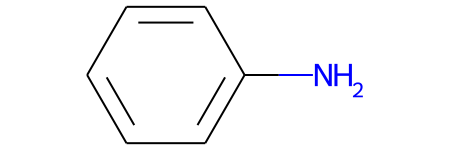

In [42]:
Chem.MolFromSmiles("NC1=CC(=C(C=C1))")

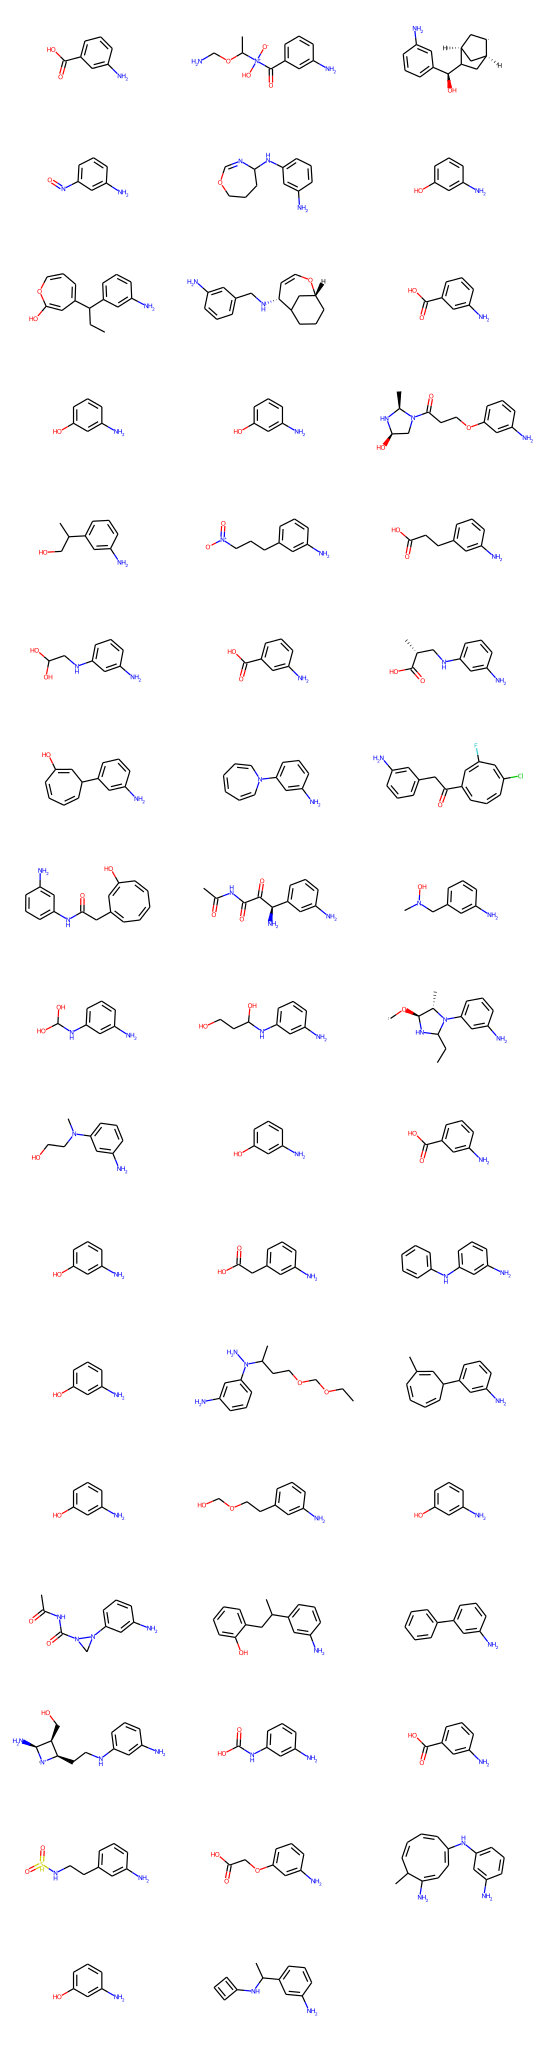

In [43]:
Chem.Draw.MolsToGridImage(a, subImgSize=(300,200), useSVG=True)